# **SEL-NNML Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `Kaggle Heart Failure Prediction Dataset (KHFPD)`.

## **0. Global Configuration**

In [11]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

# Training configuration
SKIP_TRAINING = False  # Set to True to load pre-existing models instead of training

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')
print(f'Skip Training: {SKIP_TRAINING}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize
Skip Training: False


## **1. Import Library**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import joblib

## **2. Load Dataset**

In [13]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              746 non-null    int64  
 1   Sex                              746 non-null    bool   
 2   RestingBP                        746 non-null    int64  
 3   Cholesterol                      746 non-null    int64  
 4   FastingBS                        746 non-null    bool   
 5   MaxHR                            746 non-null    int64  
 6   ExerciseAngina                   746 non-null    bool   
 7   Oldpeak                          746 non-null    float64
 8   HeartDisease                     746 non-null    bool   
 9   ChestPainType_ATA                746 non-null    bool   
 10  ChestPainType_NAP                746 non-null    bool   
 11  RestingECG_Normal                746 non-null    bool   
 12  ST_Slope_Flat         

Age    Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0     40   True        140          289      False    172           False   
1     49  False        160          180      False    156           False   
2     37   True        130          283      False     98           False   
3     48  False        138          214      False    108            True   
4     54   True        150          195      False    122           False   
..   ...    ...        ...          ...        ...    ...             ...   
741   45   True        110          264      False    132           False   
742   68   True        144          193       True    141           False   
743   57   True        130          131      False    115            True   
744   57  False        130          236      False    174           False   
745   38   True        138          175      False    173           False   

     Oldpeak  HeartDisease  ChestPainType_ATA  ChestPainType_NAP  \
0        0.0         False               True              False   
1        1.0          True              False               True   
2        0.0         False               True              False   
3        1.5          True              False              False   
4        0.0         False              False               True   
..       ...           ...                ...                ...   
741      1.2          True              False              False   
742      3.4          True              False              False   
743      1.2          True              False              False   
744      0.0          True               True              False   
745      0.0         False              False               True   

     RestingECG_Normal  ST_Slope_Flat  ST_Slope_Up  Male_ST_Slope_Flat  \
0                 True          False         True               False   
1                 True           True        False               False   
2                False          False         True               False   
3                 True           True        False               False   
4                 True          False         True               False   
..                 ...            ...          ...                 ...   
741               True           True        False                True   
742               True           True        False                True   
743               True           True        False                True   
744              False           True        False               False   
745               True          False         True               False   

     ChestPainType_ASY_ST_Slope_Flat  Male_ChestPainType_ASY  
0                              False                   False  
1                              False                   False  
2                              False                   False  
3                               True                   False  
4                              False                   False  
..                               ...                     ...  
741                            False                   False  
742                             True                    True  
743                             True                    True  
744                            False                   False  
745                            False                   False  

[746 rows x 17 columns]

## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [14]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds1/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds1/models/min_max_scaler.pkl


## **4. Base Model Hyperparameter Tuning**

**Note:** Set `SKIP_TRAINING = True` in the global configuration to skip steps 4 and 5 and load pre-existing models instead.

### **4.1 TPE & CV Hyperparameter Tuning**

In [16]:
if not SKIP_TRAINING:
    tpe_base_models_training_start = time.time()

    # TPE Hyperparameter Tuning with Cross Validation
    tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    tpe_logistic_regression.fit(X_train, y_train)
    tpe_decision_tree.fit(X_train, y_train)
    tpe_random_forest.fit(X_train, y_train)
    tpe_knn.fit(X_train, y_train)
    tpe_svc.fit(X_train, y_train)
    tpe_adaboost.fit(X_train, y_train)
    tpe_gradient_boosting.fit(X_train, y_train)

    tpe_base_models_training_end = time.time()

    # Time taken for TPE base models training
    tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
    print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')
else:
    print("Skipping TPE base models training (SKIP_TRAINING = True)")

[I 2025-11-05 21:52:12,671] A new study created in memory with name: Logistic Regression Model Fine Tuning with TPESampler
Best trial: 0. Best value: 0.64598:   1%|          | 1/100 [00:01<02:28,  1.50s/it]

[I 2025-11-05 21:52:14,170] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.


Best trial: 1. Best value: 0.850658:   2%|▏         | 2/100 [00:02<02:11,  1.34s/it]

[I 2025-11-05 21:52:15,399] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.


Best trial: 1. Best value: 0.850658:   3%|▎         | 3/100 [00:03<01:58,  1.22s/it]

[I 2025-11-05 21:52:16,467] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.


Best trial: 1. Best value: 0.850658:   8%|▊         | 8/100 [00:05<00:41,  2.21it/s]

[I 2025-11-05 21:52:17,518] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,557] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,595] Trial 5 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00017070728830306665}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,633] Trial 6 finished with value: 0.8372268907563025 and parameters: {'solver': 'sag', 'C': 6.732248920775331}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,672] Trial 7 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.015876781526923997}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,710] Trial 8 finished with value: 

Best trial: 11. Best value: 0.854006:  13%|█▎        | 13/100 [00:05<00:14,  5.91it/s]

[I 2025-11-05 21:52:17,748] Trial 9 finished with value: 0.7248879551820728 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,789] Trial 10 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cholesky', 'C': 1.1187356543600957}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:52:17,830] Trial 11 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.15812151458626894}. Best is trial 11 with value: 0.8540056022408965.
[I 2025-11-05 21:52:17,871] Trial 12 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.2826411346239431}. Best is trial 11 with value: 0.8540056022408965.
[I 2025-11-05 21:52:17,912] Trial 13 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.1548313056370992}. Best is trial 11 with value: 0.8540056022408965.


Best trial: 14. Best value: 0.855686:  19%|█▉        | 19/100 [00:05<00:07, 10.61it/s]

[I 2025-11-05 21:52:17,952] Trial 14 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.09972594704960062}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:17,994] Trial 15 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.06203312414676462}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,034] Trial 16 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.047656409640808216}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,075] Trial 17 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 1.998918219818694}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,115] Trial 18 finished with value: 0.8472829131652662 and parameters: {'solver': 'sag', 'C': 0.0067738300066027485}. Best is trial 14 with value: 0.8556862745098041.


Best trial: 14. Best value: 0.855686:  22%|██▏       | 22/100 [00:05<00:06, 12.98it/s]

[I 2025-11-05 21:52:18,156] Trial 19 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.057561380402283126}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,198] Trial 20 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cholesky', 'C': 0.8998683788955593}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,241] Trial 21 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cg', 'C': 0.0544556327467705}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,282] Trial 22 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cg', 'C': 0.052227774585499286}. Best is trial 14 with value: 0.8556862745098041.


Best trial: 24. Best value: 0.857367:  28%|██▊       | 28/100 [00:05<00:04, 15.63it/s]

[I 2025-11-05 21:52:18,408] Trial 23 finished with value: 0.8472969187675069 and parameters: {'solver': 'newton-cg', 'C': 0.009629479389652452}. Best is trial 14 with value: 0.8556862745098041.
[I 2025-11-05 21:52:18,449] Trial 24 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09767265811237309}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,490] Trial 25 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.17226820658879247}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,530] Trial 26 finished with value: 0.8523389355742296 and parameters: {'solver': 'newton-cg', 'C': 0.4366352557638391}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,571] Trial 27 finished with value: 0.8355462184873949 and parameters: {'solver': 'sag', 'C': 4.762669068815644}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  32%|███▏      | 32/100 [00:06<00:03, 17.17it/s]

[I 2025-11-05 21:52:18,612] Trial 28 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.025564277949394337}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,653] Trial 29 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cg', 'C': 0.12491521220001944}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,706] Trial 30 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cg', 'C': 0.0077375337665924184}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,751] Trial 31 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.089359073074445}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,792] Trial 32 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08221581184721419}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  37%|███▋      | 37/100 [00:06<00:03, 20.18it/s]

[I 2025-11-05 21:52:18,833] Trial 33 finished with value: 0.8523389355742296 and parameters: {'solver': 'newton-cg', 'C': 0.4068325186591481}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,876] Trial 34 finished with value: 0.8472969187675069 and parameters: {'solver': 'newton-cg', 'C': 0.7321293277958097}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,917] Trial 35 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.10116525254141118}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,957] Trial 36 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cg', 'C': 0.02310004675740012}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:18,998] Trial 37 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cg', 'C': 0.25593909449368524}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  43%|████▎     | 43/100 [00:06<00:02, 22.18it/s]

[I 2025-11-05 21:52:19,039] Trial 38 finished with value: 0.827156862745098 and parameters: {'solver': 'newton-cg', 'C': 0.003676883811074804}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,080] Trial 39 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 1.9872356792327135}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,121] Trial 40 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cg', 'C': 0.013473075989352282}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,162] Trial 41 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.0829839227188509}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,202] Trial 42 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.10028677306990692}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  47%|████▋     | 47/100 [00:06<00:02, 22.87it/s]

[I 2025-11-05 21:52:19,243] Trial 43 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.0344713919646158}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,283] Trial 44 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08511984334061942}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,324] Trial 45 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cg', 'C': 0.2466442221932089}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,365] Trial 46 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cholesky', 'C': 0.00021618818013690103}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,406] Trial 47 finished with value: 0.8472969187675069 and parameters: {'solver': 'newton-cholesky', 'C': 0.5648301257603934}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  52%|█████▏    | 52/100 [00:06<00:02, 23.77it/s]

[I 2025-11-05 21:52:19,446] Trial 48 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.03215770723901263}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,486] Trial 49 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.07531984218226175}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,527] Trial 50 finished with value: 0.8540056022408965 and parameters: {'solver': 'sag', 'C': 0.17536305948558256}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,567] Trial 51 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.03707504276106239}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,608] Trial 52 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.0830024083724565}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  58%|█████▊    | 58/100 [00:07<00:01, 24.04it/s]

[I 2025-11-05 21:52:19,650] Trial 53 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.01613323580382541}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,690] Trial 54 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08211889353251148}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,733] Trial 55 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.194476103516957}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,773] Trial 56 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.12149605514373864}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,814] Trial 57 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cg', 'C': 0.35941101174426904}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  62%|██████▏   | 62/100 [00:07<00:01, 24.04it/s]

[I 2025-11-05 21:52:19,855] Trial 58 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.04774584251144687}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,897] Trial 59 finished with value: 0.8456022408963586 and parameters: {'solver': 'newton-cg', 'C': 0.0047998867124816255}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,938] Trial 60 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.012996395693582553}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:19,983] Trial 61 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07857226547696418}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,023] Trial 62 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07834800587554026}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  67%|██████▋   | 67/100 [00:07<00:01, 24.11it/s]

[I 2025-11-05 21:52:20,064] Trial 63 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.022351824906115234}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,105] Trial 64 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cholesky', 'C': 0.04206987175744224}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,146] Trial 65 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.14020470161637186}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,187] Trial 66 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.06852356079398715}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,229] Trial 67 finished with value: 0.850658263305322 and parameters: {'solver': 'sag', 'C': 0.29577726392713094}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  73%|███████▎  | 73/100 [00:07<00:01, 24.02it/s]

[I 2025-11-05 21:52:20,270] Trial 68 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.19018788547719687}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,312] Trial 69 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.10283944225417663}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,355] Trial 70 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.02978111057460156}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,396] Trial 71 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.06005249271179928}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,437] Trial 72 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.06897685695535655}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  77%|███████▋  | 77/100 [00:07<00:00, 24.13it/s]

[I 2025-11-05 21:52:20,479] Trial 73 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08455448682477398}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,521] Trial 74 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.1296040407454154}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,561] Trial 75 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cg', 'C': 0.21040962256583276}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,602] Trial 76 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.04794689372482429}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,643] Trial 77 finished with value: 0.8523389355742296 and parameters: {'solver': 'newton-cg', 'C': 0.47449948435550054}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  82%|████████▏ | 82/100 [00:08<00:00, 24.15it/s]

[I 2025-11-05 21:52:20,683] Trial 78 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.019700529235524216}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,725] Trial 79 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09366328123192781}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,766] Trial 80 finished with value: 0.7667787114845938 and parameters: {'solver': 'newton-cholesky', 'C': 0.0013695212108777448}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,809] Trial 81 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.07481834279378459}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,850] Trial 82 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.1534676912110911}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  88%|████████▊ | 88/100 [00:08<00:00, 24.17it/s]

[I 2025-11-05 21:52:20,891] Trial 83 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cholesky', 'C': 0.0391833300457993}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,932] Trial 84 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.10492433438795513}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:20,974] Trial 85 finished with value: 0.850658263305322 and parameters: {'solver': 'sag', 'C': 0.2795235007529721}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,016] Trial 86 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.05300322701952149}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,057] Trial 87 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.02725069230679014}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  92%|█████████▏| 92/100 [00:08<00:00, 23.34it/s]

[I 2025-11-05 21:52:21,098] Trial 88 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cg', 'C': 0.1291781503265428}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,139] Trial 89 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07730586648607454}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,194] Trial 90 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.059948497590128845}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,239] Trial 91 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08136093781878215}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,280] Trial 92 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08417638708889648}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367:  97%|█████████▋| 97/100 [00:08<00:00, 23.40it/s]

[I 2025-11-05 21:52:21,321] Trial 93 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cholesky', 'C': 0.24247787470425972}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,364] Trial 94 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.034278504687514436}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,407] Trial 95 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.1627649803313837}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,450] Trial 96 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.11108880443801417}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,492] Trial 97 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cholesky', 'C': 0.04352740739315004}. Best is trial 24 with value: 0.8573669467787116.


Best trial: 24. Best value: 0.857367: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]
[I 2025-11-05 21:52:21,581] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler
Best trial: 24. Best value: 0.857367: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]
[I 2025-11-05 21:52:21,581] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler


[I 2025-11-05 21:52:21,532] Trial 98 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.05941864093493929}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-11-05 21:52:21,576] Trial 99 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cholesky', 'C': 0.21100777741857157}. Best is trial 24 with value: 0.8573669467787116.

Best Hyperparameters for Logistic Regression Using TPESampler: {'solver': 'newton-cg', 'C': 0.09767265811237309}
Best accuracy: 0.8574, at trial: 24


Best trial: 0. Best value: 0.813754:   2%|▏         | 2/100 [00:00<00:05, 18.74it/s]

[I 2025-11-05 21:52:21,639] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-11-05 21:52:21,687] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.


Best trial: 3. Best value: 0.827185:   4%|▍         | 4/100 [00:00<00:05, 16.65it/s]

[I 2025-11-05 21:52:21,755] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-11-05 21:52:21,816] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:   8%|▊         | 8/100 [00:00<00:03, 24.73it/s]

[I 2025-11-05 21:52:21,844] Trial 4 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:21,873] Trial 5 finished with value: 0.8188095238095239 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:21,902] Trial 6 finished with value: 0.8171148459383752 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:21,930] Trial 7 finished with value: 0.7902240896358543 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8271848739

Best trial: 3. Best value: 0.827185:  10%|█         | 10/100 [00:00<00:03, 24.73it/s]

[I 2025-11-05 21:52:21,960] Trial 8 finished with value: 0.7969467787114846 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:21,988] Trial 9 finished with value: 0.8187815126050421 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:22,024] Trial 10 finished with value: 0.813767507002801 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 12. Best value: 0.828852:  13%|█▎        | 13/100 [00:00<00:03, 27.08it/s]

[I 2025-11-05 21:52:22,062] Trial 11 finished with value: 0.8104061624649861 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:52:22,106] Trial 12 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,143] Trial 13 finished with value: 0.7885994397759104 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.8288515406162464.


Best trial: 12. Best value: 0.828852:  16%|█▌        | 16/100 [00:00<00:03, 26.65it/s]

[I 2025-11-05 21:52:22,179] Trial 14 finished with value: 0.8204481792717087 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,216] Trial 15 finished with value: 0.8238095238095238 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,255] Trial 16 finished with value: 0.8238515406162465 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.8288515406162464.


Best trial: 12. Best value: 0.828852:  19%|█▉        | 19/100 [00:00<00:03, 26.70it/s]

[I 2025-11-05 21:52:22,291] Trial 17 finished with value: 0.8053081232492996 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,327] Trial 18 finished with value: 0.8238515406162465 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,353] Trial 19 finished with value: 0.8205042016806722 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 12 with value: 0.8288515406162464.


Best trial: 21. Best value: 0.833908:  22%|██▏       | 22/100 [00:00<00:02, 27.83it/s]

[I 2025-11-05 21:52:22,389] Trial 20 finished with value: 0.8238095238095238 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 12 with value: 0.8288515406162464.
[I 2025-11-05 21:52:22,425] Trial 21 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,461] Trial 22 finished with value: 0.8053501400560223 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8339075630252101.


[I 2025-11-05 21:52:22,496] Trial 23 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,530] Trial 24 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  28%|██▊       | 28/100 [00:01<00:02, 25.81it/s]

[I 2025-11-05 21:52:22,589] Trial 25 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,629] Trial 26 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,668] Trial 27 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  31%|███       | 31/100 [00:01<00:02, 26.08it/s]

[I 2025-11-05 21:52:22,705] Trial 28 finished with value: 0.8237955182072829 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,740] Trial 29 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,781] Trial 30 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  34%|███▍      | 34/100 [00:01<00:02, 26.24it/s]

[I 2025-11-05 21:52:22,818] Trial 31 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,856] Trial 32 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,894] Trial 33 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  37%|███▋      | 37/100 [00:01<00:02, 26.49it/s]

[I 2025-11-05 21:52:22,932] Trial 34 finished with value: 0.8154481792717088 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:22,968] Trial 35 finished with value: 0.7952801120448179 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,005] Trial 36 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  40%|████      | 40/100 [00:01<00:02, 26.79it/s]

[I 2025-11-05 21:52:23,041] Trial 37 finished with value: 0.8338935574229691 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,077] Trial 38 finished with value: 0.8137535014005601 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,113] Trial 39 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  43%|████▎     | 43/100 [00:01<00:02, 26.80it/s]

[I 2025-11-05 21:52:23,149] Trial 40 finished with value: 0.8237955182072829 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,187] Trial 41 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,224] Trial 42 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  46%|████▌     | 46/100 [00:01<00:02, 26.10it/s]

[I 2025-11-05 21:52:23,263] Trial 43 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,306] Trial 44 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,347] Trial 45 finished with value: 0.8136834733893558 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  49%|████▉     | 49/100 [00:01<00:01, 26.17it/s]

[I 2025-11-05 21:52:23,387] Trial 46 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,424] Trial 47 finished with value: 0.8154481792717088 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,461] Trial 48 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  52%|█████▏    | 52/100 [00:01<00:01, 26.48it/s]

[I 2025-11-05 21:52:23,500] Trial 49 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,536] Trial 50 finished with value: 0.8255042016806723 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,571] Trial 51 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  54%|█████▍    | 54/100 [00:02<00:01, 26.48it/s]

[I 2025-11-05 21:52:23,611] Trial 52 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,661] Trial 53 finished with value: 0.8154481792717088 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,699] Trial 54 finished with value: 0.8104061624649861 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  57%|█████▋    | 57/100 [00:02<00:01, 25.45it/s]

[I 2025-11-05 21:52:23,737] Trial 55 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,774] Trial 56 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,811] Trial 57 finished with value: 0.8187955182072828 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  61%|██████    | 61/100 [00:02<00:01, 25.79it/s]

[I 2025-11-05 21:52:23,849] Trial 58 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,891] Trial 59 finished with value: 0.8204481792717087 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:23,928] Trial 60 finished with value: 0.8120728291316526 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  64%|██████▍   | 64/100 [00:02<00:01, 26.24it/s]

[I 2025-11-05 21:52:23,965] Trial 61 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,002] Trial 62 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,038] Trial 63 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  67%|██████▋   | 67/100 [00:02<00:01, 26.36it/s]

[I 2025-11-05 21:52:24,076] Trial 64 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,115] Trial 65 finished with value: 0.8204481792717087 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,151] Trial 66 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  70%|███████   | 70/100 [00:02<00:01, 26.58it/s]

[I 2025-11-05 21:52:24,188] Trial 67 finished with value: 0.8120868347338936 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,225] Trial 68 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,262] Trial 69 finished with value: 0.8288375350140056 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  73%|███████▎  | 73/100 [00:02<00:01, 26.32it/s]

[I 2025-11-05 21:52:24,300] Trial 70 finished with value: 0.8154481792717088 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,336] Trial 71 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,378] Trial 72 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  74%|███████▍  | 74/100 [00:02<00:00, 26.32it/s]

[I 2025-11-05 21:52:24,422] Trial 73 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,464] Trial 74 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  77%|███████▋  | 77/100 [00:03<00:00, 25.62it/s]

[I 2025-11-05 21:52:24,501] Trial 75 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,552] Trial 76 finished with value: 0.8237955182072829 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,592] Trial 77 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  79%|███████▉  | 79/100 [00:03<00:00, 25.04it/s]

[I 2025-11-05 21:52:24,629] Trial 78 finished with value: 0.8070028011204482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,667] Trial 79 finished with value: 0.8221288515406162 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  83%|████████▎ | 83/100 [00:03<00:00, 25.59it/s]

[I 2025-11-05 21:52:24,703] Trial 80 finished with value: 0.8120728291316526 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,740] Trial 81 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,777] Trial 82 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,814] Trial 83 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8

Best trial: 21. Best value: 0.833908:  85%|████████▌ | 85/100 [00:03<00:00, 26.08it/s]

[I 2025-11-05 21:52:24,850] Trial 84 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,887] Trial 85 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  89%|████████▉ | 89/100 [00:03<00:00, 26.38it/s]

[I 2025-11-05 21:52:24,924] Trial 86 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,961] Trial 87 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:24,998] Trial 88 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,036] Trial 89 finished with value: 0.8204621848739496 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8

Best trial: 21. Best value: 0.833908:  91%|█████████ | 91/100 [00:03<00:00, 26.30it/s]

[I 2025-11-05 21:52:25,075] Trial 90 finished with value: 0.8053501400560223 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,111] Trial 91 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908:  95%|█████████▌| 95/100 [00:03<00:00, 26.60it/s]

[I 2025-11-05 21:52:25,149] Trial 92 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,185] Trial 93 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,223] Trial 94 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,260] Trial 95 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.83

Best trial: 21. Best value: 0.833908:  97%|█████████▋| 97/100 [00:03<00:00, 25.26it/s]

[I 2025-11-05 21:52:25,317] Trial 96 finished with value: 0.8086834733893558 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.


Best trial: 21. Best value: 0.833908: 100%|██████████| 100/100 [00:03<00:00, 25.93it/s]
[I 2025-11-05 21:52:25,442] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler
Best trial: 21. Best value: 0.833908: 100%|██████████| 100/100 [00:03<00:00, 25.93it/s]
[I 2025-11-05 21:52:25,442] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler


[I 2025-11-05 21:52:25,356] Trial 97 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,398] Trial 98 finished with value: 0.8104061624649861 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8339075630252101.
[I 2025-11-05 21:52:25,436] Trial 99 finished with value: 0.8171148459383752 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.

Best Hyperparameters for Decision Tree Using TPESampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}
Best accuracy: 0.8339, at trial: 21


Best trial: 0. Best value: 0.837241:   1%|          | 1/100 [00:00<00:11,  8.88it/s]

[I 2025-11-05 21:52:25,552] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.


Best trial: 1. Best value: 0.859076:   2%|▏         | 2/100 [00:00<00:14,  6.76it/s]

[I 2025-11-05 21:52:25,725] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   3%|▎         | 3/100 [00:00<00:14,  6.91it/s]

[I 2025-11-05 21:52:25,866] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   4%|▍         | 4/100 [00:00<00:13,  6.98it/s]

[I 2025-11-05 21:52:26,007] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   5%|▌         | 5/100 [00:00<00:13,  7.18it/s]

[I 2025-11-05 21:52:26,140] Trial 4 finished with value: 0.8389355742296918 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   5%|▌         | 5/100 [00:00<00:13,  7.18it/s]

[I 2025-11-05 21:52:26,229] Trial 5 finished with value: 0.8339075630252101 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   7%|▋         | 7/100 [00:00<00:12,  7.73it/s]

[I 2025-11-05 21:52:26,378] Trial 6 finished with value: 0.8288795518207281 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   8%|▊         | 8/100 [00:01<00:14,  6.38it/s]

[I 2025-11-05 21:52:26,611] Trial 7 finished with value: 0.8439495798319326 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  10%|█         | 10/100 [00:01<00:16,  5.42it/s]

[I 2025-11-05 21:52:26,884] Trial 8 finished with value: 0.8456582633053223 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:52:27,057] Trial 9 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  12%|█▏        | 12/100 [00:02<00:17,  5.04it/s]

[I 2025-11-05 21:52:27,318] Trial 10 finished with value: 0.850672268907563 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:52:27,498] Trial 11 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  13%|█▎        | 13/100 [00:02<00:16,  5.15it/s]

[I 2025-11-05 21:52:27,682] Trial 12 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 53, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 13. Best value: 0.86077:  14%|█▍        | 14/100 [00:02<00:17,  5.02it/s]

[I 2025-11-05 21:52:27,893] Trial 13 finished with value: 0.8607703081232494 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8607703081232494.


Best trial: 13. Best value: 0.86077:  16%|█▌        | 16/100 [00:02<00:15,  5.37it/s]

[I 2025-11-05 21:52:28,102] Trial 14 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.8607703081232494.
[I 2025-11-05 21:52:28,251] Trial 15 finished with value: 0.8489775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 43, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8607703081232494.


Best trial: 13. Best value: 0.86077:  17%|█▋        | 17/100 [00:03<00:17,  4.76it/s]

[I 2025-11-05 21:52:28,517] Trial 16 finished with value: 0.8540196078431371 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8607703081232494.
[I 2025-11-05 21:52:28,716] Trial 17 finished with value: 0.8540476190476189 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 63, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.8607703081232494.


Best trial: 19. Best value: 0.862423:  20%|██        | 20/100 [00:03<00:16,  4.91it/s]

[I 2025-11-05 21:52:28,978] Trial 18 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 85, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 13 with value: 0.8607703081232494.
[I 2025-11-05 21:52:29,136] Trial 19 finished with value: 0.8624229691876751 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 48, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  22%|██▏       | 22/100 [00:04<00:15,  5.15it/s]

[I 2025-11-05 21:52:29,336] Trial 20 finished with value: 0.8439775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:29,509] Trial 21 finished with value: 0.8573809523809522 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 44, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  24%|██▍       | 24/100 [00:04<00:12,  5.94it/s]

[I 2025-11-05 21:52:29,632] Trial 22 finished with value: 0.8473249299719889 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 31, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:29,790] Trial 23 finished with value: 0.8439775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  26%|██▌       | 26/100 [00:04<00:13,  5.50it/s]

[I 2025-11-05 21:52:29,984] Trial 24 finished with value: 0.8540336134453781 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:30,180] Trial 25 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  27%|██▋       | 27/100 [00:04<00:13,  5.24it/s]

[I 2025-11-05 21:52:30,392] Trial 26 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  28%|██▊       | 28/100 [00:05<00:14,  5.08it/s]

[I 2025-11-05 21:52:30,603] Trial 27 finished with value: 0.8490056022408965 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  29%|██▉       | 29/100 [00:05<00:14,  4.76it/s]

[I 2025-11-05 21:52:30,844] Trial 28 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 82, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  30%|███       | 30/100 [00:05<00:14,  4.69it/s]

[I 2025-11-05 21:52:31,065] Trial 29 finished with value: 0.8490196078431371 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 68, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  32%|███▏      | 32/100 [00:06<00:13,  5.07it/s]

[I 2025-11-05 21:52:31,287] Trial 30 finished with value: 0.8473249299719887 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 74, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:31,440] Trial 31 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  33%|███▎      | 33/100 [00:06<00:12,  5.16it/s]

[I 2025-11-05 21:52:31,626] Trial 32 finished with value: 0.8423249299719886 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 49, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:31,713] Trial 33 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 11, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  36%|███▌      | 36/100 [00:06<00:10,  6.21it/s]

[I 2025-11-05 21:52:31,832] Trial 34 finished with value: 0.8573949579831932 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 30, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:32,022] Trial 35 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 61, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  38%|███▊      | 38/100 [00:06<00:09,  6.50it/s]

[I 2025-11-05 21:52:32,141] Trial 36 finished with value: 0.840644257703081 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 24, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:32,303] Trial 37 finished with value: 0.8473389355742296 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 38, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  40%|████      | 40/100 [00:07<00:09,  6.16it/s]

[I 2025-11-05 21:52:32,441] Trial 38 finished with value: 0.8473109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 33, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:32,636] Trial 39 finished with value: 0.8406302521008403 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 40, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  42%|████▏     | 42/100 [00:07<00:10,  5.69it/s]

[I 2025-11-05 21:52:32,818] Trial 40 finished with value: 0.8540196078431371 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 53, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:33,012] Trial 41 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  44%|████▍     | 44/100 [00:07<00:10,  5.31it/s]

[I 2025-11-05 21:52:33,225] Trial 42 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:33,417] Trial 43 finished with value: 0.8439775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  46%|████▌     | 46/100 [00:08<00:09,  5.60it/s]

[I 2025-11-05 21:52:33,585] Trial 44 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:33,755] Trial 45 finished with value: 0.8439775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  48%|████▊     | 48/100 [00:08<00:08,  5.87it/s]

[I 2025-11-05 21:52:33,917] Trial 46 finished with value: 0.8590616246498598 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 47, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:34,079] Trial 47 finished with value: 0.8406022408963585 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 43, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  50%|█████     | 50/100 [00:08<00:07,  6.69it/s]

[I 2025-11-05 21:52:34,238] Trial 48 finished with value: 0.8490056022408965 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 34, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:34,347] Trial 49 finished with value: 0.8439915966386554 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 23, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 19. Best value: 0.862423:  52%|█████▏    | 52/100 [00:09<00:08,  5.50it/s]

[I 2025-11-05 21:52:34,590] Trial 50 finished with value: 0.8590616246498598 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 75, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:34,782] Trial 51 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 56, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8624229691876751.


Best trial: 53. Best value: 0.862437:  54%|█████▍    | 54/100 [00:09<00:08,  5.38it/s]

[I 2025-11-05 21:52:34,984] Trial 52 finished with value: 0.8590616246498598 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 54, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 19 with value: 0.8624229691876751.
[I 2025-11-05 21:52:35,165] Trial 53 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  56%|█████▌    | 56/100 [00:10<00:08,  5.21it/s]

[I 2025-11-05 21:52:35,366] Trial 54 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.
[I 2025-11-05 21:52:35,562] Trial 55 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  57%|█████▋    | 57/100 [00:10<00:08,  5.21it/s]

[I 2025-11-05 21:52:35,753] Trial 56 finished with value: 0.8473249299719889 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 64, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  58%|█████▊    | 58/100 [00:10<00:08,  4.78it/s]

[I 2025-11-05 21:52:36,004] Trial 57 finished with value: 0.8624229691876749 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  59%|█████▉    | 59/100 [00:10<00:08,  4.69it/s]

[I 2025-11-05 21:52:36,225] Trial 58 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  60%|██████    | 60/100 [00:11<00:08,  4.55it/s]

[I 2025-11-05 21:52:36,461] Trial 59 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  61%|██████    | 61/100 [00:11<00:08,  4.36it/s]

[I 2025-11-05 21:52:36,713] Trial 60 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  62%|██████▏   | 62/100 [00:11<00:09,  4.06it/s]

[I 2025-11-05 21:52:36,999] Trial 61 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  63%|██████▎   | 63/100 [00:11<00:09,  3.73it/s]

[I 2025-11-05 21:52:37,318] Trial 62 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  64%|██████▍   | 64/100 [00:12<00:09,  3.70it/s]

[I 2025-11-05 21:52:37,592] Trial 63 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


[I 2025-11-05 21:52:37,827] Trial 64 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  66%|██████▌   | 66/100 [00:12<00:08,  4.13it/s]

[I 2025-11-05 21:52:38,027] Trial 65 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  67%|██████▋   | 67/100 [00:12<00:07,  4.23it/s]

[I 2025-11-05 21:52:38,250] Trial 66 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  68%|██████▊   | 68/100 [00:13<00:07,  4.13it/s]

[I 2025-11-05 21:52:38,506] Trial 67 finished with value: 0.8439775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  69%|██████▉   | 69/100 [00:13<00:07,  4.24it/s]

[I 2025-11-05 21:52:38,728] Trial 68 finished with value: 0.8607282913165266 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  71%|███████   | 71/100 [00:13<00:06,  4.28it/s]

[I 2025-11-05 21:52:39,007] Trial 69 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 77, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.
[I 2025-11-05 21:52:39,205] Trial 70 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  72%|███████▏  | 72/100 [00:14<00:06,  4.46it/s]

[I 2025-11-05 21:52:39,407] Trial 71 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.
[I 2025-11-05 21:52:39,607] Trial 72 finished with value: 0.8590896358543418 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  74%|███████▍  | 74/100 [00:14<00:05,  4.64it/s]

[I 2025-11-05 21:52:39,819] Trial 73 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  76%|███████▌  | 76/100 [00:14<00:04,  4.82it/s]

[I 2025-11-05 21:52:40,022] Trial 74 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.
[I 2025-11-05 21:52:40,219] Trial 75 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  78%|███████▊  | 78/100 [00:15<00:04,  5.08it/s]

[I 2025-11-05 21:52:40,412] Trial 76 finished with value: 0.8490056022408963 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 62, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 53 with value: 0.8624369747899159.
[I 2025-11-05 21:52:40,594] Trial 77 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 53, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  79%|███████▉  | 79/100 [00:15<00:04,  4.98it/s]

[I 2025-11-05 21:52:40,805] Trial 78 finished with value: 0.850686274509804 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 72, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  80%|████████  | 80/100 [00:15<00:04,  4.93it/s]

[I 2025-11-05 21:52:41,013] Trial 79 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 68, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  81%|████████  | 81/100 [00:15<00:04,  4.45it/s]

[I 2025-11-05 21:52:41,287] Trial 80 finished with value: 0.8523669467787114 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 53. Best value: 0.862437:  82%|████████▏ | 82/100 [00:16<00:04,  4.46it/s]

[I 2025-11-05 21:52:41,512] Trial 81 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 53 with value: 0.8624369747899159.


Best trial: 82. Best value: 0.867465:  83%|████████▎ | 83/100 [00:16<00:03,  4.59it/s]

[I 2025-11-05 21:52:41,714] Trial 82 finished with value: 0.8674649859943976 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  84%|████████▍ | 84/100 [00:16<00:03,  4.62it/s]

[I 2025-11-05 21:52:41,927] Trial 83 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  86%|████████▌ | 86/100 [00:16<00:02,  4.85it/s]

[I 2025-11-05 21:52:42,131] Trial 84 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 64, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:42,322] Trial 85 finished with value: 0.8406302521008403 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 56, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  87%|████████▋ | 87/100 [00:17<00:02,  4.59it/s]

[I 2025-11-05 21:52:42,566] Trial 86 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  89%|████████▉ | 89/100 [00:17<00:02,  4.67it/s]

[I 2025-11-05 21:52:42,810] Trial 87 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:42,997] Trial 88 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  91%|█████████ | 91/100 [00:17<00:01,  4.93it/s]

[I 2025-11-05 21:52:43,189] Trial 89 finished with value: 0.8473389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:43,380] Trial 90 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  92%|█████████▏| 92/100 [00:18<00:01,  4.53it/s]

[I 2025-11-05 21:52:43,643] Trial 91 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  93%|█████████▎| 93/100 [00:18<00:01,  4.46it/s]

[I 2025-11-05 21:52:43,877] Trial 92 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 74, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  95%|█████████▌| 95/100 [00:18<00:01,  4.97it/s]

[I 2025-11-05 21:52:44,081] Trial 93 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:44,243] Trial 94 finished with value: 0.8573809523809522 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 45, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  97%|█████████▋| 97/100 [00:19<00:00,  4.84it/s]

[I 2025-11-05 21:52:44,494] Trial 95 finished with value: 0.8590896358543418 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:44,677] Trial 96 finished with value: 0.8473389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465:  98%|█████████▊| 98/100 [00:19<00:00,  4.75it/s]

[I 2025-11-05 21:52:44,898] Trial 97 finished with value: 0.8506862745098038 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 82 with value: 0.8674649859943976.


Best trial: 82. Best value: 0.867465: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]
[I 2025-11-05 21:52:45,298] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler
Best trial: 82. Best value: 0.867465: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]
[I 2025-11-05 21:52:45,298] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler


[I 2025-11-05 21:52:45,113] Trial 98 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 82 with value: 0.8674649859943976.
[I 2025-11-05 21:52:45,293] Trial 99 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 82 with value: 0.8674649859943976.

Best Hyperparameters for Random Forest Using TPESampler: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best accuracy: 0.8675, at trial: 82


Best trial: 0. Best value: 0.852325:   4%|▍         | 4/100 [00:00<00:05, 17.53it/s]

[I 2025-11-05 21:52:45,345] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:52:45,403] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:52:45,452] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:52:45,521] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.


Best trial: 6. Best value: 0.85902:   7%|▋         | 7/100 [00:00<00:05, 17.88it/s] 

[I 2025-11-05 21:52:45,582] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:52:45,631] Trial 5 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:52:45,682] Trial 6 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 6 with value: 0.8590196078431372.
[I 2025-11-05 21:52:45,731] Trial 7 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 6 with value: 0.8590196078431372.


Best trial: 8. Best value: 0.8607:  11%|█         | 11/100 [00:00<00:05, 16.60it/s]

[I 2025-11-05 21:52:45,790] Trial 8 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 8 with value: 0.8607002801120448.
[I 2025-11-05 21:52:45,879] Trial 9 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 8 with value: 0.8607002801120448.
[I 2025-11-05 21:52:45,936] Trial 10 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 8 with value: 0.8607002801120448.
[I 2025-11-05 21:52:45,989] Trial 11 finished with value: 0.8556582633053221 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 8 with value: 0.8607002801120448.


Best trial: 12. Best value: 0.862409:  15%|█▌        | 15/100 [00:00<00:04, 17.24it/s]

[I 2025-11-05 21:52:46,043] Trial 12 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,096] Trial 13 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,158] Trial 14 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,211] Trial 15 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  19%|█▉        | 19/100 [00:01<00:04, 18.05it/s]

[I 2025-11-05 21:52:46,264] Trial 16 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,317] Trial 17 finished with value: 0.8472689075630251 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,371] Trial 18 finished with value: 0.8238095238095238 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,423] Trial 19 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  24%|██▍       | 24/100 [00:01<00:04, 18.58it/s]

[I 2025-11-05 21:52:46,477] Trial 20 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,530] Trial 21 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,577] Trial 22 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,634] Trial 23 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  29%|██▉       | 29/100 [00:01<00:03, 19.61it/s]

[I 2025-11-05 21:52:46,678] Trial 24 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,711] Trial 25 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'brute', 'n_neighbors': 26, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,768] Trial 26 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,813] Trial 27 finished with value: 0.8556582633053221 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,872] Trial 28 finished with value: 0.8539915966386555 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  33%|███▎      | 33/100 [00:01<00:03, 19.09it/s]

[I 2025-11-05 21:52:46,928] Trial 29 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:46,981] Trial 30 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,036] Trial 31 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,089] Trial 32 finished with value: 0.8556862745098041 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 33, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  36%|███▌      | 36/100 [00:01<00:03, 19.00it/s]

[I 2025-11-05 21:52:47,142] Trial 33 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,195] Trial 34 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,248] Trial 35 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,282] Trial 36 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  40%|████      | 40/100 [00:02<00:03, 18.65it/s]

[I 2025-11-05 21:52:47,346] Trial 37 finished with value: 0.850658263305322 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,404] Trial 38 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 32, 'p': 1}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,463] Trial 39 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,508] Trial 40 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 1}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  46%|████▌     | 46/100 [00:02<00:02, 20.67it/s]

[I 2025-11-05 21:52:47,553] Trial 41 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,598] Trial 42 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,643] Trial 43 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,687] Trial 44 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,732] Trial 45 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  49%|████▉     | 49/100 [00:02<00:02, 20.41it/s]

[I 2025-11-05 21:52:47,775] Trial 46 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,833] Trial 47 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,881] Trial 48 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:47,949] Trial 49 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  55%|█████▌    | 55/100 [00:02<00:02, 19.83it/s]

[I 2025-11-05 21:52:48,015] Trial 50 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,060] Trial 51 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,106] Trial 52 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,155] Trial 53 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,199] Trial 54 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 29, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  59%|█████▉    | 59/100 [00:03<00:01, 20.67it/s]

[I 2025-11-05 21:52:48,234] Trial 55 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,287] Trial 56 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,330] Trial 57 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,368] Trial 58 finished with value: 0.8422549019607842 and parameters: {'algorithm': 'brute', 'n_neighbors': 13, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,422] Trial 59 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  64%|██████▍   | 64/100 [00:03<00:01, 19.23it/s]

[I 2025-11-05 21:52:48,466] Trial 60 finished with value: 0.8456022408963586 and parameters: {'algorithm': 'brute', 'n_neighbors': 16, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,543] Trial 61 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,600] Trial 62 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,654] Trial 63 finished with value: 0.8305042016806722 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  69%|██████▉   | 69/100 [00:03<00:01, 20.06it/s]

[I 2025-11-05 21:52:48,707] Trial 64 finished with value: 0.8573389355742297 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,761] Trial 65 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,807] Trial 66 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,861] Trial 67 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,895] Trial 68 finished with value: 0.8539915966386555 and parameters: {'algorithm': 'brute', 'n_neighbors': 34, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  72%|███████▏  | 72/100 [00:03<00:01, 19.95it/s]

[I 2025-11-05 21:52:48,949] Trial 69 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:48,992] Trial 70 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,047] Trial 71 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,101] Trial 72 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  77%|███████▋  | 77/100 [00:04<00:01, 19.32it/s]

[I 2025-11-05 21:52:49,155] Trial 73 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,209] Trial 74 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,262] Trial 75 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,316] Trial 76 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  80%|████████  | 80/100 [00:04<00:01, 19.42it/s]

[I 2025-11-05 21:52:49,360] Trial 77 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,414] Trial 78 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,468] Trial 79 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,513] Trial 80 finished with value: 0.8573389355742297 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  85%|████████▌ | 85/100 [00:04<00:00, 19.02it/s]

[I 2025-11-05 21:52:49,567] Trial 81 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,624] Trial 82 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,678] Trial 83 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,735] Trial 84 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  90%|█████████ | 90/100 [00:04<00:00, 20.04it/s]

[I 2025-11-05 21:52:49,791] Trial 85 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,845] Trial 86 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,879] Trial 87 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,933] Trial 88 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:49,977] Trial 89 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'brute', 'n_neighbors': 49, 'p': 1}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  93%|█████████▎| 93/100 [00:04<00:00, 20.02it/s]

[I 2025-11-05 21:52:50,020] Trial 90 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,073] Trial 91 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,127] Trial 92 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,181] Trial 93 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409:  97%|█████████▋| 97/100 [00:05<00:00, 19.19it/s]

[I 2025-11-05 21:52:50,234] Trial 94 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,292] Trial 95 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,346] Trial 96 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,399] Trial 97 finished with value: 0.8540056022408964 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 24, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.


Best trial: 12. Best value: 0.862409: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]
[I 2025-11-05 21:52:50,507] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler
Best trial: 12. Best value: 0.862409: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]
[I 2025-11-05 21:52:50,507] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler


[I 2025-11-05 21:52:50,446] Trial 98 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.
[I 2025-11-05 21:52:50,502] Trial 99 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.

Best Hyperparameters for K-Nearest Neighbors Using TPESampler: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8624, at trial: 12


Best trial: 2. Best value: 0.545322:   3%|▎         | 3/100 [00:00<00:04, 22.54it/s]

[I 2025-11-05 21:52:50,555] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-05 21:52:50,593] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-05 21:52:50,640] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 2. Best value: 0.545322:   4%|▍         | 4/100 [00:00<00:04, 22.54it/s]

[I 2025-11-05 21:52:50,688] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:52:50,736] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 2. Best value: 0.545322:   7%|▋         | 7/100 [00:00<00:04, 22.17it/s]

[I 2025-11-05 21:52:50,776] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0005404103854647331}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:52:50,825] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010677482709481358}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:52:50,874] Trial 7 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00021930485556643703, 'degree': 2}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 2. Best value: 0.545322:   9%|▉         | 9/100 [00:00<00:04, 20.46it/s]

[I 2025-11-05 21:52:50,936] Trial 8 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004066563313514797}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 11. Best value: 0.832171:  13%|█▎        | 13/100 [00:00<00:03, 22.44it/s]

[I 2025-11-05 21:52:50,985] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00017541893487450815}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:52:51,018] Trial 10 finished with value: 0.8187254901960783 and parameters: {'kernel': 'poly', 'C': 0.007335514278058898, 'degree': 5}. Best is trial 10 with value: 0.8187254901960783.
[I 2025-11-05 21:52:51,050] Trial 11 finished with value: 0.8321708683473389 and parameters: {'kernel': 'poly', 'C': 0.009580123613205892, 'degree': 5}. Best is trial 11 with value: 0.8321708683473389.
[I 2025-11-05 21:52:51,083] Trial 12 finished with value: 0.7735014005602242 and parameters: {'kernel': 'poly', 'C': 0.003617714955345072, 'degree': 5}. Best is trial 11 with value: 0.8321708683473389.
[I 2025-11-05 21:52:51,116] Trial 13 finished with value: 0.7718207282913166 and parameters: {'kernel': 'poly', 'C': 0.0027337623894788787, 'degree': 5}. Best is trial 11 with value: 0.8321708683473389.

Best trial: 14. Best value: 0.833838:  15%|█▌        | 15/100 [00:00<00:03, 24.04it/s]

[I 2025-11-05 21:52:51,159] Trial 14 finished with value: 0.8338375350140057 and parameters: {'kernel': 'poly', 'C': 0.009634955722383542, 'degree': 5}. Best is trial 14 with value: 0.8338375350140057.


Best trial: 14. Best value: 0.833838:  18%|█▊        | 18/100 [00:00<00:03, 24.41it/s]

[I 2025-11-05 21:52:51,202] Trial 15 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.002397622727424075, 'degree': 4}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,246] Trial 16 finished with value: 0.7718067226890757 and parameters: {'kernel': 'poly', 'C': 0.004812370668209518, 'degree': 4}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,279] Trial 17 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.009870099073530512, 'degree': 3}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,322] Trial 18 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.0017215476725043046, 'degree': 5}. Best is trial 14 with value: 0.8338375350140057.


Best trial: 14. Best value: 0.833838:  19%|█▉        | 19/100 [00:00<00:03, 24.41it/s]

[I 2025-11-05 21:52:51,379] Trial 19 finished with value: 0.7718067226890757 and parameters: {'kernel': 'poly', 'C': 0.004943018624063405, 'degree': 4}. Best is trial 14 with value: 0.8338375350140057.


Best trial: 23. Best value: 0.835518:  24%|██▍       | 24/100 [00:01<00:03, 22.35it/s]

[I 2025-11-05 21:52:51,429] Trial 20 finished with value: 0.753375350140056 and parameters: {'kernel': 'poly', 'C': 0.00101395446480101, 'degree': 3}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,476] Trial 21 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.006732534117889711, 'degree': 5}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,523] Trial 22 finished with value: 0.8338375350140057 and parameters: {'kernel': 'poly', 'C': 0.009624188197704678, 'degree': 5}. Best is trial 14 with value: 0.8338375350140057.
[I 2025-11-05 21:52:51,568] Trial 23 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009980295032795012, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  24%|██▍       | 24/100 [00:01<00:03, 22.35it/s]

[I 2025-11-05 21:52:51,617] Trial 24 finished with value: 0.7718207282913166 and parameters: {'kernel': 'poly', 'C': 0.003669882086077255, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  28%|██▊       | 28/100 [00:01<00:03, 22.53it/s]

[I 2025-11-05 21:52:51,657] Trial 25 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.006234586431169063}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,699] Trial 26 finished with value: 0.6459803921568626 and parameters: {'kernel': 'poly', 'C': 0.0001051909502813386, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,746] Trial 27 finished with value: 0.7735014005602242 and parameters: {'kernel': 'poly', 'C': 0.003035072575984439, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,782] Trial 28 finished with value: 0.7835574229691877 and parameters: {'kernel': 'poly', 'C': 0.004301744354985008, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  30%|███       | 30/100 [00:01<00:03, 22.88it/s]

[I 2025-11-05 21:52:51,826] Trial 29 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0017864705023163873}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  34%|███▍      | 34/100 [00:01<00:02, 25.26it/s]

[I 2025-11-05 21:52:51,859] Trial 30 finished with value: 0.7969327731092436 and parameters: {'kernel': 'poly', 'C': 0.00773216571531692, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,892] Trial 31 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.009132710552994805, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,925] Trial 32 finished with value: 0.8019887955182072 and parameters: {'kernel': 'poly', 'C': 0.005626797022644088, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,956] Trial 33 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009971823842758182, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:51,993] Trial 34 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.007049771734998944, 'degree': 5}. Best is trial 23 with value: 0.835518207

Best trial: 23. Best value: 0.835518:  35%|███▌      | 35/100 [00:01<00:02, 25.26it/s]

[I 2025-11-05 21:52:52,046] Trial 35 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005878281059090514}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  40%|████      | 40/100 [00:01<00:02, 24.10it/s]

[I 2025-11-05 21:52:52,088] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.004010560076493871}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,124] Trial 37 finished with value: 0.8321708683473389 and parameters: {'kernel': 'poly', 'C': 0.009479242056499701, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,169] Trial 38 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007497331768054284}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,216] Trial 39 finished with value: 0.7600840336134453 and parameters: {'kernel': 'poly', 'C': 0.002221740896347904, 'degree': 2}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  40%|████      | 40/100 [00:01<00:02, 24.10it/s]

[I 2025-11-05 21:52:52,283] Trial 40 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005551486550089796}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  44%|████▍     | 44/100 [00:01<00:02, 22.86it/s]

[I 2025-11-05 21:52:52,331] Trial 41 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009980568970941198, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,365] Trial 42 finished with value: 0.8271288515406162 and parameters: {'kernel': 'poly', 'C': 0.007578496818532208, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,412] Trial 43 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009974792629370526, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,455] Trial 44 finished with value: 0.8220868347338935 and parameters: {'kernel': 'poly', 'C': 0.007503312895323564, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  46%|████▌     | 46/100 [00:01<00:02, 22.79it/s]

[I 2025-11-05 21:52:52,498] Trial 45 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.00802847723228509, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  49%|████▉     | 49/100 [00:02<00:02, 22.94it/s]

[I 2025-11-05 21:52:52,549] Trial 46 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.006246176636798123}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,582] Trial 47 finished with value: 0.7885994397759104 and parameters: {'kernel': 'poly', 'C': 0.004608092134443632, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,626] Trial 48 finished with value: 0.7818627450980392 and parameters: {'kernel': 'poly', 'C': 0.008149161255005298, 'degree': 2}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,671] Trial 49 finished with value: 0.7684733893557423 and parameters: {'kernel': 'poly', 'C': 0.001213620321659482, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  50%|█████     | 50/100 [00:02<00:02, 22.94it/s]

[I 2025-11-05 21:52:52,717] Trial 50 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00035979136764947454}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  55%|█████▌    | 55/100 [00:02<00:01, 23.43it/s]

[I 2025-11-05 21:52:52,761] Trial 51 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.009238509692402272, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,805] Trial 52 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009891191967621933, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,838] Trial 53 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009968521103497665, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,880] Trial 54 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.006815045015335766, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  56%|█████▌    | 56/100 [00:02<00:01, 23.43it/s]

[I 2025-11-05 21:52:52,924] Trial 55 finished with value: 0.7718207282913166 and parameters: {'kernel': 'poly', 'C': 0.0032748802836417216, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:52,956] Trial 56 finished with value: 0.7986414565826331 and parameters: {'kernel': 'poly', 'C': 0.005102201701641412, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  59%|█████▉    | 59/100 [00:02<00:01, 23.45it/s]

[I 2025-11-05 21:52:53,007] Trial 57 finished with value: 0.5436274509803921 and parameters: {'kernel': 'sigmoid', 'C': 0.00833748430288596}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,056] Trial 58 finished with value: 0.8136974789915966 and parameters: {'kernel': 'poly', 'C': 0.0062826671989180795, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,102] Trial 59 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008290074240689185, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  61%|██████    | 61/100 [00:02<00:01, 23.34it/s]

[I 2025-11-05 21:52:53,137] Trial 60 finished with value: 0.8086694677871147 and parameters: {'kernel': 'poly', 'C': 0.009698635795572308, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,182] Trial 61 finished with value: 0.8338375350140057 and parameters: {'kernel': 'poly', 'C': 0.00966341629527166, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  64%|██████▍   | 64/100 [00:02<00:01, 23.28it/s]

[I 2025-11-05 21:52:53,225] Trial 62 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.006851577986899474, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,267] Trial 63 finished with value: 0.7986414565826331 and parameters: {'kernel': 'poly', 'C': 0.005241212905567969, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,311] Trial 64 finished with value: 0.7818767507002802 and parameters: {'kernel': 'poly', 'C': 0.008012761766988397, 'degree': 3}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  67%|██████▋   | 67/100 [00:02<00:01, 23.58it/s]

[I 2025-11-05 21:52:53,345] Trial 65 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.007077842151027592, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,390] Trial 66 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009906018364593084, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  70%|███████   | 70/100 [00:03<00:01, 23.15it/s]

[I 2025-11-05 21:52:53,438] Trial 67 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.00982856440692612, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,481] Trial 68 finished with value: 0.7835574229691877 and parameters: {'kernel': 'poly', 'C': 0.0042557687834475985, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,525] Trial 69 finished with value: 0.7785294117647059 and parameters: {'kernel': 'poly', 'C': 0.006012216883084415, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  71%|███████   | 71/100 [00:03<00:01, 23.15it/s]

[I 2025-11-05 21:52:53,581] Trial 70 finished with value: 0.6996778711484595 and parameters: {'kernel': 'rbf', 'C': 0.008614834785933142}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,616] Trial 71 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.00985925983783744, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  76%|███████▌  | 76/100 [00:03<00:01, 23.85it/s]

[I 2025-11-05 21:52:53,652] Trial 72 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008264203165714502, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,695] Trial 73 finished with value: 0.8187254901960783 and parameters: {'kernel': 'poly', 'C': 0.007291516223650338, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,739] Trial 74 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.00995776088043942, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,772] Trial 75 finished with value: 0.8153781512605042 and parameters: {'kernel': 'poly', 'C': 0.0064319406159326215, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  76%|███████▌  | 76/100 [00:03<00:01, 23.85it/s]

[I 2025-11-05 21:52:53,817] Trial 76 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008459139817421937, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  80%|████████  | 80/100 [00:03<00:00, 22.77it/s]

[I 2025-11-05 21:52:53,870] Trial 77 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005275386816463847}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,917] Trial 78 finished with value: 0.7533893557422969 and parameters: {'kernel': 'poly', 'C': 0.0006648490563091663, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:53,965] Trial 79 finished with value: 0.6879131652661066 and parameters: {'kernel': 'poly', 'C': 0.0001239764148354952, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,017] Trial 80 finished with value: 0.8187254901960783 and parameters: {'kernel': 'poly', 'C': 0.007307776112653595, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  82%|████████▏ | 82/100 [00:03<00:00, 22.06it/s]

[I 2025-11-05 21:52:54,063] Trial 81 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009926684965129847, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  86%|████████▌ | 86/100 [00:03<00:00, 23.37it/s]

[I 2025-11-05 21:52:54,097] Trial 82 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009997388391681322, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,130] Trial 83 finished with value: 0.8288095238095238 and parameters: {'kernel': 'poly', 'C': 0.008755767618565037, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,173] Trial 84 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.00891193477304448, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,208] Trial 85 finished with value: 0.8220868347338935 and parameters: {'kernel': 'poly', 'C': 0.007472617298760821, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,248] Trial 86 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0061207762433792435}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  88%|████████▊ | 88/100 [00:03<00:00, 24.00it/s]

[I 2025-11-05 21:52:54,291] Trial 87 finished with value: 0.7315686274509804 and parameters: {'kernel': 'poly', 'C': 0.0002708109739198311, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  91%|█████████ | 91/100 [00:03<00:00, 24.33it/s]

[I 2025-11-05 21:52:54,334] Trial 88 finished with value: 0.800280112044818 and parameters: {'kernel': 'poly', 'C': 0.00876555981964115, 'degree': 4}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,372] Trial 89 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.006813124712437635, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,409] Trial 90 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.007858904510969086, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,459] Trial 91 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009887341512796775, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  92%|█████████▏| 92/100 [00:04<00:00, 24.33it/s]

[I 2025-11-05 21:52:54,508] Trial 92 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008977464588122604, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  97%|█████████▋| 97/100 [00:04<00:00, 23.34it/s]

[I 2025-11-05 21:52:54,552] Trial 93 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.009932427177301181, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,603] Trial 94 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00559092157879868}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,646] Trial 95 finished with value: 0.8288095238095238 and parameters: {'kernel': 'poly', 'C': 0.007671026663867703, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,679] Trial 96 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008879678679423065, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518:  98%|█████████▊| 98/100 [00:04<00:00, 23.34it/s]

[I 2025-11-05 21:52:54,713] Trial 97 finished with value: 0.8153781512605042 and parameters: {'kernel': 'poly', 'C': 0.0065731464474915605, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-11-05 21:52:54,745] Trial 98 finished with value: 0.7701400560224089 and parameters: {'kernel': 'poly', 'C': 0.0013158769024905065, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.


Best trial: 23. Best value: 0.835518: 100%|██████████| 100/100 [00:04<00:00, 23.35it/s]
[I 2025-11-05 21:52:54,794] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler
Best trial: 23. Best value: 0.835518: 100%|██████████| 100/100 [00:04<00:00, 23.35it/s]
[I 2025-11-05 21:52:54,794] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler


[I 2025-11-05 21:52:54,789] Trial 99 finished with value: 0.8288095238095238 and parameters: {'kernel': 'poly', 'C': 0.0076551081291241305, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.

Best Hyperparameters for Support Vector Machine Using TPESampler: {'kernel': 'poly', 'C': 0.009980295032795012, 'degree': 5}
Best accuracy: 0.8355, at trial: 23


Best trial: 0. Best value: 0.842255:   1%|          | 1/100 [00:00<00:13,  7.51it/s]

[I 2025-11-05 21:52:54,925] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 1. Best value: 0.843908:   4%|▍         | 4/100 [00:00<00:11,  8.03it/s]

[I 2025-11-05 21:52:55,158] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.
[I 2025-11-05 21:52:55,256] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-11-05 21:52:55,327] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.


Best trial: 4. Best value: 0.84895:   5%|▌         | 5/100 [00:00<00:13,  6.91it/s] 

[I 2025-11-05 21:52:55,517] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:52:55,576] Trial 5 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:   9%|▉         | 9/100 [00:01<00:10,  8.50it/s]

[I 2025-11-05 21:52:55,775] Trial 6 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:52:55,864] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:52:55,951] Trial 8 finished with value: 0.8305882352941175 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 10. Best value: 0.85063:  11%|█         | 11/100 [00:01<00:11,  7.74it/s]

[I 2025-11-05 21:52:56,072] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:52:56,236] Trial 10 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 67, 'learning_rate': 0.14171731252095018}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  13%|█▎        | 13/100 [00:01<00:12,  6.69it/s]

[I 2025-11-05 21:52:56,438] Trial 11 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 63, 'learning_rate': 0.14519765494874046}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:52:56,591] Trial 12 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 65, 'learning_rate': 0.15834160151554535}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  14%|█▍        | 14/100 [00:02<00:14,  6.07it/s]

[I 2025-11-05 21:52:56,795] Trial 13 finished with value: 0.8238655462184873 and parameters: {'n_estimators': 96, 'learning_rate': 0.015043838978395781}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  16%|█▌        | 16/100 [00:02<00:15,  5.52it/s]

[I 2025-11-05 21:52:57,015] Trial 14 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 74, 'learning_rate': 0.0010952927106776835}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:52:57,199] Trial 15 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 58, 'learning_rate': 0.12523250179185433}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  17%|█▋        | 17/100 [00:02<00:14,  5.65it/s]

[I 2025-11-05 21:52:57,365] Trial 16 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 52, 'learning_rate': 0.27549296838305987}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  18%|█▊        | 18/100 [00:02<00:17,  4.60it/s]

[I 2025-11-05 21:52:57,681] Trial 17 finished with value: 0.84390756302521 and parameters: {'n_estimators': 99, 'learning_rate': 0.055354118270137316}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  20%|██        | 20/100 [00:03<00:14,  5.53it/s]

[I 2025-11-05 21:52:57,884] Trial 18 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 78, 'learning_rate': 0.024259951521645166}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:52:57,987] Trial 19 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 36, 'learning_rate': 0.08661025596666062}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  22%|██▏       | 22/100 [00:03<00:14,  5.39it/s]

[I 2025-11-05 21:52:58,188] Trial 20 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 57, 'learning_rate': 0.31089751060469933}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:52:58,371] Trial 21 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 65, 'learning_rate': 0.14514606366664867}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  23%|██▎       | 23/100 [00:03<00:14,  5.23it/s]

[I 2025-11-05 21:52:58,575] Trial 22 finished with value: 0.8489355742296919 and parameters: {'n_estimators': 59, 'learning_rate': 0.08385569132042653}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  24%|██▍       | 24/100 [00:03<00:15,  5.07it/s]

[I 2025-11-05 21:52:58,788] Trial 23 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 69, 'learning_rate': 0.1876323498026874}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  25%|██▌       | 25/100 [00:04<00:16,  4.66it/s]

[I 2025-11-05 21:52:59,042] Trial 24 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 87, 'learning_rate': 0.42201102880979313}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  26%|██▌       | 26/100 [00:04<00:16,  4.53it/s]

[I 2025-11-05 21:52:59,277] Trial 25 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 71, 'learning_rate': 0.21664730137158064}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  28%|██▊       | 28/100 [00:04<00:13,  5.15it/s]

[I 2025-11-05 21:52:59,512] Trial 26 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 84, 'learning_rate': 0.022085156115870287}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:52:59,635] Trial 27 finished with value: 0.8338655462184873 and parameters: {'n_estimators': 45, 'learning_rate': 0.04887855508310363}. Best is trial 10 with value: 0.8506302521008402.


[I 2025-11-05 21:52:59,869] Trial 28 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 72, 'learning_rate': 0.08384575666726464}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  31%|███       | 31/100 [00:05<00:12,  5.36it/s]

[I 2025-11-05 21:53:00,070] Trial 29 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 56, 'learning_rate': 0.4711597124559164}. Best is trial 10 with value: 0.8506302521008402.
[I 2025-11-05 21:53:00,214] Trial 30 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 40, 'learning_rate': 0.698085055350026}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 10. Best value: 0.85063:  32%|███▏      | 32/100 [00:05<00:13,  5.04it/s]

[I 2025-11-05 21:53:00,440] Trial 31 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 67, 'learning_rate': 0.12139233032030247}. Best is trial 10 with value: 0.8506302521008402.


Best trial: 32. Best value: 0.852325:  33%|███▎      | 33/100 [00:05<00:14,  4.64it/s]

[I 2025-11-05 21:53:00,695] Trial 32 finished with value: 0.8523249299719889 and parameters: {'n_estimators': 80, 'learning_rate': 0.18822220249563276}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  34%|███▍      | 34/100 [00:06<00:15,  4.32it/s]

[I 2025-11-05 21:53:00,963] Trial 33 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 81, 'learning_rate': 0.22730489995915348}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  35%|███▌      | 35/100 [00:06<00:15,  4.33it/s]

[I 2025-11-05 21:53:01,194] Trial 34 finished with value: 0.8372268907563024 and parameters: {'n_estimators': 71, 'learning_rate': 0.5513706192309134}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  36%|███▌      | 36/100 [00:06<00:14,  4.48it/s]

[I 2025-11-05 21:53:01,400] Trial 35 finished with value: 0.843921568627451 and parameters: {'n_estimators': 93, 'learning_rate': 0.2146929940889992}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  37%|███▋      | 37/100 [00:06<00:15,  4.06it/s]

[I 2025-11-05 21:53:01,698] Trial 36 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 91, 'learning_rate': 0.10180715303682082}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  38%|███▊      | 38/100 [00:07<00:14,  4.25it/s]

[I 2025-11-05 21:53:01,910] Trial 37 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 59, 'learning_rate': 0.05967441289993888}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  39%|███▉      | 39/100 [00:07<00:14,  4.20it/s]

[I 2025-11-05 21:53:02,154] Trial 38 finished with value: 0.8372408963585434 and parameters: {'n_estimators': 77, 'learning_rate': 0.8757865517937494}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  41%|████      | 41/100 [00:07<00:13,  4.50it/s]

[I 2025-11-05 21:53:02,416] Trial 39 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 81, 'learning_rate': 0.03532530465853952}. Best is trial 32 with value: 0.8523249299719889.
[I 2025-11-05 21:53:02,584] Trial 40 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 47, 'learning_rate': 0.332897839309282}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  42%|████▏     | 42/100 [00:08<00:13,  4.24it/s]

[I 2025-11-05 21:53:02,850] Trial 41 finished with value: 0.8523249299719888 and parameters: {'n_estimators': 80, 'learning_rate': 0.23049035590405018}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  43%|████▎     | 43/100 [00:08<00:13,  4.19it/s]

[I 2025-11-05 21:53:03,097] Trial 42 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 69, 'learning_rate': 0.18518134924994326}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  44%|████▍     | 44/100 [00:08<00:14,  3.96it/s]

[I 2025-11-05 21:53:03,382] Trial 43 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 87, 'learning_rate': 0.29081816284587675}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  46%|████▌     | 46/100 [00:08<00:12,  4.44it/s]

[I 2025-11-05 21:53:03,596] Trial 44 finished with value: 0.8523109243697478 and parameters: {'n_estimators': 61, 'learning_rate': 0.1093571569037097}. Best is trial 32 with value: 0.8523249299719889.
[I 2025-11-05 21:53:03,785] Trial 45 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 52, 'learning_rate': 0.11960160215998632}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  47%|████▋     | 47/100 [00:09<00:11,  4.54it/s]

[I 2025-11-05 21:53:03,993] Trial 46 finished with value: 0.84390756302521 and parameters: {'n_estimators': 62, 'learning_rate': 0.0740246503097688}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  49%|████▉     | 49/100 [00:09<00:10,  4.84it/s]

[I 2025-11-05 21:53:04,200] Trial 47 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 75, 'learning_rate': 0.04491260801603925}. Best is trial 32 with value: 0.8523249299719889.
[I 2025-11-05 21:53:04,384] Trial 48 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 53, 'learning_rate': 0.01115095086043182}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  50%|█████     | 50/100 [00:09<00:10,  4.78it/s]

[I 2025-11-05 21:53:04,600] Trial 49 finished with value: 0.8523109243697478 and parameters: {'n_estimators': 80, 'learning_rate': 0.10887939606611088}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  51%|█████     | 51/100 [00:10<00:10,  4.55it/s]

[I 2025-11-05 21:53:04,844] Trial 50 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 81, 'learning_rate': 0.5832813316804558}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  52%|█████▏    | 52/100 [00:10<00:10,  4.56it/s]

[I 2025-11-05 21:53:05,062] Trial 51 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 62, 'learning_rate': 0.10899408974298232}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 32. Best value: 0.852325:  54%|█████▍    | 54/100 [00:10<00:09,  4.81it/s]

[I 2025-11-05 21:53:05,278] Trial 52 finished with value: 0.843921568627451 and parameters: {'n_estimators': 90, 'learning_rate': 0.16048188348029993}. Best is trial 32 with value: 0.8523249299719889.
[I 2025-11-05 21:53:05,463] Trial 53 finished with value: 0.84390756302521 and parameters: {'n_estimators': 78, 'learning_rate': 0.06889386547707609}. Best is trial 32 with value: 0.8523249299719889.


Best trial: 54. Best value: 0.854006:  56%|█████▌    | 56/100 [00:11<00:08,  4.89it/s]

[I 2025-11-05 21:53:05,687] Trial 54 finished with value: 0.8540056022408965 and parameters: {'n_estimators': 74, 'learning_rate': 0.2511295868890071}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:05,872] Trial 55 finished with value: 0.8523249299719889 and parameters: {'n_estimators': 84, 'learning_rate': 0.2497836078984682}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  57%|█████▋    | 57/100 [00:11<00:09,  4.43it/s]

[I 2025-11-05 21:53:06,146] Trial 56 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 85, 'learning_rate': 0.3321879381132399}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  58%|█████▊    | 58/100 [00:11<00:10,  4.04it/s]

[I 2025-11-05 21:53:06,444] Trial 57 finished with value: 0.850658263305322 and parameters: {'n_estimators': 100, 'learning_rate': 0.2565768597457822}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  59%|█████▉    | 59/100 [00:12<00:11,  3.72it/s]

[I 2025-11-05 21:53:06,762] Trial 58 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 96, 'learning_rate': 0.4163200102419327}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:06,847] Trial 59 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 20, 'learning_rate': 0.0021850156068446663}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  61%|██████    | 61/100 [00:12<00:08,  4.41it/s]

[I 2025-11-05 21:53:07,117] Trial 60 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 82, 'learning_rate': 0.1769825135547641}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  62%|██████▏   | 62/100 [00:12<00:09,  4.00it/s]

[I 2025-11-05 21:53:07,438] Trial 61 finished with value: 0.8506442577030814 and parameters: {'n_estimators': 98, 'learning_rate': 0.25906148463152984}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  63%|██████▎   | 63/100 [00:12<00:09,  4.02it/s]

[I 2025-11-05 21:53:07,684] Trial 62 finished with value: 0.8472829131652663 and parameters: {'n_estimators': 74, 'learning_rate': 0.2557089367336707}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  64%|██████▍   | 64/100 [00:13<00:09,  3.82it/s]

[I 2025-11-05 21:53:07,980] Trial 63 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 88, 'learning_rate': 0.09833374525727319}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  65%|██████▌   | 65/100 [00:13<00:09,  3.79it/s]

[I 2025-11-05 21:53:08,251] Trial 64 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 93, 'learning_rate': 0.5156745972282429}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  66%|██████▌   | 66/100 [00:13<00:09,  3.77it/s]

[I 2025-11-05 21:53:08,518] Trial 65 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 100, 'learning_rate': 0.34492373291050055}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  67%|██████▋   | 67/100 [00:13<00:08,  3.86it/s]

[I 2025-11-05 21:53:08,763] Trial 66 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 78, 'learning_rate': 0.14642006188779425}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  68%|██████▊   | 68/100 [00:14<00:08,  3.91it/s]

[I 2025-11-05 21:53:09,010] Trial 67 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 84, 'learning_rate': 0.3904550454371845}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  69%|██████▉   | 69/100 [00:14<00:07,  3.91it/s]

[I 2025-11-05 21:53:09,266] Trial 68 finished with value: 0.843921568627451 and parameters: {'n_estimators': 79, 'learning_rate': 0.2155931671920652}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  70%|███████   | 70/100 [00:14<00:07,  3.97it/s]

[I 2025-11-05 21:53:09,508] Trial 69 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 74, 'learning_rate': 0.6214491038222758}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  71%|███████   | 71/100 [00:15<00:07,  3.80it/s]

[I 2025-11-05 21:53:09,799] Trial 70 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 89, 'learning_rate': 0.1323705385327998}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  72%|███████▏  | 72/100 [00:15<00:07,  3.79it/s]

[I 2025-11-05 21:53:10,065] Trial 71 finished with value: 0.843921568627451 and parameters: {'n_estimators': 97, 'learning_rate': 0.22815663254099278}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  73%|███████▎  | 73/100 [00:15<00:07,  3.60it/s]

[I 2025-11-05 21:53:10,374] Trial 72 finished with value: 0.843921568627451 and parameters: {'n_estimators': 96, 'learning_rate': 0.266674885726624}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  74%|███████▍  | 74/100 [00:15<00:07,  3.52it/s]

[I 2025-11-05 21:53:10,674] Trial 73 finished with value: 0.8271708683473389 and parameters: {'n_estimators': 91, 'learning_rate': 0.9939144972329226}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  75%|███████▌  | 75/100 [00:16<00:07,  3.54it/s]

[I 2025-11-05 21:53:10,951] Trial 74 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 85, 'learning_rate': 0.19458225931002546}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  76%|███████▌  | 76/100 [00:16<00:06,  3.53it/s]

[I 2025-11-05 21:53:11,237] Trial 75 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 93, 'learning_rate': 0.2626395175211273}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  77%|███████▋  | 77/100 [00:16<00:06,  3.39it/s]

[I 2025-11-05 21:53:11,560] Trial 76 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 99, 'learning_rate': 0.1638913088100362}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  78%|███████▊  | 78/100 [00:16<00:06,  3.63it/s]

[I 2025-11-05 21:53:11,788] Trial 77 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 67, 'learning_rate': 0.3922064402006032}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  79%|███████▉  | 79/100 [00:17<00:05,  3.84it/s]

[I 2025-11-05 21:53:12,014] Trial 78 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 72, 'learning_rate': 0.09280331677313776}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  80%|████████  | 80/100 [00:17<00:05,  3.81it/s]

[I 2025-11-05 21:53:12,281] Trial 79 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 82, 'learning_rate': 0.4495345677543631}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  81%|████████  | 81/100 [00:17<00:04,  3.94it/s]

[I 2025-11-05 21:53:12,516] Trial 80 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 94, 'learning_rate': 0.7317812787584727}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  82%|████████▏ | 82/100 [00:18<00:04,  3.79it/s]

[I 2025-11-05 21:53:12,803] Trial 81 finished with value: 0.8506442577030814 and parameters: {'n_estimators': 100, 'learning_rate': 0.17241637455768904}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  83%|████████▎ | 83/100 [00:18<00:04,  3.73it/s]

[I 2025-11-05 21:53:13,078] Trial 82 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 99, 'learning_rate': 0.30069152871278737}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  84%|████████▍ | 84/100 [00:18<00:04,  3.81it/s]

[I 2025-11-05 21:53:13,331] Trial 83 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 97, 'learning_rate': 0.13187694086704618}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  86%|████████▌ | 86/100 [00:18<00:03,  4.54it/s]

[I 2025-11-05 21:53:13,586] Trial 84 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 86, 'learning_rate': 0.026474315789491245}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:13,712] Trial 85 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 30, 'learning_rate': 0.2329375153988012}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  88%|████████▊ | 88/100 [00:19<00:02,  4.58it/s]

[I 2025-11-05 21:53:13,974] Trial 86 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 80, 'learning_rate': 0.18751164206090107}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:14,159] Trial 87 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 83, 'learning_rate': 0.10870794091772945}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  89%|████████▉ | 89/100 [00:19<00:02,  4.08it/s]

[I 2025-11-05 21:53:14,467] Trial 88 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 90, 'learning_rate': 0.3519088095926523}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  91%|█████████ | 91/100 [00:20<00:02,  4.38it/s]

[I 2025-11-05 21:53:14,733] Trial 89 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 95, 'learning_rate': 0.1500150096247241}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:14,908] Trial 90 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 69, 'learning_rate': 0.07521716625497124}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  92%|█████████▏| 92/100 [00:20<00:01,  4.12it/s]

[I 2025-11-05 21:53:15,183] Trial 91 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 100, 'learning_rate': 0.1687845119263596}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  93%|█████████▎| 93/100 [00:20<00:01,  3.83it/s]

[I 2025-11-05 21:53:15,488] Trial 92 finished with value: 0.843921568627451 and parameters: {'n_estimators': 98, 'learning_rate': 0.19352029323561992}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  94%|█████████▍| 94/100 [00:20<00:01,  3.79it/s]

[I 2025-11-05 21:53:15,758] Trial 93 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 93, 'learning_rate': 0.27386648568119926}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  96%|█████████▌| 96/100 [00:21<00:00,  4.26it/s]

[I 2025-11-05 21:53:15,983] Trial 94 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 76, 'learning_rate': 0.15135699312172538}. Best is trial 54 with value: 0.8540056022408965.
[I 2025-11-05 21:53:16,177] Trial 95 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 87, 'learning_rate': 0.10890791167867193}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  97%|█████████▋| 97/100 [00:21<00:00,  4.14it/s]

[I 2025-11-05 21:53:16,433] Trial 96 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 100, 'learning_rate': 0.23713141209086164}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  98%|█████████▊| 98/100 [00:21<00:00,  4.17it/s]

[I 2025-11-05 21:53:16,669] Trial 97 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 91, 'learning_rate': 0.12423232580987119}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006:  99%|█████████▉| 99/100 [00:22<00:00,  4.09it/s]

[I 2025-11-05 21:53:16,926] Trial 98 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 98, 'learning_rate': 0.2999511148625824}. Best is trial 54 with value: 0.8540056022408965.


Best trial: 54. Best value: 0.854006: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]
[I 2025-11-05 21:53:17,241] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler
Best trial: 54. Best value: 0.854006: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]
[I 2025-11-05 21:53:17,241] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler


[I 2025-11-05 21:53:17,236] Trial 99 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 95, 'learning_rate': 0.046982947418636005}. Best is trial 54 with value: 0.8540056022408965.

Best Hyperparameters for AdaBoost Using TPESampler: {'n_estimators': 74, 'learning_rate': 0.2511295868890071}
Best accuracy: 0.8540, at trial: 54


Best trial: 0. Best value: 0.798599:   1%|          | 1/100 [00:00<00:19,  4.98it/s]

[I 2025-11-05 21:53:17,440] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.


Best trial: 1. Best value: 0.838908:   3%|▎         | 3/100 [00:00<00:18,  5.33it/s]

[I 2025-11-05 21:53:17,744] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:53:17,843] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.


Best trial: 1. Best value: 0.838908:   4%|▍         | 4/100 [00:00<00:16,  5.77it/s]

[I 2025-11-05 21:53:17,995] Trial 3 finished with value: 0.8019607843137255 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.002193048555664369, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9041986740582306}. Best is trial 1 with value: 0.83890756302521.


Best trial: 1. Best value: 0.838908:   6%|▌         | 6/100 [00:01<00:17,  5.31it/s]

[I 2025-11-05 21:53:18,208] Trial 4 finished with value: 0.7129551820728292 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:53:18,398] Trial 5 finished with value: 0.8086834733893558 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.83890756302521.


Best trial: 7. Best value: 0.845616:   8%|▊         | 8/100 [00:01<00:12,  7.28it/s]

[I 2025-11-05 21:53:18,488] Trial 6 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:53:18,567] Trial 7 finished with value: 0.8456162464985993 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.040215545266902894, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.5993578407670862}. Best is trial 7 with value: 0.8456162464985993.


Best trial: 8. Best value: 0.859062:  10%|█         | 10/100 [00:01<00:13,  6.52it/s]

[I 2025-11-05 21:53:18,741] Trial 8 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.034877126245459314, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9315517129377968}. Best is trial 8 with value: 0.8590616246498598.
[I 2025-11-05 21:53:18,912] Trial 9 finished with value: 0.8204481792717087 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 8 with value: 0.8590616246498598.


Best trial: 8. Best value: 0.859062:  11%|█         | 11/100 [00:02<00:23,  3.74it/s]

[I 2025-11-05 21:53:19,475] Trial 10 finished with value: 0.842282913165266 and parameters: {'max_features': 'log2', 'n_estimators': 92, 'learning_rate': 0.08691089486124967, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9861142660861426}. Best is trial 8 with value: 0.8590616246498598.
[I 2025-11-05 21:53:19,546] Trial 11 finished with value: 0.8473109243697478 and parameters: {'max_features': None, 'n_estimators': 13, 'learning_rate': 0.03567555788805261, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.5331802480191359}. Best is trial 8 with value: 0.8590616246498598.


Best trial: 8. Best value: 0.859062:  13%|█▎        | 13/100 [00:02<00:18,  4.77it/s]

[I 2025-11-05 21:53:19,748] Trial 12 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.022443811864436343, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.6869867069023237}. Best is trial 8 with value: 0.8590616246498598.


Best trial: 13. Best value: 0.859076:  14%|█▍        | 14/100 [00:02<00:21,  3.98it/s]

[I 2025-11-05 21:53:20,131] Trial 13 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.013987888918434402, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.8369320744702511}. Best is trial 13 with value: 0.8590756302521008.


Best trial: 13. Best value: 0.859076:  15%|█▌        | 15/100 [00:03<00:29,  2.92it/s]

[I 2025-11-05 21:53:20,737] Trial 14 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 99, 'learning_rate': 0.010312819636259005, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.8441147559750997}. Best is trial 13 with value: 0.8590756302521008.


Best trial: 15. Best value: 0.86077:  16%|█▌        | 16/100 [00:03<00:30,  2.73it/s] 

[I 2025-11-05 21:53:21,171] Trial 15 finished with value: 0.8607703081232494 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.014228232610462842, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.8535872238782523}. Best is trial 15 with value: 0.8607703081232494.


Best trial: 15. Best value: 0.86077:  17%|█▋        | 17/100 [00:04<00:29,  2.84it/s]

[I 2025-11-05 21:53:21,484] Trial 16 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 74, 'learning_rate': 0.009747417604810682, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.8517586913998184}. Best is trial 15 with value: 0.8607703081232494.


Best trial: 15. Best value: 0.86077:  18%|█▊        | 18/100 [00:04<00:28,  2.91it/s]

[I 2025-11-05 21:53:21,808] Trial 17 finished with value: 0.8523529411764705 and parameters: {'max_features': 'sqrt', 'n_estimators': 47, 'learning_rate': 0.00987555422898097, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.8393655778565244}. Best is trial 15 with value: 0.8607703081232494.


Best trial: 18. Best value: 0.86577:  19%|█▉        | 19/100 [00:04<00:25,  3.12it/s]

[I 2025-11-05 21:53:22,071] Trial 18 finished with value: 0.8657703081232494 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.018140837457893882, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7568330670920835}. Best is trial 18 with value: 0.8657703081232494.


Best trial: 19. Best value: 0.867479:  20%|██        | 20/100 [00:05<00:27,  2.87it/s]

[I 2025-11-05 21:53:22,487] Trial 19 finished with value: 0.8674789915966385 and parameters: {'max_features': 'log2', 'n_estimators': 99, 'learning_rate': 0.01939289994649084, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7333012636982759}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  21%|██        | 21/100 [00:05<00:28,  2.79it/s]

[I 2025-11-05 21:53:22,871] Trial 20 finished with value: 0.8641036414565827 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.09802578132239051, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.708406926868691}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  22%|██▏       | 22/100 [00:05<00:26,  2.94it/s]

[I 2025-11-05 21:53:23,165] Trial 21 finished with value: 0.8557282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.07187508619514786, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.6988891517346529}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  23%|██▎       | 23/100 [00:06<00:24,  3.16it/s]

[I 2025-11-05 21:53:23,428] Trial 22 finished with value: 0.8674789915966385 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.021538840695174134, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.6792651342220943}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  24%|██▍       | 24/100 [00:06<00:24,  3.11it/s]

[I 2025-11-05 21:53:23,762] Trial 23 finished with value: 0.859075630252101 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.021423384326240805, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.657799655264587}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  25%|██▌       | 25/100 [00:06<00:22,  3.27it/s]

[I 2025-11-05 21:53:24,029] Trial 24 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.023400383905811704, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.7713693560838294}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  26%|██▌       | 26/100 [00:07<00:24,  2.96it/s]

[I 2025-11-05 21:53:24,442] Trial 25 finished with value: 0.8590616246498598 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.006849414535097782, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7275356882651137}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  27%|██▋       | 27/100 [00:07<00:24,  3.02it/s]

[I 2025-11-05 21:53:24,759] Trial 26 finished with value: 0.8557282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.05520577303373458, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.7962802421197649}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  28%|██▊       | 28/100 [00:07<00:23,  3.04it/s]

[I 2025-11-05 21:53:25,082] Trial 27 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 84, 'learning_rate': 0.01596023046787367, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.6627752577872525}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  29%|██▉       | 29/100 [00:08<00:23,  3.05it/s]

[I 2025-11-05 21:53:25,406] Trial 28 finished with value: 0.8556862745098041 and parameters: {'max_features': 'log2', 'n_estimators': 94, 'learning_rate': 0.006661252163099812, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.5349338775648715}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  30%|███       | 30/100 [00:08<00:22,  3.18it/s]

[I 2025-11-05 21:53:25,690] Trial 29 finished with value: 0.8657983193277312 and parameters: {'max_features': 'log2', 'n_estimators': 69, 'learning_rate': 0.028197590188315535, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7977015026173988}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  31%|███       | 31/100 [00:08<00:20,  3.44it/s]

[I 2025-11-05 21:53:25,925] Trial 30 finished with value: 0.8540616246498599 and parameters: {'max_features': 'sqrt', 'n_estimators': 58, 'learning_rate': 0.05737267827093708, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8044204292735855}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  32%|███▏      | 32/100 [00:08<00:19,  3.54it/s]

[I 2025-11-05 21:53:26,190] Trial 31 finished with value: 0.8624229691876749 and parameters: {'max_features': 'log2', 'n_estimators': 70, 'learning_rate': 0.026980280616446733, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7793644003515996}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  33%|███▎      | 33/100 [00:09<00:19,  3.44it/s]

[I 2025-11-05 21:53:26,497] Trial 32 finished with value: 0.8674649859943978 and parameters: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.016471901829804493, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7396701090427857}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  35%|███▌      | 35/100 [00:09<00:16,  3.85it/s]

[I 2025-11-05 21:53:26,782] Trial 33 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.03098226144815907, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.7357551777500642}. Best is trial 19 with value: 0.8674789915966385.
[I 2025-11-05 21:53:26,975] Trial 34 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 70, 'learning_rate': 0.044310051843166484, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5892633970107368}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  37%|███▋      | 37/100 [00:10<00:15,  3.96it/s]

[I 2025-11-05 21:53:27,325] Trial 35 finished with value: 0.8624229691876749 and parameters: {'max_features': 'log2', 'n_estimators': 94, 'learning_rate': 0.012869719625289343, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.6626214255577755}. Best is trial 19 with value: 0.8674789915966385.
[I 2025-11-05 21:53:27,498] Trial 36 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 63, 'learning_rate': 0.007040203447849221, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6305221789473106}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 19. Best value: 0.867479:  38%|███▊      | 38/100 [00:10<00:18,  3.41it/s]

[I 2025-11-05 21:53:27,885] Trial 37 finished with value: 0.8523949579831932 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.019132780149692715, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.8071319544015164}. Best is trial 19 with value: 0.8674789915966385.


Best trial: 38. Best value: 0.869146:  39%|███▉      | 39/100 [00:10<00:17,  3.54it/s]

[I 2025-11-05 21:53:28,142] Trial 38 finished with value: 0.8691456582633054 and parameters: {'max_features': 'log2', 'n_estimators': 88, 'learning_rate': 0.028840200944940466, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.7208837957438597}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  40%|████      | 40/100 [00:11<00:16,  3.53it/s]

[I 2025-11-05 21:53:28,427] Trial 39 finished with value: 0.8590896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 96, 'learning_rate': 0.050964112328061535, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.6328715025459126}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  41%|████      | 41/100 [00:11<00:18,  3.15it/s]

[I 2025-11-05 21:53:28,824] Trial 40 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 88, 'learning_rate': 0.004396208216593229, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7, 'subsample': 0.6910795219561108}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  42%|████▏     | 42/100 [00:11<00:18,  3.13it/s]

[I 2025-11-05 21:53:29,149] Trial 41 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.028599139249281307, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.7185372290232206}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  44%|████▍     | 44/100 [00:12<00:15,  3.54it/s]

[I 2025-11-05 21:53:29,486] Trial 42 finished with value: 0.8624229691876751 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.011898903242700886, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.7622371520848135}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:29,669] Trial 43 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.02560700278588715, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.7450831099503514}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  45%|████▌     | 45/100 [00:12<00:17,  3.22it/s]

[I 2025-11-05 21:53:30,047] Trial 44 finished with value: 0.8573809523809522 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.017788714979191017, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.8924315954038028}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  46%|████▌     | 46/100 [00:13<00:15,  3.59it/s]

[I 2025-11-05 21:53:30,250] Trial 45 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 51, 'learning_rate': 0.03730384761294869, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.6768716089895633}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  47%|████▋     | 47/100 [00:13<00:14,  3.64it/s]

[I 2025-11-05 21:53:30,515] Trial 46 finished with value: 0.8674789915966385 and parameters: {'max_features': 'log2', 'n_estimators': 63, 'learning_rate': 0.03371772543826067, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7851248034085209}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  49%|████▉     | 49/100 [00:13<00:12,  3.96it/s]

[I 2025-11-05 21:53:30,802] Trial 47 finished with value: 0.8624229691876749 and parameters: {'max_features': 'log2', 'n_estimators': 63, 'learning_rate': 0.04447837105976747, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.5682833929380986}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:30,994] Trial 48 finished with value: 0.8607843137254904 and parameters: {'max_features': None, 'n_estimators': 40, 'learning_rate': 0.06720878634135724, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.7141007298862437}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  50%|█████     | 50/100 [00:14<00:13,  3.67it/s]

[I 2025-11-05 21:53:31,313] Trial 49 finished with value: 0.7114005602240896 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.0011305785446349378, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.7802568388800533}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  51%|█████     | 51/100 [00:14<00:12,  3.97it/s]

[I 2025-11-05 21:53:31,517] Trial 50 finished with value: 0.8489915966386554 and parameters: {'max_features': 'log2', 'n_estimators': 33, 'learning_rate': 0.008278733253583519, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8169816799750321}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  52%|█████▏    | 52/100 [00:14<00:12,  3.82it/s]

[I 2025-11-05 21:53:31,802] Trial 51 finished with value: 0.8607843137254904 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.03180435685772829, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7517408355681778}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  53%|█████▎    | 53/100 [00:14<00:12,  3.63it/s]

[I 2025-11-05 21:53:32,110] Trial 52 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 68, 'learning_rate': 0.024400876480337563, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.7857208634123968}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  54%|█████▍    | 54/100 [00:15<00:12,  3.75it/s]

[I 2025-11-05 21:53:32,356] Trial 53 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 77, 'learning_rate': 0.01563571068872577, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.8276671638818354}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  55%|█████▌    | 55/100 [00:15<00:12,  3.66it/s]

[I 2025-11-05 21:53:32,644] Trial 54 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.020216170034316524, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.8756554018457402}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  56%|█████▌    | 56/100 [00:15<00:11,  3.74it/s]

[I 2025-11-05 21:53:32,898] Trial 55 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.03573352853488261, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7349131742959242}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  57%|█████▋    | 57/100 [00:16<00:11,  3.71it/s]

[I 2025-11-05 21:53:33,172] Trial 56 finished with value: 0.7297759103641457 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.0017449538042240782, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.7003492433129861}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:33,247] Trial 57 finished with value: 0.7818627450980392 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.011465436889462638, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.6800984308479927}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  59%|█████▉    | 59/100 [00:16<00:09,  4.48it/s]

[I 2025-11-05 21:53:33,512] Trial 58 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.01691855612844099, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.7546875293013119}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  60%|██████    | 60/100 [00:16<00:09,  4.25it/s]

[I 2025-11-05 21:53:33,783] Trial 59 finished with value: 0.865798319327731 and parameters: {'max_features': None, 'n_estimators': 97, 'learning_rate': 0.02875801326648249, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6490849202028035}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  61%|██████    | 61/100 [00:16<00:09,  3.94it/s]

[I 2025-11-05 21:53:34,087] Trial 60 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.023383303491887514, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7191024468035158}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  62%|██████▏   | 62/100 [00:17<00:10,  3.74it/s]

[I 2025-11-05 21:53:34,391] Trial 61 finished with value: 0.8573949579831932 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.03088326144612224, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6491490529012267}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  63%|██████▎   | 63/100 [00:17<00:09,  3.75it/s]

[I 2025-11-05 21:53:34,657] Trial 62 finished with value: 0.8574089635854343 and parameters: {'max_features': None, 'n_estimators': 97, 'learning_rate': 0.042029256254043565, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.6179179857031071}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  64%|██████▍   | 64/100 [00:17<00:10,  3.55it/s]

[I 2025-11-05 21:53:34,976] Trial 63 finished with value: 0.8641036414565827 and parameters: {'max_features': None, 'n_estimators': 98, 'learning_rate': 0.020744261612269548, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7705592224667048}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  65%|██████▌   | 65/100 [00:18<00:10,  3.43it/s]

[I 2025-11-05 21:53:35,291] Trial 64 finished with value: 0.8507002801120448 and parameters: {'max_features': None, 'n_estimators': 92, 'learning_rate': 0.014345605604565432, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.7943807049681086}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  66%|██████▌   | 66/100 [00:18<00:12,  2.75it/s]

[I 2025-11-05 21:53:35,829] Trial 65 finished with value: 0.842296918767507 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.027601975601596773, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.6809899546252021}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  67%|██████▋   | 67/100 [00:18<00:11,  2.84it/s]

[I 2025-11-05 21:53:36,155] Trial 66 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.04830541648696091, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.6485076549697703}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  68%|██████▊   | 68/100 [00:19<00:09,  3.20it/s]

[I 2025-11-05 21:53:36,372] Trial 67 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.033445667539203784, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.740993697864397}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  70%|███████   | 70/100 [00:19<00:07,  3.94it/s]

[I 2025-11-05 21:53:36,642] Trial 68 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.03779147439646138, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7007986993347947}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:36,788] Trial 69 finished with value: 0.8674649859943978 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.021578973861859193, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.9598870809555586}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  71%|███████   | 71/100 [00:19<00:08,  3.39it/s]

[I 2025-11-05 21:53:37,179] Trial 70 finished with value: 0.865798319327731 and parameters: {'max_features': 'log2', 'n_estimators': 75, 'learning_rate': 0.02128647338235641, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9807797014890319}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  73%|███████▎  | 73/100 [00:20<00:06,  4.25it/s]

[I 2025-11-05 21:53:37,390] Trial 71 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.02686429270572155, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.9371783752286654}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:37,545] Trial 72 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 71, 'learning_rate': 0.015564559120650683, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7, 'subsample': 0.9936301977270888}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  74%|███████▍  | 74/100 [00:20<00:05,  4.53it/s]

[I 2025-11-05 21:53:37,731] Trial 73 finished with value: 0.8691316526610645 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.01921455217088881, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.959859346798425}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  76%|███████▌  | 76/100 [00:20<00:05,  4.74it/s]

[I 2025-11-05 21:53:38,016] Trial 74 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.018081806749062873, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.9170709907780815}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:38,160] Trial 75 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 46, 'learning_rate': 0.012965020688175866, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.9605999569865732}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  78%|███████▊  | 78/100 [00:21<00:04,  5.48it/s]

[I 2025-11-05 21:53:38,315] Trial 76 finished with value: 0.8624089635854343 and parameters: {'max_features': 'log2', 'n_estimators': 59, 'learning_rate': 0.022890365934920002, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9, 'subsample': 0.9639623236815327}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:38,470] Trial 77 finished with value: 0.8573669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.019182107138967064, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.9186349921592959}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  80%|████████  | 80/100 [00:21<00:03,  5.05it/s]

[I 2025-11-05 21:53:38,710] Trial 78 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 55, 'learning_rate': 0.010646954428317743, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.8665918654205007}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:38,904] Trial 79 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.008995419187585705, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10, 'subsample': 0.7251516991041436}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  81%|████████  | 81/100 [00:21<00:04,  4.58it/s]

[I 2025-11-05 21:53:39,170] Trial 80 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.024936828728380663, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8984515835302439}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  82%|████████▏ | 82/100 [00:22<00:04,  4.46it/s]

[I 2025-11-05 21:53:39,408] Trial 81 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.03178577269354421, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.6661504240189811}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  83%|████████▎ | 83/100 [00:22<00:04,  3.87it/s]

[I 2025-11-05 21:53:39,746] Trial 82 finished with value: 0.8590896358543418 and parameters: {'max_features': None, 'n_estimators': 95, 'learning_rate': 0.029633219691947866, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6127088499902108}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  84%|████████▍ | 84/100 [00:22<00:04,  3.88it/s]

[I 2025-11-05 21:53:40,002] Trial 83 finished with value: 0.8624089635854342 and parameters: {'max_features': 'log2', 'n_estimators': 87, 'learning_rate': 0.021878358031261275, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.9508876415490958}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  85%|████████▌ | 85/100 [00:22<00:03,  4.03it/s]

[I 2025-11-05 21:53:40,229] Trial 84 finished with value: 0.865798319327731 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.014245460571994599, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7077718622580509}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  86%|████████▌ | 86/100 [00:23<00:03,  3.84it/s]

[I 2025-11-05 21:53:40,518] Trial 85 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.04056731305427442, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.8236147482496755}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  87%|████████▋ | 87/100 [00:23<00:03,  3.73it/s]

[I 2025-11-05 21:53:40,803] Trial 86 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 98, 'learning_rate': 0.017227246379787935, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7667812953184288}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  89%|████████▉ | 89/100 [00:24<00:02,  3.85it/s]

[I 2025-11-05 21:53:41,233] Trial 87 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 90, 'learning_rate': 0.02622810923608048, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.6929827763705868}. Best is trial 38 with value: 0.8691456582633054.
[I 2025-11-05 21:53:41,360] Trial 88 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 50, 'learning_rate': 0.034663350454103674, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.5148084917146958}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  90%|█████████ | 90/100 [00:24<00:02,  3.60it/s]

[I 2025-11-05 21:53:41,681] Trial 89 finished with value: 0.8490056022408963 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.06164204762783877, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.6456153817370817}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 38. Best value: 0.869146:  91%|█████████ | 91/100 [00:24<00:02,  3.89it/s]

[I 2025-11-05 21:53:41,890] Trial 90 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.019560510240105758, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5843180404851945}. Best is trial 38 with value: 0.8691456582633054.


Best trial: 91. Best value: 0.86916:  92%|█████████▏| 92/100 [00:25<00:02,  3.45it/s] 

[I 2025-11-05 21:53:42,249] Trial 91 finished with value: 0.8691596638655463 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.021529917419337772, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9315961573464926}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  93%|█████████▎| 93/100 [00:25<00:02,  3.23it/s]

[I 2025-11-05 21:53:42,610] Trial 92 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.023623422339069, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.9838267843689077}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  94%|█████████▍| 94/100 [00:25<00:01,  3.44it/s]

[I 2025-11-05 21:53:42,855] Trial 93 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.029728981861679996, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9338420031102291}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  95%|█████████▌| 95/100 [00:25<00:01,  3.29it/s]

[I 2025-11-05 21:53:43,191] Trial 94 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.015676626505533777, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9575331359074785}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  96%|█████████▌| 96/100 [00:26<00:01,  3.28it/s]

[I 2025-11-05 21:53:43,499] Trial 95 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 84, 'learning_rate': 0.021257100311801714, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.733807015459101}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  97%|█████████▋| 97/100 [00:26<00:00,  3.07it/s]

[I 2025-11-05 21:53:43,873] Trial 96 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.02797800024909292, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.9664095094533356}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  98%|█████████▊| 98/100 [00:26<00:00,  3.42it/s]

[I 2025-11-05 21:53:44,088] Trial 97 finished with value: 0.8640896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.01308885353463904, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.9763891539287645}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916:  99%|█████████▉| 99/100 [00:27<00:00,  3.21it/s]

[I 2025-11-05 21:53:44,444] Trial 98 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.049085407295648684, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.9424453533521604}. Best is trial 91 with value: 0.8691596638655463.


Best trial: 91. Best value: 0.86916: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


[I 2025-11-05 21:53:45,231] Trial 99 finished with value: 0.8472829131652663 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.002778967553739865, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.6706819670471819}. Best is trial 91 with value: 0.8691596638655463.

Best Hyperparameters for Gradient Boosting Using TPESampler: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.021529917419337772, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9315961573464926}
Best accuracy: 0.8692, at trial: 91
TPE Base Models Training Time: 93.05 seconds
TPE Base Models Training Time: 93.05 seconds


### **4.2 GP & CV Hyperparameter Tuning**

In [17]:
if not SKIP_TRAINING:
    gp_base_models_training_start = time.time()

    # GP Hyperparameter Tuning with Cross Validation
    gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    gp_logistic_regression.fit(X_train, y_train)
    gp_decision_tree.fit(X_train, y_train)
    gp_random_forest.fit(X_train, y_train)
    gp_knn.fit(X_train, y_train)
    gp_svc.fit(X_train, y_train)
    gp_adaboost.fit(X_train, y_train)
    gp_gradient_boosting.fit(X_train, y_train)

    gp_base_models_training_end = time.time()

    # Time taken for GP base models training
    gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
    print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')
else:
    print("Skipping GP base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:53:50,869] A new study created in memory with name: Logistic Regression Model Fine Tuning with GPSampler
Best trial: 1. Best value: 0.850658:   5%|▌         | 5/100 [00:00<00:03, 25.94it/s]

[I 2025-11-05 21:53:50,906] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[I 2025-11-05 21:53:50,944] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:50,983] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,025] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,066] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,106] Trial 5 

Best trial: 1. Best value: 0.850658:   9%|▉         | 9/100 [00:00<00:04, 20.28it/s]

[I 2025-11-05 21:53:51,181] Trial 6 finished with value: 0.8372268907563025 and parameters: {'solver': 'sag', 'C': 6.732248920775331}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,237] Trial 7 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.015876781526923997}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,288] Trial 8 finished with value: 0.7919327731092437 and parameters: {'solver': 'sag', 'C': 0.0019674328025306126}. Best is trial 1 with value: 0.850658263305322.
[I 2025-11-05 21:53:51,327] Trial 9 finished with value: 0.7248879551820728 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 1 with value: 0.850658263305322.


Best trial: 10. Best value: 0.857367:  10%|█         | 10/100 [00:09<00:04, 20.28it/s]

[I 2025-11-05 21:54:00,590] Trial 10 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08257791600767521}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  12%|█▏        | 12/100 [00:13<02:33,  1.74s/it]

[I 2025-11-05 21:54:04,313] Trial 11 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cg', 'C': 1.084329700998242}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  13%|█▎        | 13/100 [00:18<03:20,  2.30s/it]

[I 2025-11-05 21:54:09,597] Trial 12 finished with value: 0.8540196078431371 and parameters: {'solver': 'sag', 'C': 0.11847167862054014}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  13%|█▎        | 13/100 [00:23<03:20,  2.30s/it]

[I 2025-11-05 21:54:14,019] Trial 13 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cholesky', 'C': 0.04175067560504738}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  15%|█▌        | 15/100 [00:27<04:14,  3.00s/it]

[I 2025-11-05 21:54:18,656] Trial 14 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.18367733796121155}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  16%|█▌        | 16/100 [00:34<05:04,  3.62s/it]

[I 2025-11-05 21:54:25,097] Trial 15 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cg', 'C': 0.013775182844495948}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  17%|█▋        | 17/100 [00:38<05:12,  3.76s/it]

[I 2025-11-05 21:54:29,381] Trial 16 finished with value: 0.8523249299719888 and parameters: {'solver': 'newton-cg', 'C': 0.19833812327707193}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  19%|█▉        | 19/100 [00:41<03:40,  2.72s/it]

[I 2025-11-05 21:54:32,217] Trial 17 finished with value: 0.8489775910364145 and parameters: {'solver': 'sag', 'C': 0.5610992000962809}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:32,385] Trial 18 finished with value: 0.8523249299719889 and parameters: {'solver': 'sag', 'C': 0.036589940917538616}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  20%|██        | 20/100 [00:41<02:45,  2.07s/it]

[I 2025-11-05 21:54:32,589] Trial 19 finished with value: 0.8388935574229691 and parameters: {'solver': 'lbfgs', 'C': 2.0497509365027837}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  22%|██▏       | 22/100 [00:42<01:31,  1.17s/it]

[I 2025-11-05 21:54:32,794] Trial 20 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.07451637787658506}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:32,936] Trial 21 finished with value: 0.835546218487395 and parameters: {'solver': 'newton-cholesky', 'C': 9.999999999999993}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  24%|██▍       | 24/100 [00:42<00:51,  1.48it/s]

[I 2025-11-05 21:54:33,087] Trial 22 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cg', 'C': 0.05513761254305021}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:33,271] Trial 23 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.11423895635160546}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  26%|██▌       | 26/100 [00:42<00:32,  2.31it/s]

[I 2025-11-05 21:54:33,489] Trial 24 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08572103469586538}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:33,659] Trial 25 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.10297854345148713}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  28%|██▊       | 28/100 [00:43<00:22,  3.27it/s]

[I 2025-11-05 21:54:33,833] Trial 26 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09820175008619739}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:34,021] Trial 27 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.07363053906273681}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  29%|██▉       | 29/100 [00:43<00:19,  3.72it/s]

[I 2025-11-05 21:54:34,201] Trial 28 finished with value: 0.850658263305322 and parameters: {'solver': 'lbfgs', 'C': 0.3598837570193744}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  30%|███       | 30/100 [00:43<00:17,  4.00it/s]

[I 2025-11-05 21:54:34,408] Trial 29 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08659104709609587}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  31%|███       | 31/100 [00:43<00:16,  4.14it/s]

[I 2025-11-05 21:54:34,629] Trial 30 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cg', 'C': 0.04219120683747467}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  32%|███▏      | 32/100 [00:43<00:15,  4.34it/s]

[I 2025-11-05 21:54:34,833] Trial 31 finished with value: 0.8540196078431371 and parameters: {'solver': 'lbfgs', 'C': 0.1133592106731339}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  33%|███▎      | 33/100 [00:44<00:14,  4.49it/s]

[I 2025-11-05 21:54:35,038] Trial 32 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.01613721578265116}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  35%|███▌      | 35/100 [00:44<00:13,  4.74it/s]

[I 2025-11-05 21:54:35,255] Trial 33 finished with value: 0.8355462184873949 and parameters: {'solver': 'newton-cholesky', 'C': 3.7280567895053704}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:35,442] Trial 34 finished with value: 0.8489775910364145 and parameters: {'solver': 'sag', 'C': 0.26388202772449004}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  37%|███▋      | 37/100 [00:44<00:12,  5.17it/s]

[I 2025-11-05 21:54:35,599] Trial 35 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.8217374863856148}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:35,790] Trial 36 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cg', 'C': 0.00705692708698065}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  39%|███▉      | 39/100 [00:45<00:11,  5.25it/s]

[I 2025-11-05 21:54:35,965] Trial 37 finished with value: 0.8489775910364145 and parameters: {'solver': 'sag', 'C': 0.010741426045633806}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:36,161] Trial 38 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07956062300107584}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  41%|████      | 41/100 [00:45<00:10,  5.66it/s]

[I 2025-11-05 21:54:36,338] Trial 39 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.07362577946544045}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:36,492] Trial 40 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cg', 'C': 0.5299529955039498}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  43%|████▎     | 43/100 [00:45<00:09,  5.78it/s]

[I 2025-11-05 21:54:36,670] Trial 41 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.008977809739943431}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:36,834] Trial 42 finished with value: 0.850658263305322 and parameters: {'solver': 'sag', 'C': 0.02046847044049404}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  45%|████▌     | 45/100 [00:46<00:09,  5.85it/s]

[I 2025-11-05 21:54:37,003] Trial 43 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08659830338261737}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:37,172] Trial 44 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.6821369532108131}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  47%|████▋     | 47/100 [00:46<00:10,  5.15it/s]

[I 2025-11-05 21:54:37,436] Trial 45 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09092368767428997}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:37,619] Trial 46 finished with value: 0.8355462184873949 and parameters: {'solver': 'newton-cg', 'C': 6.1209366674065375}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  48%|████▊     | 48/100 [00:47<00:12,  4.16it/s]

[I 2025-11-05 21:54:37,967] Trial 47 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08319416524688888}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  50%|█████     | 50/100 [00:47<00:10,  4.70it/s]

[I 2025-11-05 21:54:38,177] Trial 48 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.0891167402237911}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:38,345] Trial 49 finished with value: 0.8338655462184873 and parameters: {'solver': 'lbfgs', 'C': 9.999999999999993}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  51%|█████     | 51/100 [00:48<00:15,  3.13it/s]

[I 2025-11-05 21:54:38,914] Trial 50 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09199013903385506}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  52%|█████▏    | 52/100 [00:48<00:14,  3.28it/s]

[I 2025-11-05 21:54:39,185] Trial 51 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08304492152447858}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  53%|█████▎    | 53/100 [00:48<00:14,  3.33it/s]

[I 2025-11-05 21:54:39,476] Trial 52 finished with value: 0.8405742296918767 and parameters: {'solver': 'sag', 'C': 1.6050609031862058}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  54%|█████▍    | 54/100 [00:48<00:14,  3.15it/s]

[I 2025-11-05 21:54:39,831] Trial 53 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cholesky', 'C': 0.20700067957957408}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  55%|█████▌    | 55/100 [00:49<00:13,  3.27it/s]

[I 2025-11-05 21:54:40,111] Trial 54 finished with value: 0.8489635854341737 and parameters: {'solver': 'lbfgs', 'C': 0.006420925146280798}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  56%|█████▌    | 56/100 [00:49<00:12,  3.45it/s]

[I 2025-11-05 21:54:40,364] Trial 55 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.0881521507778883}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  57%|█████▋    | 57/100 [00:49<00:12,  3.35it/s]

[I 2025-11-05 21:54:40,683] Trial 56 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09398437860127672}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  58%|█████▊    | 58/100 [00:50<00:11,  3.54it/s]

[I 2025-11-05 21:54:40,928] Trial 57 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.0680694455055482}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  59%|█████▉    | 59/100 [00:50<00:12,  3.35it/s]

[I 2025-11-05 21:54:41,264] Trial 58 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08312655266031303}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  60%|██████    | 60/100 [00:50<00:11,  3.46it/s]

[I 2025-11-05 21:54:41,531] Trial 59 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08316150709243883}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  61%|██████    | 61/100 [00:50<00:11,  3.44it/s]

[I 2025-11-05 21:54:41,825] Trial 60 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.027147856675393493}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  62%|██████▏   | 62/100 [00:51<00:11,  3.44it/s]

[I 2025-11-05 21:54:42,116] Trial 61 finished with value: 0.8472969187675069 and parameters: {'solver': 'lbfgs', 'C': 0.009434089063762236}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  63%|██████▎   | 63/100 [00:51<00:10,  3.46it/s]

[I 2025-11-05 21:54:42,400] Trial 62 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.0749420553612066}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  64%|██████▍   | 64/100 [00:51<00:09,  3.74it/s]

[I 2025-11-05 21:54:42,618] Trial 63 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08751852864362192}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  65%|██████▌   | 65/100 [00:51<00:08,  3.94it/s]

[I 2025-11-05 21:54:42,840] Trial 64 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cg', 'C': 0.14211593550563664}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  66%|██████▌   | 66/100 [00:52<00:09,  3.69it/s]

[I 2025-11-05 21:54:43,152] Trial 65 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.030152493583714215}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  67%|██████▋   | 67/100 [00:52<00:09,  3.61it/s]

[I 2025-11-05 21:54:43,442] Trial 66 finished with value: 0.8523249299719889 and parameters: {'solver': 'lbfgs', 'C': 0.050758906465473874}. Best is trial 10 with value: 0.8573669467787116.
[I 2025-11-05 21:54:43,641] Trial 67 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cg', 'C': 0.027526199231060002}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  69%|██████▉   | 69/100 [00:52<00:07,  4.24it/s]

[I 2025-11-05 21:54:43,836] Trial 68 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08745762257454305}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  70%|███████   | 70/100 [00:53<00:07,  3.85it/s]

[I 2025-11-05 21:54:44,151] Trial 69 finished with value: 0.8456022408963586 and parameters: {'solver': 'sag', 'C': 0.005277517813053831}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  71%|███████   | 71/100 [00:53<00:08,  3.49it/s]

[I 2025-11-05 21:54:44,501] Trial 70 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08694899233898781}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  72%|███████▏  | 72/100 [00:53<00:07,  3.57it/s]

[I 2025-11-05 21:54:44,765] Trial 71 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08588117436322254}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  73%|███████▎  | 73/100 [00:54<00:08,  3.03it/s]

[I 2025-11-05 21:54:45,211] Trial 72 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.02805694648919253}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  74%|███████▍  | 74/100 [00:54<00:07,  3.30it/s]

[I 2025-11-05 21:54:45,451] Trial 73 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08664405962762294}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  75%|███████▌  | 75/100 [00:54<00:06,  3.60it/s]

[I 2025-11-05 21:54:45,670] Trial 74 finished with value: 0.8523389355742296 and parameters: {'solver': 'newton-cholesky', 'C': 0.4973000912104739}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  76%|███████▌  | 76/100 [00:55<00:07,  3.28it/s]

[I 2025-11-05 21:54:46,039] Trial 75 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08287919496999331}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  77%|███████▋  | 77/100 [00:55<00:07,  3.03it/s]

[I 2025-11-05 21:54:46,426] Trial 76 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.0857239283064686}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  78%|███████▊  | 78/100 [00:56<00:08,  2.70it/s]

[I 2025-11-05 21:54:46,891] Trial 77 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08730547628327559}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  79%|███████▉  | 79/100 [00:56<00:08,  2.55it/s]

[I 2025-11-05 21:54:47,335] Trial 78 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.0827446788423224}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  80%|████████  | 80/100 [00:57<00:09,  2.12it/s]

[I 2025-11-05 21:54:47,989] Trial 79 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08574968031462124}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  81%|████████  | 81/100 [00:57<00:09,  1.95it/s]

[I 2025-11-05 21:54:48,601] Trial 80 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09554088855481759}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  82%|████████▏ | 82/100 [00:58<00:07,  2.27it/s]

[I 2025-11-05 21:54:48,871] Trial 81 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08740926827236607}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  83%|████████▎ | 83/100 [00:58<00:07,  2.32it/s]

[I 2025-11-05 21:54:49,281] Trial 82 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08578377951420967}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  84%|████████▍ | 84/100 [00:58<00:06,  2.52it/s]

[I 2025-11-05 21:54:49,597] Trial 83 finished with value: 0.8540056022408965 and parameters: {'solver': 'sag', 'C': 0.1738833326243253}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  85%|████████▌ | 85/100 [00:59<00:06,  2.46it/s]

[I 2025-11-05 21:54:50,026] Trial 84 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08544107704561492}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  86%|████████▌ | 86/100 [00:59<00:05,  2.37it/s]

[I 2025-11-05 21:54:50,487] Trial 85 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08270738721847637}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  87%|████████▋ | 87/100 [00:59<00:05,  2.46it/s]

[I 2025-11-05 21:54:50,855] Trial 86 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08576442549348572}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  88%|████████▊ | 88/100 [01:00<00:05,  2.31it/s]

[I 2025-11-05 21:54:51,347] Trial 87 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08690614349401826}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  89%|████████▉ | 89/100 [01:01<00:05,  2.12it/s]

[I 2025-11-05 21:54:51,908] Trial 88 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08273011869153048}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  90%|█████████ | 90/100 [01:01<00:04,  2.20it/s]

[I 2025-11-05 21:54:52,322] Trial 89 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09531264807168455}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  91%|█████████ | 91/100 [01:02<00:04,  1.93it/s]

[I 2025-11-05 21:54:52,987] Trial 90 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08751389770980207}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  92%|█████████▏| 92/100 [01:02<00:03,  2.11it/s]

[I 2025-11-05 21:54:53,357] Trial 91 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08750993309230203}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  93%|█████████▎| 93/100 [01:02<00:03,  2.09it/s]

[I 2025-11-05 21:54:53,846] Trial 92 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08571674469017036}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  94%|█████████▍| 94/100 [01:03<00:03,  1.86it/s]

[I 2025-11-05 21:54:54,520] Trial 93 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08268679281674014}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  95%|█████████▌| 95/100 [01:04<00:02,  1.99it/s]

[I 2025-11-05 21:54:54,947] Trial 94 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09528353540299539}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  96%|█████████▌| 96/100 [01:04<00:02,  1.96it/s]

[I 2025-11-05 21:54:55,469] Trial 95 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08562724370617938}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  97%|█████████▋| 97/100 [01:05<00:01,  2.08it/s]

[I 2025-11-05 21:54:55,884] Trial 96 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08561307404165597}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  98%|█████████▊| 98/100 [01:05<00:00,  2.09it/s]

[I 2025-11-05 21:54:56,354] Trial 97 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08572337559362748}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367:  99%|█████████▉| 99/100 [01:05<00:00,  2.06it/s]

[I 2025-11-05 21:54:56,861] Trial 98 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08760708581751267}. Best is trial 10 with value: 0.8573669467787116.


Best trial: 10. Best value: 0.857367: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:54:57,294] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler
Best trial: 10. Best value: 0.857367: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:54:57,294] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler


[I 2025-11-05 21:54:57,287] Trial 99 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08266211103318752}. Best is trial 10 with value: 0.8573669467787116.

Best Hyperparameters for Logistic Regression Using GPSampler: {'solver': 'newton-cg', 'C': 0.08257791600767521}
Best accuracy: 0.8574, at trial: 10


Best trial: 0. Best value: 0.813754:   2%|▏         | 2/100 [00:00<00:05, 16.85it/s]

[I 2025-11-05 21:54:57,354] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-11-05 21:54:57,412] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-11-05 21:54:57,460] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.


Best trial: 3. Best value: 0.827185:   4%|▍         | 4/100 [00:00<00:05, 17.94it/s]

[I 2025-11-05 21:54:57,519] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:57,547] Trial 4 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:   9%|▉         | 9/100 [00:00<00:03, 27.14it/s]

[I 2025-11-05 21:54:57,576] Trial 5 finished with value: 0.8188095238095239 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:57,604] Trial 6 finished with value: 0.8171148459383752 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:57,621] Trial 7 finished with value: 0.7902240896358543 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:57,649] Trial 8 finished with value: 0.7969467787114846 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271848739

Best trial: 3. Best value: 0.827185:  11%|█         | 11/100 [00:00<00:03, 22.35it/s]

[I 2025-11-05 21:54:57,790] Trial 10 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:57,893] Trial 11 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:  14%|█▍        | 14/100 [00:00<00:06, 13.94it/s]

[I 2025-11-05 21:54:58,006] Trial 12 finished with value: 0.8254901960784313 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:58,146] Trial 13 finished with value: 0.8086834733893558 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:  16%|█▌        | 16/100 [00:01<00:07, 11.95it/s]

[I 2025-11-05 21:54:58,266] Trial 14 finished with value: 0.8254901960784313 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:58,382] Trial 15 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:  18%|█▊        | 18/100 [00:01<00:07, 10.78it/s]

[I 2025-11-05 21:54:58,496] Trial 16 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:58,617] Trial 17 finished with value: 0.7953221288515406 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 3. Best value: 0.827185:  20%|██        | 20/100 [00:01<00:07, 10.19it/s]

[I 2025-11-05 21:54:58,739] Trial 18 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:58,842] Trial 19 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8271848739495798.


Best trial: 21. Best value: 0.833894:  22%|██▏       | 22/100 [00:01<00:08,  9.64it/s]

[I 2025-11-05 21:54:58,953] Trial 20 finished with value: 0.8104061624649859 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8271848739495798.
[I 2025-11-05 21:54:59,077] Trial 21 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  24%|██▍       | 24/100 [00:02<00:08,  8.88it/s]

[I 2025-11-05 21:54:59,213] Trial 22 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:54:59,346] Trial 23 finished with value: 0.8205042016806722 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  26%|██▌       | 26/100 [00:02<00:08,  8.64it/s]

[I 2025-11-05 21:54:59,469] Trial 24 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:54:59,590] Trial 25 finished with value: 0.8187815126050421 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  28%|██▊       | 28/100 [00:02<00:08,  8.52it/s]

[I 2025-11-05 21:54:59,709] Trial 26 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:54:59,829] Trial 27 finished with value: 0.8255462184873948 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  30%|███       | 30/100 [00:02<00:08,  8.46it/s]

[I 2025-11-05 21:54:59,950] Trial 28 finished with value: 0.8322128851540616 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:00,069] Trial 29 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  32%|███▏      | 32/100 [00:02<00:07,  8.66it/s]

[I 2025-11-05 21:55:00,175] Trial 30 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:00,292] Trial 31 finished with value: 0.8070448179271708 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  35%|███▌      | 35/100 [00:03<00:06,  9.37it/s]

[I 2025-11-05 21:55:00,401] Trial 32 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:00,496] Trial 33 finished with value: 0.8070588235294117 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:00,598] Trial 34 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  37%|███▋      | 37/100 [00:03<00:06,  9.04it/s]

[I 2025-11-05 21:55:00,702] Trial 35 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:00,826] Trial 36 finished with value: 0.8322128851540616 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  39%|███▉      | 39/100 [00:03<00:06,  9.27it/s]

[I 2025-11-05 21:55:00,933] Trial 37 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:01,036] Trial 38 finished with value: 0.8070448179271708 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  41%|████      | 41/100 [00:03<00:06,  9.13it/s]

[I 2025-11-05 21:55:01,148] Trial 39 finished with value: 0.8120868347338936 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:01,258] Trial 40 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  43%|████▎     | 43/100 [00:04<00:06,  9.01it/s]

[I 2025-11-05 21:55:01,369] Trial 41 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:01,483] Trial 42 finished with value: 0.8255462184873948 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  46%|████▌     | 46/100 [00:04<00:05,  9.59it/s]

[I 2025-11-05 21:55:01,591] Trial 43 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:01,687] Trial 44 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:01,786] Trial 45 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  48%|████▊     | 48/100 [00:04<00:05,  9.34it/s]

[I 2025-11-05 21:55:01,900] Trial 46 finished with value: 0.8255462184873948 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:02,008] Trial 47 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  50%|█████     | 50/100 [00:04<00:05,  8.83it/s]

[I 2025-11-05 21:55:02,118] Trial 48 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:02,245] Trial 49 finished with value: 0.8154341736694677 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  52%|█████▏    | 52/100 [00:05<00:05,  8.58it/s]

[I 2025-11-05 21:55:02,349] Trial 50 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:02,481] Trial 51 finished with value: 0.8322128851540616 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  54%|█████▍    | 54/100 [00:05<00:05,  8.49it/s]

[I 2025-11-05 21:55:02,603] Trial 52 finished with value: 0.8322128851540616 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:02,719] Trial 53 finished with value: 0.8338935574229691 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  56%|█████▌    | 56/100 [00:05<00:05,  8.55it/s]

[I 2025-11-05 21:55:02,851] Trial 54 finished with value: 0.8255042016806723 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:02,956] Trial 55 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  58%|█████▊    | 58/100 [00:05<00:04,  8.41it/s]

[I 2025-11-05 21:55:03,073] Trial 56 finished with value: 0.8271708683473389 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:03,196] Trial 57 finished with value: 0.8171148459383752 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  60%|██████    | 60/100 [00:06<00:04,  8.33it/s]

[I 2025-11-05 21:55:03,312] Trial 58 finished with value: 0.8205042016806722 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:03,437] Trial 59 finished with value: 0.8255042016806723 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  62%|██████▏   | 62/100 [00:06<00:04,  8.38it/s]

[I 2025-11-05 21:55:03,565] Trial 60 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:03,677] Trial 61 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  64%|██████▍   | 64/100 [00:06<00:04,  8.42it/s]

[I 2025-11-05 21:55:03,791] Trial 62 finished with value: 0.8322128851540616 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:03,912] Trial 63 finished with value: 0.8338935574229691 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  66%|██████▌   | 66/100 [00:06<00:04,  8.35it/s]

[I 2025-11-05 21:55:04,042] Trial 64 finished with value: 0.8288515406162464 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:04,157] Trial 65 finished with value: 0.8321988795518207 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  68%|██████▊   | 68/100 [00:07<00:04,  7.33it/s]

[I 2025-11-05 21:55:04,297] Trial 66 finished with value: 0.8187815126050418 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:04,458] Trial 67 finished with value: 0.823781512605042 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  70%|███████   | 70/100 [00:07<00:03,  7.69it/s]

[I 2025-11-05 21:55:04,585] Trial 68 finished with value: 0.8338935574229691 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:04,707] Trial 69 finished with value: 0.8238375350140055 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  72%|███████▏  | 72/100 [00:07<00:03,  7.68it/s]

[I 2025-11-05 21:55:04,849] Trial 70 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:04,971] Trial 71 finished with value: 0.8338935574229691 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  74%|███████▍  | 74/100 [00:07<00:03,  7.33it/s]

[I 2025-11-05 21:55:05,091] Trial 72 finished with value: 0.8338935574229691 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:05,249] Trial 73 finished with value: 0.8322268907563025 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  76%|███████▌  | 76/100 [00:08<00:03,  7.88it/s]

[I 2025-11-05 21:55:05,377] Trial 74 finished with value: 0.8338935574229691 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:05,488] Trial 75 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  78%|███████▊  | 78/100 [00:08<00:02,  7.66it/s]

[I 2025-11-05 21:55:05,647] Trial 76 finished with value: 0.8238095238095238 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:05,764] Trial 77 finished with value: 0.830546218487395 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  80%|████████  | 80/100 [00:08<00:02,  7.72it/s]

[I 2025-11-05 21:55:05,876] Trial 78 finished with value: 0.8053781512605042 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:06,016] Trial 79 finished with value: 0.8238375350140055 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  82%|████████▏ | 82/100 [00:08<00:02,  7.90it/s]

[I 2025-11-05 21:55:06,141] Trial 80 finished with value: 0.8322268907563025 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:06,264] Trial 81 finished with value: 0.830546218487395 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  84%|████████▍ | 84/100 [00:09<00:02,  7.55it/s]

[I 2025-11-05 21:55:06,422] Trial 82 finished with value: 0.8238375350140055 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:06,547] Trial 83 finished with value: 0.8255742296918769 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 21. Best value: 0.833894:  86%|████████▌ | 86/100 [00:09<00:01,  7.19it/s]

[I 2025-11-05 21:55:06,673] Trial 84 finished with value: 0.8255742296918769 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:06,831] Trial 85 finished with value: 0.8187815126050421 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.8338935574229691.


Best trial: 87. Best value: 0.833908:  88%|████████▊ | 88/100 [00:09<00:01,  7.16it/s]

[I 2025-11-05 21:55:06,963] Trial 86 finished with value: 0.8271708683473389 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8338935574229691.
[I 2025-11-05 21:55:07,109] Trial 87 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908:  90%|█████████ | 90/100 [00:10<00:01,  7.38it/s]

[I 2025-11-05 21:55:07,264] Trial 88 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:07,379] Trial 89 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908:  92%|█████████▏| 92/100 [00:10<00:01,  7.04it/s]

[I 2025-11-05 21:55:07,510] Trial 90 finished with value: 0.8322128851540616 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:07,671] Trial 91 finished with value: 0.8204481792717087 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908:  94%|█████████▍| 94/100 [00:10<00:00,  7.63it/s]

[I 2025-11-05 21:55:07,793] Trial 92 finished with value: 0.825518207282913 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:07,912] Trial 93 finished with value: 0.8271988795518206 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908:  96%|█████████▌| 96/100 [00:10<00:00,  7.19it/s]

[I 2025-11-05 21:55:08,074] Trial 94 finished with value: 0.8187955182072828 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:08,210] Trial 95 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908:  98%|█████████▊| 98/100 [00:11<00:00,  6.83it/s]

[I 2025-11-05 21:55:08,348] Trial 96 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:08,512] Trial 97 finished with value: 0.8154341736694677 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 87 with value: 0.8339075630252101.


Best trial: 87. Best value: 0.833908: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:55:08,768] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler
Best trial: 87. Best value: 0.833908: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:55:08,768] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler


[I 2025-11-05 21:55:08,641] Trial 98 finished with value: 0.8120728291316526 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 87 with value: 0.8339075630252101.
[I 2025-11-05 21:55:08,763] Trial 99 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.

Best Hyperparameters for Decision Tree Using GPSampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}
Best accuracy: 0.8339, at trial: 87


Best trial: 1. Best value: 0.859076:   2%|▏         | 2/100 [00:00<00:14,  6.98it/s]

[I 2025-11-05 21:55:08,887] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[I 2025-11-05 21:55:09,047] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   4%|▍         | 4/100 [00:00<00:13,  6.90it/s]

[I 2025-11-05 21:55:09,186] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:55:09,336] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   7%|▋         | 7/100 [00:00<00:10,  9.15it/s]

[I 2025-11-05 21:55:09,456] Trial 4 finished with value: 0.8389355742296918 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:55:09,534] Trial 5 finished with value: 0.8339075630252101 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:55:09,623] Trial 6 finished with value: 0.8288795518207281 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:   8%|▊         | 8/100 [00:01<00:12,  7.49it/s]

[I 2025-11-05 21:55:09,823] Trial 7 finished with value: 0.8439495798319326 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  10%|█         | 10/100 [00:01<00:14,  6.11it/s]

[I 2025-11-05 21:55:10,056] Trial 8 finished with value: 0.8456582633053223 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-11-05 21:55:10,228] Trial 9 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  11%|█         | 11/100 [00:01<00:20,  4.43it/s]

[I 2025-11-05 21:55:10,606] Trial 10 finished with value: 0.8523529411764704 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 32, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  12%|█▏        | 12/100 [00:02<00:26,  3.29it/s]

[I 2025-11-05 21:55:11,101] Trial 11 finished with value: 0.8523389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  13%|█▎        | 13/100 [00:02<00:27,  3.20it/s]

[I 2025-11-05 21:55:11,432] Trial 12 finished with value: 0.850686274509804 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  14%|█▍        | 14/100 [00:03<00:34,  2.51it/s]

[I 2025-11-05 21:55:12,038] Trial 13 finished with value: 0.845658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  15%|█▌        | 15/100 [00:03<00:37,  2.27it/s]

[I 2025-11-05 21:55:12,578] Trial 14 finished with value: 0.8557002801120447 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  16%|█▌        | 16/100 [00:04<00:36,  2.31it/s]

[I 2025-11-05 21:55:12,991] Trial 15 finished with value: 0.8523389355742296 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 39, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  17%|█▋        | 17/100 [00:04<00:35,  2.32it/s]

[I 2025-11-05 21:55:13,417] Trial 16 finished with value: 0.8557282913165265 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  18%|█▊        | 18/100 [00:04<00:31,  2.58it/s]

[I 2025-11-05 21:55:13,705] Trial 17 finished with value: 0.845672268907563 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  19%|█▉        | 19/100 [00:05<00:31,  2.57it/s]

[I 2025-11-05 21:55:14,097] Trial 18 finished with value: 0.8490196078431372 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 66, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  20%|██        | 20/100 [00:05<00:30,  2.65it/s]

[I 2025-11-05 21:55:14,449] Trial 19 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  21%|██        | 21/100 [00:06<00:30,  2.60it/s]

[I 2025-11-05 21:55:14,851] Trial 20 finished with value: 0.8473249299719889 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  22%|██▏       | 22/100 [00:06<00:29,  2.65it/s]

[I 2025-11-05 21:55:15,212] Trial 21 finished with value: 0.8473249299719887 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 11, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  23%|██▎       | 23/100 [00:06<00:28,  2.67it/s]

[I 2025-11-05 21:55:15,579] Trial 22 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 23, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  24%|██▍       | 24/100 [00:07<00:27,  2.80it/s]

[I 2025-11-05 21:55:15,897] Trial 23 finished with value: 0.8372549019607843 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  25%|██▌       | 25/100 [00:07<00:31,  2.41it/s]

[I 2025-11-05 21:55:16,446] Trial 24 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 1. Best value: 0.859076:  26%|██▌       | 26/100 [00:08<00:28,  2.57it/s]

[I 2025-11-05 21:55:16,774] Trial 25 finished with value: 0.8355742296918767 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.


Best trial: 26. Best value: 0.860756:  27%|██▋       | 27/100 [00:08<00:30,  2.40it/s]

[I 2025-11-05 21:55:17,256] Trial 26 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 70, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.8607563025210083.


Best trial: 27. Best value: 0.862437:  28%|██▊       | 28/100 [00:08<00:28,  2.53it/s]

[I 2025-11-05 21:55:17,602] Trial 27 finished with value: 0.8624369747899159 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 40, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  29%|██▉       | 29/100 [00:09<00:27,  2.60it/s]

[I 2025-11-05 21:55:17,959] Trial 28 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  30%|███       | 30/100 [00:09<00:27,  2.57it/s]

[I 2025-11-05 21:55:18,361] Trial 29 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 28, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  31%|███       | 31/100 [00:09<00:26,  2.63it/s]

[I 2025-11-05 21:55:18,718] Trial 30 finished with value: 0.8490336134453781 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 45, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  32%|███▏      | 32/100 [00:10<00:28,  2.35it/s]

[I 2025-11-05 21:55:19,249] Trial 31 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 78, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  33%|███▎      | 33/100 [00:11<00:31,  2.13it/s]

[I 2025-11-05 21:55:19,820] Trial 32 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  34%|███▍      | 34/100 [00:11<00:32,  2.04it/s]

[I 2025-11-05 21:55:20,357] Trial 33 finished with value: 0.8607422969187674 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  35%|███▌      | 35/100 [00:12<00:33,  1.95it/s]

[I 2025-11-05 21:55:20,923] Trial 34 finished with value: 0.8557282913165265 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  36%|███▌      | 36/100 [00:12<00:32,  1.96it/s]

[I 2025-11-05 21:55:21,428] Trial 35 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 91, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  37%|███▋      | 37/100 [00:13<00:32,  1.94it/s]

[I 2025-11-05 21:55:21,952] Trial 36 finished with value: 0.8490056022408965 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  38%|███▊      | 38/100 [00:13<00:31,  1.97it/s]

[I 2025-11-05 21:55:22,446] Trial 37 finished with value: 0.8590616246498598 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  39%|███▉      | 39/100 [00:14<00:30,  2.01it/s]

[I 2025-11-05 21:55:22,920] Trial 38 finished with value: 0.8372829131652659 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  40%|████      | 40/100 [00:14<00:30,  1.98it/s]

[I 2025-11-05 21:55:23,439] Trial 39 finished with value: 0.8607703081232494 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  41%|████      | 41/100 [00:15<00:28,  2.07it/s]

[I 2025-11-05 21:55:23,870] Trial 40 finished with value: 0.8473529411764705 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  42%|████▏     | 42/100 [00:15<00:26,  2.20it/s]

[I 2025-11-05 21:55:24,259] Trial 41 finished with value: 0.8607563025210083 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 64, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  43%|████▎     | 43/100 [00:15<00:25,  2.20it/s]

[I 2025-11-05 21:55:24,715] Trial 42 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  44%|████▍     | 44/100 [00:16<00:24,  2.31it/s]

[I 2025-11-05 21:55:25,099] Trial 43 finished with value: 0.8624229691876749 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 27. Best value: 0.862437:  45%|████▌     | 45/100 [00:16<00:23,  2.38it/s]

[I 2025-11-05 21:55:25,491] Trial 44 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 27 with value: 0.8624369747899159.


Best trial: 45. Best value: 0.864118:  46%|████▌     | 46/100 [00:17<00:22,  2.42it/s]

[I 2025-11-05 21:55:25,884] Trial 45 finished with value: 0.8641176470588234 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  47%|████▋     | 47/100 [00:17<00:21,  2.44it/s]

[I 2025-11-05 21:55:26,287] Trial 46 finished with value: 0.8557422969187677 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 52, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  48%|████▊     | 48/100 [00:18<00:22,  2.29it/s]

[I 2025-11-05 21:55:26,786] Trial 47 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  49%|████▉     | 49/100 [00:18<00:22,  2.22it/s]

[I 2025-11-05 21:55:27,265] Trial 48 finished with value: 0.8473109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  50%|█████     | 50/100 [00:18<00:21,  2.34it/s]

[I 2025-11-05 21:55:27,643] Trial 49 finished with value: 0.8439775910364145 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  51%|█████     | 51/100 [00:19<00:20,  2.40it/s]

[I 2025-11-05 21:55:28,037] Trial 50 finished with value: 0.8624229691876749 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 57, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  52%|█████▏    | 52/100 [00:19<00:19,  2.44it/s]

[I 2025-11-05 21:55:28,429] Trial 51 finished with value: 0.8490056022408963 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  53%|█████▎    | 53/100 [00:20<00:20,  2.27it/s]

[I 2025-11-05 21:55:28,941] Trial 52 finished with value: 0.850658263305322 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  54%|█████▍    | 54/100 [00:20<00:19,  2.30it/s]

[I 2025-11-05 21:55:29,360] Trial 53 finished with value: 0.850658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  55%|█████▌    | 55/100 [00:20<00:17,  2.51it/s]

[I 2025-11-05 21:55:29,676] Trial 54 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 48, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  56%|█████▌    | 56/100 [00:21<00:18,  2.38it/s]

[I 2025-11-05 21:55:30,147] Trial 55 finished with value: 0.8540476190476189 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  57%|█████▋    | 57/100 [00:21<00:18,  2.31it/s]

[I 2025-11-05 21:55:30,606] Trial 56 finished with value: 0.8557282913165265 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 63, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  58%|█████▊    | 58/100 [00:22<00:19,  2.13it/s]

[I 2025-11-05 21:55:31,163] Trial 57 finished with value: 0.8339075630252101 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  59%|█████▉    | 59/100 [00:22<00:19,  2.15it/s]

[I 2025-11-05 21:55:31,615] Trial 58 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  60%|██████    | 60/100 [00:23<00:19,  2.10it/s]

[I 2025-11-05 21:55:32,116] Trial 59 finished with value: 0.850658263305322 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  61%|██████    | 61/100 [00:23<00:18,  2.10it/s]

[I 2025-11-05 21:55:32,596] Trial 60 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  62%|██████▏   | 62/100 [00:24<00:16,  2.24it/s]

[I 2025-11-05 21:55:32,975] Trial 61 finished with value: 0.8490056022408963 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 62, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  63%|██████▎   | 63/100 [00:24<00:17,  2.13it/s]

[I 2025-11-05 21:55:33,497] Trial 62 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  64%|██████▍   | 64/100 [00:25<00:16,  2.15it/s]

[I 2025-11-05 21:55:33,952] Trial 63 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  65%|██████▌   | 65/100 [00:25<00:16,  2.08it/s]

[I 2025-11-05 21:55:34,465] Trial 64 finished with value: 0.8523529411764705 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  66%|██████▌   | 66/100 [00:26<00:15,  2.21it/s]

[I 2025-11-05 21:55:34,852] Trial 65 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  67%|██████▋   | 67/100 [00:26<00:14,  2.20it/s]

[I 2025-11-05 21:55:35,311] Trial 66 finished with value: 0.8607563025210083 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  68%|██████▊   | 68/100 [00:27<00:15,  2.09it/s]

[I 2025-11-05 21:55:35,850] Trial 67 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  69%|██████▉   | 69/100 [00:27<00:15,  2.06it/s]

[I 2025-11-05 21:55:36,347] Trial 68 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  70%|███████   | 70/100 [00:27<00:12,  2.44it/s]

[I 2025-11-05 21:55:36,584] Trial 69 finished with value: 0.8405882352941175 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  71%|███████   | 71/100 [00:28<00:12,  2.31it/s]

[I 2025-11-05 21:55:37,067] Trial 70 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  72%|███████▏  | 72/100 [00:28<00:13,  2.15it/s]

[I 2025-11-05 21:55:37,609] Trial 71 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  73%|███████▎  | 73/100 [00:29<00:12,  2.23it/s]

[I 2025-11-05 21:55:38,019] Trial 72 finished with value: 0.8456442577030812 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 70, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  74%|███████▍  | 74/100 [00:29<00:11,  2.19it/s]

[I 2025-11-05 21:55:38,498] Trial 73 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  75%|███████▌  | 75/100 [00:30<00:11,  2.27it/s]

[I 2025-11-05 21:55:38,900] Trial 74 finished with value: 0.8456582633053221 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  76%|███████▌  | 76/100 [00:30<00:10,  2.27it/s]

[I 2025-11-05 21:55:39,341] Trial 75 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  77%|███████▋  | 77/100 [00:31<00:10,  2.22it/s]

[I 2025-11-05 21:55:39,815] Trial 76 finished with value: 0.8523389355742296 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  78%|███████▊  | 78/100 [00:31<00:09,  2.22it/s]

[I 2025-11-05 21:55:40,263] Trial 77 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  79%|███████▉  | 79/100 [00:31<00:09,  2.20it/s]

[I 2025-11-05 21:55:40,727] Trial 78 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  80%|████████  | 80/100 [00:32<00:07,  2.52it/s]

[I 2025-11-05 21:55:40,990] Trial 79 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  81%|████████  | 81/100 [00:32<00:07,  2.42it/s]

[I 2025-11-05 21:55:41,442] Trial 80 finished with value: 0.850672268907563 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  82%|████████▏ | 82/100 [00:33<00:07,  2.38it/s]

[I 2025-11-05 21:55:41,877] Trial 81 finished with value: 0.8557282913165267 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  83%|████████▎ | 83/100 [00:33<00:06,  2.49it/s]

[I 2025-11-05 21:55:42,234] Trial 82 finished with value: 0.8590616246498598 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 45. Best value: 0.864118:  84%|████████▍ | 84/100 [00:33<00:06,  2.55it/s]

[I 2025-11-05 21:55:42,605] Trial 83 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 45 with value: 0.8641176470588234.


Best trial: 84. Best value: 0.865798:  85%|████████▌ | 85/100 [00:34<00:05,  2.53it/s]

[I 2025-11-05 21:55:43,010] Trial 84 finished with value: 0.865798319327731 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  86%|████████▌ | 86/100 [00:34<00:05,  2.50it/s]

[I 2025-11-05 21:55:43,422] Trial 85 finished with value: 0.865798319327731 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  87%|████████▋ | 87/100 [00:35<00:05,  2.54it/s]

[I 2025-11-05 21:55:43,802] Trial 86 finished with value: 0.865798319327731 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  88%|████████▊ | 88/100 [00:35<00:04,  2.51it/s]

[I 2025-11-05 21:55:44,207] Trial 87 finished with value: 0.865798319327731 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  89%|████████▉ | 89/100 [00:35<00:04,  2.49it/s]

[I 2025-11-05 21:55:44,616] Trial 88 finished with value: 0.8641176470588234 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  90%|█████████ | 90/100 [00:36<00:04,  2.34it/s]

[I 2025-11-05 21:55:45,104] Trial 89 finished with value: 0.8641176470588234 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  91%|█████████ | 91/100 [00:36<00:03,  2.42it/s]

[I 2025-11-05 21:55:45,487] Trial 90 finished with value: 0.8641176470588234 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  92%|█████████▏| 92/100 [00:37<00:03,  2.47it/s]

[I 2025-11-05 21:55:45,869] Trial 91 finished with value: 0.8607563025210083 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  93%|█████████▎| 93/100 [00:37<00:02,  2.56it/s]

[I 2025-11-05 21:55:46,227] Trial 92 finished with value: 0.8641176470588234 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  94%|█████████▍| 94/100 [00:37<00:02,  2.60it/s]

[I 2025-11-05 21:55:46,595] Trial 93 finished with value: 0.8607563025210083 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  95%|█████████▌| 95/100 [00:38<00:01,  2.65it/s]

[I 2025-11-05 21:55:46,956] Trial 94 finished with value: 0.845658263305322 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 56, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  96%|█████████▌| 96/100 [00:38<00:01,  2.64it/s]

[I 2025-11-05 21:55:47,339] Trial 95 finished with value: 0.8607563025210083 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  97%|█████████▋| 97/100 [00:39<00:01,  2.47it/s]

[I 2025-11-05 21:55:47,807] Trial 96 finished with value: 0.837296918767507 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  98%|█████████▊| 98/100 [00:39<00:00,  2.34it/s]

[I 2025-11-05 21:55:48,284] Trial 97 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798:  99%|█████████▉| 99/100 [00:39<00:00,  2.31it/s]

[I 2025-11-05 21:55:48,728] Trial 98 finished with value: 0.8472969187675069 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.865798319327731.


Best trial: 84. Best value: 0.865798: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:55:49,183] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler
Best trial: 84. Best value: 0.865798: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:55:49,183] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler


[I 2025-11-05 21:55:49,178] Trial 99 finished with value: 0.8473109243697479 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 84 with value: 0.865798319327731.

Best Hyperparameters for Random Forest Using GPSampler: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best accuracy: 0.8658, at trial: 84


Best trial: 0. Best value: 0.852325:   2%|▏         | 2/100 [00:00<00:05, 18.74it/s]

[I 2025-11-05 21:55:49,231] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:55:49,289] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:55:49,338] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.


Best trial: 0. Best value: 0.852325:   4%|▍         | 4/100 [00:00<00:05, 18.70it/s]

[I 2025-11-05 21:55:49,396] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.


Best trial: 6. Best value: 0.85902:   7%|▋         | 7/100 [00:00<00:04, 19.77it/s] 

[I 2025-11-05 21:55:49,445] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:55:49,494] Trial 5 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-11-05 21:55:49,541] Trial 6 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 6 with value: 0.8590196078431372.
[I 2025-11-05 21:55:49,589] Trial 7 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 6 with value: 0.8590196078431372.


Best trial: 8. Best value: 0.8607:   8%|▊         | 8/100 [00:00<00:04, 19.77it/s] 

[I 2025-11-05 21:55:49,637] Trial 8 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 8 with value: 0.8607002801120448.


Best trial: 8. Best value: 0.8607:  10%|█         | 10/100 [00:00<00:04, 20.21it/s]

[I 2025-11-05 21:55:49,685] Trial 9 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 8 with value: 0.8607002801120448.


Best trial: 8. Best value: 0.8607:  10%|█         | 10/100 [00:00<00:04, 20.21it/s]

[I 2025-11-05 21:55:49,853] Trial 10 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 8 with value: 0.8607002801120448.


Best trial: 11. Best value: 0.862381:  11%|█         | 11/100 [00:00<00:04, 20.21it/s]

[I 2025-11-05 21:55:50,004] Trial 11 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  13%|█▎        | 13/100 [00:00<00:07, 11.06it/s]

[I 2025-11-05 21:55:50,150] Trial 12 finished with value: 0.8556582633053221 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  13%|█▎        | 13/100 [00:01<00:07, 11.06it/s]

[I 2025-11-05 21:55:50,292] Trial 13 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  15%|█▌        | 15/100 [00:01<00:09,  9.27it/s]

[I 2025-11-05 21:55:50,460] Trial 14 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  15%|█▌        | 15/100 [00:01<00:09,  9.27it/s]

[I 2025-11-05 21:55:50,614] Trial 15 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  17%|█▋        | 17/100 [00:01<00:10,  8.28it/s]

[I 2025-11-05 21:55:50,769] Trial 16 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  17%|█▋        | 17/100 [00:01<00:10,  8.28it/s]

[I 2025-11-05 21:55:50,914] Trial 17 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  19%|█▉        | 19/100 [00:01<00:10,  7.85it/s]

[I 2025-11-05 21:55:51,058] Trial 18 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  20%|██        | 20/100 [00:02<00:10,  7.73it/s]

[I 2025-11-05 21:55:51,197] Trial 19 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  21%|██        | 21/100 [00:02<00:10,  7.71it/s]

[I 2025-11-05 21:55:51,327] Trial 20 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  22%|██▏       | 22/100 [00:02<00:10,  7.49it/s]

[I 2025-11-05 21:55:51,475] Trial 21 finished with value: 0.8321568627450981 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  23%|██▎       | 23/100 [00:02<00:11,  6.83it/s]

[I 2025-11-05 21:55:51,662] Trial 22 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 1}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  24%|██▍       | 24/100 [00:02<00:11,  6.91it/s]

[I 2025-11-05 21:55:51,803] Trial 23 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  25%|██▌       | 25/100 [00:02<00:10,  6.88it/s]

[I 2025-11-05 21:55:51,949] Trial 24 finished with value: 0.8556582633053221 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  26%|██▌       | 26/100 [00:02<00:11,  6.59it/s]

[I 2025-11-05 21:55:52,118] Trial 25 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  27%|██▋       | 27/100 [00:03<00:10,  6.70it/s]

[I 2025-11-05 21:55:52,260] Trial 26 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  28%|██▊       | 28/100 [00:03<00:10,  6.65it/s]

[I 2025-11-05 21:55:52,415] Trial 27 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  29%|██▉       | 29/100 [00:03<00:10,  6.49it/s]

[I 2025-11-05 21:55:52,578] Trial 28 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  30%|███       | 30/100 [00:03<00:11,  6.29it/s]

[I 2025-11-05 21:55:52,748] Trial 29 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  31%|███       | 31/100 [00:03<00:10,  6.39it/s]

[I 2025-11-05 21:55:52,899] Trial 30 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  32%|███▏      | 32/100 [00:03<00:10,  6.62it/s]

[I 2025-11-05 21:55:53,037] Trial 31 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  33%|███▎      | 33/100 [00:03<00:09,  6.78it/s]

[I 2025-11-05 21:55:53,176] Trial 32 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  34%|███▍      | 34/100 [00:04<00:09,  6.81it/s]

[I 2025-11-05 21:55:53,322] Trial 33 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 11. Best value: 0.862381:  35%|███▌      | 35/100 [00:04<00:09,  6.93it/s]

[I 2025-11-05 21:55:53,459] Trial 34 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 11 with value: 0.8623809523809524.


Best trial: 35. Best value: 0.862409:  36%|███▌      | 36/100 [00:04<00:09,  6.74it/s]

[I 2025-11-05 21:55:53,618] Trial 35 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  37%|███▋      | 37/100 [00:04<00:09,  6.77it/s]

[I 2025-11-05 21:55:53,764] Trial 36 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  38%|███▊      | 38/100 [00:04<00:09,  6.83it/s]

[I 2025-11-05 21:55:53,907] Trial 37 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  39%|███▉      | 39/100 [00:04<00:09,  6.56it/s]

[I 2025-11-05 21:55:54,074] Trial 38 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  40%|████      | 40/100 [00:05<00:09,  6.48it/s]

[I 2025-11-05 21:55:54,232] Trial 39 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  41%|████      | 41/100 [00:05<00:09,  6.33it/s]

[I 2025-11-05 21:55:54,399] Trial 40 finished with value: 0.8607282913165267 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  42%|████▏     | 42/100 [00:05<00:09,  6.39it/s]

[I 2025-11-05 21:55:54,552] Trial 41 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  43%|████▎     | 43/100 [00:05<00:09,  6.21it/s]

[I 2025-11-05 21:55:54,724] Trial 42 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  44%|████▍     | 44/100 [00:05<00:08,  6.38it/s]

[I 2025-11-05 21:55:54,870] Trial 43 finished with value: 0.850658263305322 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 23, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  45%|████▌     | 45/100 [00:05<00:08,  6.44it/s]

[I 2025-11-05 21:55:55,022] Trial 44 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  46%|████▌     | 46/100 [00:05<00:08,  6.61it/s]

[I 2025-11-05 21:55:55,165] Trial 45 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  47%|████▋     | 47/100 [00:06<00:07,  6.90it/s]

[I 2025-11-05 21:55:55,295] Trial 46 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  48%|████▊     | 48/100 [00:06<00:07,  7.00it/s]

[I 2025-11-05 21:55:55,432] Trial 47 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  49%|████▉     | 49/100 [00:06<00:07,  7.19it/s]

[I 2025-11-05 21:55:55,563] Trial 48 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  50%|█████     | 50/100 [00:06<00:06,  7.15it/s]

[I 2025-11-05 21:55:55,704] Trial 49 finished with value: 0.8573389355742297 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  51%|█████     | 51/100 [00:06<00:06,  7.17it/s]

[I 2025-11-05 21:55:55,843] Trial 50 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  52%|█████▏    | 52/100 [00:06<00:06,  7.06it/s]

[I 2025-11-05 21:55:55,990] Trial 51 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  53%|█████▎    | 53/100 [00:06<00:06,  7.04it/s]

[I 2025-11-05 21:55:56,133] Trial 52 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  54%|█████▍    | 54/100 [00:07<00:06,  7.16it/s]

[I 2025-11-05 21:55:56,267] Trial 53 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  55%|█████▌    | 55/100 [00:07<00:06,  7.03it/s]

[I 2025-11-05 21:55:56,416] Trial 54 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  56%|█████▌    | 56/100 [00:07<00:06,  6.96it/s]

[I 2025-11-05 21:55:56,563] Trial 55 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  57%|█████▋    | 57/100 [00:07<00:06,  6.90it/s]

[I 2025-11-05 21:55:56,711] Trial 56 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  58%|█████▊    | 58/100 [00:07<00:06,  6.95it/s]

[I 2025-11-05 21:55:56,852] Trial 57 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  59%|█████▉    | 59/100 [00:07<00:05,  6.97it/s]

[I 2025-11-05 21:55:56,994] Trial 58 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  60%|██████    | 60/100 [00:07<00:05,  6.96it/s]

[I 2025-11-05 21:55:57,139] Trial 59 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  61%|██████    | 61/100 [00:08<00:05,  6.92it/s]

[I 2025-11-05 21:55:57,286] Trial 60 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  62%|██████▏   | 62/100 [00:08<00:05,  6.88it/s]

[I 2025-11-05 21:55:57,433] Trial 61 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  63%|██████▎   | 63/100 [00:08<00:05,  6.75it/s]

[I 2025-11-05 21:55:57,587] Trial 62 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  64%|██████▍   | 64/100 [00:08<00:05,  6.75it/s]

[I 2025-11-05 21:55:57,735] Trial 63 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  65%|██████▌   | 65/100 [00:08<00:05,  6.72it/s]

[I 2025-11-05 21:55:57,886] Trial 64 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  66%|██████▌   | 66/100 [00:08<00:05,  6.72it/s]

[I 2025-11-05 21:55:58,035] Trial 65 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  67%|██████▋   | 67/100 [00:09<00:04,  6.64it/s]

[I 2025-11-05 21:55:58,189] Trial 66 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  68%|██████▊   | 68/100 [00:09<00:04,  6.67it/s]

[I 2025-11-05 21:55:58,338] Trial 67 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  69%|██████▉   | 69/100 [00:09<00:04,  6.60it/s]

[I 2025-11-05 21:55:58,493] Trial 68 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  70%|███████   | 70/100 [00:09<00:04,  6.52it/s]

[I 2025-11-05 21:55:58,649] Trial 69 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  71%|███████   | 71/100 [00:09<00:04,  6.48it/s]

[I 2025-11-05 21:55:58,807] Trial 70 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  72%|███████▏  | 72/100 [00:09<00:04,  6.43it/s]

[I 2025-11-05 21:55:58,965] Trial 71 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  73%|███████▎  | 73/100 [00:09<00:04,  6.40it/s]

[I 2025-11-05 21:55:59,122] Trial 72 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  74%|███████▍  | 74/100 [00:10<00:04,  6.44it/s]

[I 2025-11-05 21:55:59,276] Trial 73 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  75%|███████▌  | 75/100 [00:10<00:03,  6.46it/s]

[I 2025-11-05 21:55:59,430] Trial 74 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  76%|███████▌  | 76/100 [00:10<00:03,  6.33it/s]

[I 2025-11-05 21:55:59,595] Trial 75 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  77%|███████▋  | 77/100 [00:10<00:03,  6.28it/s]

[I 2025-11-05 21:55:59,757] Trial 76 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  78%|███████▊  | 78/100 [00:10<00:03,  6.37it/s]

[I 2025-11-05 21:55:59,909] Trial 77 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  79%|███████▉  | 79/100 [00:10<00:03,  6.45it/s]

[I 2025-11-05 21:56:00,060] Trial 78 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  80%|████████  | 80/100 [00:11<00:03,  6.38it/s]

[I 2025-11-05 21:56:00,220] Trial 79 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  81%|████████  | 81/100 [00:11<00:03,  6.21it/s]

[I 2025-11-05 21:56:00,391] Trial 80 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  82%|████████▏ | 82/100 [00:11<00:02,  6.19it/s]

[I 2025-11-05 21:56:00,555] Trial 81 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  83%|████████▎ | 83/100 [00:11<00:02,  6.11it/s]

[I 2025-11-05 21:56:00,722] Trial 82 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  84%|████████▍ | 84/100 [00:11<00:02,  6.07it/s]

[I 2025-11-05 21:56:00,891] Trial 83 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  85%|████████▌ | 85/100 [00:11<00:02,  6.15it/s]

[I 2025-11-05 21:56:01,048] Trial 84 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  86%|████████▌ | 86/100 [00:12<00:02,  5.99it/s]

[I 2025-11-05 21:56:01,225] Trial 85 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  87%|████████▋ | 87/100 [00:12<00:02,  6.07it/s]

[I 2025-11-05 21:56:01,384] Trial 86 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  88%|████████▊ | 88/100 [00:12<00:01,  6.16it/s]

[I 2025-11-05 21:56:01,540] Trial 87 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  89%|████████▉ | 89/100 [00:12<00:01,  6.26it/s]

[I 2025-11-05 21:56:01,695] Trial 88 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  90%|█████████ | 90/100 [00:12<00:01,  6.26it/s]

[I 2025-11-05 21:56:01,855] Trial 89 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  91%|█████████ | 91/100 [00:12<00:01,  6.32it/s]

[I 2025-11-05 21:56:02,009] Trial 90 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  92%|█████████▏| 92/100 [00:13<00:01,  5.47it/s]

[I 2025-11-05 21:56:02,249] Trial 91 finished with value: 0.8439635854341736 and parameters: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  93%|█████████▎| 93/100 [00:13<00:01,  5.10it/s]

[I 2025-11-05 21:56:02,477] Trial 92 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  95%|█████████▌| 95/100 [00:13<00:00,  5.01it/s]

[I 2025-11-05 21:56:02,687] Trial 93 finished with value: 0.8573669467787115 and parameters: {'algorithm': 'brute', 'n_neighbors': 17, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.
[I 2025-11-05 21:56:02,884] Trial 94 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 16, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  96%|█████████▌| 96/100 [00:13<00:00,  4.67it/s]

[I 2025-11-05 21:56:03,132] Trial 95 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409:  98%|█████████▊| 98/100 [00:14<00:00,  4.84it/s]

[I 2025-11-05 21:56:03,354] Trial 96 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'brute', 'n_neighbors': 18, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.
[I 2025-11-05 21:56:03,538] Trial 97 finished with value: 0.8623809523809524 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 35 with value: 0.8624089635854343.


[I 2025-11-05 21:56:03,810] Trial 98 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.


Best trial: 35. Best value: 0.862409: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:56:04,015] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler
Best trial: 35. Best value: 0.862409: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:56:04,015] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler


[I 2025-11-05 21:56:04,010] Trial 99 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.

Best Hyperparameters for K-Nearest Neighbors Using GPSampler: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8624, at trial: 35


Best trial: 2. Best value: 0.545322:   3%|▎         | 3/100 [00:00<00:04, 23.90it/s]

[I 2025-11-05 21:56:04,064] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-05 21:56:04,102] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-05 21:56:04,140] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:56:04,179] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 2. Best value: 0.545322:   6%|▌         | 6/100 [00:00<00:03, 25.23it/s]

[I 2025-11-05 21:56:04,216] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:56:04,254] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0005404103854647331}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 2. Best value: 0.545322:   9%|▉         | 9/100 [00:00<00:03, 25.72it/s]

[I 2025-11-05 21:56:04,293] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010677482709481358}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:56:04,321] Trial 7 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00021930485556643703, 'degree': 2}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:56:04,368] Trial 8 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004066563313514797}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-11-05 21:56:04,406] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00017541893487450815}. Best is trial 2 with value: 0.5453221288515406.


Best trial: 11. Best value: 0.798613:  12%|█▏        | 12/100 [00:00<00:05, 15.33it/s]

[I 2025-11-05 21:56:04,534] Trial 10 finished with value: 0.6241596638655462 and parameters: {'kernel': 'sigmoid', 'C': 0.01}. Best is trial 10 with value: 0.6241596638655462.
[W 2025-11-05 21:56:04,659] The parameter `degree` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:04,685] Trial 11 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 11 with value: 0.7986134453781512.


Best trial: 13. Best value: 0.835518:  14%|█▍        | 14/100 [00:00<00:06, 13.55it/s]

[W 2025-11-05 21:56:04,757] The parameter `degree` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:04,784] Trial 12 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 11 with value: 0.7986134453781512.
[W 2025-11-05 21:56:04,851] The parameter `degree` in Trial#13 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  16%|█▌        | 16/100 [00:01<00:07, 10.87it/s]

[W 2025-11-05 21:56:04,979] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:05,007] Trial 14 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:05,119] The parameter `degree` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  18%|█▊        | 18/100 [00:01<00:07, 10.44it/s]

[W 2025-11-05 21:56:05,224] The parameter `degree` in Trial#16 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:05,251] Trial 16 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:05,339] The parameter `degree` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  20%|██        | 20/100 [00:01<00:07, 10.17it/s]

[W 2025-11-05 21:56:05,440] The parameter `degree` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:05,466] Trial 18 finished with value: 0.812016806722689 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:05,549] The parameter `degree` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 13. Best value: 0.835518:  22%|██▏       | 22/100 [00:01<00:08,  9.54it/s]

[W 2025-11-05 21:56:05,695] The parameter `degree` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:05,722] Trial 20 finished with value: 0.7785294117647059 and parameters: {'kernel': 'poly', 'C': 0.004045476755954266, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:05,790] The parameter `degree` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  24%|██▍       | 24/100 [00:02<00:07, 10.04it/s]

[I 2025-11-05 21:56:05,904] Trial 22 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:05,964] The parameter `degree` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:05,991] Trial 23 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:06,059] The parameter `degree` in Trial#24 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fall

Best trial: 13. Best value: 0.835518:  27%|██▋       | 27/100 [00:02<00:07, 10.25it/s]

[W 2025-11-05 21:56:06,149] The parameter `degree` in Trial#25 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:06,176] Trial 25 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:06,234] The parameter `degree` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  28%|██▊       | 28/100 [00:02<00:06, 10.30it/s]

[I 2025-11-05 21:56:06,368] Trial 27 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:06,457] The parameter `degree` in Trial#28 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:06,494] Trial 28 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  31%|███       | 31/100 [00:02<00:07,  9.30it/s]

[W 2025-11-05 21:56:06,594] The parameter `degree` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:06,632] Trial 29 finished with value: 0.7751820728291318 and parameters: {'kernel': 'poly', 'C': 0.004446817736213701, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:06,697] The parameter `degree` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  33%|███▎      | 33/100 [00:02<00:07,  9.43it/s]

[I 2025-11-05 21:56:06,821] Trial 31 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:06,899] The parameter `degree` in Trial#32 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:06,938] Trial 32 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  35%|███▌      | 35/100 [00:03<00:07,  9.21it/s]

[W 2025-11-05 21:56:07,030] The parameter `degree` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:07,057] Trial 33 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:07,139] The parameter `degree` in Trial#34 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  37%|███▋      | 37/100 [00:03<00:07,  8.42it/s]

[W 2025-11-05 21:56:07,300] The parameter `degree` in Trial#35 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:07,326] Trial 35 finished with value: 0.7751680672268908 and parameters: {'kernel': 'poly', 'C': 0.004243021441291994, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:07,412] The parameter `degree` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  39%|███▉      | 39/100 [00:03<00:07,  8.09it/s]

[W 2025-11-05 21:56:07,538] The parameter `degree` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:07,564] Trial 37 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:07,658] The parameter `degree` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  41%|████      | 41/100 [00:03<00:06,  8.58it/s]

[W 2025-11-05 21:56:07,772] The parameter `degree` in Trial#39 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:07,799] Trial 39 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:07,886] The parameter `degree` in Trial#40 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  43%|████▎     | 43/100 [00:04<00:06,  8.26it/s]

[W 2025-11-05 21:56:07,987] The parameter `degree` in Trial#41 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:08,014] Trial 41 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:08,118] The parameter `degree` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  45%|████▌     | 45/100 [00:04<00:06,  8.74it/s]

[W 2025-11-05 21:56:08,234] The parameter `degree` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:08,263] Trial 43 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:08,344] The parameter `degree` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  47%|████▋     | 47/100 [00:04<00:06,  7.71it/s]

[W 2025-11-05 21:56:08,472] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:08,499] Trial 45 finished with value: 0.812016806722689 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:08,628] The parameter `degree` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 13. Best value: 0.835518:  49%|████▉     | 49/100 [00:04<00:06,  7.98it/s]

[W 2025-11-05 21:56:08,727] The parameter `degree` in Trial#47 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:08,764] Trial 47 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:08,867] The parameter `degree` in Trial#48 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  51%|█████     | 51/100 [00:05<00:06,  7.39it/s]

[W 2025-11-05 21:56:08,993] The parameter `degree` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:09,020] Trial 49 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:09,151] The parameter `degree` in Trial#50 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  53%|█████▎    | 53/100 [00:05<00:06,  7.25it/s]

[W 2025-11-05 21:56:09,302] The parameter `degree` in Trial#51 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:09,339] Trial 51 finished with value: 0.7751680672268908 and parameters: {'kernel': 'poly', 'C': 0.0055090159952001895, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:09,439] The parameter `degree` in Trial#52 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the construct

Best trial: 13. Best value: 0.835518:  55%|█████▌    | 55/100 [00:05<00:06,  6.99it/s]

[W 2025-11-05 21:56:09,583] The parameter `degree` in Trial#53 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:09,620] Trial 53 finished with value: 0.7500140056022409 and parameters: {'kernel': 'poly', 'C': 0.0018142209409496522, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:09,736] The parameter `degree` in Trial#54 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the construct

Best trial: 13. Best value: 0.835518:  57%|█████▋    | 57/100 [00:06<00:05,  7.91it/s]

[I 2025-11-05 21:56:09,883] Trial 55 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010065354576858747}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:09,960] The parameter `degree` in Trial#56 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:09,987] Trial 56 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:10,074] The parameter `degree` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This 

Best trial: 13. Best value: 0.835518:  59%|█████▉    | 59/100 [00:06<00:05,  7.88it/s]

[I 2025-11-05 21:56:10,101] Trial 57 finished with value: 0.812016806722689 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:10,210] The parameter `degree` in Trial#58 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:10,238] Trial 58 finished with value: 0.7751680672268908 and parameters: {'kernel': 'poly', 'C': 0.005697228243605687, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  61%|██████    | 61/100 [00:06<00:04,  7.97it/s]

[W 2025-11-05 21:56:10,331] The parameter `degree` in Trial#59 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:10,359] Trial 59 finished with value: 0.8355182072829133 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:10,459] The parameter `degree` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  63%|██████▎   | 63/100 [00:06<00:04,  7.75it/s]

[W 2025-11-05 21:56:10,562] The parameter `degree` in Trial#61 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:10,599] Trial 61 finished with value: 0.7885854341736694 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:10,716] The parameter `degree` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 13. Best value: 0.835518:  65%|██████▌   | 65/100 [00:07<00:05,  6.82it/s]

[W 2025-11-05 21:56:10,871] The parameter `degree` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:10,897] Trial 63 finished with value: 0.7617647058823529 and parameters: {'kernel': 'poly', 'C': 0.001007726525089459, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[I 2025-11-05 21:56:11,068] Trial 64 finished with value: 0.7466526610644257 and parameters: {'kernel': 'rbf', 'C': 0.01}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  67%|██████▋   | 67/100 [00:07<00:04,  7.27it/s]

[W 2025-11-05 21:56:11,184] The parameter `degree` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:11,211] Trial 65 finished with value: 0.7516946778711484 and parameters: {'kernel': 'poly', 'C': 0.0006486598785856403, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:11,293] The parameter `degree` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the construct

Best trial: 13. Best value: 0.835518:  69%|██████▉   | 69/100 [00:07<00:04,  6.81it/s]

[I 2025-11-05 21:56:11,484] Trial 67 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0001002261219855309}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:11,614] The parameter `degree` in Trial#68 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:11,641] Trial 68 finished with value: 0.7835574229691877 and parameters: {'kernel': 'poly', 'C': 0.007715202982018586, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  71%|███████   | 71/100 [00:07<00:04,  6.54it/s]

[I 2025-11-05 21:56:11,798] Trial 69 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0015366746693774571}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:11,931] The parameter `degree` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:11,958] Trial 70 finished with value: 0.7751820728291318 and parameters: {'kernel': 'poly', 'C': 0.0028532009815917902, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  72%|███████▏  | 72/100 [00:08<00:04,  6.39it/s]

[W 2025-11-05 21:56:12,096] The parameter `degree` in Trial#71 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:12,123] Trial 71 finished with value: 0.7516946778711484 and parameters: {'kernel': 'poly', 'C': 0.0009061540858576174, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:12,269] The parameter `degree` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the construct

Best trial: 13. Best value: 0.835518:  74%|███████▍  | 74/100 [00:08<00:04,  5.95it/s]

[I 2025-11-05 21:56:12,309] Trial 72 finished with value: 0.7801820728291317 and parameters: {'kernel': 'poly', 'C': 0.007742365933438062, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[I 2025-11-05 21:56:12,484] Trial 73 finished with value: 0.7466526610644257 and parameters: {'kernel': 'rbf', 'C': 0.01}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  75%|███████▌  | 75/100 [00:08<00:04,  5.89it/s]

[W 2025-11-05 21:56:12,620] The parameter `degree` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:12,657] Trial 74 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0005194160179596579, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  77%|███████▋  | 77/100 [00:09<00:04,  5.69it/s]

[I 2025-11-05 21:56:12,840] Trial 75 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003573332066459311}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:12,984] The parameter `degree` in Trial#76 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:13,020] Trial 76 finished with value: 0.7735014005602242 and parameters: {'kernel': 'poly', 'C': 0.0030739206256628947, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  79%|███████▉  | 79/100 [00:09<00:03,  5.93it/s]

[W 2025-11-05 21:56:13,145] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:13,172] Trial 77 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.007994154872204907, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:13,305] The parameter `degree` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  81%|████████  | 81/100 [00:09<00:03,  6.11it/s]

[W 2025-11-05 21:56:13,489] The parameter `degree` in Trial#79 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:13,515] Trial 79 finished with value: 0.7986134453781512 and parameters: {'kernel': 'poly', 'C': 0.008076353370590124, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:13,636] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  83%|████████▎ | 83/100 [00:09<00:02,  6.00it/s]

[W 2025-11-05 21:56:13,802] The parameter `degree` in Trial#81 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:13,829] Trial 81 finished with value: 0.7768487394957984 and parameters: {'kernel': 'poly', 'C': 0.003214108743131796, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:13,974] The parameter `degree` in Trial#82 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  85%|████████▌ | 85/100 [00:10<00:02,  6.15it/s]

[I 2025-11-05 21:56:14,163] Trial 83 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0027875472593320823}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:14,293] The parameter `degree` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:14,320] Trial 84 finished with value: 0.7550560224089635 and parameters: {'kernel': 'poly', 'C': 0.0008626122560038633, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  86%|████████▌ | 86/100 [00:10<00:02,  5.95it/s]

[W 2025-11-05 21:56:14,474] The parameter `degree` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:14,501] Trial 85 finished with value: 0.7818627450980392 and parameters: {'kernel': 'poly', 'C': 0.008175434487833368, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:14,644] The parameter `degree` in Trial#86 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

[I 2025-11-05 21:56:14,681] Trial 86 finished with value: 0.7567226890756302 and parameters: {'kernel': 'poly', 'C': 0.0020295650540023908, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:14,855] The parameter `degree` in Trial#87 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:14,882] Trial 87 finished with value: 0.7701400560224089 and parameters: {'kernel': 'poly', 'C': 0.0032775667877743804, 'degree': 3}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  90%|█████████ | 90/100 [00:11<00:01,  5.60it/s]

[I 2025-11-05 21:56:15,059] Trial 88 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0008990611885852576}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:15,199] The parameter `degree` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:15,236] Trial 89 finished with value: 0.7785154061624651 and parameters: {'kernel': 'poly', 'C': 0.006759308628957747, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  91%|█████████ | 91/100 [00:11<00:01,  5.95it/s]

[W 2025-11-05 21:56:15,351] The parameter `degree` in Trial#90 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:15,378] Trial 90 finished with value: 0.7701400560224089 and parameters: {'kernel': 'poly', 'C': 0.0013745672167479793, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  93%|█████████▎| 93/100 [00:11<00:01,  5.91it/s]

[I 2025-11-05 21:56:15,564] Trial 91 finished with value: 0.7466526610644257 and parameters: {'kernel': 'rbf', 'C': 0.01}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:15,698] The parameter `degree` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:15,725] Trial 92 finished with value: 0.7718207282913166 and parameters: {'kernel': 'poly', 'C': 0.002633312254935208, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  94%|█████████▍| 94/100 [00:12<00:01,  5.79it/s]

[W 2025-11-05 21:56:15,877] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:15,904] Trial 93 finished with value: 0.800280112044818 and parameters: {'kernel': 'poly', 'C': 0.008402949203138062, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:16,062] The parameter `degree` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor

Best trial: 13. Best value: 0.835518:  96%|█████████▌| 96/100 [00:12<00:00,  5.64it/s]

[I 2025-11-05 21:56:16,089] Trial 94 finished with value: 0.7634313725490196 and parameters: {'kernel': 'poly', 'C': 0.0010778704477938216, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:16,242] The parameter `degree` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:16,269] Trial 95 finished with value: 0.8304901960784313 and parameters: {'kernel': 'poly', 'C': 0.008463283171813217, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.


Best trial: 13. Best value: 0.835518:  98%|█████████▊| 98/100 [00:12<00:00,  5.53it/s]

[W 2025-11-05 21:56:16,450] The parameter `degree` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:16,488] Trial 96 finished with value: 0.7818627450980392 and parameters: {'kernel': 'poly', 'C': 0.008326224158031924, 'degree': 2}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:16,621] The parameter `degree` in Trial#97 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 13. Best value: 0.835518:  99%|█████████▉| 99/100 [00:12<00:00,  5.47it/s]

[W 2025-11-05 21:56:16,799] The parameter `degree` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-05 21:56:16,836] Trial 98 finished with value: 0.781890756302521 and parameters: {'kernel': 'poly', 'C': 0.006394199000119004, 'degree': 4}. Best is trial 13 with value: 0.8355182072829133.
[W 2025-11-05 21:56:16,981] The parameter `degree` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor

Best trial: 13. Best value: 0.835518: 100%|██████████| 100/100 [00:12<00:00,  7.70it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:56:17,013] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler
Best trial: 13. Best value: 0.835518: 100%|██████████| 100/100 [00:12<00:00,  7.70it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:56:17,013] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler


[I 2025-11-05 21:56:17,008] Trial 99 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.0016711424720671842, 'degree': 5}. Best is trial 13 with value: 0.8355182072829133.

Best Hyperparameters for Support Vector Machine Using GPSampler: {'kernel': 'poly', 'C': 0.01, 'degree': 5}
Best accuracy: 0.8355, at trial: 13


Best trial: 0. Best value: 0.842255:   1%|          | 1/100 [00:00<00:12,  7.76it/s]

[I 2025-11-05 21:56:17,141] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 1. Best value: 0.843908:   2%|▏         | 2/100 [00:00<00:14,  6.83it/s]

[I 2025-11-05 21:56:17,300] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.


Best trial: 1. Best value: 0.843908:   4%|▍         | 4/100 [00:00<00:10,  9.55it/s]

[I 2025-11-05 21:56:17,388] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-11-05 21:56:17,459] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.


Best trial: 4. Best value: 0.84895:   5%|▌         | 5/100 [00:00<00:11,  8.38it/s] 

[I 2025-11-05 21:56:17,611] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:56:17,652] Trial 5 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:   9%|▉         | 9/100 [00:01<00:09,  9.34it/s]

[I 2025-11-05 21:56:17,863] Trial 6 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:56:17,944] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-11-05 21:56:18,032] Trial 8 finished with value: 0.8305882352941175 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  10%|█         | 10/100 [00:01<00:10,  8.57it/s]

[I 2025-11-05 21:56:18,181] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  11%|█         | 11/100 [00:01<00:20,  4.39it/s]

[I 2025-11-05 21:56:18,758] Trial 10 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 100, 'learning_rate': 0.20055395034705573}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  12%|█▏        | 12/100 [00:02<00:25,  3.51it/s]

[I 2025-11-05 21:56:19,209] Trial 11 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 77, 'learning_rate': 0.1554905705991522}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  13%|█▎        | 13/100 [00:02<00:29,  2.97it/s]

[I 2025-11-05 21:56:19,686] Trial 12 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 100, 'learning_rate': 0.1131104113139269}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  14%|█▍        | 14/100 [00:03<00:30,  2.80it/s]

[I 2025-11-05 21:56:20,097] Trial 13 finished with value: 0.8372408963585434 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 4. Best value: 0.84895:  15%|█▌        | 15/100 [00:03<00:32,  2.64it/s]

[I 2025-11-05 21:56:20,529] Trial 14 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 76, 'learning_rate': 0.19306553675596777}. Best is trial 4 with value: 0.8489495798319326.


Best trial: 15. Best value: 0.85063:  16%|█▌        | 16/100 [00:03<00:34,  2.45it/s]

[I 2025-11-05 21:56:21,011] Trial 15 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.10663414299850521}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  17%|█▋        | 17/100 [00:04<00:34,  2.40it/s]

[I 2025-11-05 21:56:21,446] Trial 16 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 100, 'learning_rate': 0.09696468489669172}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  18%|█▊        | 18/100 [00:04<00:31,  2.59it/s]

[I 2025-11-05 21:56:21,759] Trial 17 finished with value: 0.8272268907563024 and parameters: {'n_estimators': 10, 'learning_rate': 0.12569570402102323}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  19%|█▉        | 19/100 [00:05<00:32,  2.52it/s]

[I 2025-11-05 21:56:22,180] Trial 18 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.05711431424482341}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  20%|██        | 20/100 [00:05<00:33,  2.41it/s]

[I 2025-11-05 21:56:22,638] Trial 19 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 100, 'learning_rate': 0.06123713716570333}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  21%|██        | 21/100 [00:05<00:29,  2.70it/s]

[I 2025-11-05 21:56:22,905] Trial 20 finished with value: 0.8321848739495797 and parameters: {'n_estimators': 10, 'learning_rate': 1.0}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  22%|██▏       | 22/100 [00:06<00:30,  2.52it/s]

[I 2025-11-05 21:56:23,364] Trial 21 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.11500342054540688}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 15. Best value: 0.85063:  23%|██▎       | 23/100 [00:06<00:34,  2.25it/s]

[I 2025-11-05 21:56:23,919] Trial 22 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.09812518596723384}. Best is trial 15 with value: 0.8506302521008402.


Best trial: 23. Best value: 0.850644:  24%|██▍       | 24/100 [00:07<00:34,  2.23it/s]

[I 2025-11-05 21:56:24,378] Trial 23 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 100, 'learning_rate': 0.1652680611166775}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  25%|██▌       | 25/100 [00:07<00:34,  2.20it/s]

[I 2025-11-05 21:56:24,844] Trial 24 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 100, 'learning_rate': 0.16199768348439395}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  26%|██▌       | 26/100 [00:08<00:34,  2.17it/s]

[I 2025-11-05 21:56:25,324] Trial 25 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 100, 'learning_rate': 0.15967234207210917}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  27%|██▋       | 27/100 [00:08<00:34,  2.11it/s]

[I 2025-11-05 21:56:25,826] Trial 26 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.09080686748736805}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  28%|██▊       | 28/100 [00:09<00:34,  2.10it/s]

[I 2025-11-05 21:56:26,310] Trial 27 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.09029448746537042}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  29%|██▉       | 29/100 [00:09<00:34,  2.03it/s]

[I 2025-11-05 21:56:26,838] Trial 28 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08990597702292703}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  30%|███       | 30/100 [00:10<00:35,  1.96it/s]

[I 2025-11-05 21:56:27,392] Trial 29 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08963430547284851}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  31%|███       | 31/100 [00:10<00:34,  1.99it/s]

[I 2025-11-05 21:56:27,878] Trial 30 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.08864951382908161}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  32%|███▏      | 32/100 [00:11<00:34,  1.99it/s]

[I 2025-11-05 21:56:28,376] Trial 31 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08616653574642948}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  33%|███▎      | 33/100 [00:11<00:34,  1.96it/s]

[I 2025-11-05 21:56:28,908] Trial 32 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.06818213548588879}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  34%|███▍      | 34/100 [00:12<00:34,  1.93it/s]

[I 2025-11-05 21:56:29,445] Trial 33 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.10822409979465346}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  35%|███▌      | 35/100 [00:12<00:32,  1.97it/s]

[I 2025-11-05 21:56:29,923] Trial 34 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.05856075601158898}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  36%|███▌      | 36/100 [00:13<00:33,  1.92it/s]

[I 2025-11-05 21:56:30,473] Trial 35 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.05730229759671446}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  37%|███▋      | 37/100 [00:14<00:33,  1.88it/s]

[I 2025-11-05 21:56:31,033] Trial 36 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08012130604685404}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  38%|███▊      | 38/100 [00:14<00:33,  1.83it/s]

[I 2025-11-05 21:56:31,614] Trial 37 finished with value: 0.8472549019607843 and parameters: {'n_estimators': 100, 'learning_rate': 0.04968636611878971}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  39%|███▉      | 39/100 [00:15<00:32,  1.87it/s]

[I 2025-11-05 21:56:32,123] Trial 38 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.09122785748902111}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  40%|████      | 40/100 [00:15<00:31,  1.92it/s]

[I 2025-11-05 21:56:32,607] Trial 39 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.09088090931039292}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  41%|████      | 41/100 [00:16<00:30,  1.91it/s]

[I 2025-11-05 21:56:33,138] Trial 40 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.09050750848850125}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  42%|████▏     | 42/100 [00:16<00:29,  1.97it/s]

[I 2025-11-05 21:56:33,613] Trial 41 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.09012584093491033}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  43%|████▎     | 43/100 [00:17<00:28,  2.01it/s]

[I 2025-11-05 21:56:34,087] Trial 42 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08951918869447995}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  44%|████▍     | 44/100 [00:17<00:27,  2.00it/s]

[I 2025-11-05 21:56:34,588] Trial 43 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.08838582426854617}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  45%|████▌     | 45/100 [00:18<00:27,  1.98it/s]

[I 2025-11-05 21:56:35,105] Trial 44 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 100, 'learning_rate': 0.08738620467506637}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  46%|████▌     | 46/100 [00:18<00:27,  1.99it/s]

[I 2025-11-05 21:56:35,606] Trial 45 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.08316601129552773}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  47%|████▋     | 47/100 [00:19<00:26,  2.00it/s]

[I 2025-11-05 21:56:36,102] Trial 46 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.08084681055850484}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  48%|████▊     | 48/100 [00:19<00:25,  2.07it/s]

[I 2025-11-05 21:56:36,541] Trial 47 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 100, 'learning_rate': 0.0791842996295338}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  49%|████▉     | 49/100 [00:19<00:24,  2.11it/s]

[I 2025-11-05 21:56:36,994] Trial 48 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 100, 'learning_rate': 0.2799640481145029}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  50%|█████     | 50/100 [00:20<00:24,  2.05it/s]

[I 2025-11-05 21:56:37,514] Trial 49 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 88, 'learning_rate': 0.09347845852693162}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 23. Best value: 0.850644:  51%|█████     | 51/100 [00:20<00:23,  2.05it/s]

[I 2025-11-05 21:56:38,001] Trial 50 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 100, 'learning_rate': 0.04735302085327872}. Best is trial 23 with value: 0.8506442577030813.


Best trial: 51. Best value: 0.852311:  52%|█████▏    | 52/100 [00:21<00:22,  2.11it/s]

[I 2025-11-05 21:56:38,444] Trial 51 finished with value: 0.8523109243697478 and parameters: {'n_estimators': 100, 'learning_rate': 0.10652192565769061}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  53%|█████▎    | 53/100 [00:21<00:21,  2.14it/s]

[I 2025-11-05 21:56:38,893] Trial 52 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 100, 'learning_rate': 0.0010000000000000002}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  54%|█████▍    | 54/100 [00:22<00:21,  2.15it/s]

[I 2025-11-05 21:56:39,355] Trial 53 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 59, 'learning_rate': 0.3483268543780038}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  55%|█████▌    | 55/100 [00:22<00:20,  2.24it/s]

[I 2025-11-05 21:56:39,756] Trial 54 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 48, 'learning_rate': 0.2298054452188268}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  56%|█████▌    | 56/100 [00:23<00:17,  2.46it/s]

[I 2025-11-05 21:56:40,073] Trial 55 finished with value: 0.830532212885154 and parameters: {'n_estimators': 62, 'learning_rate': 1.0}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  57%|█████▋    | 57/100 [00:23<00:19,  2.20it/s]

[I 2025-11-05 21:56:40,640] Trial 56 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 52, 'learning_rate': 0.14681010077095194}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  58%|█████▊    | 58/100 [00:24<00:19,  2.17it/s]

[I 2025-11-05 21:56:41,116] Trial 57 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 39, 'learning_rate': 0.29688192628212334}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  59%|█████▉    | 59/100 [00:24<00:20,  2.03it/s]

[I 2025-11-05 21:56:41,682] Trial 58 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 39, 'learning_rate': 0.3006696714686088}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  60%|██████    | 60/100 [00:25<00:20,  1.93it/s]

[I 2025-11-05 21:56:42,255] Trial 59 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 43, 'learning_rate': 0.21521892147369717}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  61%|██████    | 61/100 [00:25<00:18,  2.07it/s]

[I 2025-11-05 21:56:42,656] Trial 60 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010073535954883532}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  62%|██████▏   | 62/100 [00:26<00:18,  2.07it/s]

[I 2025-11-05 21:56:43,143] Trial 61 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 35, 'learning_rate': 0.42039262957657514}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  63%|██████▎   | 63/100 [00:26<00:19,  1.91it/s]

[I 2025-11-05 21:56:43,763] Trial 62 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 100, 'learning_rate': 0.023713439776229413}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 51. Best value: 0.852311:  64%|██████▍   | 64/100 [00:27<00:19,  1.82it/s]

[I 2025-11-05 21:56:44,373] Trial 63 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 57, 'learning_rate': 0.12063802954257759}. Best is trial 51 with value: 0.8523109243697478.


Best trial: 64. Best value: 0.853992:  65%|██████▌   | 65/100 [00:27<00:19,  1.82it/s]

[I 2025-11-05 21:56:44,922] Trial 64 finished with value: 0.8539915966386553 and parameters: {'n_estimators': 55, 'learning_rate': 0.21836492112849898}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  66%|██████▌   | 66/100 [00:28<00:18,  1.86it/s]

[I 2025-11-05 21:56:45,430] Trial 65 finished with value: 0.8523249299719889 and parameters: {'n_estimators': 56, 'learning_rate': 0.2335201854255433}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  67%|██████▋   | 67/100 [00:28<00:18,  1.82it/s]

[I 2025-11-05 21:56:46,005] Trial 66 finished with value: 0.8523249299719889 and parameters: {'n_estimators': 56, 'learning_rate': 0.2345490562019919}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  68%|██████▊   | 68/100 [00:29<00:18,  1.77it/s]

[I 2025-11-05 21:56:46,605] Trial 67 finished with value: 0.843921568627451 and parameters: {'n_estimators': 57, 'learning_rate': 0.22604246022048727}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  69%|██████▉   | 69/100 [00:30<00:16,  1.83it/s]

[I 2025-11-05 21:56:47,110] Trial 68 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 48, 'learning_rate': 0.14011029342760767}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  70%|███████   | 70/100 [00:30<00:15,  1.95it/s]

[I 2025-11-05 21:56:47,546] Trial 69 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 59, 'learning_rate': 0.09857867666228907}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  71%|███████   | 71/100 [00:30<00:14,  2.05it/s]

[I 2025-11-05 21:56:47,972] Trial 70 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 42, 'learning_rate': 0.17209706815208692}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  72%|███████▏  | 72/100 [00:31<00:13,  2.00it/s]

[I 2025-11-05 21:56:48,499] Trial 71 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 53, 'learning_rate': 0.0010000000000000002}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  73%|███████▎  | 73/100 [00:31<00:13,  2.00it/s]

[I 2025-11-05 21:56:48,999] Trial 72 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 49, 'learning_rate': 0.27914716533116685}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  74%|███████▍  | 74/100 [00:32<00:12,  2.03it/s]

[I 2025-11-05 21:56:49,480] Trial 73 finished with value: 0.8221428571428572 and parameters: {'n_estimators': 31, 'learning_rate': 0.9974192592210075}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  75%|███████▌  | 75/100 [00:32<00:12,  2.08it/s]

[I 2025-11-05 21:56:49,934] Trial 74 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.015951484450928817}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  76%|███████▌  | 76/100 [00:33<00:12,  1.99it/s]

[I 2025-11-05 21:56:50,484] Trial 75 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 78, 'learning_rate': 0.3697824415559941}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  77%|███████▋  | 77/100 [00:34<00:12,  1.86it/s]

[I 2025-11-05 21:56:51,101] Trial 76 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 78, 'learning_rate': 0.04010879132303945}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  78%|███████▊  | 78/100 [00:34<00:12,  1.72it/s]

[I 2025-11-05 21:56:51,789] Trial 77 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 100, 'learning_rate': 0.3991342098944995}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  79%|███████▉  | 79/100 [00:35<00:11,  1.77it/s]

[I 2025-11-05 21:56:52,318] Trial 78 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 42, 'learning_rate': 0.15270436091207815}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  80%|████████  | 80/100 [00:35<00:11,  1.81it/s]

[I 2025-11-05 21:56:52,842] Trial 79 finished with value: 0.8422268907563024 and parameters: {'n_estimators': 60, 'learning_rate': 0.1930442035806278}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  81%|████████  | 81/100 [00:36<00:10,  1.84it/s]

[I 2025-11-05 21:56:53,358] Trial 80 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 85, 'learning_rate': 0.1009478964381769}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  82%|████████▏ | 82/100 [00:36<00:09,  1.86it/s]

[I 2025-11-05 21:56:53,885] Trial 81 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 36, 'learning_rate': 0.2314231656554502}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  83%|████████▎ | 83/100 [00:37<00:09,  1.84it/s]

[I 2025-11-05 21:56:54,439] Trial 82 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 50, 'learning_rate': 0.3276801008637097}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  84%|████████▍ | 84/100 [00:38<00:10,  1.60it/s]

[I 2025-11-05 21:56:55,262] Trial 83 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 47, 'learning_rate': 0.10727574468135476}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  85%|████████▌ | 85/100 [00:38<00:08,  1.73it/s]

[I 2025-11-05 21:56:55,725] Trial 84 finished with value: 0.8422268907563024 and parameters: {'n_estimators': 35, 'learning_rate': 0.22026331539522512}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  86%|████████▌ | 86/100 [00:39<00:07,  1.79it/s]

[I 2025-11-05 21:56:56,238] Trial 85 finished with value: 0.8489355742296919 and parameters: {'n_estimators': 61, 'learning_rate': 0.07846201740890783}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  87%|████████▋ | 87/100 [00:39<00:07,  1.71it/s]

[I 2025-11-05 21:56:56,880] Trial 86 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 83, 'learning_rate': 0.0945983343678456}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  88%|████████▊ | 88/100 [00:40<00:06,  1.78it/s]

[I 2025-11-05 21:56:57,396] Trial 87 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 59, 'learning_rate': 0.07439985149517594}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  89%|████████▉ | 89/100 [00:40<00:06,  1.77it/s]

[I 2025-11-05 21:56:57,963] Trial 88 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 55, 'learning_rate': 0.35656465178190816}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  90%|█████████ | 90/100 [00:41<00:05,  1.75it/s]

[I 2025-11-05 21:56:58,554] Trial 89 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 64, 'learning_rate': 0.13401944462394824}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  91%|█████████ | 91/100 [00:42<00:05,  1.77it/s]

[I 2025-11-05 21:56:59,097] Trial 90 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 57, 'learning_rate': 0.1515952582827134}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  92%|█████████▏| 92/100 [00:42<00:04,  1.78it/s]

[I 2025-11-05 21:56:59,652] Trial 91 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 72, 'learning_rate': 0.10784659796124715}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  93%|█████████▎| 93/100 [00:43<00:04,  1.65it/s]

[I 2025-11-05 21:57:00,365] Trial 92 finished with value: 0.8523109243697478 and parameters: {'n_estimators': 85, 'learning_rate': 0.1359522586038249}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  94%|█████████▍| 94/100 [00:44<00:03,  1.61it/s]

[I 2025-11-05 21:57:01,020] Trial 93 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 80, 'learning_rate': 0.11435455631183192}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  95%|█████████▌| 95/100 [00:44<00:03,  1.63it/s]

[I 2025-11-05 21:57:01,612] Trial 94 finished with value: 0.843921568627451 and parameters: {'n_estimators': 82, 'learning_rate': 0.14423981214884124}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  96%|█████████▌| 96/100 [00:45<00:02,  1.58it/s]

[I 2025-11-05 21:57:02,293] Trial 95 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 84, 'learning_rate': 0.07435858791333957}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  97%|█████████▋| 97/100 [00:45<00:01,  1.65it/s]

[I 2025-11-05 21:57:02,836] Trial 96 finished with value: 0.8472689075630253 and parameters: {'n_estimators': 10, 'learning_rate': 0.37423799478782205}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  98%|█████████▊| 98/100 [00:46<00:01,  1.59it/s]

[I 2025-11-05 21:57:03,522] Trial 97 finished with value: 0.8238655462184873 and parameters: {'n_estimators': 100, 'learning_rate': 0.014583876921903697}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992:  99%|█████████▉| 99/100 [00:46<00:00,  1.74it/s]

[I 2025-11-05 21:57:03,973] Trial 98 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 10, 'learning_rate': 0.39442901548831916}. Best is trial 64 with value: 0.8539915966386553.


Best trial: 64. Best value: 0.853992: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:57:04,585] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler
Best trial: 64. Best value: 0.853992: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 21:57:04,585] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler


[I 2025-11-05 21:57:04,580] Trial 99 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 70, 'learning_rate': 0.09732095650324304}. Best is trial 64 with value: 0.8539915966386553.

Best Hyperparameters for AdaBoost Using GPSampler: {'n_estimators': 55, 'learning_rate': 0.21836492112849898}
Best accuracy: 0.8540, at trial: 64


Best trial: 0. Best value: 0.798599:   1%|          | 1/100 [00:00<00:11,  8.31it/s]

[I 2025-11-05 21:57:04,705] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.


Best trial: 1. Best value: 0.838908:   4%|▍         | 4/100 [00:00<00:13,  7.24it/s]

[I 2025-11-05 21:57:04,976] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:57:05,056] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:57:05,168] Trial 3 finished with value: 0.8019607843137255 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.002193048555664369, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9041986740582306}. Best is trial 1 with value: 0.83890756302521.


Best trial: 1. Best value: 0.838908:   5%|▌         | 5/100 [00:00<00:13,  6.90it/s]

[I 2025-11-05 21:57:05,328] Trial 4 finished with value: 0.7129551820728292 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.83890756302521.


Best trial: 7. Best value: 0.845616:   7%|▋         | 7/100 [00:01<00:14,  6.60it/s]

[I 2025-11-05 21:57:05,539] Trial 5 finished with value: 0.8086834733893558 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:57:05,659] Trial 6 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.83890756302521.
[I 2025-11-05 21:57:05,719] Trial 7 finished with value: 0.8456162464985993 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.040215545266902894, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.5993578407670862}. Best is trial 7 with value: 0.8456162464985993.


Best trial: 8. Best value: 0.859062:  10%|█         | 10/100 [00:01<00:10,  8.24it/s]

[I 2025-11-05 21:57:05,849] Trial 8 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.034877126245459314, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9315517129377968}. Best is trial 8 with value: 0.8590616246498598.
[I 2025-11-05 21:57:05,959] Trial 9 finished with value: 0.8204481792717087 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 8 with value: 0.8590616246498598.


Best trial: 10. Best value: 0.864104:  11%|█         | 11/100 [00:02<00:27,  3.28it/s]

[I 2025-11-05 21:57:06,778] Trial 10 finished with value: 0.8641036414565827 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.019023655780066807, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7114379202229102}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  12%|█▏        | 12/100 [00:02<00:36,  2.43it/s]

[I 2025-11-05 21:57:07,476] Trial 11 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.008208941311881551, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.81033638768672}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  13%|█▎        | 13/100 [00:03<00:42,  2.03it/s]

[I 2025-11-05 21:57:08,172] Trial 12 finished with value: 0.8607563025210083 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.03951699406567197, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.7135974649324637}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  14%|█▍        | 14/100 [00:04<00:48,  1.77it/s]

[I 2025-11-05 21:57:08,919] Trial 13 finished with value: 0.8540336134453781 and parameters: {'max_features': None, 'n_estimators': 98, 'learning_rate': 0.024904491507671662, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.5722394735386859}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  15%|█▌        | 15/100 [00:05<01:05,  1.29it/s]

[I 2025-11-05 21:57:10,207] Trial 14 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 58, 'learning_rate': 0.01022912482135928, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  16%|█▌        | 16/100 [00:06<00:57,  1.46it/s]

[I 2025-11-05 21:57:10,683] Trial 15 finished with value: 0.8624229691876749 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.5067624200258815}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 10. Best value: 0.864104:  17%|█▋        | 17/100 [00:06<00:55,  1.50it/s]

[I 2025-11-05 21:57:11,307] Trial 16 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 59, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 10 with value: 0.8641036414565827.


Best trial: 17. Best value: 0.867465:  18%|█▊        | 18/100 [00:07<00:49,  1.65it/s]

[I 2025-11-05 21:57:11,770] Trial 17 finished with value: 0.8674649859943978 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 1.0}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  19%|█▉        | 19/100 [00:07<00:47,  1.70it/s]

[I 2025-11-05 21:57:12,313] Trial 18 finished with value: 0.8540056022408964 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.007499367879963413, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  20%|██        | 20/100 [00:08<00:54,  1.46it/s]

[I 2025-11-05 21:57:13,224] Trial 19 finished with value: 0.8540056022408964 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 1.0}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  21%|██        | 21/100 [00:09<00:51,  1.54it/s]

[I 2025-11-05 21:57:13,788] Trial 20 finished with value: 0.8573529411764704 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.006777676611847882, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  22%|██▏       | 22/100 [00:09<00:50,  1.55it/s]

[I 2025-11-05 21:57:14,423] Trial 21 finished with value: 0.8238515406162465 and parameters: {'max_features': None, 'n_estimators': 52, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  23%|██▎       | 23/100 [00:10<00:49,  1.57it/s]

[I 2025-11-05 21:57:15,044] Trial 22 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 45, 'learning_rate': 0.03650247692052476, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  24%|██▍       | 24/100 [00:11<00:48,  1.57it/s]

[I 2025-11-05 21:57:15,678] Trial 23 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.07920380465129394, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  25%|██▌       | 25/100 [00:11<00:48,  1.54it/s]

[I 2025-11-05 21:57:16,362] Trial 24 finished with value: 0.8321988795518207 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0023718137443980054, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 17. Best value: 0.867465:  26%|██▌       | 26/100 [00:12<00:44,  1.67it/s]

[I 2025-11-05 21:57:16,844] Trial 25 finished with value: 0.8456302521008402 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 17 with value: 0.8674649859943978.


Best trial: 26. Best value: 0.86916:  27%|██▋       | 27/100 [00:12<00:43,  1.68it/s] 

[I 2025-11-05 21:57:17,424] Trial 26 finished with value: 0.8691596638655461 and parameters: {'max_features': None, 'n_estimators': 67, 'learning_rate': 0.04592937208562488, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  28%|██▊       | 28/100 [00:13<00:49,  1.47it/s]

[I 2025-11-05 21:57:18,310] Trial 27 finished with value: 0.8590896358543418 and parameters: {'max_features': None, 'n_estimators': 89, 'learning_rate': 0.03611915153382931, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  29%|██▉       | 29/100 [00:14<00:45,  1.56it/s]

[I 2025-11-05 21:57:18,857] Trial 28 finished with value: 0.8590476190476191 and parameters: {'max_features': 'sqrt', 'n_estimators': 72, 'learning_rate': 0.06467810826302392, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  30%|███       | 30/100 [00:14<00:44,  1.59it/s]

[I 2025-11-05 21:57:19,464] Trial 29 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 37, 'learning_rate': 0.01854776400766914, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  31%|███       | 31/100 [00:15<00:41,  1.67it/s]

[I 2025-11-05 21:57:19,987] Trial 30 finished with value: 0.8557282913165267 and parameters: {'max_features': None, 'n_estimators': 88, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  32%|███▏      | 32/100 [00:16<00:50,  1.35it/s]

[I 2025-11-05 21:57:21,068] Trial 31 finished with value: 0.8490056022408963 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.023256075924986585, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  33%|███▎      | 33/100 [00:17<00:45,  1.46it/s]

[I 2025-11-05 21:57:21,617] Trial 32 finished with value: 0.8624369747899159 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  34%|███▍      | 34/100 [00:17<00:42,  1.55it/s]

[I 2025-11-05 21:57:22,165] Trial 33 finished with value: 0.8540196078431371 and parameters: {'max_features': None, 'n_estimators': 45, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  35%|███▌      | 35/100 [00:18<00:39,  1.63it/s]

[I 2025-11-05 21:57:22,705] Trial 34 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 49, 'learning_rate': 0.02257962946567036, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  36%|███▌      | 36/100 [00:18<00:37,  1.69it/s]

[I 2025-11-05 21:57:23,247] Trial 35 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.022820294368235097, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  37%|███▋      | 37/100 [00:19<00:36,  1.72it/s]

[I 2025-11-05 21:57:23,810] Trial 36 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 40, 'learning_rate': 0.012968332129489644, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  38%|███▊      | 38/100 [00:19<00:34,  1.78it/s]

[I 2025-11-05 21:57:24,324] Trial 37 finished with value: 0.8590476190476191 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.020629157055696817, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  39%|███▉      | 39/100 [00:20<00:34,  1.77it/s]

[I 2025-11-05 21:57:24,897] Trial 38 finished with value: 0.8590756302521008 and parameters: {'max_features': None, 'n_estimators': 74, 'learning_rate': 0.02986473154678028, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  40%|████      | 40/100 [00:20<00:35,  1.68it/s]

[I 2025-11-05 21:57:25,563] Trial 39 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.09999999999999998, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  41%|████      | 41/100 [00:21<00:35,  1.68it/s]

[I 2025-11-05 21:57:26,155] Trial 40 finished with value: 0.8590756302521008 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  42%|████▏     | 42/100 [00:22<00:35,  1.63it/s]

[I 2025-11-05 21:57:26,813] Trial 41 finished with value: 0.8523389355742296 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.04962769969493965, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  43%|████▎     | 43/100 [00:22<00:37,  1.54it/s]

[I 2025-11-05 21:57:27,548] Trial 42 finished with value: 0.862450980392157 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.05455682823098003, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  44%|████▍     | 44/100 [00:23<00:34,  1.61it/s]

[I 2025-11-05 21:57:28,107] Trial 43 finished with value: 0.8590896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.03980874007848532, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  45%|████▌     | 45/100 [00:24<00:33,  1.62it/s]

[I 2025-11-05 21:57:28,712] Trial 44 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 63, 'learning_rate': 0.03597135455015414, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  46%|████▌     | 46/100 [00:25<00:41,  1.31it/s]

[I 2025-11-05 21:57:29,810] Trial 45 finished with value: 0.8439635854341736 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0065777817885239245, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  47%|████▋     | 47/100 [00:25<00:35,  1.48it/s]

[I 2025-11-05 21:57:30,289] Trial 46 finished with value: 0.8540196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.03178132408060716, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  48%|████▊     | 48/100 [00:26<00:33,  1.56it/s]

[I 2025-11-05 21:57:30,849] Trial 47 finished with value: 0.8540056022408965 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.004966275820734707, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  49%|████▉     | 49/100 [00:27<00:35,  1.42it/s]

[I 2025-11-05 21:57:31,702] Trial 48 finished with value: 0.8557282913165267 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  50%|█████     | 50/100 [00:27<00:33,  1.49it/s]

[I 2025-11-05 21:57:32,294] Trial 49 finished with value: 0.8624229691876751 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  51%|█████     | 51/100 [00:28<00:29,  1.64it/s]

[I 2025-11-05 21:57:32,761] Trial 50 finished with value: 0.8607142857142855 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  52%|█████▏    | 52/100 [00:28<00:27,  1.73it/s]

[I 2025-11-05 21:57:33,260] Trial 51 finished with value: 0.8640756302521009 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  53%|█████▎    | 53/100 [00:29<00:26,  1.77it/s]

[I 2025-11-05 21:57:33,792] Trial 52 finished with value: 0.86578431372549 and parameters: {'max_features': 'sqrt', 'n_estimators': 29, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  54%|█████▍    | 54/100 [00:29<00:25,  1.78it/s]

[I 2025-11-05 21:57:34,348] Trial 53 finished with value: 0.8640756302521009 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.09999999999999998, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  55%|█████▌    | 55/100 [00:30<00:24,  1.82it/s]

[I 2025-11-05 21:57:34,870] Trial 54 finished with value: 0.8590476190476191 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.0640236378647279, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  56%|█████▌    | 56/100 [00:30<00:24,  1.79it/s]

[I 2025-11-05 21:57:35,444] Trial 55 finished with value: 0.8607282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 51, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  57%|█████▋    | 57/100 [00:31<00:27,  1.56it/s]

[I 2025-11-05 21:57:36,281] Trial 56 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 56, 'learning_rate': 0.006554571196950261, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  58%|█████▊    | 58/100 [00:32<00:25,  1.63it/s]

[I 2025-11-05 21:57:36,835] Trial 57 finished with value: 0.850658263305322 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.09999999999999998, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  59%|█████▉    | 59/100 [00:33<00:28,  1.43it/s]

[I 2025-11-05 21:57:37,725] Trial 58 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.02562303415762693, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  60%|██████    | 60/100 [00:33<00:27,  1.48it/s]

[I 2025-11-05 21:57:38,350] Trial 59 finished with value: 0.8557282913165265 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.050776219828549664, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  61%|██████    | 61/100 [00:34<00:28,  1.38it/s]

[I 2025-11-05 21:57:39,197] Trial 60 finished with value: 0.8657983193277312 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.03362434827867042, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  62%|██████▏   | 62/100 [00:35<00:27,  1.40it/s]

[I 2025-11-05 21:57:39,874] Trial 61 finished with value: 0.865798319327731 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.04037810762526346, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  63%|██████▎   | 63/100 [00:36<00:27,  1.37it/s]

[I 2025-11-05 21:57:40,648] Trial 62 finished with value: 0.8523109243697478 and parameters: {'max_features': 'log2', 'n_estimators': 19, 'learning_rate': 0.07243986108418499, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  64%|██████▍   | 64/100 [00:36<00:25,  1.39it/s]

[I 2025-11-05 21:57:41,342] Trial 63 finished with value: 0.83890756302521 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.003073095996650704, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  65%|██████▌   | 65/100 [00:37<00:24,  1.41it/s]

[I 2025-11-05 21:57:42,033] Trial 64 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.014807588894607239, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  66%|██████▌   | 66/100 [00:38<00:23,  1.42it/s]

[I 2025-11-05 21:57:42,724] Trial 65 finished with value: 0.8540056022408965 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.005147640405434084, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  67%|██████▋   | 67/100 [00:38<00:23,  1.38it/s]

[I 2025-11-05 21:57:43,502] Trial 66 finished with value: 0.8557002801120447 and parameters: {'max_features': 'sqrt', 'n_estimators': 73, 'learning_rate': 0.00452643730665298, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  68%|██████▊   | 68/100 [00:39<00:21,  1.46it/s]

[I 2025-11-05 21:57:44,095] Trial 67 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 72, 'learning_rate': 0.04720934020327656, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  69%|██████▉   | 69/100 [00:40<00:24,  1.29it/s]

[I 2025-11-05 21:57:45,076] Trial 68 finished with value: 0.8607563025210083 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.029054368106606974, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  70%|███████   | 70/100 [00:41<00:22,  1.35it/s]

[I 2025-11-05 21:57:45,740] Trial 69 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.03466309059167376, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  71%|███████   | 71/100 [00:41<00:19,  1.51it/s]

[I 2025-11-05 21:57:46,221] Trial 70 finished with value: 0.8573669467787115 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  72%|███████▏  | 72/100 [00:42<00:18,  1.48it/s]

[I 2025-11-05 21:57:46,923] Trial 71 finished with value: 0.8641176470588234 and parameters: {'max_features': None, 'n_estimators': 79, 'learning_rate': 0.07065956877396973, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  73%|███████▎  | 73/100 [00:42<00:17,  1.53it/s]

[I 2025-11-05 21:57:47,525] Trial 72 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 22, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  74%|███████▍  | 74/100 [00:43<00:16,  1.61it/s]

[I 2025-11-05 21:57:48,073] Trial 73 finished with value: 0.8473109243697478 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  75%|███████▌  | 75/100 [00:44<00:15,  1.60it/s]

[I 2025-11-05 21:57:48,711] Trial 74 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.04555934606488861, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  76%|███████▌  | 76/100 [00:44<00:14,  1.63it/s]

[I 2025-11-05 21:57:49,297] Trial 75 finished with value: 0.8607563025210083 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.025341835784714783, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  77%|███████▋  | 77/100 [00:45<00:13,  1.75it/s]

[I 2025-11-05 21:57:49,769] Trial 76 finished with value: 0.8439355742296918 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  78%|███████▊  | 78/100 [00:45<00:13,  1.62it/s]

[I 2025-11-05 21:57:50,487] Trial 77 finished with value: 0.859033613445378 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.01766579781042765, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  79%|███████▉  | 79/100 [00:46<00:12,  1.71it/s]

[I 2025-11-05 21:57:50,996] Trial 78 finished with value: 0.859033613445378 and parameters: {'max_features': 'sqrt', 'n_estimators': 78, 'learning_rate': 0.024460623340570545, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  80%|████████  | 80/100 [00:47<00:11,  1.67it/s]

[I 2025-11-05 21:57:51,629] Trial 79 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 34, 'learning_rate': 0.02784298260938089, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  81%|████████  | 81/100 [00:47<00:11,  1.65it/s]

[I 2025-11-05 21:57:52,258] Trial 80 finished with value: 0.8624229691876751 and parameters: {'max_features': 'log2', 'n_estimators': 71, 'learning_rate': 0.017925167944486214, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  82%|████████▏ | 82/100 [00:48<00:10,  1.69it/s]

[I 2025-11-05 21:57:52,816] Trial 81 finished with value: 0.8540196078431371 and parameters: {'max_features': 'log2', 'n_estimators': 30, 'learning_rate': 0.031754743923486185, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  83%|████████▎ | 83/100 [00:48<00:10,  1.62it/s]

[I 2025-11-05 21:57:53,493] Trial 82 finished with value: 0.8506302521008402 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.012961273296000051, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  84%|████████▍ | 84/100 [00:49<00:10,  1.47it/s]

[I 2025-11-05 21:57:54,323] Trial 83 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.02905707290734692, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  85%|████████▌ | 85/100 [00:50<00:10,  1.42it/s]

[I 2025-11-05 21:57:55,083] Trial 84 finished with value: 0.8674789915966385 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.04576604142533724, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 26. Best value: 0.86916:  86%|████████▌ | 86/100 [00:51<00:10,  1.37it/s]

[I 2025-11-05 21:57:55,869] Trial 85 finished with value: 0.8674929971988796 and parameters: {'max_features': None, 'n_estimators': 66, 'learning_rate': 0.049124098188152256, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.5}. Best is trial 26 with value: 0.8691596638655461.


Best trial: 86. Best value: 0.872507:  87%|████████▋ | 87/100 [00:51<00:09,  1.44it/s]

[I 2025-11-05 21:57:56,488] Trial 86 finished with value: 0.8725070028011205 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.06012115332749632, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.8299655791511313}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  88%|████████▊ | 88/100 [00:52<00:08,  1.37it/s]

[I 2025-11-05 21:57:57,299] Trial 87 finished with value: 0.8641036414565827 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.06055442819264794, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  89%|████████▉ | 89/100 [00:53<00:08,  1.36it/s]

[I 2025-11-05 21:57:58,043] Trial 88 finished with value: 0.865798319327731 and parameters: {'max_features': None, 'n_estimators': 64, 'learning_rate': 0.05482156692831456, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.7229002304112404}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  90%|█████████ | 90/100 [00:54<00:07,  1.33it/s]

[I 2025-11-05 21:57:58,842] Trial 89 finished with value: 0.850658263305322 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0033445345361791897, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  91%|█████████ | 91/100 [00:55<00:06,  1.30it/s]

[I 2025-11-05 21:57:59,638] Trial 90 finished with value: 0.835532212885154 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.040062307378220204, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  92%|█████████▏| 92/100 [00:55<00:06,  1.26it/s]

[I 2025-11-05 21:58:00,502] Trial 91 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.03280383838252693, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.5}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  93%|█████████▎| 93/100 [00:56<00:05,  1.22it/s]

[I 2025-11-05 21:58:01,369] Trial 92 finished with value: 0.8540056022408964 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  94%|█████████▍| 94/100 [00:57<00:04,  1.25it/s]

[I 2025-11-05 21:58:02,139] Trial 93 finished with value: 0.8691316526610645 and parameters: {'max_features': 'sqrt', 'n_estimators': 78, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  95%|█████████▌| 95/100 [00:58<00:03,  1.29it/s]

[I 2025-11-05 21:58:02,853] Trial 94 finished with value: 0.8607563025210083 and parameters: {'max_features': 'sqrt', 'n_estimators': 75, 'learning_rate': 0.0597736477116741, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.6390357871738436}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  96%|█████████▌| 96/100 [00:59<00:03,  1.30it/s]

[I 2025-11-05 21:58:03,611] Trial 95 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 32, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  97%|█████████▋| 97/100 [00:59<00:02,  1.22it/s]

[I 2025-11-05 21:58:04,555] Trial 96 finished with value: 0.7247899159663866 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  98%|█████████▊| 98/100 [01:00<00:01,  1.16it/s]

[I 2025-11-05 21:58:05,496] Trial 97 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 77, 'learning_rate': 0.00445503017649476, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507:  99%|█████████▉| 99/100 [01:01<00:00,  1.15it/s]

[I 2025-11-05 21:58:06,390] Trial 98 finished with value: 0.8506582633053222 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.005441882542723309, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.5}. Best is trial 86 with value: 0.8725070028011205.


Best trial: 86. Best value: 0.872507: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


[I 2025-11-05 21:58:07,148] Trial 99 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 1.0}. Best is trial 86 with value: 0.8725070028011205.

Best Hyperparameters for Gradient Boosting Using GPSampler: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.06012115332749632, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.8299655791511313}
Best accuracy: 0.8725, at trial: 86
GP Base Models Training Time: 256.70 seconds
GP Base Models Training Time: 256.70 seconds


### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [18]:
if not SKIP_TRAINING:
    cmaes_base_models_training_start = time.time()

    # CMA-ES Hyperparameter Tuning with Cross Validation
    cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    cmaes_logistic_regression.fit(X_train, y_train)
    cmaes_decision_tree.fit(X_train, y_train)
    cmaes_random_forest.fit(X_train, y_train)
    cmaes_knn.fit(X_train, y_train)
    cmaes_svc.fit(X_train, y_train)
    cmaes_adaboost.fit(X_train, y_train)
    cmaes_gradient_boosting.fit(X_train, y_train)

    cmaes_base_models_training_end = time.time()

    # Time taken for CMA-ES base models training
    cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
    print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')
else:
    print("Skipping CMA-ES base models training (SKIP_TRAINING = True)")

[I 2025-11-05 22:05:28,551] A new study created in memory with name: Logistic Regression Model Fine Tuning with CmaEsSampler
Best trial: 0. Best value: 0.64598:   1%|          | 1/100 [00:00<00:44,  2.22it/s]

[I 2025-11-05 22:05:29,004] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-11-05 22:05:29,057] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 1. Best value: 0.848978:   2%|▏         | 2/100 [00:04<04:11,  2.57s/it]

[I 2025-11-05 22:05:33,059] Trial 1 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.02205741280502818}. Best is trial 1 with value: 0.8489775910364145.
[W 2025-11-05 22:05:33,066] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.855686:   3%|▎         | 3/100 [00:07<04:27,  2.76s/it]

[I 2025-11-05 22:05:36,049] Trial 2 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.02802913837564577}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:36,056] The parameter `solver` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.855686:   4%|▍         | 4/100 [00:10<04:34,  2.86s/it]

[I 2025-11-05 22:05:39,070] Trial 3 finished with value: 0.850658263305322 and parameters: {'solver': 'sag', 'C': 0.36204298853974154}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:39,075] The parameter `solver` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.855686:   7%|▋         | 7/100 [00:14<03:25,  2.21s/it]

[I 2025-11-05 22:05:43,109] Trial 4 finished with value: 0.5352380952380952 and parameters: {'solver': 'sag', 'C': 0.00011850115518950796}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,128] The parameter `solver` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:43,226] Trial 5 finished with value: 0.8540056022408965 and parameters: {'solver': 'sag', 'C': 0.14134330802586104}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,232] The parameter `solver` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degra

Best trial: 2. Best value: 0.855686:  12%|█▏        | 12/100 [00:14<00:51,  1.72it/s]

[I 2025-11-05 22:05:43,331] Trial 7 finished with value: 0.8405742296918767 and parameters: {'solver': 'newton-cg', 'C': 0.004513201442624488}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,335] The parameter `solver` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:43,383] Trial 8 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cg', 'C': 0.24126254309599532}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,388] The parameter `solver` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potenti

Best trial: 2. Best value: 0.855686:  17%|█▋        | 17/100 [00:15<00:19,  4.26it/s]

[I 2025-11-05 22:05:43,546] Trial 12 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cg', 'C': 0.10688811288974731}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,552] The parameter `solver` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:43,589] Trial 13 finished with value: 0.8523389355742296 and parameters: {'solver': 'newton-cholesky', 'C': 0.4065041882773802}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,593] The parameter `solver` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`,

Best trial: 2. Best value: 0.855686:  21%|██        | 21/100 [00:15<00:13,  5.99it/s]

[I 2025-11-05 22:05:43,752] Trial 17 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.06851511837548911}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,756] The parameter `solver` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:43,792] Trial 18 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.14615319790989853}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:43,796] The parameter `solver` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially 

Best trial: 2. Best value: 0.855686:  23%|██▎       | 23/100 [00:15<00:11,  6.63it/s]

[I 2025-11-05 22:05:44,030] Trial 21 finished with value: 0.8506442577030813 and parameters: {'solver': 'sag', 'C': 0.21156290603058847}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,034] The parameter `solver` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:44,188] Trial 22 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.05929870658716307}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,193] The parameter `solver` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degr

Best trial: 2. Best value: 0.855686:  26%|██▌       | 26/100 [00:15<00:09,  7.89it/s]

[I 2025-11-05 22:05:44,233] Trial 23 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cg', 'C': 0.11201624004375145}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,239] The parameter `solver` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:44,289] Trial 24 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.026731767616905638}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,296] The parameter `solver` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potenti

Best trial: 2. Best value: 0.855686:  28%|██▊       | 28/100 [00:16<00:08,  8.79it/s]

[I 2025-11-05 22:05:44,442] Trial 26 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.050981974610338904}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,447] The parameter `solver` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:44,573] Trial 27 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.028542651289300378}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,578] The parameter `solver` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 2. Best value: 0.855686:  31%|███       | 31/100 [00:16<00:07,  9.69it/s]

[I 2025-11-05 22:05:44,662] Trial 28 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.07135012287157454}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,672] The parameter `solver` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:44,734] Trial 29 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.028041786357601885}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,745] The parameter `solver` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler

Best trial: 2. Best value: 0.855686:  35%|███▌      | 35/100 [00:16<00:05, 10.88it/s]

[I 2025-11-05 22:05:44,895] Trial 31 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.018138353120305817}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,899] The parameter `solver` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:44,946] Trial 32 finished with value: 0.8523249299719889 and parameters: {'solver': 'lbfgs', 'C': 0.03597069080742235}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:05:44,952] The parameter `solver` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 35. Best value: 0.857367:  40%|████      | 40/100 [00:16<00:03, 15.71it/s]

[W 2025-11-05 22:05:45,099] The parameter `solver` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:45,136] Trial 36 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cg', 'C': 0.014227117802719748}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,140] The parameter `solver` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this wa

Best trial: 35. Best value: 0.857367:  45%|████▌     | 45/100 [00:16<00:02, 19.47it/s]

[I 2025-11-05 22:05:45,304] Trial 40 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cg', 'C': 0.03575259216921938}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,308] The parameter `solver` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:45,344] Trial 41 finished with value: 0.8540056022408965 and parameters: {'solver': 'lbfgs', 'C': 0.05613224674026083}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,348] The parameter `solver` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 35. Best value: 0.857367:  50%|█████     | 50/100 [00:17<00:02, 20.73it/s]

[I 2025-11-05 22:05:45,508] Trial 45 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.058718955098362745}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,512] The parameter `solver` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:45,548] Trial 46 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cg', 'C': 0.12156649219510612}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,553] The parameter `solver` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 35. Best value: 0.857367:  55%|█████▌    | 55/100 [00:17<00:01, 22.51it/s]

[I 2025-11-05 22:05:45,712] Trial 50 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07920674101131855}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,717] The parameter `solver` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:45,752] Trial 51 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.06329124946841239}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,757] The parameter `solver` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 35. Best value: 0.857367:  60%|██████    | 60/100 [00:17<00:01, 23.20it/s]

[I 2025-11-05 22:05:45,920] Trial 55 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.06687789964234207}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,923] The parameter `solver` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:45,959] Trial 56 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.07986010444110309}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:45,964] The parameter `solver` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 35. Best value: 0.857367:  65%|██████▌   | 65/100 [00:17<00:01, 22.04it/s]

[I 2025-11-05 22:05:46,151] Trial 60 finished with value: 0.8556862745098041 and parameters: {'solver': 'lbfgs', 'C': 0.07270046128527112}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,157] The parameter `solver` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:46,196] Trial 61 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.06733344751197809}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,200] The parameter `solver` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 35. Best value: 0.857367:  70%|███████   | 70/100 [00:17<00:01, 22.93it/s]

[I 2025-11-05 22:05:46,361] Trial 65 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.09471481115438175}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,366] The parameter `solver` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:46,404] Trial 66 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.09004085267183856}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,410] The parameter `solver` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 35. Best value: 0.857367:  75%|███████▌  | 75/100 [00:18<00:01, 23.59it/s]

[I 2025-11-05 22:05:46,573] Trial 70 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08738590999633207}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,578] The parameter `solver` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:46,615] Trial 71 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.07664077318557759}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,620] The parameter `solver` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 35. Best value: 0.857367:  80%|████████  | 80/100 [00:18<00:00, 23.83it/s]

[I 2025-11-05 22:05:46,778] Trial 75 finished with value: 0.8556862745098041 and parameters: {'solver': 'sag', 'C': 0.07101322785256506}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,781] The parameter `solver` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:46,818] Trial 76 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08021130022185556}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,823] The parameter `solver` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially 

Best trial: 35. Best value: 0.857367:  85%|████████▌ | 85/100 [00:18<00:00, 24.38it/s]

[I 2025-11-05 22:05:46,981] Trial 80 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.086181241825187}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:46,985] The parameter `solver` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:47,022] Trial 81 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08841797231937372}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,025] The parameter `solver` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially de

Best trial: 35. Best value: 0.857367:  90%|█████████ | 90/100 [00:18<00:00, 23.28it/s]

[I 2025-11-05 22:05:47,183] Trial 85 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08562448610011521}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,188] The parameter `solver` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:47,224] Trial 86 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08094505322726324}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,229] The parameter `solver` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 35. Best value: 0.857367:  95%|█████████▌| 95/100 [00:19<00:00, 21.82it/s]

[I 2025-11-05 22:05:47,421] Trial 90 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08344558835871677}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,426] The parameter `solver` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:47,485] Trial 91 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.08914075890997242}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,488] The parameter `solver` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentia

Best trial: 35. Best value: 0.857367: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]
[I 2025-11-05 22:05:47,814] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler
Best trial: 35. Best value: 0.857367: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]
[I 2025-11-05 22:05:47,814] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:05:47,645] Trial 95 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cholesky', 'C': 0.08418796813638929}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,649] The parameter `solver` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:47,686] Trial 96 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.08735246285453821}. Best is trial 35 with value: 0.8573669467787116.
[W 2025-11-05 22:05:47,691] The parameter `solver` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 2. Best value: 0.828838:   3%|▎         | 3/100 [00:00<00:07, 12.16it/s]

[I 2025-11-05 22:05:47,904] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[W 2025-11-05 22:05:47,910] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:47,912] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

Best trial: 2. Best value: 0.828838:  10%|█         | 10/100 [00:00<00:04, 20.44it/s]

[I 2025-11-05 22:05:48,126] Trial 3 finished with value: 0.8238095238095238 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8288375350140056.
[W 2025-11-05 22:05:48,130] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:48,132] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 2. Best value: 0.828838:  16%|█▌        | 16/100 [00:00<00:03, 25.96it/s]

[I 2025-11-05 22:05:48,342] Trial 10 finished with value: 0.813781512605042 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8288375350140056.
[W 2025-11-05 22:05:48,345] The parameter `criterion` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:48,347] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistri

Best trial: 2. Best value: 0.828838:  21%|██        | 21/100 [00:00<00:03, 23.51it/s]

[I 2025-11-05 22:05:48,560] Trial 16 finished with value: 0.8237955182072829 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8288375350140056.
[W 2025-11-05 22:05:48,566] The parameter `criterion` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:48,569] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistrib

Best trial: 2. Best value: 0.828838:  26%|██▌       | 26/100 [00:01<00:03, 21.87it/s]

[I 2025-11-05 22:05:48,811] Trial 21 finished with value: 0.8221428571428572 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8288375350140056.
[W 2025-11-05 22:05:48,821] The parameter `criterion` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:48,824] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

Best trial: 26. Best value: 0.83556:  32%|███▏      | 32/100 [00:01<00:02, 23.99it/s]

[I 2025-11-05 22:05:49,037] Trial 26 finished with value: 0.8355602240896358 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:49,042] The parameter `criterion` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:49,044] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 26. Best value: 0.83556:  38%|███▊      | 38/100 [00:01<00:02, 26.63it/s]

[I 2025-11-05 22:05:49,243] Trial 32 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:49,247] The parameter `criterion` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:49,249] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 26. Best value: 0.83556:  44%|████▍     | 44/100 [00:01<00:02, 27.39it/s]

[I 2025-11-05 22:05:49,445] Trial 38 finished with value: 0.8036694677871148 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:49,452] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:49,455] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 26. Best value: 0.83556:  50%|█████     | 50/100 [00:02<00:01, 28.84it/s]

[I 2025-11-05 22:05:49,654] Trial 44 finished with value: 0.8271988795518206 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:49,657] The parameter `criterion` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:49,659] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributi

Best trial: 26. Best value: 0.83556:  57%|█████▋    | 57/100 [00:02<00:01, 30.13it/s]

[W 2025-11-05 22:05:49,856] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:49,857] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:49,884] Trial 51 fini

Best trial: 26. Best value: 0.83556:  63%|██████▎   | 63/100 [00:02<00:01, 29.23it/s]

[I 2025-11-05 22:05:50,076] Trial 57 finished with value: 0.8255742296918769 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:50,081] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:50,084] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 26. Best value: 0.83556:  69%|██████▉   | 69/100 [00:02<00:01, 26.94it/s]

[I 2025-11-05 22:05:50,300] Trial 63 finished with value: 0.8288515406162464 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:50,306] The parameter `criterion` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:50,309] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 26. Best value: 0.83556:  75%|███████▌  | 75/100 [00:02<00:00, 28.34it/s]

[W 2025-11-05 22:05:50,503] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:50,531] Trial 69 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:50,536] The parameter `criterion` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDis

[I 2025-11-05 22:05:50,730] Trial 75 finished with value: 0.8204621848739496 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:50,734] The parameter `criterion` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:50,736] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 26. Best value: 0.83556:  88%|████████▊ | 88/100 [00:03<00:00, 30.63it/s]

[W 2025-11-05 22:05:50,931] The parameter `max_features` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:05:50,947] Trial 82 finished with value: 0.8120868347338934 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:50,952] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDis

Best trial: 26. Best value: 0.83556:  95%|█████████▌| 95/100 [00:03<00:00, 31.78it/s]

[I 2025-11-05 22:05:51,133] Trial 88 finished with value: 0.8204621848739496 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:51,137] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:51,139] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 26. Best value: 0.83556: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]
[I 2025-11-05 22:05:51,496] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler
Best trial: 26. Best value: 0.83556: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]
[I 2025-11-05 22:05:51,496] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:05:51,352] Trial 95 finished with value: 0.8322128851540616 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.8355602240896358.
[W 2025-11-05 22:05:51,357] The parameter `criterion` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:51,359] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 0. Best value: 0.837241:   1%|          | 1/100 [00:00<00:19,  5.11it/s]

[I 2025-11-05 22:05:51,690] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[W 2025-11-05 22:05:51,697] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:51,700] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 1. Best value: 0.849006:   2%|▏         | 2/100 [00:00<00:30,  3.21it/s]

[I 2025-11-05 22:05:52,084] Trial 1 finished with value: 0.8490056022408963 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 43, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8490056022408963.
[W 2025-11-05 22:05:52,088] The parameter `criterion` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:52,090] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 2. Best value: 0.852367:   3%|▎         | 3/100 [00:00<00:29,  3.24it/s]

[I 2025-11-05 22:05:52,390] Trial 2 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8523669467787116.
[W 2025-11-05 22:05:52,395] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:52,397] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854034:   4%|▍         | 4/100 [00:01<00:38,  2.53it/s]

[I 2025-11-05 22:05:52,918] Trial 3 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8540336134453781.
[W 2025-11-05 22:05:52,924] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:52,926] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 3. Best value: 0.854034:   5%|▌         | 5/100 [00:01<00:34,  2.77it/s]

[I 2025-11-05 22:05:53,217] Trial 4 finished with value: 0.8339075630252101 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8540336134453781.
[W 2025-11-05 22:05:53,221] The parameter `criterion` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:53,223] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 5. Best value: 0.860756:   7%|▋         | 7/100 [00:02<00:31,  2.99it/s]

[I 2025-11-05 22:05:53,740] Trial 5 finished with value: 0.8607563025210083 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:53,745] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:53,747] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 5. Best value: 0.860756:   8%|▊         | 8/100 [00:02<00:25,  3.56it/s]

[I 2025-11-05 22:05:54,072] Trial 7 finished with value: 0.8523389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 38, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:54,078] The parameter `criterion` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:54,080] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 5. Best value: 0.860756:   9%|▉         | 9/100 [00:03<00:24,  3.70it/s]

[I 2025-11-05 22:05:54,318] Trial 8 finished with value: 0.8490056022408965 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:54,325] The parameter `criterion` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:54,327] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 5. Best value: 0.860756:  10%|█         | 10/100 [00:03<00:22,  4.03it/s]

[W 2025-11-05 22:05:54,523] The parameter `criterion` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:54,526] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 5. Best value: 0.860756:  11%|█         | 11/100 [00:03<00:22,  3.98it/s]

[I 2025-11-05 22:05:54,775] Trial 10 finished with value: 0.8439915966386554 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 61, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:54,782] The parameter `criterion` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:54,784] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 5. Best value: 0.860756:  12%|█▏        | 12/100 [00:03<00:22,  3.84it/s]

[I 2025-11-05 22:05:55,057] Trial 11 finished with value: 0.8489915966386554 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:55,063] The parameter `criterion` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:55,065] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  14%|█▍        | 14/100 [00:03<00:19,  4.33it/s]

[I 2025-11-05 22:05:55,308] Trial 12 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:55,314] The parameter `criterion` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:55,316] The parameter `max_features` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  15%|█▌        | 15/100 [00:04<00:19,  4.30it/s]

[I 2025-11-05 22:05:55,714] Trial 14 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:55,719] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:55,722] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  17%|█▋        | 17/100 [00:04<00:17,  4.75it/s]

[I 2025-11-05 22:05:55,950] Trial 15 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:55,956] The parameter `criterion` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:55,958] The parameter `max_features` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 5. Best value: 0.860756:  19%|█▉        | 19/100 [00:04<00:15,  5.39it/s]

[I 2025-11-05 22:05:56,233] Trial 17 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 33, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:56,238] The parameter `criterion` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:56,240] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 5. Best value: 0.860756:  20%|██        | 20/100 [00:05<00:15,  5.20it/s]

[I 2025-11-05 22:05:56,627] Trial 19 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:56,636] The parameter `criterion` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:56,638] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  21%|██        | 21/100 [00:05<00:16,  4.85it/s]

[I 2025-11-05 22:05:56,865] Trial 20 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 55, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:56,871] The parameter `criterion` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:56,874] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 5. Best value: 0.860756:  22%|██▏       | 22/100 [00:05<00:17,  4.54it/s]

[I 2025-11-05 22:05:57,119] Trial 21 finished with value: 0.8490056022408965 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:57,124] The parameter `criterion` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:57,126] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  23%|██▎       | 23/100 [00:05<00:16,  4.56it/s]

[I 2025-11-05 22:05:57,336] Trial 22 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:57,343] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:57,345] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 5. Best value: 0.860756:  25%|██▌       | 25/100 [00:06<00:16,  4.68it/s]

[I 2025-11-05 22:05:57,636] Trial 23 finished with value: 0.8607422969187674 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:57,641] The parameter `criterion` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:57,643] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 5. Best value: 0.860756:  27%|██▋       | 27/100 [00:06<00:12,  5.77it/s]

[I 2025-11-05 22:05:57,915] Trial 25 finished with value: 0.8590616246498598 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:57,920] The parameter `criterion` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:57,921] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 5. Best value: 0.860756:  28%|██▊       | 28/100 [00:06<00:14,  4.94it/s]

[I 2025-11-05 22:05:58,320] Trial 27 finished with value: 0.8607422969187674 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 74, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:58,325] The parameter `criterion` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:58,327] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 5. Best value: 0.860756:  29%|██▉       | 29/100 [00:07<00:16,  4.38it/s]

[I 2025-11-05 22:05:58,607] Trial 28 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:58,612] The parameter `criterion` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:58,615] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 30. Best value: 0.860756:  31%|███       | 31/100 [00:07<00:15,  4.57it/s]

[I 2025-11-05 22:05:58,834] Trial 29 finished with value: 0.8472969187675069 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8607563025210083.
[W 2025-11-05 22:05:58,839] The parameter `criterion` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:58,842] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 30. Best value: 0.860756:  31%|███       | 31/100 [00:07<00:15,  4.57it/s]

[W 2025-11-05 22:05:59,036] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:59,038] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 30. Best value: 0.860756:  32%|███▏      | 32/100 [00:07<00:15,  4.35it/s]

[I 2025-11-05 22:05:59,288] Trial 31 finished with value: 0.8557282913165267 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:05:59,293] The parameter `criterion` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:59,295] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 30. Best value: 0.860756:  33%|███▎      | 33/100 [00:08<00:15,  4.25it/s]

[I 2025-11-05 22:05:59,535] Trial 32 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 61, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:05:59,544] The parameter `criterion` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:59,547] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space

Best trial: 30. Best value: 0.860756:  34%|███▍      | 34/100 [00:08<00:15,  4.22it/s]

[I 2025-11-05 22:05:59,777] Trial 33 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 59, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:05:59,782] The parameter `criterion` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:05:59,783] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 30. Best value: 0.860756:  35%|███▌      | 35/100 [00:08<00:17,  3.72it/s]

[I 2025-11-05 22:06:00,118] Trial 34 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:06:00,124] The parameter `criterion` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:00,127] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 30. Best value: 0.860756:  36%|███▌      | 36/100 [00:08<00:18,  3.50it/s]

[I 2025-11-05 22:06:00,443] Trial 35 finished with value: 0.8490196078431375 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 79, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:06:00,449] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:00,452] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 30. Best value: 0.860756:  38%|███▊      | 38/100 [00:09<00:16,  3.87it/s]

[I 2025-11-05 22:06:00,747] Trial 36 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:06:00,751] The parameter `criterion` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:00,753] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 30. Best value: 0.860756:  40%|████      | 40/100 [00:09<00:12,  4.83it/s]

[I 2025-11-05 22:06:01,064] Trial 38 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 32, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 30 with value: 0.8607563025210085.
[W 2025-11-05 22:06:01,069] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:01,071] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  42%|████▏     | 42/100 [00:10<00:11,  5.27it/s]

[I 2025-11-05 22:06:01,393] Trial 40 finished with value: 0.8624369747899159 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 43, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:01,399] The parameter `criterion` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:01,401] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  44%|████▍     | 44/100 [00:10<00:09,  5.87it/s]

[I 2025-11-05 22:06:01,754] Trial 42 finished with value: 0.8473529411764705 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 47, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:01,759] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:01,762] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 40. Best value: 0.862437:  45%|████▌     | 45/100 [00:10<00:09,  6.02it/s]

[I 2025-11-05 22:06:02,046] Trial 44 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 42, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:02,051] The parameter `criterion` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:02,053] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

[I 2025-11-05 22:06:02,273] Trial 45 finished with value: 0.8389635854341735 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 60, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:02,279] The parameter `criterion` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:02,282] The parameter `max_features` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  48%|████▊     | 48/100 [00:11<00:09,  5.25it/s]

[W 2025-11-05 22:06:02,474] The parameter `criterion` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:02,477] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:02,666] Trial 47 fini

Best trial: 40. Best value: 0.862437:  50%|█████     | 50/100 [00:11<00:08,  5.94it/s]

[I 2025-11-05 22:06:02,872] Trial 48 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:02,878] The parameter `criterion` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:02,880] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  52%|█████▏    | 52/100 [00:11<00:07,  6.59it/s]

[I 2025-11-05 22:06:03,101] Trial 50 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:03,106] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:03,108] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  53%|█████▎    | 53/100 [00:11<00:08,  5.69it/s]

[I 2025-11-05 22:06:03,477] Trial 52 finished with value: 0.8439915966386554 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 48, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:03,483] The parameter `criterion` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:03,485] The parameter `max_features` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 40. Best value: 0.862437:  55%|█████▌    | 55/100 [00:12<00:07,  6.06it/s]

[I 2025-11-05 22:06:03,706] Trial 53 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 63, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:03,710] The parameter `criterion` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:03,712] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  57%|█████▋    | 57/100 [00:12<00:06,  6.73it/s]

[I 2025-11-05 22:06:03,923] Trial 55 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 30, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:03,929] The parameter `criterion` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:03,931] The parameter `max_features` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  59%|█████▉    | 59/100 [00:12<00:06,  6.82it/s]

[I 2025-11-05 22:06:04,227] Trial 57 finished with value: 0.8389495798319327 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 43, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:04,232] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:04,234] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 40. Best value: 0.862437:  60%|██████    | 60/100 [00:13<00:05,  6.68it/s]

[I 2025-11-05 22:06:04,518] Trial 59 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 35, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:04,525] The parameter `criterion` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:04,528] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  61%|██████    | 61/100 [00:13<00:06,  5.74it/s]

[I 2025-11-05 22:06:04,750] Trial 60 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 58, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:04,757] The parameter `criterion` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:04,760] The parameter `max_features` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  62%|██████▏   | 62/100 [00:13<00:07,  5.23it/s]

[I 2025-11-05 22:06:04,982] Trial 61 finished with value: 0.8557002801120447 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:04,986] The parameter `criterion` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:04,988] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  64%|██████▍   | 64/100 [00:13<00:06,  5.66it/s]

[I 2025-11-05 22:06:05,196] Trial 62 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 40, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:05,201] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:05,203] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 40. Best value: 0.862437:  65%|██████▌   | 65/100 [00:14<00:06,  5.66it/s]

[I 2025-11-05 22:06:05,499] Trial 64 finished with value: 0.8423249299719888 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 49, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:05,505] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:05,507] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 40. Best value: 0.862437:  67%|██████▋   | 67/100 [00:14<00:06,  5.38it/s]

[I 2025-11-05 22:06:05,737] Trial 65 finished with value: 0.845658263305322 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 72, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:05,742] The parameter `criterion` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:05,744] The parameter `max_features` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  69%|██████▉   | 69/100 [00:14<00:05,  5.91it/s]

[I 2025-11-05 22:06:06,007] Trial 67 finished with value: 0.8339215686274508 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 21, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:06,012] The parameter `criterion` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:06,014] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 40. Best value: 0.862437:  71%|███████   | 71/100 [00:15<00:05,  5.55it/s]

[I 2025-11-05 22:06:06,391] Trial 69 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:06,395] The parameter `criterion` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:06,397] The parameter `max_features` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  72%|███████▏  | 72/100 [00:15<00:07,  3.98it/s]

[I 2025-11-05 22:06:06,994] Trial 71 finished with value: 0.8406302521008403 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 49, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:06,999] The parameter `criterion` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:07,001] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 40. Best value: 0.862437:  73%|███████▎  | 73/100 [00:15<00:06,  4.10it/s]

[I 2025-11-05 22:06:07,221] Trial 72 finished with value: 0.845672268907563 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 53, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:07,228] The parameter `criterion` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:07,231] The parameter `max_features` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  74%|███████▍  | 74/100 [00:16<00:07,  3.28it/s]

[I 2025-11-05 22:06:07,666] Trial 73 finished with value: 0.8490056022408963 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:07,672] The parameter `criterion` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:07,675] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  76%|███████▌  | 76/100 [00:16<00:06,  3.48it/s]

[I 2025-11-05 22:06:08,047] Trial 74 finished with value: 0.845658263305322 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 49, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:08,052] The parameter `criterion` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:08,053] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 40. Best value: 0.862437:  77%|███████▋  | 77/100 [00:16<00:05,  4.01it/s]

[W 2025-11-05 22:06:08,249] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:08,401] Trial 76 finished with value: 0.8506862745098038 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:08,407] The parameter `criterion` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  78%|███████▊  | 78/100 [00:17<00:05,  4.16it/s]

[I 2025-11-05 22:06:08,621] Trial 77 finished with value: 0.8439775910364145 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 61, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:08,627] The parameter `criterion` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:08,630] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 40. Best value: 0.862437:  79%|███████▉  | 79/100 [00:17<00:04,  4.39it/s]

[W 2025-11-05 22:06:08,826] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:08,829] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 40. Best value: 0.862437:  80%|████████  | 80/100 [00:17<00:04,  4.38it/s]

[I 2025-11-05 22:06:09,050] Trial 79 finished with value: 0.8574089635854343 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 72, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:09,055] The parameter `criterion` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:09,058] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  81%|████████  | 81/100 [00:17<00:04,  4.27it/s]

[I 2025-11-05 22:06:09,298] Trial 80 finished with value: 0.8624369747899159 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:09,304] The parameter `criterion` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:09,306] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  82%|████████▏ | 82/100 [00:18<00:04,  4.25it/s]

[I 2025-11-05 22:06:09,536] Trial 81 finished with value: 0.850672268907563 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:09,541] The parameter `criterion` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:09,543] The parameter `max_features` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 40. Best value: 0.862437:  83%|████████▎ | 83/100 [00:18<00:04,  4.03it/s]

[I 2025-11-05 22:06:09,814] Trial 82 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:09,819] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:09,821] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  84%|████████▍ | 84/100 [00:18<00:03,  4.14it/s]

[I 2025-11-05 22:06:10,039] Trial 83 finished with value: 0.8473249299719889 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 62, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:10,046] The parameter `criterion` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:10,048] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  85%|████████▌ | 85/100 [00:18<00:03,  4.21it/s]

[I 2025-11-05 22:06:10,267] Trial 84 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:10,272] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:10,275] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  86%|████████▌ | 86/100 [00:19<00:03,  4.11it/s]

[I 2025-11-05 22:06:10,524] Trial 85 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 82, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:10,530] The parameter `criterion` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:10,532] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  87%|████████▋ | 87/100 [00:19<00:03,  4.25it/s]

[I 2025-11-05 22:06:10,741] Trial 86 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 71, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:10,746] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:10,748] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  88%|████████▊ | 88/100 [00:19<00:03,  3.84it/s]

[I 2025-11-05 22:06:11,060] Trial 87 finished with value: 0.8372829131652659 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:11,066] The parameter `criterion` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:11,068] The parameter `max_features` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 40. Best value: 0.862437:  89%|████████▉ | 89/100 [00:20<00:04,  2.34it/s]

[I 2025-11-05 22:06:11,875] Trial 88 finished with value: 0.8590616246498598 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:11,883] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:11,886] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  90%|█████████ | 90/100 [00:20<00:03,  2.51it/s]

[I 2025-11-05 22:06:12,209] Trial 89 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 71, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:12,215] The parameter `criterion` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:12,218] The parameter `max_features` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 40. Best value: 0.862437:  92%|█████████▏| 92/100 [00:21<00:02,  3.19it/s]

[I 2025-11-05 22:06:12,528] Trial 90 finished with value: 0.8523809523809526 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 70, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:12,535] The parameter `criterion` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:12,538] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 40. Best value: 0.862437:  93%|█████████▎| 93/100 [00:21<00:02,  3.46it/s]

[I 2025-11-05 22:06:12,929] Trial 92 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:12,937] The parameter `criterion` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:12,940] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  94%|█████████▍| 94/100 [00:21<00:01,  3.73it/s]

[I 2025-11-05 22:06:13,150] Trial 93 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:13,156] The parameter `criterion` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:13,158] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 40. Best value: 0.862437:  95%|█████████▌| 95/100 [00:21<00:01,  3.91it/s]

[I 2025-11-05 22:06:13,377] Trial 94 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:13,383] The parameter `criterion` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:13,385] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 40. Best value: 0.862437:  96%|█████████▌| 96/100 [00:22<00:01,  3.95it/s]

[I 2025-11-05 22:06:13,624] Trial 95 finished with value: 0.8540476190476189 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:13,629] The parameter `criterion` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:13,631] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  97%|█████████▋| 97/100 [00:22<00:00,  3.94it/s]

[I 2025-11-05 22:06:13,880] Trial 96 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:13,888] The parameter `criterion` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:13,891] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 40. Best value: 0.862437:  98%|█████████▊| 98/100 [00:22<00:00,  4.03it/s]

[I 2025-11-05 22:06:14,112] Trial 97 finished with value: 0.8406302521008403 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 71, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8624369747899159.
[W 2025-11-05 22:06:14,121] The parameter `criterion` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:14,124] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 98. Best value: 0.864118:  99%|█████████▉| 99/100 [00:22<00:00,  3.67it/s]

[I 2025-11-05 22:06:14,442] Trial 98 finished with value: 0.8641176470588234 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 98 with value: 0.8641176470588234.
[W 2025-11-05 22:06:14,448] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:14,451] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 98. Best value: 0.864118: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]
[I 2025-11-05 22:06:14,662] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler
Best trial: 98. Best value: 0.864118: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]
[I 2025-11-05 22:06:14,662] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:06:14,655] Trial 99 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 98 with value: 0.8641176470588234.

Best Hyperparameters for Random Forest Using CmaEsSampler: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}
Best accuracy: 0.8641, at trial: 98


Best trial: 1. Best value: 0.854006:   2%|▏         | 2/100 [00:00<00:07, 13.03it/s]

[I 2025-11-05 22:06:14,725] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-11-05 22:06:14,729] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:14,816] Trial 1 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 1 with value: 0.8540056022408965.
[W 2025-11-05 22:06:14,822] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 1. Best value: 0.854006:   3%|▎         | 3/100 [00:00<00:07, 13.03it/s]

[I 2025-11-05 22:06:14,881] Trial 2 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 26, 'p': 1}. Best is trial 1 with value: 0.8540056022408965.
[W 2025-11-05 22:06:14,885] The parameter `algorithm` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 5. Best value: 0.859034:   6%|▌         | 6/100 [00:00<00:05, 16.07it/s]

[I 2025-11-05 22:06:14,934] Trial 3 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 3 with value: 0.8590196078431372.
[W 2025-11-05 22:06:14,939] The parameter `algorithm` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:14,997] Trial 4 finished with value: 0.8321568627450981 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 2}. Best is trial 3 with value: 0.8590196078431372.
[W 2025-11-05 22:06:15,001] The parameter `algorithm` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`,

Best trial: 5. Best value: 0.859034:   7%|▋         | 7/100 [00:00<00:05, 16.07it/s]

[I 2025-11-05 22:06:15,103] Trial 6 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 5 with value: 0.8590336134453782.
[W 2025-11-05 22:06:15,107] The parameter `algorithm` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.859048:  10%|█         | 10/100 [00:00<00:05, 16.42it/s]

[I 2025-11-05 22:06:15,164] Trial 7 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 1}. Best is trial 5 with value: 0.8590336134453782.
[W 2025-11-05 22:06:15,169] The parameter `algorithm` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:15,237] Trial 8 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 5 with value: 0.8590336134453782.
[W 2025-11-05 22:06:15,241] The parameter `algorithm` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 9. Best value: 0.859048:  11%|█         | 11/100 [00:00<00:05, 16.42it/s]

[I 2025-11-05 22:06:15,349] Trial 10 finished with value: 0.8573389355742297 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,353] The parameter `algorithm` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.859048:  14%|█▍        | 14/100 [00:00<00:05, 16.69it/s]

[I 2025-11-05 22:06:15,399] Trial 11 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 2}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,403] The parameter `algorithm` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:15,450] Trial 12 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,455] The parameter `algorithm` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 9. Best value: 0.859048:  15%|█▌        | 15/100 [00:00<00:05, 16.69it/s]

[I 2025-11-05 22:06:15,575] Trial 14 finished with value: 0.855686274509804 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,579] The parameter `algorithm` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.859048:  18%|█▊        | 18/100 [00:01<00:04, 16.97it/s]

[I 2025-11-05 22:06:15,636] Trial 15 finished with value: 0.8523249299719889 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,641] The parameter `algorithm` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:15,688] Trial 16 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 2}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,692] The parameter `algorithm` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 9. Best value: 0.859048:  19%|█▉        | 19/100 [00:01<00:04, 17.86it/s]

[I 2025-11-05 22:06:15,791] Trial 18 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 36, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,797] The parameter `algorithm` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.859048:  22%|██▏       | 22/100 [00:01<00:04, 17.79it/s]

[I 2025-11-05 22:06:15,853] Trial 19 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,858] The parameter `algorithm` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:15,905] Trial 20 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:15,909] The parameter `algorithm` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 9. Best value: 0.859048:  23%|██▎       | 23/100 [00:01<00:04, 17.80it/s]

[I 2025-11-05 22:06:16,016] Trial 22 finished with value: 0.8523249299719889 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:16,022] The parameter `algorithm` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.859048:  27%|██▋       | 27/100 [00:01<00:03, 19.34it/s]

[I 2025-11-05 22:06:16,059] Trial 23 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 29, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:16,063] The parameter `algorithm` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,099] Trial 24 finished with value: 0.8523249299719889 and parameters: {'algorithm': 'brute', 'n_neighbors': 27, 'p': 1}. Best is trial 9 with value: 0.8590476190476192.
[W 2025-11-05 22:06:16,104] The parameter `algorithm` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 27. Best value: 0.860714:  28%|██▊       | 28/100 [00:01<00:03, 19.34it/s]

[I 2025-11-05 22:06:16,230] Trial 27 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 1}. Best is trial 27 with value: 0.8607142857142858.
[W 2025-11-05 22:06:16,234] The parameter `algorithm` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 27. Best value: 0.860714:  31%|███       | 31/100 [00:01<00:03, 19.09it/s]

[I 2025-11-05 22:06:16,311] Trial 28 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}. Best is trial 27 with value: 0.8607142857142858.
[W 2025-11-05 22:06:16,315] The parameter `algorithm` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,341] Trial 29 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1}. Best is trial 27 with value: 0.8607142857142858.
[W 2025-11-05 22:06:16,345] The parameter `algorithm` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 31. Best value: 0.862395:  33%|███▎      | 33/100 [00:01<00:03, 20.58it/s]

[I 2025-11-05 22:06:16,434] Trial 31 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,439] The parameter `algorithm` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,487] Trial 32 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,490] The parameter `algorithm` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 31. Best value: 0.862395:  35%|███▌      | 35/100 [00:01<00:03, 20.20it/s]

[I 2025-11-05 22:06:16,538] Trial 33 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,542] The parameter `algorithm` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,588] Trial 34 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,593] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `Cma

Best trial: 31. Best value: 0.862395:  38%|███▊      | 38/100 [00:02<00:02, 21.49it/s]

[I 2025-11-05 22:06:16,639] Trial 35 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,642] The parameter `algorithm` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,668] Trial 36 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,673] The parameter `algorithm` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 31. Best value: 0.862395:  41%|████      | 41/100 [00:02<00:02, 22.48it/s]

[I 2025-11-05 22:06:16,739] Trial 38 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,743] The parameter `algorithm` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,779] Trial 39 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,782] The parameter `algorithm` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 31. Best value: 0.862395:  43%|████▎     | 43/100 [00:02<00:02, 22.48it/s]

[I 2025-11-05 22:06:16,858] Trial 41 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,863] The parameter `algorithm` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:16,909] Trial 42 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 49, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,913] The parameter `algorithm` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 31. Best value: 0.862395:  46%|████▌     | 46/100 [00:02<00:02, 23.11it/s]

[I 2025-11-05 22:06:16,949] Trial 43 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:16,954] The parameter `algorithm` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,000] Trial 44 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,004] The parameter `algorithm` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 31. Best value: 0.862395:  48%|████▊     | 48/100 [00:02<00:02, 23.00it/s]

[I 2025-11-05 22:06:17,082] Trial 46 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,086] The parameter `algorithm` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,132] Trial 47 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,136] The parameter `algorithm` in Trial#48 is sampled independently using `RandomSampler` instead of `Cma

Best trial: 31. Best value: 0.862395:  51%|█████     | 51/100 [00:02<00:02, 21.98it/s]

[I 2025-11-05 22:06:17,182] Trial 48 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,186] The parameter `algorithm` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,232] Trial 49 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,236] The parameter `algorithm` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 31. Best value: 0.862395:  53%|█████▎    | 53/100 [00:02<00:02, 22.74it/s]

[I 2025-11-05 22:06:17,303] Trial 51 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,307] The parameter `algorithm` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,354] Trial 52 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,358] The parameter `algorithm` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 31. Best value: 0.862395:  56%|█████▌    | 56/100 [00:02<00:01, 22.25it/s]

[I 2025-11-05 22:06:17,404] Trial 53 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,408] The parameter `algorithm` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,454] Trial 54 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,458] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 31. Best value: 0.862395:  57%|█████▋    | 57/100 [00:02<00:01, 22.25it/s]

[I 2025-11-05 22:06:17,549] Trial 56 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,554] The parameter `algorithm` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,601] Trial 57 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.


Best trial: 31. Best value: 0.862395:  61%|██████    | 61/100 [00:03<00:01, 21.64it/s]

[W 2025-11-05 22:06:17,605] The parameter `algorithm` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,643] Trial 58 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,647] The parameter `algorithm` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress th

Best trial: 31. Best value: 0.862395:  62%|██████▏   | 62/100 [00:03<00:01, 21.05it/s]

[I 2025-11-05 22:06:17,794] Trial 61 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,799] The parameter `algorithm` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  66%|██████▌   | 66/100 [00:03<00:01, 21.10it/s]

[I 2025-11-05 22:06:17,845] Trial 62 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,849] The parameter `algorithm` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:17,895] Trial 63 finished with value: 0.855686274509804 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:17,899] The parameter `algorithm` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsS

Best trial: 31. Best value: 0.862395:  67%|██████▋   | 67/100 [00:03<00:01, 21.10it/s]

[I 2025-11-05 22:06:18,037] Trial 66 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,042] The parameter `algorithm` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  71%|███████   | 71/100 [00:03<00:01, 21.81it/s]

[I 2025-11-05 22:06:18,088] Trial 67 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,092] The parameter `algorithm` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:18,138] Trial 68 finished with value: 0.8607002801120448 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,142] The parameter `algorithm` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 31. Best value: 0.862395:  72%|███████▏  | 72/100 [00:03<00:01, 21.81it/s]

[I 2025-11-05 22:06:18,248] Trial 71 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,251] The parameter `algorithm` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  76%|███████▌  | 76/100 [00:03<00:01, 21.70it/s]

[I 2025-11-05 22:06:18,297] Trial 72 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,302] The parameter `algorithm` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:18,347] Trial 73 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,352] The parameter `algorithm` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 31. Best value: 0.862395:  77%|███████▋  | 77/100 [00:03<00:01, 21.56it/s]

[I 2025-11-05 22:06:18,488] Trial 76 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,493] The parameter `algorithm` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  82%|████████▏ | 82/100 [00:04<00:00, 23.42it/s]

[I 2025-11-05 22:06:18,530] Trial 77 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,534] The parameter `algorithm` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:18,561] Trial 78 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,566] The parameter `algorithm` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 31. Best value: 0.862395:  83%|████████▎ | 83/100 [00:04<00:00, 23.19it/s]

[I 2025-11-05 22:06:18,723] Trial 82 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,728] The parameter `algorithm` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  87%|████████▋ | 87/100 [00:04<00:00, 23.08it/s]

[I 2025-11-05 22:06:18,774] Trial 83 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,778] The parameter `algorithm` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:18,804] Trial 84 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,809] The parameter `algorithm` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 31. Best value: 0.862395:  88%|████████▊ | 88/100 [00:04<00:00, 23.08it/s]

[I 2025-11-05 22:06:18,955] Trial 87 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:18,959] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  92%|█████████▏| 92/100 [00:04<00:00, 21.81it/s]

[I 2025-11-05 22:06:19,005] Trial 88 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,009] The parameter `algorithm` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,045] Trial 89 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,049] The parameter `algorithm` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 31. Best value: 0.862395:  93%|█████████▎| 93/100 [00:04<00:00, 21.81it/s]

[I 2025-11-05 22:06:19,176] Trial 92 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,180] The parameter `algorithm` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395:  97%|█████████▋| 97/100 [00:04<00:00, 22.16it/s]

[I 2025-11-05 22:06:19,226] Trial 93 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,230] The parameter `algorithm` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,276] Trial 94 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,281] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 31. Best value: 0.862395:  98%|█████████▊| 98/100 [00:04<00:00, 23.37it/s]

[I 2025-11-05 22:06:19,388] Trial 97 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,392] The parameter `algorithm` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 31. Best value: 0.862395: 100%|██████████| 100/100 [00:04<00:00, 20.77it/s]
[I 2025-11-05 22:06:19,483] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler
Best trial: 31. Best value: 0.862395: 100%|██████████| 100/100 [00:04<00:00, 20.77it/s]
[I 2025-11-05 22:06:19,483] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:06:19,439] Trial 98 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.
[W 2025-11-05 22:06:19,443] The parameter `algorithm` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,479] Trial 99 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 31 with value: 0.8623949579831933.

Best Hyperparameters for K-Nearest Neighbors Using CmaEsSampler: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}
Best accuracy:

Best trial: 0. Best value: 0.535238:   2%|▏         | 2/100 [00:00<00:04, 19.73it/s]

[I 2025-11-05 22:06:19,541] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,545] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,581] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000865808466690932}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,585] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially d

Best trial: 0. Best value: 0.535238:   3%|▎         | 3/100 [00:00<00:04, 21.51it/s]

[I 2025-11-05 22:06:19,621] Trial 2 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0009528924787594206}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,626] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.535238:   5%|▌         | 5/100 [00:00<00:04, 21.51it/s]

[I 2025-11-05 22:06:19,673] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002651575859618515}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,676] The parameter `kernel` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,703] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010702593573937491}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,707] The parameter `kernel` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially 

Best trial: 0. Best value: 0.535238:   7%|▋         | 7/100 [00:00<00:04, 23.20it/s]

[I 2025-11-05 22:06:19,744] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0013648551870204498}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,748] The parameter `kernel` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:19,795] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009741063383591005}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:06:19,799] The parameter `kernel` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentia

Best trial: 7. Best value: 0.741639:   9%|▉         | 9/100 [00:00<00:03, 23.62it/s]

[I 2025-11-05 22:06:19,827] Trial 7 finished with value: 0.7416386554621849 and parameters: {'kernel': 'poly', 'C': 0.00035536968608811256, 'degree': 5}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:19,830] The parameter `kernel` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:19,833] The parameter `degree` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress t

Best trial: 7. Best value: 0.741639:  10%|█         | 10/100 [00:00<00:03, 23.62it/s]

[I 2025-11-05 22:06:19,910] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0008759044346823585}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:19,913] The parameter `kernel` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.741639:  12%|█▏        | 12/100 [00:00<00:03, 23.79it/s]

[I 2025-11-05 22:06:19,960] Trial 10 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.001056500624921517}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:19,964] The parameter `kernel` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:19,967] The parameter `degree` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warni

Best trial: 7. Best value: 0.741639:  15%|█▌        | 15/100 [00:00<00:03, 24.63it/s]

[I 2025-11-05 22:06:20,033] Trial 12 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0006609717955966292}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:20,038] The parameter `kernel` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,074] Trial 13 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0019108490072318892}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:20,078] The parameter `kernel` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentia

Best trial: 7. Best value: 0.741639:  16%|█▌        | 16/100 [00:00<00:03, 24.63it/s]

[W 2025-11-05 22:06:20,111] The parameter `kernel` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,150] Trial 15 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0008589117237375147}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:20,153] The parameter `kernel` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning 

Best trial: 17. Best value: 0.751695:  18%|█▊        | 18/100 [00:00<00:03, 25.02it/s]

[I 2025-11-05 22:06:20,191] Trial 16 finished with value: 0.7030252100840336 and parameters: {'kernel': 'poly', 'C': 0.0014486536468361364, 'degree': 2}. Best is trial 7 with value: 0.7416386554621849.
[W 2025-11-05 22:06:20,195] The parameter `kernel` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:20,198] The parameter `degree` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress

Best trial: 17. Best value: 0.751695:  19%|█▉        | 19/100 [00:00<00:03, 25.02it/s]

[I 2025-11-05 22:06:20,264] Trial 18 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002028201308061743}. Best is trial 17 with value: 0.7516946778711484.
[W 2025-11-05 22:06:20,267] The parameter `kernel` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.771821:  22%|██▏       | 22/100 [00:00<00:03, 24.22it/s]

[I 2025-11-05 22:06:20,313] Trial 19 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0019205290876413404}. Best is trial 17 with value: 0.7516946778711484.
[W 2025-11-05 22:06:20,318] The parameter `kernel` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:20,319] The parameter `degree` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

Best trial: 21. Best value: 0.771821:  24%|██▍       | 24/100 [00:00<00:02, 25.49it/s]

[I 2025-11-05 22:06:20,428] Trial 22 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007980430671411009}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,432] The parameter `kernel` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:20,434] The parameter `degree` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

Best trial: 21. Best value: 0.771821:  25%|██▌       | 25/100 [00:01<00:02, 25.49it/s]

[I 2025-11-05 22:06:20,500] Trial 24 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00040586302723760796}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,505] The parameter `kernel` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.771821:  27%|██▋       | 27/100 [00:01<00:02, 24.66it/s]

[I 2025-11-05 22:06:20,551] Trial 25 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007694067089355315}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,554] The parameter `kernel` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,590] Trial 26 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0010876205606037861}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,594] The parameter `kernel` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 21. Best value: 0.771821:  29%|██▉       | 29/100 [00:01<00:02, 24.66it/s]

[I 2025-11-05 22:06:20,641] Trial 27 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00026887645802990787}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,645] The parameter `kernel` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,692] Trial 28 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0024443529519513063}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,699] The parameter `kernel` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 21. Best value: 0.771821:  30%|███       | 30/100 [00:01<00:03, 22.53it/s]

[I 2025-11-05 22:06:20,748] Trial 29 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006732714659435728}. Best is trial 21 with value: 0.7718207282913164.


Best trial: 21. Best value: 0.771821:  31%|███       | 31/100 [00:01<00:03, 22.53it/s]

[W 2025-11-05 22:06:20,754] The parameter `kernel` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,801] Trial 30 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0018497769569796683}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,806] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

Best trial: 21. Best value: 0.771821:  33%|███▎      | 33/100 [00:01<00:03, 20.89it/s]

[I 2025-11-05 22:06:20,853] Trial 31 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004315409797092628}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,858] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:20,916] Trial 32 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0008681542053704106}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,922] The parameter `kernel` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 21. Best value: 0.771821:  35%|███▌      | 35/100 [00:01<00:03, 20.89it/s]

[I 2025-11-05 22:06:20,970] Trial 33 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00038462255832088724}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:20,974] The parameter `kernel` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:21,012] Trial 34 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007128147697169234}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,017] The parameter `kernel` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 21. Best value: 0.771821:  38%|███▊      | 38/100 [00:01<00:02, 21.10it/s]

[I 2025-11-05 22:06:21,054] Trial 35 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0016530271291694979}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,059] The parameter `kernel` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:21,096] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0004496976311879662}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,101] The parameter `kernel` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 21. Best value: 0.771821:  40%|████      | 40/100 [00:01<00:02, 21.86it/s]

[I 2025-11-05 22:06:21,181] Trial 38 finished with value: 0.6476610644257702 and parameters: {'kernel': 'poly', 'C': 0.00010626951959266393, 'degree': 5}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,185] The parameter `kernel` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:21,231] Trial 39 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00038440066321521015}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,235] The parameter `kernel` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 21. Best value: 0.771821:  43%|████▎     | 43/100 [00:01<00:02, 22.02it/s]

[I 2025-11-05 22:06:21,273] Trial 40 finished with value: 0.7114425770308124 and parameters: {'kernel': 'poly', 'C': 0.00019493450793063135, 'degree': 5}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,277] The parameter `kernel` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:21,279] The parameter `degree` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppre

Best trial: 21. Best value: 0.771821:  45%|████▌     | 45/100 [00:01<00:02, 21.65it/s]

[I 2025-11-05 22:06:21,406] Trial 43 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010113970697125275}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,411] The parameter `kernel` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:21,459] Trial 44 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0005047245173707148}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,464] The parameter `kernel` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 21. Best value: 0.771821:  48%|████▊     | 48/100 [00:02<00:02, 21.77it/s]

[I 2025-11-05 22:06:21,502] Trial 45 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0006550520110398806, 'degree': 2}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,506] The parameter `kernel` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:21,509] The parameter `degree` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppres

Best trial: 21. Best value: 0.771821:  50%|█████     | 50/100 [00:02<00:02, 21.77it/s]

[I 2025-11-05 22:06:21,636] Trial 48 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0010374559683555187}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,640] The parameter `kernel` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:21,677] Trial 49 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006875888741944894}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,680] The parameter `kernel` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 21. Best value: 0.771821:  53%|█████▎    | 53/100 [00:02<00:02, 22.53it/s]

[I 2025-11-05 22:06:21,717] Trial 50 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007664349563634955}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,722] The parameter `kernel` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:21,724] The parameter `degree` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning

Best trial: 21. Best value: 0.771821:  56%|█████▌    | 56/100 [00:02<00:01, 23.23it/s]

[I 2025-11-05 22:06:21,837] Trial 53 finished with value: 0.6543837535014005 and parameters: {'kernel': 'poly', 'C': 0.0013430794438914438, 'degree': 2}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,841] The parameter `kernel` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:21,843] The parameter `degree` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppres

Best trial: 21. Best value: 0.771821:  58%|█████▊    | 58/100 [00:02<00:01, 24.14it/s]

[I 2025-11-05 22:06:21,950] Trial 56 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007324823190922651}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:21,955] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,003] Trial 57 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00027430388209905053}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,007] The parameter `kernel` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 21. Best value: 0.771821:  61%|██████    | 61/100 [00:02<00:01, 23.96it/s]

[W 2025-11-05 22:06:22,039] The parameter `kernel` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,077] Trial 59 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0009696936863176123}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,081] The parameter `kernel` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning

Best trial: 21. Best value: 0.771821:  63%|██████▎   | 63/100 [00:02<00:01, 23.57it/s]

[I 2025-11-05 22:06:22,165] Trial 61 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00043004104547784077, 'degree': 2}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,170] The parameter `kernel` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:22,172] The parameter `degree` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppre

Best trial: 21. Best value: 0.771821:  66%|██████▌   | 66/100 [00:02<00:01, 23.40it/s]

[I 2025-11-05 22:06:22,260] Trial 63 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.004273963628099249}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,264] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,310] Trial 64 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0005486453257024639}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,314] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pot

Best trial: 21. Best value: 0.771821:  68%|██████▊   | 68/100 [00:02<00:01, 23.40it/s]

[I 2025-11-05 22:06:22,390] Trial 66 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009218598858911639}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,394] The parameter `kernel` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,440] Trial 67 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00035298367678128576}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,444] The parameter `kernel` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 21. Best value: 0.771821:  71%|███████   | 71/100 [00:03<00:01, 22.80it/s]

[I 2025-11-05 22:06:22,479] Trial 68 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0004867060509010975}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,484] The parameter `kernel` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,532] Trial 69 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004431191146635122}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,535] The parameter `kernel` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 21. Best value: 0.771821:  73%|███████▎  | 73/100 [00:03<00:01, 22.20it/s]

[I 2025-11-05 22:06:22,622] Trial 71 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00025650192830281197}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,627] The parameter `kernel` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,674] Trial 72 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00018315427009751314}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,678] The parameter `kernel` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

[I 2025-11-05 22:06:22,716] Trial 73 finished with value: 0.7265266106442577 and parameters: {'kernel': 'poly', 'C': 0.0007810193083454321, 'degree': 3}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,720] The parameter `kernel` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,746] Trial 74 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00042693507152490615}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,749] The parameter `kernel` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampl

Best trial: 21. Best value: 0.771821:  79%|███████▉  | 79/100 [00:03<00:00, 24.25it/s]

[W 2025-11-05 22:06:22,823] The parameter `kernel` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:22,826] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:22,851] Trial 77 finished with

Best trial: 21. Best value: 0.771821:  82%|████████▏ | 82/100 [00:03<00:00, 24.88it/s]

[I 2025-11-05 22:06:22,933] Trial 79 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009067579866219941}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:22,937] The parameter `kernel` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:22,939] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

Best trial: 21. Best value: 0.771821:  85%|████████▌ | 85/100 [00:03<00:00, 25.40it/s]

[I 2025-11-05 22:06:23,027] Trial 82 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0004387767617506124}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,030] The parameter `kernel` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,077] Trial 83 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004334314427706291}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,081] The parameter `kernel` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 21. Best value: 0.771821:  87%|████████▋ | 87/100 [00:03<00:00, 24.38it/s]

[I 2025-11-05 22:06:23,170] Trial 85 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007261937523655487}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,174] The parameter `kernel` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,211] Trial 86 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0005026629838780359}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,216] The parameter `kernel` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 21. Best value: 0.771821:  90%|█████████ | 90/100 [00:03<00:00, 23.84it/s]

[I 2025-11-05 22:06:23,252] Trial 87 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000661458363699104}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,256] The parameter `kernel` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,303] Trial 88 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0011079839039610905}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,307] The parameter `kernel` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potenti

Best trial: 21. Best value: 0.771821:  92%|█████████▏| 92/100 [00:03<00:00, 23.84it/s]

[I 2025-11-05 22:06:23,376] Trial 90 finished with value: 0.7516946778711484 and parameters: {'kernel': 'poly', 'C': 0.0006150163969238281, 'degree': 4}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,379] The parameter `kernel` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,416] Trial 91 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0009366937021923117}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,420] The parameter `kernel` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 21. Best value: 0.771821:  96%|█████████▌| 96/100 [00:04<00:00, 25.74it/s]

[I 2025-11-05 22:06:23,456] Trial 92 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007041496309751916}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,461] The parameter `kernel` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:06:23,463] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning

Best trial: 21. Best value: 0.771821:  98%|█████████▊| 98/100 [00:04<00:00, 25.74it/s]

[I 2025-11-05 22:06:23,593] Trial 96 finished with value: 0.7500280112044818 and parameters: {'kernel': 'poly', 'C': 0.0007860413734939564, 'degree': 4}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,597] The parameter `kernel` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,643] Trial 97 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007746637968600208}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,647] The parameter `kernel` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 21. Best value: 0.771821: 100%|██████████| 100/100 [00:04<00:00, 23.57it/s]
[I 2025-11-05 22:06:23,729] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler
Best trial: 21. Best value: 0.771821: 100%|██████████| 100/100 [00:04<00:00, 23.57it/s]
[I 2025-11-05 22:06:23,729] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:06:23,685] Trial 98 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0009561333976210087, 'degree': 2}. Best is trial 21 with value: 0.7718207282913164.
[W 2025-11-05 22:06:23,688] The parameter `kernel` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:23,725] Trial 99 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0008377040803528004}. Best is trial 21 with value: 0.7718207282913164.

Best Hyperparameters for Support Vector Machine Using CmaEsSampler: {'kernel': 'poly', 'C': 0.0023486280228330577, 'degree': 4}
Best

Best trial: 0. Best value: 0.842255:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

[I 2025-11-05 22:06:23,837] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 0. Best value: 0.842255:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

[I 2025-11-05 22:06:23,937] Trial 1 finished with value: 0.813781512605042 and parameters: {'n_estimators': 43, 'learning_rate': 0.025476088134515826}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 0. Best value: 0.842255:   3%|▎         | 3/100 [00:00<00:10,  9.14it/s]

[I 2025-11-05 22:06:24,056] Trial 2 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 41, 'learning_rate': 0.029414796527869724}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 3. Best value: 0.84895:   4%|▍         | 4/100 [00:00<00:11,  8.05it/s] 

[I 2025-11-05 22:06:24,208] Trial 3 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 60, 'learning_rate': 0.13653880096488336}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:   5%|▌         | 5/100 [00:00<00:11,  7.94it/s]

[I 2025-11-05 22:06:24,338] Trial 4 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 57, 'learning_rate': 0.0011072190527544395}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:   6%|▌         | 6/100 [00:00<00:11,  8.28it/s]

[I 2025-11-05 22:06:24,447] Trial 5 finished with value: 0.8422268907563024 and parameters: {'n_estimators': 36, 'learning_rate': 0.08721915368491258}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:   7%|▋         | 7/100 [00:00<00:11,  7.83it/s]

[I 2025-11-05 22:06:24,590] Trial 6 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 39, 'learning_rate': 0.11322743764742889}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:   8%|▊         | 8/100 [00:00<00:11,  8.36it/s]

[I 2025-11-05 22:06:24,692] Trial 7 finished with value: 0.8338515406162464 and parameters: {'n_estimators': 36, 'learning_rate': 0.5324134360981368}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:   9%|▉         | 9/100 [00:01<00:11,  8.15it/s]

[I 2025-11-05 22:06:24,821] Trial 8 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 52, 'learning_rate': 0.0867401419599742}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  10%|█         | 10/100 [00:01<00:11,  7.65it/s]

[I 2025-11-05 22:06:24,971] Trial 9 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 59, 'learning_rate': 0.13214437214130823}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  11%|█         | 11/100 [00:01<00:12,  7.33it/s]

[I 2025-11-05 22:06:25,121] Trial 10 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 72, 'learning_rate': 0.06948599928300508}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  12%|█▏        | 12/100 [00:01<00:11,  7.45it/s]

[I 2025-11-05 22:06:25,250] Trial 11 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 60, 'learning_rate': 0.0468607020167348}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  13%|█▎        | 13/100 [00:01<00:11,  7.52it/s]

[I 2025-11-05 22:06:25,379] Trial 12 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 57, 'learning_rate': 0.1430056594175902}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  15%|█▌        | 15/100 [00:02<00:13,  6.31it/s]

[I 2025-11-05 22:06:25,582] Trial 13 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 63, 'learning_rate': 0.12389434044072803}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:25,752] Trial 14 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 65, 'learning_rate': 0.10317444446314156}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  17%|█▋        | 17/100 [00:02<00:14,  5.88it/s]

[I 2025-11-05 22:06:25,931] Trial 15 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 73, 'learning_rate': 0.5036718053287121}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:26,113] Trial 16 finished with value: 0.8355462184873949 and parameters: {'n_estimators': 65, 'learning_rate': 0.03317947317456036}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  19%|█▉        | 19/100 [00:02<00:13,  6.12it/s]

[I 2025-11-05 22:06:26,294] Trial 17 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 76, 'learning_rate': 0.313136038457399}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:26,434] Trial 18 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 58, 'learning_rate': 0.11414588714178284}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  20%|██        | 20/100 [00:03<00:14,  5.53it/s]

[I 2025-11-05 22:06:26,656] Trial 19 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 82, 'learning_rate': 0.2715071863338774}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:26,856] Trial 20 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 71, 'learning_rate': 0.22769720110296826}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  23%|██▎       | 23/100 [00:03<00:11,  6.42it/s]

[I 2025-11-05 22:06:26,988] Trial 21 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 64, 'learning_rate': 0.4909843876453311}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:27,110] Trial 22 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 55, 'learning_rate': 0.05997919225325342}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  25%|██▌       | 25/100 [00:03<00:11,  6.80it/s]

[I 2025-11-05 22:06:27,232] Trial 23 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 52, 'learning_rate': 0.3415929643393611}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:27,382] Trial 24 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 55, 'learning_rate': 0.07359678794513416}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  26%|██▌       | 26/100 [00:03<00:11,  6.36it/s]

[I 2025-11-05 22:06:27,563] Trial 25 finished with value: 0.8372268907563024 and parameters: {'n_estimators': 79, 'learning_rate': 0.5487283759528093}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:27,642] Trial 26 finished with value: 0.8438935574229692 and parameters: {'n_estimators': 34, 'learning_rate': 0.14380348670890641}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  29%|██▉       | 29/100 [00:04<00:10,  6.84it/s]

[I 2025-11-05 22:06:27,782] Trial 27 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 67, 'learning_rate': 0.19140149809561172}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:27,962] Trial 28 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 81, 'learning_rate': 0.3021254448799682}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 3. Best value: 0.84895:  31%|███       | 31/100 [00:04<00:10,  6.82it/s]

[I 2025-11-05 22:06:28,122] Trial 29 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 70, 'learning_rate': 0.09149614055969876}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-11-05 22:06:28,261] Trial 30 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 56, 'learning_rate': 0.27041190090301437}. Best is trial 3 with value: 0.8489495798319326.


Best trial: 31. Best value: 0.848978:  33%|███▎      | 33/100 [00:04<00:10,  6.32it/s]

[I 2025-11-05 22:06:28,461] Trial 31 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 77, 'learning_rate': 0.31763406997053445}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:28,611] Trial 32 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 61, 'learning_rate': 0.18337546686004627}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  35%|███▌      | 35/100 [00:05<00:09,  6.62it/s]

[I 2025-11-05 22:06:28,760] Trial 33 finished with value: 0.843921568627451 and parameters: {'n_estimators': 75, 'learning_rate': 0.21467975901607278}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:28,900] Trial 34 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 66, 'learning_rate': 0.10180604531490967}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  37%|███▋      | 37/100 [00:05<00:09,  6.49it/s]

[I 2025-11-05 22:06:29,039] Trial 35 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 62, 'learning_rate': 0.22480032725425192}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:29,209] Trial 36 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 70, 'learning_rate': 0.04730469629312793}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  39%|███▉      | 39/100 [00:05<00:09,  6.30it/s]

[I 2025-11-05 22:06:29,360] Trial 37 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 69, 'learning_rate': 0.40863415035825235}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:29,532] Trial 38 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 72, 'learning_rate': 0.4802836487150242}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  41%|████      | 41/100 [00:06<00:09,  6.10it/s]

[I 2025-11-05 22:06:29,712] Trial 39 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 74, 'learning_rate': 0.4220751486328994}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:29,872] Trial 40 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 64, 'learning_rate': 0.597449488761888}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  42%|████▏     | 42/100 [00:06<00:10,  5.42it/s]

[I 2025-11-05 22:06:30,105] Trial 41 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 80, 'learning_rate': 0.368379730481753}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  44%|████▍     | 44/100 [00:06<00:10,  5.47it/s]

[I 2025-11-05 22:06:30,316] Trial 42 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 84, 'learning_rate': 0.6511305766641896}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:30,477] Trial 43 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 63, 'learning_rate': 0.32966636995113685}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  45%|████▌     | 45/100 [00:06<00:10,  5.40it/s]

[I 2025-11-05 22:06:30,668] Trial 44 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 84, 'learning_rate': 0.5996681647211971}. Best is trial 31 with value: 0.8489775910364145.


[I 2025-11-05 22:06:30,888] Trial 45 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 93, 'learning_rate': 0.24110156844471994}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  48%|████▊     | 48/100 [00:07<00:09,  5.37it/s]

[I 2025-11-05 22:06:31,088] Trial 46 finished with value: 0.8338515406162464 and parameters: {'n_estimators': 94, 'learning_rate': 0.579018602531637}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:31,249] Trial 47 finished with value: 0.8338795518207283 and parameters: {'n_estimators': 81, 'learning_rate': 0.7810663456499092}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  50%|█████     | 50/100 [00:07<00:08,  5.78it/s]

[I 2025-11-05 22:06:31,409] Trial 48 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 69, 'learning_rate': 0.3566026386272857}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:31,569] Trial 49 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 68, 'learning_rate': 0.49836681785809395}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  52%|█████▏    | 52/100 [00:08<00:07,  6.21it/s]

[I 2025-11-05 22:06:31,719] Trial 50 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 61, 'learning_rate': 0.26528575360151585}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:31,869] Trial 51 finished with value: 0.83890756302521 and parameters: {'n_estimators': 73, 'learning_rate': 0.5547751374824229}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  54%|█████▍    | 54/100 [00:08<00:06,  6.90it/s]

[I 2025-11-05 22:06:31,999] Trial 52 finished with value: 0.843921568627451 and parameters: {'n_estimators': 61, 'learning_rate': 0.28185920789401164}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:32,128] Trial 53 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 58, 'learning_rate': 0.26498661304264587}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  56%|█████▌    | 56/100 [00:08<00:05,  7.45it/s]

[I 2025-11-05 22:06:32,257] Trial 54 finished with value: 0.843921568627451 and parameters: {'n_estimators': 62, 'learning_rate': 0.25971926288769925}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:32,377] Trial 55 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 52, 'learning_rate': 0.37309854457337355}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  58%|█████▊    | 58/100 [00:08<00:05,  7.19it/s]

[I 2025-11-05 22:06:32,497] Trial 56 finished with value: 0.8422268907563024 and parameters: {'n_estimators': 46, 'learning_rate': 0.12850849690872096}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:32,657] Trial 57 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 66, 'learning_rate': 0.1673336545958467}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  59%|█████▉    | 59/100 [00:09<00:06,  6.75it/s]

[I 2025-11-05 22:06:32,827] Trial 58 finished with value: 0.843921568627451 and parameters: {'n_estimators': 72, 'learning_rate': 0.2119445654463447}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  61%|██████    | 61/100 [00:09<00:06,  5.94it/s]

[I 2025-11-05 22:06:33,037] Trial 59 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 73, 'learning_rate': 0.3192508194118771}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:33,209] Trial 60 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 74, 'learning_rate': 0.2148131951410115}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 31. Best value: 0.848978:  62%|██████▏   | 62/100 [00:09<00:06,  5.52it/s]

[I 2025-11-05 22:06:33,420] Trial 61 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 78, 'learning_rate': 0.3883710129093972}. Best is trial 31 with value: 0.8489775910364145.


Best trial: 63. Best value: 0.850644:  64%|██████▍   | 64/100 [00:10<00:07,  5.11it/s]

[I 2025-11-05 22:06:33,671] Trial 62 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 81, 'learning_rate': 0.3774815234944468}. Best is trial 31 with value: 0.8489775910364145.
[I 2025-11-05 22:06:33,851] Trial 63 finished with value: 0.8506442577030813 and parameters: {'n_estimators': 80, 'learning_rate': 0.23212148110774478}. Best is trial 63 with value: 0.8506442577030813.


Best trial: 63. Best value: 0.850644:  66%|██████▌   | 66/100 [00:10<00:06,  5.15it/s]

[I 2025-11-05 22:06:34,062] Trial 64 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 67, 'learning_rate': 0.3948815537192508}. Best is trial 63 with value: 0.8506442577030813.
[I 2025-11-05 22:06:34,243] Trial 65 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 63, 'learning_rate': 0.3259347223213607}. Best is trial 63 with value: 0.8506442577030813.


Best trial: 67. Best value: 0.850644:  68%|██████▊   | 68/100 [00:10<00:05,  5.89it/s]

[I 2025-11-05 22:06:34,382] Trial 66 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 60, 'learning_rate': 0.2859092964562016}. Best is trial 63 with value: 0.8506442577030813.
[I 2025-11-05 22:06:34,534] Trial 67 finished with value: 0.8506442577030814 and parameters: {'n_estimators': 62, 'learning_rate': 0.2539350781607111}. Best is trial 67 with value: 0.8506442577030814.


Best trial: 67. Best value: 0.850644:  70%|███████   | 70/100 [00:11<00:05,  5.76it/s]

[I 2025-11-05 22:06:34,693] Trial 68 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 71, 'learning_rate': 0.3883936227409917}. Best is trial 67 with value: 0.8506442577030814.
[I 2025-11-05 22:06:34,883] Trial 69 finished with value: 0.8506302521008402 and parameters: {'n_estimators': 78, 'learning_rate': 0.21234336001953527}. Best is trial 67 with value: 0.8506442577030814.


Best trial: 67. Best value: 0.850644:  71%|███████   | 71/100 [00:11<00:04,  5.90it/s]

[I 2025-11-05 22:06:35,043] Trial 70 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 62, 'learning_rate': 0.7318432559115975}. Best is trial 67 with value: 0.8506442577030814.


Best trial: 67. Best value: 0.850644:  73%|███████▎  | 73/100 [00:11<00:05,  5.31it/s]

[I 2025-11-05 22:06:35,273] Trial 71 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 96, 'learning_rate': 0.15877969643260756}. Best is trial 67 with value: 0.8506442577030814.
[I 2025-11-05 22:06:35,463] Trial 72 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 83, 'learning_rate': 0.26845574371735215}. Best is trial 67 with value: 0.8506442577030814.


Best trial: 67. Best value: 0.850644:  75%|███████▌  | 75/100 [00:11<00:03,  6.38it/s]

[I 2025-11-05 22:06:35,613] Trial 73 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 71, 'learning_rate': 0.1816335550574637}. Best is trial 67 with value: 0.8506442577030814.
[I 2025-11-05 22:06:35,723] Trial 74 finished with value: 0.8506442577030814 and parameters: {'n_estimators': 52, 'learning_rate': 0.23263124972815236}. Best is trial 67 with value: 0.8506442577030814.


Best trial: 75. Best value: 0.850658:  77%|███████▋  | 77/100 [00:12<00:03,  7.21it/s]

[I 2025-11-05 22:06:35,862] Trial 75 finished with value: 0.850658263305322 and parameters: {'n_estimators': 54, 'learning_rate': 0.30613278617671263}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:35,971] Trial 76 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 50, 'learning_rate': 0.23911401023615056}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  79%|███████▉  | 79/100 [00:12<00:03,  6.63it/s]

[I 2025-11-05 22:06:36,121] Trial 77 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 58, 'learning_rate': 0.19414126373854002}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:36,292] Trial 78 finished with value: 0.843921568627451 and parameters: {'n_estimators': 76, 'learning_rate': 0.2028762919715943}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  80%|████████  | 80/100 [00:12<00:02,  6.92it/s]

[I 2025-11-05 22:06:36,422] Trial 79 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 49, 'learning_rate': 0.33480919567988326}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:36,622] Trial 80 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 70, 'learning_rate': 0.3874957589094785}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  83%|████████▎ | 83/100 [00:13<00:02,  5.98it/s]

[I 2025-11-05 22:06:36,824] Trial 81 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 75, 'learning_rate': 0.33451366963736473}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:36,977] Trial 82 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 64, 'learning_rate': 0.32958225281508424}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  85%|████████▌ | 85/100 [00:13<00:02,  5.64it/s]

[I 2025-11-05 22:06:37,158] Trial 83 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 78, 'learning_rate': 0.4924046094866739}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:37,350] Trial 84 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 66, 'learning_rate': 0.3269711271448755}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  87%|████████▋ | 87/100 [00:13<00:02,  5.66it/s]

[I 2025-11-05 22:06:37,520] Trial 85 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 71, 'learning_rate': 0.400982437013392}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:37,700] Trial 86 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 80, 'learning_rate': 0.39871190596093264}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  89%|████████▉ | 89/100 [00:14<00:01,  6.13it/s]

[I 2025-11-05 22:06:37,881] Trial 87 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 84, 'learning_rate': 0.4206784660323776}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:38,010] Trial 88 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 51, 'learning_rate': 0.40047804061073583}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  91%|█████████ | 91/100 [00:14<00:01,  6.11it/s]

[I 2025-11-05 22:06:38,180] Trial 89 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 85, 'learning_rate': 0.42132281477152383}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:38,340] Trial 90 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 78, 'learning_rate': 0.420213761768659}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  93%|█████████▎| 93/100 [00:14<00:01,  5.88it/s]

[I 2025-11-05 22:06:38,510] Trial 91 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 75, 'learning_rate': 0.4415967219327417}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:38,690] Trial 92 finished with value: 0.8372128851540616 and parameters: {'n_estimators': 80, 'learning_rate': 0.4996314091035067}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  95%|█████████▌| 95/100 [00:15<00:00,  6.00it/s]

[I 2025-11-05 22:06:38,859] Trial 93 finished with value: 0.8271708683473389 and parameters: {'n_estimators': 82, 'learning_rate': 0.8954871401998096}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:39,018] Trial 94 finished with value: 0.8506442577030814 and parameters: {'n_estimators': 73, 'learning_rate': 0.2433593119562782}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  97%|█████████▋| 97/100 [00:15<00:00,  6.57it/s]

[I 2025-11-05 22:06:39,198] Trial 95 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 88, 'learning_rate': 0.46082939256273825}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:39,308] Trial 96 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 47, 'learning_rate': 0.4035756235722169}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658:  99%|█████████▉| 99/100 [00:15<00:00,  6.06it/s]

[I 2025-11-05 22:06:39,479] Trial 97 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 76, 'learning_rate': 0.14509397564340643}. Best is trial 75 with value: 0.850658263305322.
[I 2025-11-05 22:06:39,661] Trial 98 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 72, 'learning_rate': 0.3092952012562249}. Best is trial 75 with value: 0.850658263305322.


Best trial: 75. Best value: 0.850658: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]
[I 2025-11-05 22:06:39,866] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler
Best trial: 75. Best value: 0.850658: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]
[I 2025-11-05 22:06:39,866] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler


[I 2025-11-05 22:06:39,860] Trial 99 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 93, 'learning_rate': 0.4891760856731232}. Best is trial 75 with value: 0.850658263305322.

Best Hyperparameters for AdaBoost Using CmaEsSampler: {'n_estimators': 54, 'learning_rate': 0.30613278617671263}
Best accuracy: 0.8507, at trial: 75


Best trial: 0. Best value: 0.798599:   1%|          | 1/100 [00:00<00:15,  6.24it/s]

[I 2025-11-05 22:06:40,024] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[W 2025-11-05 22:06:40,029] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.857381:   3%|▎         | 3/100 [00:00<00:18,  5.28it/s]

[I 2025-11-05 22:06:40,258] Trial 1 finished with value: 0.8389495798319327 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.008658084666909323, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8397600270730616}. Best is trial 1 with value: 0.8389495798319327.
[W 2025-11-05 22:06:40,263] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:40,430] Trial 2 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.009528924787594208, 'max_depth': 5, 'min_samp

Best trial: 2. Best value: 0.857381:   5%|▌         | 5/100 [00:00<00:17,  5.58it/s]

[I 2025-11-05 22:06:40,615] Trial 3 finished with value: 0.8456162464985993 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.026515758596185147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.7269530336476903}. Best is trial 2 with value: 0.8573809523809522.
[W 2025-11-05 22:06:40,620] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:40,779] Trial 4 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 24, 'learning_rate': 0.0010702593573937475, 'max_depth': 7, 'min_sampl

Best trial: 2. Best value: 0.857381:   7%|▋         | 7/100 [00:01<00:15,  6.03it/s]

[I 2025-11-05 22:06:40,965] Trial 5 finished with value: 0.8557142857142856 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.019667141639294356, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7115398922202714}. Best is trial 2 with value: 0.8573809523809522.
[W 2025-11-05 22:06:40,971] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:41,099] Trial 6 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 47, 'learning_rate': 0.02340459441539314, 'max_depth': 5, 'min_sampl

Best trial: 7. Best value: 0.857395:   9%|▉         | 9/100 [00:01<00:13,  6.78it/s]

[I 2025-11-05 22:06:41,213] Trial 7 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.01959654330798669, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7131820938134579}. Best is trial 7 with value: 0.8573949579831932.
[W 2025-11-05 22:06:41,218] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:41,356] Trial 8 finished with value: 0.8472969187675069 and parameters: {'max_features': 'sqrt', 'n_estimators': 29, 'learning_rate': 0.028171880519557702, 'max_depth': 8, 'min_sam

Best trial: 9. Best value: 0.862409:  10%|█         | 10/100 [00:01<00:14,  6.31it/s]

[I 2025-11-05 22:06:41,540] Trial 9 finished with value: 0.8624089635854343 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.011695860437734951, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.757470058328777}. Best is trial 9 with value: 0.8624089635854343.
[W 2025-11-05 22:06:41,545] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.862409:  11%|█         | 11/100 [00:01<00:16,  5.50it/s]

[I 2025-11-05 22:06:41,774] Trial 10 finished with value: 0.8355742296918767 and parameters: {'max_features': None, 'n_estimators': 54, 'learning_rate': 0.026659618340841344, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.8436353160445481}. Best is trial 9 with value: 0.8624089635854343.
[W 2025-11-05 22:06:41,779] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 9. Best value: 0.862409:  13%|█▎        | 13/100 [00:02<00:14,  5.90it/s]

[I 2025-11-05 22:06:41,998] Trial 11 finished with value: 0.8490056022408965 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.01966201980274973, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.7012857040189188}. Best is trial 9 with value: 0.8624089635854343.
[W 2025-11-05 22:06:42,003] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:42,110] Trial 12 finished with value: 0.85906162464986 and parameters: {'max_features': 'log2', 'n_estimators': 58, 'learning_rate': 0.007396948256593348, 'max_depth': 4, 'min_samp

Best trial: 14. Best value: 0.864104:  15%|█▌        | 15/100 [00:02<00:14,  5.73it/s]

[I 2025-11-05 22:06:42,314] Trial 13 finished with value: 0.8523389355742296 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.0055879457835037285, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.616603218247639}. Best is trial 9 with value: 0.8624089635854343.
[W 2025-11-05 22:06:42,319] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:42,476] Trial 14 finished with value: 0.8641036414565825 and parameters: {'max_features': None, 'n_estimators': 76, 'learning_rate': 0.020436507171550104, 'max_depth': 4, 'min_s

Best trial: 14. Best value: 0.864104:  17%|█▋        | 17/100 [00:02<00:12,  6.58it/s]

[I 2025-11-05 22:06:42,589] Trial 15 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 58, 'learning_rate': 0.01093900307423073, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.6942382762025486}. Best is trial 14 with value: 0.8641036414565825.
[W 2025-11-05 22:06:42,593] The parameter `max_features` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:42,731] Trial 16 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 53, 'learning_rate': 0.0255294802322145, 'max_depth': 6, 'min_s

Best trial: 14. Best value: 0.864104:  19%|█▉        | 19/100 [00:03<00:13,  6.09it/s]

[I 2025-11-05 22:06:42,884] Trial 17 finished with value: 0.8489915966386554 and parameters: {'max_features': None, 'n_estimators': 45, 'learning_rate': 0.010288996973124609, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6878731716374473}. Best is trial 14 with value: 0.8641036414565825.
[W 2025-11-05 22:06:42,889] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:43,077] Trial 18 finished with value: 0.8489915966386554 and parameters: {'max_features': None, 'n_estimators': 68, 'learning_rate': 0.00474554049351303, 'max_depth': 5, 'min_sam

Best trial: 14. Best value: 0.864104:  21%|██        | 21/100 [00:03<00:11,  7.04it/s]

[I 2025-11-05 22:06:43,210] Trial 19 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.04765551255747054, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.6263511569339143}. Best is trial 14 with value: 0.8641036414565825.
[W 2025-11-05 22:06:43,214] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:43,322] Trial 20 finished with value: 0.8624369747899159 and parameters: {'max_features': 'log2', 'n_estimators': 59, 'learning_rate': 0.048398947844472656, 'max_depth': 4, 'min_sa

Best trial: 21. Best value: 0.867479:  23%|██▎       | 23/100 [00:03<00:11,  6.84it/s]

[I 2025-11-05 22:06:43,495] Trial 21 finished with value: 0.8674789915966388 and parameters: {'max_features': 'sqrt', 'n_estimators': 53, 'learning_rate': 0.013857018914862747, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.7613445301058068}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:43,500] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:43,629] Trial 22 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 77, 'learning_rate': 0.008810221259161323, 'max_depth': 3, 'mi

Best trial: 21. Best value: 0.867479:  24%|██▍       | 24/100 [00:03<00:11,  6.58it/s]

[I 2025-11-05 22:06:43,794] Trial 23 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 56, 'learning_rate': 0.006400146134283666, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.5142232994332334}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:43,800] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  26%|██▌       | 26/100 [00:04<00:12,  5.74it/s]

[I 2025-11-05 22:06:44,049] Trial 24 finished with value: 0.8590616246498598 and parameters: {'max_features': None, 'n_estimators': 75, 'learning_rate': 0.020706724811376392, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6179641816568852}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:44,054] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:44,203] Trial 25 finished with value: 0.865798319327731 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.03131997285440531, 'max_depth': 4, 'min_sa

Best trial: 21. Best value: 0.867479:  27%|██▋       | 27/100 [00:04<00:12,  6.07it/s]

[I 2025-11-05 22:06:44,346] Trial 26 finished with value: 0.8506582633053222 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.01478275573953323, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6742338133317192}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:44,351] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  28%|██▊       | 28/100 [00:04<00:14,  4.91it/s]

[I 2025-11-05 22:06:44,641] Trial 27 finished with value: 0.8640896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 90, 'learning_rate': 0.00879935976828348, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.8322003575140685}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:44,646] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  30%|███       | 30/100 [00:05<00:13,  5.03it/s]

[I 2025-11-05 22:06:44,865] Trial 28 finished with value: 0.8557142857142856 and parameters: {'max_features': None, 'n_estimators': 70, 'learning_rate': 0.0255945488684833, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.7164415620543161}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:44,870] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:45,037] Trial 29 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.017693056067464557, 'max_depth': 7, 'min_sa

Best trial: 21. Best value: 0.867479:  32%|███▏      | 32/100 [00:05<00:11,  5.81it/s]

[I 2025-11-05 22:06:45,191] Trial 30 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 67, 'learning_rate': 0.013989446359414867, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7438122830755024}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:45,196] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:45,333] Trial 31 finished with value: 0.8322408963585433 and parameters: {'max_features': None, 'n_estimators': 42, 'learning_rate': 0.00649052037564628, 'max_depth': 5, 'min_s

Best trial: 21. Best value: 0.867479:  33%|███▎      | 33/100 [00:05<00:13,  4.93it/s]

[I 2025-11-05 22:06:45,607] Trial 32 finished with value: 0.8557282913165267 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.00964250355741121, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.6133420295075794}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:45,612] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  34%|███▍      | 34/100 [00:05<00:13,  4.86it/s]

[I 2025-11-05 22:06:45,821] Trial 33 finished with value: 0.8489775910364145 and parameters: {'max_features': None, 'n_estimators': 64, 'learning_rate': 0.013796864948473438, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.749108520375979}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:45,825] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  36%|███▌      | 36/100 [00:06<00:11,  5.37it/s]

[I 2025-11-05 22:06:46,023] Trial 34 finished with value: 0.8557142857142856 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.01946226466440141, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8318814603149094}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:46,028] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:46,166] Trial 35 finished with value: 0.8607422969187674 and parameters: {'max_features': 'log2', 'n_estimators': 52, 'learning_rate': 0.016356395778506706, 'max_depth': 8, 'min_s

Best trial: 21. Best value: 0.867479:  38%|███▊      | 38/100 [00:06<00:10,  6.00it/s]

[I 2025-11-05 22:06:46,348] Trial 36 finished with value: 0.8641036414565827 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.02175554050062374, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6906004654166205}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:46,354] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:46,471] Trial 37 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 45, 'learning_rate': 0.041568004297431196, 'max_depth': 5, 'min

Best trial: 21. Best value: 0.867479:  39%|███▉      | 39/100 [00:06<00:11,  5.45it/s]

[I 2025-11-05 22:06:46,695] Trial 38 finished with value: 0.8540196078431371 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.011645941687210896, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8157134411013764}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:46,700] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  40%|████      | 40/100 [00:07<00:11,  5.28it/s]

[I 2025-11-05 22:06:46,898] Trial 39 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 54, 'learning_rate': 0.01989569886792207, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7665360907303784}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:46,902] The parameter `max_features` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  42%|████▏     | 42/100 [00:07<00:10,  5.28it/s]

[I 2025-11-05 22:06:47,110] Trial 40 finished with value: 0.8674649859943978 and parameters: {'max_features': 'log2', 'n_estimators': 56, 'learning_rate': 0.024817731955540493, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7064542520402313}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:47,115] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:47,283] Trial 41 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 53, 'learning_rate': 0.018915688140602415, 'max_depth': 7, 'mi

Best trial: 21. Best value: 0.867479:  43%|████▎     | 43/100 [00:07<00:11,  4.94it/s]

[I 2025-11-05 22:06:47,516] Trial 42 finished with value: 0.8489775910364145 and parameters: {'max_features': None, 'n_estimators': 45, 'learning_rate': 0.01146129812444639, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.7575542465801881}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:47,521] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  44%|████▍     | 44/100 [00:08<00:14,  3.89it/s]

[I 2025-11-05 22:06:47,901] Trial 43 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.014348143644652667, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7740969212535218}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:47,907] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.867479:  46%|████▌     | 46/100 [00:08<00:12,  4.50it/s]

[I 2025-11-05 22:06:48,125] Trial 44 finished with value: 0.8590896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.02655197963360615, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7472211931909504}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:48,130] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:48,289] Trial 45 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 58, 'learning_rate': 0.030519626753691836, 'max_depth': 6, 'min

Best trial: 47. Best value: 0.86916:  48%|████▊     | 48/100 [00:08<00:10,  4.91it/s] 

[I 2025-11-05 22:06:48,517] Trial 46 finished with value: 0.8557422969187677 and parameters: {'max_features': None, 'n_estimators': 52, 'learning_rate': 0.034634446671265896, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.6580259607665914}. Best is trial 21 with value: 0.8674789915966388.
[W 2025-11-05 22:06:48,523] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:48,673] Trial 47 finished with value: 0.8691596638655461 and parameters: {'max_features': 'sqrt', 'n_estimators': 58, 'learning_rate': 0.04374043608812451, 'max_depth': 6, 'min_s

Best trial: 47. Best value: 0.86916:  49%|████▉     | 49/100 [00:08<00:09,  5.31it/s]

[I 2025-11-05 22:06:48,826] Trial 48 finished with value: 0.8624229691876751 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.02911846590329297, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.71262491732074}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:48,831] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  51%|█████     | 51/100 [00:09<00:09,  5.31it/s]

[I 2025-11-05 22:06:49,049] Trial 49 finished with value: 0.8624229691876749 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.011933757170935451, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8304203688546228}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:49,054] The parameter `max_features` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:49,213] Trial 50 finished with value: 0.8674649859943976 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.015564927294718376, 'max_depth': 6, 'mi

Best trial: 47. Best value: 0.86916:  53%|█████▎    | 53/100 [00:09<00:07,  6.69it/s]

[I 2025-11-05 22:06:49,325] Trial 51 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 47, 'learning_rate': 0.01835731909273459, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.6049134681158199}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:49,330] The parameter `max_features` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:49,437] Trial 52 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 34, 'learning_rate': 0.03933655047029866, 'max_depth': 8, 'min_

Best trial: 47. Best value: 0.86916:  54%|█████▍    | 54/100 [00:09<00:06,  6.66it/s]

[I 2025-11-05 22:06:49,590] Trial 53 finished with value: 0.8657843137254903 and parameters: {'max_features': 'sqrt', 'n_estimators': 46, 'learning_rate': 0.025023769181438484, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.7726296019007642}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:49,594] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  56%|█████▌    | 56/100 [00:10<00:07,  6.09it/s]

[I 2025-11-05 22:06:49,802] Trial 54 finished with value: 0.8490056022408963 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.057592167359307486, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6306124667734059}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:49,808] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:49,955] Trial 55 finished with value: 0.8540196078431371 and parameters: {'max_features': 'log2', 'n_estimators': 58, 'learning_rate': 0.030579243476050844, 'max_depth': 5, 'min_

Best trial: 47. Best value: 0.86916:  58%|█████▊    | 58/100 [00:10<00:06,  6.10it/s]

[I 2025-11-05 22:06:50,190] Trial 56 finished with value: 0.8523809523809524 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.0331420040299415, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.8136190624772053}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:50,196] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:50,304] Trial 57 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 53, 'learning_rate': 0.032595966128385244, 'max_depth': 5, 'min_sa

Best trial: 47. Best value: 0.86916:  59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

[I 2025-11-05 22:06:50,527] Trial 58 finished with value: 0.8574089635854343 and parameters: {'max_features': None, 'n_estimators': 70, 'learning_rate': 0.028363109577309063, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7343479716298904}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:50,537] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  61%|██████    | 61/100 [00:11<00:07,  5.47it/s]

[I 2025-11-05 22:06:50,756] Trial 59 finished with value: 0.865798319327731 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.033887422226324196, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6590266421286783}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:50,761] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:50,909] Trial 60 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 60, 'learning_rate': 0.03461858943979635, 'max_depth': 5, 'min_

Best trial: 47. Best value: 0.86916:  63%|██████▎   | 63/100 [00:11<00:05,  6.22it/s]

[I 2025-11-05 22:06:51,071] Trial 61 finished with value: 0.862450980392157 and parameters: {'max_features': None, 'n_estimators': 55, 'learning_rate': 0.08137795788948712, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.7058385978667758}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:51,076] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:51,195] Trial 62 finished with value: 0.8624089635854343 and parameters: {'max_features': 'sqrt', 'n_estimators': 31, 'learning_rate': 0.03846704056525479, 'max_depth': 6, 'min_sam

Best trial: 47. Best value: 0.86916:  65%|██████▌   | 65/100 [00:11<00:06,  5.74it/s]

[I 2025-11-05 22:06:51,368] Trial 63 finished with value: 0.8607422969187674 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.017399581598422604, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.7239257674136435}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:51,374] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:51,561] Trial 64 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 62, 'learning_rate': 0.02881630757614639, 'max_depth': 7, 'min_s

Best trial: 47. Best value: 0.86916:  65%|██████▌   | 65/100 [00:11<00:06,  5.74it/s]

[W 2025-11-05 22:06:51,570] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  66%|██████▌   | 66/100 [00:11<00:06,  4.98it/s]

[I 2025-11-05 22:06:51,829] Trial 65 finished with value: 0.8540476190476192 and parameters: {'max_features': None, 'n_estimators': 51, 'learning_rate': 0.030043931269104734, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7268186907301306}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:51,833] The parameter `max_features` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  68%|██████▊   | 68/100 [00:12<00:06,  4.99it/s]

[I 2025-11-05 22:06:52,053] Trial 66 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.029695996567701305, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.6408832039061347}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:52,057] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:52,236] Trial 67 finished with value: 0.8641036414565825 and parameters: {'max_features': 'sqrt', 'n_estimators': 60, 'learning_rate': 0.023101882191886827, 'max_depth': 7, 'mi

Best trial: 47. Best value: 0.86916:  69%|██████▉   | 69/100 [00:12<00:05,  5.37it/s]

[I 2025-11-05 22:06:52,388] Trial 68 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.04237815546020965, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.6797934043895238}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:52,393] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  71%|███████   | 71/100 [00:12<00:05,  5.72it/s]

[I 2025-11-05 22:06:52,612] Trial 69 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.024548504697557205, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6309198445326882}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:52,616] The parameter `max_features` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:52,734] Trial 70 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 69, 'learning_rate': 0.029806914205497997, 'max_depth': 3, 'mi

Best trial: 47. Best value: 0.86916:  73%|███████▎  | 73/100 [00:13<00:04,  6.48it/s]

[I 2025-11-05 22:06:52,857] Trial 71 finished with value: 0.8574089635854343 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.044529715917233405, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.6163665603931269}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:52,861] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:53,000] Trial 72 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.032161845427174096, 'max_depth': 5, 'mi

Best trial: 47. Best value: 0.86916:  75%|███████▌  | 75/100 [00:13<00:04,  6.02it/s]

[I 2025-11-05 22:06:53,183] Trial 73 finished with value: 0.8657843137254903 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.031939053321667334, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7641853264021677}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:53,188] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:53,356] Trial 74 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 68, 'learning_rate': 0.014221753796311215, 'max_depth': 6, 'mi

Best trial: 47. Best value: 0.86916:  77%|███████▋  | 77/100 [00:13<00:03,  6.24it/s]

[I 2025-11-05 22:06:53,529] Trial 75 finished with value: 0.8624089635854343 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.01644883279569193, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7814977062740001}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:53,533] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:53,671] Trial 76 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.020216499476946995, 'max_depth': 5, 'min

Best trial: 47. Best value: 0.86916:  78%|███████▊  | 78/100 [00:13<00:03,  6.22it/s]

[I 2025-11-05 22:06:53,833] Trial 77 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.026632371067434466, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.6772498482385699}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:53,837] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  79%|███████▉  | 79/100 [00:14<00:03,  5.57it/s]

[I 2025-11-05 22:06:54,056] Trial 78 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.021222716058000107, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7012211373052333}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:54,061] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  81%|████████  | 81/100 [00:14<00:03,  5.19it/s]

[I 2025-11-05 22:06:54,280] Trial 79 finished with value: 0.8590616246498598 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.02881090837454886, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.7513677435322689}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:54,285] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:54,473] Trial 80 finished with value: 0.8607282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0143030579938309, 'max_depth': 8, 'min_sam

Best trial: 47. Best value: 0.86916:  83%|████████▎ | 83/100 [00:14<00:03,  5.44it/s]

[I 2025-11-05 22:06:54,636] Trial 81 finished with value: 0.8590896358543416 and parameters: {'max_features': 'sqrt', 'n_estimators': 70, 'learning_rate': 0.05255973749632752, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6418217030405544}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:54,642] The parameter `max_features` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:54,820] Trial 82 finished with value: 0.8641456582633055 and parameters: {'max_features': 'sqrt', 'n_estimators': 72, 'learning_rate': 0.034004719868658946, 'max_depth': 6, 'min

Best trial: 47. Best value: 0.86916:  84%|████████▍ | 84/100 [00:15<00:03,  5.19it/s]

[I 2025-11-05 22:06:55,033] Trial 83 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 69, 'learning_rate': 0.04673510703244333, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7279216201785327}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:55,038] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  85%|████████▌ | 85/100 [00:15<00:03,  4.80it/s]

[I 2025-11-05 22:06:55,277] Trial 84 finished with value: 0.8439775910364145 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.03899981880781448, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7506551738596006}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:55,282] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  86%|████████▌ | 86/100 [00:15<00:03,  4.57it/s]

[I 2025-11-05 22:06:55,520] Trial 85 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.0280634782674933, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7256503553860438}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:55,526] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  87%|████████▋ | 87/100 [00:15<00:03,  4.29it/s]

[I 2025-11-05 22:06:55,788] Trial 86 finished with value: 0.8641036414565825 and parameters: {'max_features': 'sqrt', 'n_estimators': 68, 'learning_rate': 0.021044625766398636, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7495304123833134}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:55,792] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  88%|████████▊ | 88/100 [00:16<00:02,  4.23it/s]

[I 2025-11-05 22:06:56,031] Trial 87 finished with value: 0.8557282913165267 and parameters: {'max_features': 'sqrt', 'n_estimators': 58, 'learning_rate': 0.02464663643436305, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8041070472978081}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:56,036] The parameter `max_features` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  90%|█████████ | 90/100 [00:16<00:02,  4.56it/s]

[I 2025-11-05 22:06:56,305] Trial 88 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.03789416557314683, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7360003925109775}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:56,310] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:56,458] Trial 89 finished with value: 0.8640896358543418 and parameters: {'max_features': 'sqrt', 'n_estimators': 60, 'learning_rate': 0.025410942979071004, 'max_depth': 6, 'min_sa

Best trial: 47. Best value: 0.86916:  91%|█████████ | 91/100 [00:16<00:02,  4.35it/s]

[I 2025-11-05 22:06:56,713] Trial 90 finished with value: 0.8540476190476189 and parameters: {'max_features': 'sqrt', 'n_estimators': 63, 'learning_rate': 0.02652730802363839, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8863605240622692}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:56,719] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  92%|█████████▏| 92/100 [00:17<00:01,  4.44it/s]

[I 2025-11-05 22:06:56,927] Trial 91 finished with value: 0.8641036414565825 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.03249271622208859, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.7446668781889603}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:56,932] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  93%|█████████▎| 93/100 [00:17<00:01,  4.23it/s]

[I 2025-11-05 22:06:57,190] Trial 92 finished with value: 0.8590756302521008 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.02982166101560816, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.8097833518639594}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:57,195] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  95%|█████████▌| 95/100 [00:17<00:01,  4.42it/s]

[I 2025-11-05 22:06:57,484] Trial 93 finished with value: 0.850686274509804 and parameters: {'max_features': None, 'n_estimators': 79, 'learning_rate': 0.03062429233265941, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.7940442777080614}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:57,489] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:06:57,646] Trial 94 finished with value: 0.8674789915966388 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.020390061896921895, 'max_depth': 6, 'min_sa

Best trial: 47. Best value: 0.86916:  96%|█████████▌| 96/100 [00:17<00:00,  4.69it/s]

[I 2025-11-05 22:06:57,829] Trial 95 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 72, 'learning_rate': 0.023931925497041897, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.777915766198692}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:57,834] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  97%|█████████▋| 97/100 [00:18<00:00,  4.62it/s]

[I 2025-11-05 22:06:58,052] Trial 96 finished with value: 0.8490196078431375 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.03563829774384798, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7043347083844688}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:58,057] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  98%|█████████▊| 98/100 [00:18<00:00,  4.71it/s]

[I 2025-11-05 22:06:58,256] Trial 97 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.012702958622348355, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7836531481989756}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:58,260] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916:  99%|█████████▉| 99/100 [00:18<00:00,  4.45it/s]

[I 2025-11-05 22:06:58,508] Trial 98 finished with value: 0.8574229691876752 and parameters: {'max_features': None, 'n_estimators': 73, 'learning_rate': 0.047665402044771495, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7599859700979457}. Best is trial 47 with value: 0.8691596638655461.
[W 2025-11-05 22:06:58,513] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 47. Best value: 0.86916: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


[I 2025-11-05 22:06:58,782] Trial 99 finished with value: 0.8540616246498601 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.024986161259588097, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.8213604272549558}. Best is trial 47 with value: 0.8691596638655461.

Best Hyperparameters for Gradient Boosting Using CmaEsSampler: {'max_features': 'sqrt', 'n_estimators': 58, 'learning_rate': 0.04374043608812451, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7314736922584804}
Best accuracy: 0.8692, at trial: 47
CMA-ES Base Models Training Time: 90.72 seconds
CMA-ES Base Models Training Time: 90.72 seconds


### **4.4 QMC & CV Hyperparameter Tuning**

In [19]:
if not SKIP_TRAINING:
    qmc_base_models_training_start = time.time()

    # QMC Hyperparameter Tuning with Cross Validation
    qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    qmc_logistic_regression.fit(X_train, y_train)
    qmc_decision_tree.fit(X_train, y_train)
    qmc_random_forest.fit(X_train, y_train)
    qmc_knn.fit(X_train, y_train)
    qmc_svc.fit(X_train, y_train)
    qmc_adaboost.fit(X_train, y_train)
    qmc_gradient_boosting.fit(X_train, y_train)

    qmc_base_models_training_end = time.time()

    # Time taken for QMC base models training
    qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
    print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')
else:
    print("Skipping QMC base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:19:30,030] A new study created in memory with name: Logistic Regression Model Fine Tuning with QMCSampler
Best trial: 0. Best value: 0.64598:   1%|          | 1/100 [00:05<08:15,  5.01s/it]

[I 2025-11-05 22:19:35,041] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-11-05 22:19:35,050] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.64598:   2%|▏         | 2/100 [00:07<06:13,  3.81s/it]

[I 2025-11-05 22:19:38,010] Trial 1 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cholesky', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-11-05 22:19:38,014] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.855686:   3%|▎         | 3/100 [00:10<05:17,  3.28s/it]

[I 2025-11-05 22:19:40,658] Trial 2 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.0316227766016838}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:40,663] The parameter `solver` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.855686:   8%|▊         | 8/100 [00:13<01:44,  1.14s/it]

[I 2025-11-05 22:19:43,202] Trial 3 finished with value: 0.8489775910364145 and parameters: {'solver': 'sag', 'C': 0.5623413251903494}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,207] The parameter `solver` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:43,244] Trial 4 finished with value: 0.7852100840336135 and parameters: {'solver': 'sag', 'C': 0.0017782794100389236}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,247] The parameter `solver` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the o

Best trial: 2. Best value: 0.855686:  13%|█▎        | 13/100 [00:13<00:33,  2.59it/s]

[I 2025-11-05 22:19:43,409] Trial 8 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.00042169650342858235}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,413] The parameter `solver` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:43,450] Trial 9 finished with value: 0.7315826330532212 and parameters: {'solver': 'newton-cg', 'C': 0.000865964323360066}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,454] The parameter `solver` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially

Best trial: 2. Best value: 0.855686:  18%|█▊        | 18/100 [00:13<00:21,  3.85it/s]

[I 2025-11-05 22:19:43,614] Trial 13 finished with value: 0.8237955182072829 and parameters: {'solver': 'newton-cholesky', 'C': 0.003651741272548378}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,619] The parameter `solver` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:43,655] Trial 14 finished with value: 0.8439355742296918 and parameters: {'solver': 'sag', 'C': 1.1547819846894576}. Best is trial 2 with value: 0.8556862745098041.
[W 2025-11-05 22:19:43,659] The parameter `solver` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 18. Best value: 0.857367:  23%|██▎       | 23/100 [00:13<00:10,  7.29it/s]

[I 2025-11-05 22:19:43,819] Trial 18 finished with value: 0.8573669467787116 and parameters: {'solver': 'lbfgs', 'C': 0.0930572040929699}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:43,823] The parameter `solver` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:43,860] Trial 19 finished with value: 0.8388935574229691 and parameters: {'solver': 'sag', 'C': 1.6548170999431808}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:43,864] The parameter `solver` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading 

Best trial: 18. Best value: 0.857367:  28%|██▊       | 28/100 [00:14<00:06, 11.73it/s]

[I 2025-11-05 22:19:44,020] Trial 23 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cg', 'C': 0.3924189758484537}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,023] The parameter `solver` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:44,060] Trial 24 finished with value: 0.7567226890756302 and parameters: {'solver': 'lbfgs', 'C': 0.0012409377607517208}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,063] The parameter `solver` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially de

Best trial: 18. Best value: 0.857367:  33%|███▎      | 33/100 [00:14<00:04, 13.94it/s]

[I 2025-11-05 22:19:44,222] Trial 28 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.010746078283213176}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,225] The parameter `solver` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:44,263] Trial 29 finished with value: 0.8087254901960783 and parameters: {'solver': 'newton-cg', 'C': 0.0025482967479793462}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,267] The parameter `solver` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 18. Best value: 0.857367:  38%|███▊      | 38/100 [00:14<00:03, 17.97it/s]

[I 2025-11-05 22:19:44,425] Trial 33 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.00017154378963428796}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,429] The parameter `solver` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:44,466] Trial 34 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.05424690937011324}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,470] The parameter `solver` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 18. Best value: 0.857367:  43%|████▎     | 43/100 [00:14<00:02, 20.86it/s]

[I 2025-11-05 22:19:44,628] Trial 38 finished with value: 0.8355462184873949 and parameters: {'solver': 'newton-cg', 'C': 4.067944321083045}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,631] The parameter `solver` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:44,669] Trial 39 finished with value: 0.8506442577030813 and parameters: {'solver': 'lbfgs', 'C': 0.22875732003183954}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,673] The parameter `solver` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 18. Best value: 0.857367:  48%|████▊     | 48/100 [00:14<00:02, 21.12it/s]

[I 2025-11-05 22:19:44,843] Trial 43 finished with value: 0.8372268907563025 and parameters: {'solver': 'sag', 'C': 8.353625469578262}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,848] The parameter `solver` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:44,886] Trial 44 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cg', 'C': 0.026416483203860926}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:44,890] The parameter `solver` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 18. Best value: 0.857367:  53%|█████▎    | 53/100 [00:15<00:02, 22.89it/s]

[I 2025-11-05 22:19:45,051] Trial 48 finished with value: 0.5352380952380952 and parameters: {'solver': 'sag', 'C': 0.0003522694651473105}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,054] The parameter `solver` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:45,090] Trial 49 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.0002458244068920199}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,094] The parameter `solver` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 18. Best value: 0.857367:  58%|█████▊    | 58/100 [00:15<00:01, 23.74it/s]

[W 2025-11-05 22:19:45,254] The parameter `solver` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:45,291] Trial 54 finished with value: 0.8372268907563025 and parameters: {'solver': 'newton-cholesky', 'C': 5.829415347136073}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,295] The parameter `solver` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning b

Best trial: 18. Best value: 0.857367:  63%|██████▎   | 63/100 [00:15<00:01, 23.85it/s]

[I 2025-11-05 22:19:45,455] Trial 58 finished with value: 0.8540056022408965 and parameters: {'solver': 'newton-cholesky', 'C': 0.15963385442879416}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,459] The parameter `solver` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:45,497] Trial 59 finished with value: 0.8372268907563024 and parameters: {'solver': 'sag', 'C': 2.8387359647587527}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,501] The parameter `solver` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially

Best trial: 18. Best value: 0.857367:  68%|██████▊   | 68/100 [00:15<00:01, 24.38it/s]

[I 2025-11-05 22:19:45,659] Trial 63 finished with value: 0.8523249299719889 and parameters: {'solver': 'sag', 'C': 0.03785515249258631}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,662] The parameter `solver` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:45,699] Trial 64 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00011970850304957301}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,702] The parameter `solver` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 18. Best value: 0.857367:  73%|███████▎  | 73/100 [00:15<00:01, 24.30it/s]

[I 2025-11-05 22:19:45,860] Trial 68 finished with value: 0.8104061624649861 and parameters: {'solver': 'lbfgs', 'C': 0.0023290965924605465}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,865] The parameter `solver` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:45,903] Trial 69 finished with value: 0.8489775910364145 and parameters: {'solver': 'sag', 'C': 0.009821718891880384}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:45,908] The parameter `solver` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 18. Best value: 0.857367:  78%|███████▊  | 78/100 [00:16<00:00, 24.56it/s]

[I 2025-11-05 22:19:46,067] Trial 73 finished with value: 0.7533613445378151 and parameters: {'solver': 'sag', 'C': 0.0011341944035027575}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,070] The parameter `solver` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:46,106] Trial 74 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cg', 'C': 0.3586637624484768}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,110] The parameter `solver` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 18. Best value: 0.857367:  83%|████████▎ | 83/100 [00:16<00:00, 24.56it/s]

[I 2025-11-05 22:19:46,269] Trial 78 finished with value: 0.8405742296918767 and parameters: {'solver': 'lbfgs', 'C': 1.512472545310622}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,273] The parameter `solver` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:46,311] Trial 79 finished with value: 0.8573669467787116 and parameters: {'solver': 'sag', 'C': 0.08505258154439958}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,315] The parameter `solver` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading 

Best trial: 18. Best value: 0.857367:  88%|████████▊ | 88/100 [00:16<00:00, 24.84it/s]

[I 2025-11-05 22:19:46,470] Trial 83 finished with value: 0.8372268907563024 and parameters: {'solver': 'sag', 'C': 2.167392169568416}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,474] The parameter `solver` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:46,510] Trial 84 finished with value: 0.8472829131652662 and parameters: {'solver': 'lbfgs', 'C': 0.006853895838650084}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,513] The parameter `solver` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading

Best trial: 18. Best value: 0.857367:  94%|█████████▍| 94/100 [00:16<00:00, 25.01it/s]

[W 2025-11-05 22:19:46,673] The parameter `solver` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:46,710] Trial 89 finished with value: 0.7232072829131653 and parameters: {'solver': 'newton-cg', 'C': 0.0007914755439411164}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,713] The parameter `solver` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by 

Best trial: 18. Best value: 0.857367: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]

[I 2025-11-05 22:19:46,908] Trial 94 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cg', 'C': 1.0554496008786018}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,911] The parameter `solver` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:46,948] Trial 95 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cholesky', 'C': 0.05935229272296987}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-11-05 22:19:46,951] The parameter `solver` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten


/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:19:47,111] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler



Best Hyperparameters for Logistic Regression Using QMCSampler: {'solver': 'lbfgs', 'C': 0.0930572040929699}
Best accuracy: 0.8574, at trial: 18


Best trial: 2. Best value: 0.825476:   3%|▎         | 3/100 [00:00<00:06, 15.25it/s]

[I 2025-11-05 22:19:47,180] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[W 2025-11-05 22:19:47,183] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:47,185] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 2. Best value: 0.825476:   4%|▍         | 4/100 [00:00<00:05, 16.52it/s]

[I 2025-11-05 22:19:47,355] Trial 3 finished with value: 0.7919607843137254 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8254761904761905.
[W 2025-11-05 22:19:47,359] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:47,361] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 2. Best value: 0.825476:   9%|▉         | 9/100 [00:00<00:03, 23.71it/s]

[I 2025-11-05 22:19:47,387] Trial 4 finished with value: 0.7935574229691877 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8254761904761905.
[W 2025-11-05 22:19:47,390] The parameter `criterion` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:47,392] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 9. Best value: 0.832213:  16%|█▌        | 16/100 [00:01<00:08, 10.45it/s]

[I 2025-11-05 22:19:48,338] Trial 9 finished with value: 0.8322128851540616 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:48,342] The parameter `criterion` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:48,344] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` a

Best trial: 9. Best value: 0.832213:  23%|██▎       | 23/100 [00:01<00:04, 18.02it/s]

[I 2025-11-05 22:19:48,553] Trial 16 finished with value: 0.8271708683473389 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:48,556] The parameter `criterion` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:48,558] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` 

Best trial: 9. Best value: 0.832213:  30%|███       | 30/100 [00:01<00:03, 20.98it/s]

[I 2025-11-05 22:19:48,760] Trial 23 finished with value: 0.8120728291316526 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:48,764] The parameter `criterion` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:48,766] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 9. Best value: 0.832213:  38%|███▊      | 38/100 [00:02<00:02, 26.22it/s]

[I 2025-11-05 22:19:48,983] Trial 30 finished with value: 0.8204621848739496 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:48,986] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:48,988] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 9. Best value: 0.832213:  44%|████▍     | 44/100 [00:02<00:01, 30.03it/s]

[I 2025-11-05 22:19:49,204] Trial 38 finished with value: 0.8187815126050421 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:49,209] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:49,211] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 9. Best value: 0.832213:  50%|█████     | 50/100 [00:02<00:01, 29.18it/s]

[I 2025-11-05 22:19:49,406] Trial 44 finished with value: 0.8187815126050421 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:49,410] The parameter `criterion` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:49,412] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are n

Best trial: 9. Best value: 0.832213:  57%|█████▋    | 57/100 [00:02<00:01, 29.84it/s]

[W 2025-11-05 22:19:49,610] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:49,612] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:19:49,639] Trial 51 finished with va

Best trial: 9. Best value: 0.832213:  64%|██████▍   | 64/100 [00:02<00:01, 32.63it/s]

[I 2025-11-05 22:19:49,821] Trial 57 finished with value: 0.8120868347338936 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:49,825] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:49,827] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` 

Best trial: 9. Best value: 0.832213:  72%|███████▏  | 72/100 [00:03<00:00, 32.86it/s]

[I 2025-11-05 22:19:50,033] Trial 64 finished with value: 0.8104061624649861 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:50,037] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:50,039] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 73. Best value: 0.833894:  79%|███████▉  | 79/100 [00:03<00:00, 32.78it/s]

[I 2025-11-05 22:19:50,260] Trial 72 finished with value: 0.8087114845938375 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 9 with value: 0.8322128851540616.
[W 2025-11-05 22:19:50,264] The parameter `criterion` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:50,266] The parameter `max_features` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 73. Best value: 0.833894:  86%|████████▌ | 86/100 [00:03<00:00, 33.28it/s]

[I 2025-11-05 22:19:50,477] Trial 79 finished with value: 0.8187815126050418 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 73 with value: 0.8338935574229691.
[W 2025-11-05 22:19:50,480] The parameter `criterion` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:50,483] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 90. Best value: 0.83556:  92%|█████████▏| 92/100 [00:03<00:00, 31.63it/s] 

[I 2025-11-05 22:19:50,690] Trial 86 finished with value: 0.8187815126050421 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 73 with value: 0.8338935574229691.
[W 2025-11-05 22:19:50,694] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:50,696] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

Best trial: 90. Best value: 0.83556:  98%|█████████▊| 98/100 [00:03<00:00, 30.78it/s]

[I 2025-11-05 22:19:50,895] Trial 92 finished with value: 0.8120868347338936 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 90 with value: 0.8355602240896358.
[W 2025-11-05 22:19:50,898] The parameter `criterion` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:50,900] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 90. Best value: 0.83556: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:19:51,125] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler
Best trial: 90. Best value: 0.83556: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:19:51,125] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler


[I 2025-11-05 22:19:51,100] Trial 98 finished with value: 0.810392156862745 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 90 with value: 0.8355602240896358.
[W 2025-11-05 22:19:51,104] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:51,106] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 0. Best value: 0.837241:   1%|          | 1/100 [00:00<00:11,  8.91it/s]

[I 2025-11-05 22:19:51,236] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[W 2025-11-05 22:19:51,241] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:51,243] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 0. Best value: 0.837241:   2%|▏         | 2/100 [00:00<00:10,  8.91it/s]

[I 2025-11-05 22:19:51,332] Trial 1 finished with value: 0.8355882352941176 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8372408963585434.
[W 2025-11-05 22:19:51,336] The parameter `criterion` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:51,338] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 2. Best value: 0.857409:   3%|▎         | 3/100 [00:00<00:12,  7.71it/s]

[I 2025-11-05 22:19:51,508] Trial 2 finished with value: 0.8574089635854343 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8574089635854343.
[W 2025-11-05 22:19:51,512] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:51,514] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:   5%|▌         | 5/100 [00:00<00:14,  6.74it/s]

[I 2025-11-05 22:19:51,723] Trial 3 finished with value: 0.8624369747899159 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:51,727] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:51,730] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:   6%|▌         | 6/100 [00:00<00:15,  6.23it/s]

[I 2025-11-05 22:19:52,036] Trial 5 finished with value: 0.8473249299719889 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 44, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:52,040] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:52,042] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorical

Best trial: 3. Best value: 0.862437:   8%|▊         | 8/100 [00:01<00:16,  5.50it/s]

[I 2025-11-05 22:19:52,260] Trial 6 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:52,265] The parameter `criterion` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:52,267] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  10%|█         | 10/100 [00:01<00:12,  7.15it/s]

[I 2025-11-05 22:19:52,537] Trial 8 finished with value: 0.8473249299719889 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 21, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:52,541] The parameter `criterion` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:52,543] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorical

Best trial: 3. Best value: 0.862437:  11%|█         | 11/100 [00:01<00:13,  6.52it/s]

[I 2025-11-05 22:19:52,823] Trial 10 finished with value: 0.8406302521008403 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 72, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:52,828] The parameter `criterion` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:52,830] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  13%|█▎        | 13/100 [00:02<00:14,  5.96it/s]

[I 2025-11-05 22:19:53,050] Trial 11 finished with value: 0.8472969187675069 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:53,054] The parameter `criterion` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:53,055] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  14%|█▍        | 14/100 [00:02<00:13,  6.31it/s]

[I 2025-11-05 22:19:53,339] Trial 13 finished with value: 0.8473389355742296 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 38, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:53,343] The parameter `criterion` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:53,345] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  16%|█▌        | 16/100 [00:02<00:13,  6.01it/s]

[I 2025-11-05 22:19:53,543] Trial 14 finished with value: 0.8540476190476189 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:53,547] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:53,549] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  18%|█▊        | 18/100 [00:02<00:10,  7.60it/s]

[I 2025-11-05 22:19:53,781] Trial 16 finished with value: 0.8439775910364146 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 15, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:53,785] The parameter `criterion` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:53,788] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  19%|█▉        | 19/100 [00:02<00:11,  7.16it/s]

[I 2025-11-05 22:19:54,041] Trial 18 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 64, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:54,045] The parameter `criterion` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:54,047] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  21%|██        | 21/100 [00:03<00:12,  6.58it/s]

[I 2025-11-05 22:19:54,255] Trial 19 finished with value: 0.850658263305322 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:54,259] The parameter `criterion` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:54,261] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  22%|██▏       | 22/100 [00:03<00:11,  6.57it/s]

[I 2025-11-05 22:19:54,542] Trial 21 finished with value: 0.8422969187675069 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:54,545] The parameter `criterion` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:54,547] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  23%|██▎       | 23/100 [00:03<00:13,  5.60it/s]

[I 2025-11-05 22:19:54,786] Trial 22 finished with value: 0.8473109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:54,791] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:54,793] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  25%|██▌       | 25/100 [00:04<00:12,  5.93it/s]

[I 2025-11-05 22:19:55,006] Trial 23 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:55,011] The parameter `criterion` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:55,014] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  26%|██▌       | 26/100 [00:04<00:11,  6.68it/s]

[I 2025-11-05 22:19:55,226] Trial 25 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 24, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:55,231] The parameter `criterion` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:55,233] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.862437:  27%|██▋       | 27/100 [00:04<00:12,  5.99it/s]

[I 2025-11-05 22:19:55,432] Trial 26 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 69, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:55,439] The parameter `criterion` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:55,445] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  29%|██▉       | 29/100 [00:04<00:12,  5.50it/s]

[I 2025-11-05 22:19:55,686] Trial 27 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:55,691] The parameter `criterion` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:55,693] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.862437:  30%|███       | 30/100 [00:04<00:11,  6.04it/s]

[I 2025-11-05 22:19:55,971] Trial 29 finished with value: 0.8557002801120447 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 35, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:55,975] The parameter `criterion` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:55,977] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  32%|███▏      | 32/100 [00:05<00:12,  5.57it/s]

[I 2025-11-05 22:19:56,205] Trial 30 finished with value: 0.8439495798319326 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:56,209] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:56,211] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  34%|███▍      | 34/100 [00:05<00:08,  7.54it/s]

[I 2025-11-05 22:19:56,443] Trial 32 finished with value: 0.8456442577030814 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 12, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:56,446] The parameter `criterion` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:56,448] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 3. Best value: 0.862437:  35%|███▌      | 35/100 [00:05<00:09,  7.01it/s]

[I 2025-11-05 22:19:56,698] Trial 34 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 59, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:56,702] The parameter `criterion` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:56,704] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  37%|███▋      | 37/100 [00:05<00:09,  6.51it/s]

[I 2025-11-05 22:19:56,912] Trial 35 finished with value: 0.8372408963585434 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:56,916] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:56,918] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.862437:  38%|███▊      | 38/100 [00:06<00:09,  6.65it/s]

[I 2025-11-05 22:19:57,187] Trial 37 finished with value: 0.845658263305322 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:57,191] The parameter `criterion` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:57,193] The parameter `max_features` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.862437:  40%|████      | 40/100 [00:06<00:10,  5.65it/s]

[I 2025-11-05 22:19:57,421] Trial 38 finished with value: 0.8473109243697478 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:57,424] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:57,426] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:  42%|████▏     | 42/100 [00:06<00:08,  6.86it/s]

[I 2025-11-05 22:19:57,708] Trial 40 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:57,712] The parameter `criterion` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:57,714] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  43%|████▎     | 43/100 [00:06<00:10,  5.49it/s]

[I 2025-11-05 22:19:58,099] Trial 42 finished with value: 0.8456582633053223 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:58,103] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:58,105] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 3. Best value: 0.862437:  45%|████▌     | 45/100 [00:07<00:10,  5.06it/s]

[I 2025-11-05 22:19:58,363] Trial 43 finished with value: 0.8473249299719889 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:58,367] The parameter `criterion` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:58,369] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  46%|████▌     | 46/100 [00:07<00:09,  5.52it/s]

[I 2025-11-05 22:19:58,682] Trial 45 finished with value: 0.8422969187675069 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 42, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:58,686] The parameter `criterion` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:58,689] The parameter `max_features` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  48%|████▊     | 48/100 [00:07<00:10,  5.15it/s]

[I 2025-11-05 22:19:58,937] Trial 46 finished with value: 0.8456442577030814 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:58,941] The parameter `criterion` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:58,943] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:  50%|█████     | 50/100 [00:08<00:07,  6.90it/s]

[I 2025-11-05 22:19:59,204] Trial 48 finished with value: 0.8473109243697479 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 19, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:59,207] The parameter `criterion` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:59,209] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  51%|█████     | 51/100 [00:08<00:07,  6.45it/s]

[I 2025-11-05 22:19:59,470] Trial 50 finished with value: 0.850672268907563 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 62, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:59,476] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:59,478] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  53%|█████▎    | 53/100 [00:08<00:07,  5.95it/s]

[I 2025-11-05 22:19:59,710] Trial 51 finished with value: 0.8523389355742296 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:19:59,714] The parameter `criterion` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:19:59,717] The parameter `max_features` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  54%|█████▍    | 54/100 [00:08<00:07,  5.99it/s]

[I 2025-11-05 22:20:00,018] Trial 53 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:00,022] The parameter `criterion` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:00,024] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  55%|█████▌    | 55/100 [00:09<00:08,  5.11it/s]

[I 2025-11-05 22:20:00,286] Trial 54 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 96, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:00,291] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:00,293] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  57%|█████▋    | 57/100 [00:09<00:07,  5.62it/s]

[I 2025-11-05 22:20:00,492] Trial 55 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:00,497] The parameter `criterion` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:00,500] The parameter `max_features` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  58%|█████▊    | 58/100 [00:09<00:06,  6.24it/s]

[I 2025-11-05 22:20:00,737] Trial 57 finished with value: 0.8490056022408963 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 22, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:00,742] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:00,745] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 3. Best value: 0.862437:  59%|█████▉    | 59/100 [00:09<00:07,  5.73it/s]

[I 2025-11-05 22:20:00,946] Trial 58 finished with value: 0.8489915966386553 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:00,951] The parameter `criterion` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:00,953] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:  61%|██████    | 61/100 [00:10<00:07,  5.06it/s]

[I 2025-11-05 22:20:01,222] Trial 59 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:01,228] The parameter `criterion` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:01,231] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.862437:  62%|██████▏   | 62/100 [00:10<00:06,  5.69it/s]

[I 2025-11-05 22:20:01,528] Trial 61 finished with value: 0.8456442577030814 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 34, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:01,532] The parameter `criterion` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:01,534] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  64%|██████▍   | 64/100 [00:10<00:06,  5.25it/s]

[I 2025-11-05 22:20:01,773] Trial 62 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:01,778] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:01,780] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorical

Best trial: 3. Best value: 0.862437:  66%|██████▌   | 66/100 [00:10<00:04,  7.17it/s]

[I 2025-11-05 22:20:02,024] Trial 64 finished with value: 0.8288795518207281 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 11, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:02,028] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:02,030] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  67%|██████▋   | 67/100 [00:11<00:05,  6.51it/s]

[I 2025-11-05 22:20:02,306] Trial 66 finished with value: 0.8339215686274508 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 57, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:02,310] The parameter `criterion` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:02,312] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  69%|██████▉   | 69/100 [00:11<00:05,  6.04it/s]

[I 2025-11-05 22:20:02,562] Trial 67 finished with value: 0.8389355742296918 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:02,567] The parameter `criterion` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:02,570] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  70%|███████   | 70/100 [00:11<00:04,  6.13it/s]

[I 2025-11-05 22:20:02,845] Trial 69 finished with value: 0.845658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:02,849] The parameter `criterion` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:02,851] The parameter `max_features` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  71%|███████   | 71/100 [00:11<00:05,  5.27it/s]

[I 2025-11-05 22:20:03,102] Trial 70 finished with value: 0.8456302521008402 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:03,106] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:03,108] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  73%|███████▎  | 73/100 [00:12<00:04,  5.97it/s]

[I 2025-11-05 22:20:03,305] Trial 71 finished with value: 0.8406162464985993 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:03,309] The parameter `criterion` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:03,311] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:  74%|███████▍  | 74/100 [00:12<00:03,  6.60it/s]

[I 2025-11-05 22:20:03,523] Trial 73 finished with value: 0.8523529411764705 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 29, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:03,527] The parameter `criterion` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:03,529] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  75%|███████▌  | 75/100 [00:12<00:04,  5.87it/s]

[I 2025-11-05 22:20:03,737] Trial 74 finished with value: 0.8406302521008403 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 74, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:03,741] The parameter `criterion` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:03,743] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  77%|███████▋  | 77/100 [00:13<00:04,  5.13it/s]

[I 2025-11-05 22:20:03,993] Trial 75 finished with value: 0.8489775910364145 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:03,998] The parameter `criterion` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:04,001] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  78%|███████▊  | 78/100 [00:13<00:04,  5.47it/s]

[I 2025-11-05 22:20:04,332] Trial 77 finished with value: 0.8406162464985993 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 40, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:04,345] The parameter `criterion` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:04,349] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 3. Best value: 0.862437:  80%|████████  | 80/100 [00:13<00:03,  5.12it/s]

[I 2025-11-05 22:20:04,581] Trial 78 finished with value: 0.8439355742296918 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:04,584] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:04,587] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  82%|████████▏ | 82/100 [00:13<00:02,  6.72it/s]

[I 2025-11-05 22:20:04,860] Trial 80 finished with value: 0.8456302521008403 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 17, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:04,863] The parameter `criterion` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:04,866] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 3. Best value: 0.862437:  83%|████████▎ | 83/100 [00:14<00:02,  6.34it/s]

[I 2025-11-05 22:20:05,139] Trial 82 finished with value: 0.8490056022408965 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:05,143] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:05,145] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 3. Best value: 0.862437:  85%|████████▌ | 85/100 [00:14<00:02,  6.01it/s]

[I 2025-11-05 22:20:05,374] Trial 83 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:05,379] The parameter `criterion` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:05,382] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  86%|████████▌ | 86/100 [00:14<00:02,  6.04it/s]

[I 2025-11-05 22:20:05,673] Trial 85 finished with value: 0.8473109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 54, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:05,677] The parameter `criterion` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:05,679] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  87%|████████▋ | 87/100 [00:14<00:02,  5.23it/s]

[I 2025-11-05 22:20:05,928] Trial 86 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:05,933] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:05,935] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 3. Best value: 0.862437:  89%|████████▉ | 89/100 [00:15<00:01,  5.78it/s]

[I 2025-11-05 22:20:06,143] Trial 87 finished with value: 0.8356022408963584 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 77, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:06,147] The parameter `criterion` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:06,149] The parameter `max_features` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 3. Best value: 0.862437:  90%|█████████ | 90/100 [00:15<00:01,  6.55it/s]

[I 2025-11-05 22:20:06,360] Trial 89 finished with value: 0.8440196078431372 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 26, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:06,364] The parameter `criterion` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:06,366] The parameter `max_features` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  91%|█████████ | 91/100 [00:15<00:01,  5.84it/s]

[I 2025-11-05 22:20:06,575] Trial 90 finished with value: 0.8439775910364148 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:06,579] The parameter `criterion` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:06,581] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 3. Best value: 0.862437:  93%|█████████▎| 93/100 [00:15<00:01,  5.56it/s]

[I 2025-11-05 22:20:06,809] Trial 91 finished with value: 0.850658263305322 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:06,813] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:06,816] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 3. Best value: 0.862437:  94%|█████████▍| 94/100 [00:15<00:00,  6.13it/s]

[I 2025-11-05 22:20:07,090] Trial 93 finished with value: 0.8523389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:07,094] The parameter `criterion` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:07,096] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 3. Best value: 0.862437:  96%|█████████▌| 96/100 [00:16<00:00,  5.58it/s]

[I 2025-11-05 22:20:07,314] Trial 94 finished with value: 0.8489915966386554 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:07,318] The parameter `criterion` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:07,319] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.862437:  98%|█████████▊| 98/100 [00:16<00:00,  7.56it/s]

[I 2025-11-05 22:20:07,561] Trial 96 finished with value: 0.8473249299719887 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 14, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:07,564] The parameter `criterion` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:07,566] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.862437:  99%|█████████▉| 99/100 [00:16<00:00,  7.12it/s]

[I 2025-11-05 22:20:07,807] Trial 98 finished with value: 0.8506862745098038 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 59, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8624369747899159.
[W 2025-11-05 22:20:07,812] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:07,814] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 3. Best value: 0.862437: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:08,037] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler
Best trial: 3. Best value: 0.862437: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:08,037] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler


[I 2025-11-05 22:20:08,032] Trial 99 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.

Best Hyperparameters for Random Forest Using QMCSampler: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}
Best accuracy: 0.8624, at trial: 3


Best trial: 0. Best value: 0.852325:   2%|▏         | 2/100 [00:00<00:08, 11.87it/s]

[I 2025-11-05 22:20:08,085] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-11-05 22:20:08,088] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:08,204] Trial 1 finished with value: 0.8304761904761906 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-11-05 22:20:08,208] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 2. Best value: 0.852325:   3%|▎         | 3/100 [00:00<00:08, 11.87it/s]

[I 2025-11-05 22:20:08,255] Trial 2 finished with value: 0.8523249299719889 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27, 'p': 1}. Best is trial 2 with value: 0.8523249299719889.
[W 2025-11-05 22:20:08,258] The parameter `algorithm` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 3. Best value: 0.855686:   6%|▌         | 6/100 [00:00<00:05, 17.30it/s]

[I 2025-11-05 22:20:08,305] Trial 3 finished with value: 0.855686274509804 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 1}. Best is trial 3 with value: 0.855686274509804.
[W 2025-11-05 22:20:08,309] The parameter `algorithm` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:08,355] Trial 4 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 2}. Best is trial 3 with value: 0.855686274509804.
[W 2025-11-05 22:20:08,359] The parameter `algorithm` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 6. Best value: 0.859034:   7%|▋         | 7/100 [00:00<00:05, 17.30it/s]

[I 2025-11-05 22:20:08,456] Trial 6 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,460] The parameter `algorithm` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.859034:  10%|█         | 10/100 [00:00<00:04, 18.21it/s]

[I 2025-11-05 22:20:08,506] Trial 7 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,510] The parameter `algorithm` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:08,566] Trial 8 finished with value: 0.8439635854341736 and parameters: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 2}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,570] The parameter `algorithm` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially

Best trial: 6. Best value: 0.859034:  11%|█         | 11/100 [00:00<00:04, 18.21it/s]

[I 2025-11-05 22:20:08,667] Trial 10 finished with value: 0.8573389355742297 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,670] The parameter `algorithm` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.859034:  14%|█▍        | 14/100 [00:00<00:04, 18.98it/s]

[I 2025-11-05 22:20:08,716] Trial 11 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,719] The parameter `algorithm` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:08,766] Trial 12 finished with value: 0.850658263305322 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 23, 'p': 2}. Best is trial 6 with value: 0.8590336134453782.
[W 2025-11-05 22:20:08,770] The parameter `algorithm` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`,

Best trial: 14. Best value: 0.862409:  15%|█▌        | 15/100 [00:00<00:04, 19.21it/s]

[W 2025-11-05 22:20:08,871] The parameter `algorithm` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  19%|█▉        | 19/100 [00:01<00:04, 19.37it/s]

[I 2025-11-05 22:20:08,918] Trial 15 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:08,922] The parameter `algorithm` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:08,968] Trial 16 finished with value: 0.8305042016806722 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:08,972] The parameter `algorithm` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`,

Best trial: 14. Best value: 0.862409:  20%|██        | 20/100 [00:01<00:03, 20.17it/s]

[I 2025-11-05 22:20:09,106] Trial 19 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,111] The parameter `algorithm` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  23%|██▎       | 23/100 [00:01<00:03, 19.89it/s]

[I 2025-11-05 22:20:09,159] Trial 20 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,162] The parameter `algorithm` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,209] Trial 21 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,213] The parameter `algorithm` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.862409:  25%|██▌       | 25/100 [00:01<00:03, 19.89it/s]

[I 2025-11-05 22:20:09,314] Trial 23 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,317] The parameter `algorithm` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,344] Trial 24 finished with value: 0.8422549019607842 and parameters: {'algorithm': 'brute', 'n_neighbors': 13, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,347] The parameter `algorithm` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 14. Best value: 0.862409:  28%|██▊       | 28/100 [00:01<00:03, 20.77it/s]

[I 2025-11-05 22:20:09,393] Trial 25 finished with value: 0.8389495798319327 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,398] The parameter `algorithm` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,444] Trial 26 finished with value: 0.8539915966386555 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,448] The parameter `algorithm` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.862409:  30%|███       | 30/100 [00:01<00:03, 21.90it/s]

[I 2025-11-05 22:20:09,515] Trial 28 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,519] The parameter `algorithm` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,565] Trial 29 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'brute', 'n_neighbors': 16, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,568] The parameter `algorithm` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 14. Best value: 0.862409:  33%|███▎      | 33/100 [00:01<00:03, 22.24it/s]

[I 2025-11-05 22:20:09,595] Trial 30 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,599] The parameter `algorithm` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,646] Trial 31 finished with value: 0.8540056022408964 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 28, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,649] The parameter `algorithm` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.862409:  34%|███▍      | 34/100 [00:01<00:02, 22.24it/s]

[I 2025-11-05 22:20:09,749] Trial 33 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,755] The parameter `algorithm` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  38%|███▊      | 38/100 [00:01<00:02, 21.61it/s]

[I 2025-11-05 22:20:09,815] Trial 34 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,819] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:09,865] Trial 35 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,870] The parameter `algorithm` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSample

Best trial: 14. Best value: 0.862409:  40%|████      | 40/100 [00:01<00:02, 21.61it/s]

[I 2025-11-05 22:20:09,979] Trial 38 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:09,983] The parameter `algorithm` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,009] Trial 39 finished with value: 0.8573529411764707 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,013] The parameter `algorithm` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 14. Best value: 0.862409:  43%|████▎     | 43/100 [00:02<00:02, 22.48it/s]

[I 2025-11-05 22:20:10,060] Trial 40 finished with value: 0.842282913165266 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,063] The parameter `algorithm` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,100] Trial 41 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 14, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,103] The parameter `algorithm` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 14. Best value: 0.862409:  45%|████▌     | 45/100 [00:02<00:02, 23.11it/s]

[I 2025-11-05 22:20:10,181] Trial 43 finished with value: 0.8556722689075631 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,185] The parameter `algorithm` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,232] Trial 44 finished with value: 0.8506442577030813 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,236] The parameter `algorithm` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.862409:  48%|████▊     | 48/100 [00:02<00:02, 22.87it/s]

[I 2025-11-05 22:20:10,264] Trial 45 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,268] The parameter `algorithm` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,315] Trial 46 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,319] The parameter `algorithm` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.862409:  49%|████▉     | 49/100 [00:02<00:02, 22.87it/s]

[I 2025-11-05 22:20:10,418] Trial 48 finished with value: 0.8439775910364146 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 8, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,421] The parameter `algorithm` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  53%|█████▎    | 53/100 [00:02<00:02, 22.69it/s]

[I 2025-11-05 22:20:10,468] Trial 49 finished with value: 0.830546218487395 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 6, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,472] The parameter `algorithm` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,498] Trial 50 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 30, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,501] The parameter `algorithm` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 14. Best value: 0.862409:  54%|█████▍    | 54/100 [00:02<00:02, 22.69it/s]

[I 2025-11-05 22:20:10,638] Trial 53 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 24, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,641] The parameter `algorithm` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  58%|█████▊    | 58/100 [00:02<00:01, 22.77it/s]

[I 2025-11-05 22:20:10,689] Trial 54 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,692] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,718] Trial 55 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,722] The parameter `algorithm` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.862409:  59%|█████▉    | 59/100 [00:02<00:01, 22.28it/s]

[I 2025-11-05 22:20:10,860] Trial 58 finished with value: 0.8556862745098041 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,863] The parameter `algorithm` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  62%|██████▏   | 62/100 [00:03<00:01, 21.54it/s]

[I 2025-11-05 22:20:10,909] Trial 59 finished with value: 0.8590336134453782 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,913] The parameter `algorithm` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:10,960] Trial 60 finished with value: 0.850658263305322 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:10,963] The parameter `algorithm` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`,

[W 2025-11-05 22:20:11,063] The parameter `algorithm` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  67%|██████▋   | 67/100 [00:03<00:01, 21.48it/s]

[I 2025-11-05 22:20:11,110] Trial 63 finished with value: 0.8523249299719889 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,114] The parameter `algorithm` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:11,150] Trial 64 finished with value: 0.8321568627450981 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,154] The parameter `algorithm` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 14. Best value: 0.862409:  68%|██████▊   | 68/100 [00:03<00:01, 21.03it/s]

[I 2025-11-05 22:20:11,300] Trial 67 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,304] The parameter `algorithm` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


[I 2025-11-05 22:20:11,350] Trial 68 finished with value: 0.8456022408963586 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 16, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,353] The parameter `algorithm` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:11,379] Trial 69 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,382] The parameter `algorithm` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.862409:  73%|███████▎  | 73/100 [00:03<00:01, 22.62it/s]

[I 2025-11-05 22:20:11,501] Trial 72 finished with value: 0.8406162464985993 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,505] The parameter `algorithm` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  77%|███████▋  | 77/100 [00:03<00:01, 21.87it/s]

[I 2025-11-05 22:20:11,551] Trial 73 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,556] The parameter `algorithm` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:11,592] Trial 74 finished with value: 0.8590196078431372 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,596] The parameter `algorithm` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.862409:  78%|███████▊  | 78/100 [00:03<00:01, 21.87it/s]

[I 2025-11-05 22:20:11,733] Trial 77 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,737] The parameter `algorithm` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  82%|████████▏ | 82/100 [00:03<00:00, 23.16it/s]

[I 2025-11-05 22:20:11,764] Trial 78 finished with value: 0.8607142857142858 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,768] The parameter `algorithm` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:11,804] Trial 79 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,808] The parameter `algorithm` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 14. Best value: 0.862409:  83%|████████▎ | 83/100 [00:03<00:00, 22.67it/s]

[I 2025-11-05 22:20:11,944] Trial 82 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,947] The parameter `algorithm` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  87%|████████▋ | 87/100 [00:04<00:00, 22.26it/s]

[I 2025-11-05 22:20:11,993] Trial 83 finished with value: 0.8623949579831933 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:11,997] The parameter `algorithm` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,034] Trial 84 finished with value: 0.8472829131652662 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,038] The parameter `algorithm` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.862409:  88%|████████▊ | 88/100 [00:04<00:00, 22.26it/s]

[I 2025-11-05 22:20:12,185] Trial 87 finished with value: 0.8573669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,189] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  92%|█████████▏| 92/100 [00:04<00:00, 21.33it/s]

[I 2025-11-05 22:20:12,235] Trial 88 finished with value: 0.8472689075630251 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,239] The parameter `algorithm` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,275] Trial 89 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,278] The parameter `algorithm` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.862409:  93%|█████████▎| 93/100 [00:04<00:00, 21.33it/s]

[I 2025-11-05 22:20:12,409] Trial 92 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,413] The parameter `algorithm` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409:  97%|█████████▋| 97/100 [00:04<00:00, 21.68it/s]

[I 2025-11-05 22:20:12,460] Trial 93 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,464] The parameter `algorithm` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,511] Trial 94 finished with value: 0.8624089635854343 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,515] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.862409:  98%|█████████▊| 98/100 [00:04<00:00, 23.07it/s]

[I 2025-11-05 22:20:12,622] Trial 97 finished with value: 0.8221008403361345 and parameters: {'algorithm': 'brute', 'n_neighbors': 4, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,625] The parameter `algorithm` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.862409: 100%|██████████| 100/100 [00:04<00:00, 21.39it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:12,716] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler
Best trial: 14. Best value: 0.862409: 100%|██████████| 100/100 [00:04<00:00, 21.39it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:12,716] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler


[I 2025-11-05 22:20:12,672] Trial 98 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-11-05 22:20:12,675] The parameter `algorithm` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,712] Trial 99 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.

Best Hyperparameters for K-Nearest Neighbors Using QMCSampler: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8624,

Best trial: 0. Best value: 0.535238:   2%|▏         | 2/100 [00:00<00:03, 25.38it/s]

[I 2025-11-05 22:20:12,753] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,756] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,793] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,796] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 0. Best value: 0.535238:   3%|▎         | 3/100 [00:00<00:03, 25.70it/s]

[I 2025-11-05 22:20:12,832] Trial 2 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0010000000000000002}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,835] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.535238:   5%|▌         | 5/100 [00:00<00:03, 25.70it/s]

[I 2025-11-05 22:20:12,881] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003162277660168382}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,885] The parameter `kernel` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:12,921] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0003162277660168384}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,925] The parameter `kernel` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading

Best trial: 0. Best value: 0.535238:   7%|▋         | 7/100 [00:00<00:03, 24.11it/s]

[I 2025-11-05 22:20:12,962] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0005623413251903495}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:12,965] The parameter `kernel` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,012] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005623413251903492}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-05 22:20:13,015] The parameter `kernel` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 7. Best value: 0.773501:   8%|▊         | 8/100 [00:00<00:03, 24.11it/s]

[I 2025-11-05 22:20:13,043] Trial 7 finished with value: 0.7735014005602242 and parameters: {'kernel': 'poly', 'C': 0.0017782794100389236, 'degree': 5}. Best is trial 7 with value: 0.7735014005602242.
[W 2025-11-05 22:20:13,046] The parameter `kernel` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:13,048] The parameter `degree` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning

Best trial: 7. Best value: 0.773501:  10%|█         | 10/100 [00:00<00:03, 24.24it/s]

[I 2025-11-05 22:20:13,084] Trial 8 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00017782794100389232, 'degree': 2}. Best is trial 7 with value: 0.7735014005602242.
[W 2025-11-05 22:20:13,088] The parameter `kernel` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,125] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023713737056616573}. Best is trial 7 with value: 0.7735014005602242.
[W 2025-11-05 22:20:13,129] The parameter `kernel` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potenti

Best trial: 11. Best value: 0.783557:  12%|█▏        | 12/100 [00:00<00:03, 24.42it/s]

[I 2025-11-05 22:20:13,175] Trial 10 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002371373705661656}. Best is trial 7 with value: 0.7735014005602242.
[W 2025-11-05 22:20:13,178] The parameter `kernel` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:13,180] The parameter `degree` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by sett

Best trial: 11. Best value: 0.783557:  13%|█▎        | 13/100 [00:00<00:03, 24.42it/s]

[I 2025-11-05 22:20:13,256] Trial 12 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007498942093324562}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,261] The parameter `kernel` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.783557:  15%|█▌        | 15/100 [00:00<00:03, 22.69it/s]

[I 2025-11-05 22:20:13,309] Trial 13 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00042169650342858235}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,314] The parameter `kernel` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:13,317] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setti

Best trial: 11. Best value: 0.783557:  17%|█▋        | 17/100 [00:00<00:03, 22.69it/s]

[I 2025-11-05 22:20:13,396] Trial 15 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0013335214321633251}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,399] The parameter `kernel` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:13,401] The parameter `degree` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by settin

Best trial: 11. Best value: 0.783557:  18%|█▊        | 18/100 [00:00<00:03, 23.18it/s]

[I 2025-11-05 22:20:13,479] Trial 17 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00015399265260594933, 'degree': 3}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,482] The parameter `kernel` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.783557:  20%|██        | 20/100 [00:00<00:03, 23.18it/s]

[I 2025-11-05 22:20:13,520] Trial 18 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015399265260594922}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,523] The parameter `kernel` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,559] Trial 19 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.004869675251658635}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,563] The parameter `kernel` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially

[I 2025-11-05 22:20:13,600] Trial 20 finished with value: 0.7500140056022409 and parameters: {'kernel': 'poly', 'C': 0.00048696752516586337, 'degree': 5}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,604] The parameter `kernel` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:13,607] The parameter `degree` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this wa

Best trial: 11. Best value: 0.783557:  24%|██▍       | 24/100 [00:00<00:03, 24.99it/s]

[W 2025-11-05 22:20:13,679] The parameter `degree` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,706] Trial 23 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.0027384196342643626, 'degree': 4}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,710] The parameter `kernel` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 11. Best value: 0.783557:  26%|██▌       | 26/100 [00:01<00:02, 24.99it/s]

[I 2025-11-05 22:20:13,746] Trial 24 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002738419634264362}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,750] The parameter `kernel` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,796] Trial 25 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0002053525026457149}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,801] The parameter `kernel` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially de

Best trial: 11. Best value: 0.783557:  27%|██▋       | 27/100 [00:01<00:03, 24.17it/s]

[I 2025-11-05 22:20:13,839] Trial 26 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0020535250264571477}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,843] The parameter `kernel` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.783557:  29%|██▉       | 29/100 [00:01<00:02, 24.17it/s]

[I 2025-11-05 22:20:13,890] Trial 27 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0064938163157621165}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,894] The parameter `kernel` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:13,933] Trial 28 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006493816315762115}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,936] The parameter `kernel` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially de

Best trial: 11. Best value: 0.783557:  31%|███       | 31/100 [00:01<00:02, 23.56it/s]

[I 2025-11-05 22:20:13,973] Trial 29 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000365174127254838}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:13,977] The parameter `kernel` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,024] Trial 30 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003651741272548378}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,029] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 11. Best value: 0.783557:  32%|███▏      | 32/100 [00:01<00:02, 23.56it/s]

[I 2025-11-05 22:20:14,078] Trial 31 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0011547819846894588}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,081] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.783557:  34%|███▍      | 34/100 [00:01<00:02, 22.09it/s]

[I 2025-11-05 22:20:14,129] Trial 32 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00011547819846894585}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,132] The parameter `kernel` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,169] Trial 33 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00012409377607517218}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,172] The parameter `kernel` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentia

Best trial: 11. Best value: 0.783557:  36%|███▌      | 36/100 [00:01<00:02, 22.90it/s]

[I 2025-11-05 22:20:14,209] Trial 34 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0012409377607517208}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,213] The parameter `kernel` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,249] Trial 35 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.003924189758484535}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,252] The parameter `kernel` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 11. Best value: 0.783557:  38%|███▊      | 38/100 [00:01<00:02, 22.90it/s]

[I 2025-11-05 22:20:14,279] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0003924189758484538}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,282] The parameter `kernel` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,319] Trial 37 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006978305848598669}. Best is trial 11 with value: 0.7835574229691877.
[W 2025-11-05 22:20:14,322] The parameter `kernel` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrad

Best trial: 38. Best value: 0.817045:  40%|████      | 40/100 [00:01<00:02, 24.61it/s]

[I 2025-11-05 22:20:14,349] Trial 38 finished with value: 0.8170448179271708 and parameters: {'kernel': 'poly', 'C': 0.006978305848598664, 'degree': 5}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,353] The parameter `kernel` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,399] Trial 39 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002206734069084591}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,402] The parameter `kernel` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 38. Best value: 0.817045:  42%|████▏     | 42/100 [00:01<00:02, 25.19it/s]

[I 2025-11-05 22:20:14,431] Trial 40 finished with value: 0.724859943977591 and parameters: {'kernel': 'poly', 'C': 0.00022067340690845924, 'degree': 5}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,434] The parameter `kernel` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:14,436] The parameter `degree` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 38. Best value: 0.817045:  44%|████▍     | 44/100 [00:01<00:02, 25.19it/s]

[I 2025-11-05 22:20:14,492] Trial 42 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.002942727176209285}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,495] The parameter `kernel` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,532] Trial 43 finished with value: 0.7315406162464987 and parameters: {'kernel': 'rbf', 'C': 0.009305720409296997}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,535] The parameter `kernel` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradin

Best trial: 38. Best value: 0.817045:  46%|████▌     | 46/100 [00:01<00:02, 25.12it/s]

[I 2025-11-05 22:20:14,582] Trial 44 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009305720409296995}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,586] The parameter `kernel` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:14,589] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by se

Best trial: 38. Best value: 0.817045:  47%|████▋     | 47/100 [00:01<00:02, 25.12it/s]

[I 2025-11-05 22:20:14,657] Trial 46 finished with value: 0.7785154061624651 and parameters: {'kernel': 'poly', 'C': 0.005232991146814949, 'degree': 2}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,660] The parameter `kernel` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 38. Best value: 0.817045:  49%|████▉     | 49/100 [00:02<00:02, 24.78it/s]

[I 2025-11-05 22:20:14,707] Trial 47 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0016548170999431827}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,711] The parameter `kernel` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,747] Trial 48 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00016548170999431823}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,751] The parameter `kernel` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

[I 2025-11-05 22:20:14,787] Trial 49 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00014330125702369644}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,790] The parameter `kernel` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:14,816] Trial 50 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0014330125702369636}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,819] The parameter `kernel` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 38. Best value: 0.817045:  53%|█████▎    | 53/100 [00:02<00:01, 25.59it/s]

[I 2025-11-05 22:20:14,857] Trial 51 finished with value: 0.7768347338935575 and parameters: {'kernel': 'poly', 'C': 0.0045315836376008225, 'degree': 2}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,862] The parameter `kernel` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:14,865] The parameter `degree` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 54. Best value: 0.82881:  55%|█████▌    | 55/100 [00:02<00:01, 24.96it/s] 

[I 2025-11-05 22:20:14,943] Trial 53 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0008058421877614828, 'degree': 2}. Best is trial 38 with value: 0.8170448179271708.
[W 2025-11-05 22:20:14,946] The parameter `kernel` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:14,948] The parameter `degree` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 54. Best value: 0.82881:  57%|█████▋    | 57/100 [00:02<00:01, 25.95it/s]

[I 2025-11-05 22:20:15,006] Trial 55 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.0025482967479793484, 'degree': 4}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,009] The parameter `kernel` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:15,047] Trial 56 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002548296747979348}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,052] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 54. Best value: 0.82881:  58%|█████▊    | 58/100 [00:02<00:01, 25.95it/s]

[I 2025-11-05 22:20:15,111] Trial 57 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00019109529749704405}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,115] The parameter `kernel` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:15,118] The parameter `degree` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by s

Best trial: 54. Best value: 0.82881:  60%|██████    | 60/100 [00:02<00:01, 23.74it/s]

[I 2025-11-05 22:20:15,156] Trial 58 finished with value: 0.7751820728291318 and parameters: {'kernel': 'poly', 'C': 0.0019109529749704425, 'degree': 5}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,160] The parameter `kernel` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:15,198] Trial 59 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.006042963902381333}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,203] The parameter `kernel` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 54. Best value: 0.82881:  63%|██████▎   | 63/100 [00:02<00:01, 23.74it/s]

[I 2025-11-05 22:20:15,234] Trial 60 finished with value: 0.7516946778711484 and parameters: {'kernel': 'poly', 'C': 0.0006042963902381332, 'degree': 4}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,238] The parameter `kernel` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:15,240] The parameter `degree` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 54. Best value: 0.82881:  64%|██████▍   | 64/100 [00:02<00:01, 22.59it/s]

[I 2025-11-05 22:20:15,390] Trial 63 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010746078283213184}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,395] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.82881:  68%|██████▊   | 68/100 [00:02<00:01, 22.54it/s]

[I 2025-11-05 22:20:15,442] Trial 64 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00010746078283213182}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,446] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:15,472] Trial 65 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0001113973859994803}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,476] The parameter `kernel` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 54. Best value: 0.82881:  69%|██████▉   | 69/100 [00:02<00:01, 22.54it/s]

[I 2025-11-05 22:20:15,616] Trial 68 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0003522694651473105}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,619] The parameter `kernel` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.82881:  73%|███████▎  | 73/100 [00:03<00:01, 22.14it/s]

[I 2025-11-05 22:20:15,656] Trial 69 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0006264335366568858}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,660] The parameter `kernel` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:15,697] Trial 70 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00626433536656886}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,700] The parameter `kernel` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 54. Best value: 0.82881:  74%|███████▍  | 74/100 [00:03<00:01, 22.14it/s]

[I 2025-11-05 22:20:15,841] Trial 73 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00026416483203860934, 'degree': 3}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,845] The parameter `kernel` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.82881:  79%|███████▉  | 79/100 [00:03<00:00, 24.26it/s]

[I 2025-11-05 22:20:15,882] Trial 74 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0026416483203860943}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:15,886] The parameter `kernel` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:15,888] The parameter `degree` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by settin

Best trial: 54. Best value: 0.82881:  80%|████████  | 80/100 [00:03<00:00, 24.26it/s]

[I 2025-11-05 22:20:16,075] Trial 79 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0014855080171727755}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,079] The parameter `kernel` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:20:16,081] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by se

Best trial: 54. Best value: 0.82881:  84%|████████▍ | 84/100 [00:03<00:00, 23.60it/s]

[I 2025-11-05 22:20:16,119] Trial 80 finished with value: 0.7063865546218487 and parameters: {'kernel': 'poly', 'C': 0.00014855080171727767, 'degree': 5}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,122] The parameter `kernel` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:16,159] Trial 81 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00017154378963428796}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,163] The parameter `kernel` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 54. Best value: 0.82881:  85%|████████▌ | 85/100 [00:03<00:00, 23.77it/s]

[I 2025-11-05 22:20:16,283] Trial 84 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0005424690937011332, 'degree': 2}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,287] The parameter `kernel` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.82881:  90%|█████████ | 90/100 [00:03<00:00, 24.13it/s]

[I 2025-11-05 22:20:16,335] Trial 85 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009646616199111995}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,338] The parameter `kernel` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:16,375] Trial 86 finished with value: 0.7416106442577031 and parameters: {'kernel': 'rbf', 'C': 0.009646616199111998}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,378] The parameter `kernel` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 54. Best value: 0.82881:  91%|█████████ | 91/100 [00:03<00:00, 24.92it/s]

[I 2025-11-05 22:20:16,514] Trial 90 finished with value: 0.7718207282913164 and parameters: {'kernel': 'poly', 'C': 0.0022875732003183966, 'degree': 4}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,518] The parameter `kernel` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


[I 2025-11-05 22:20:16,555] Trial 91 finished with value: 0.5436414565826331 and parameters: {'kernel': 'rbf', 'C': 0.007233941627366754}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,558] The parameter `kernel` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:16,595] Trial 92 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007233941627366753}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,598] The parameter `kernel` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

[W 2025-11-05 22:20:16,715] The parameter `degree` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:16,752] Trial 96 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00012863969449369766, 'degree': 4}. Best is trial 54 with value: 0.8288095238095238.


Best trial: 54. Best value: 0.82881: 100%|██████████| 100/100 [00:04<00:00, 24.03it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:16,881] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler
Best trial: 54. Best value: 0.82881: 100%|██████████| 100/100 [00:04<00:00, 24.03it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:16,881] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler


[W 2025-11-05 22:20:16,756] The parameter `kernel` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:16,792] Trial 97 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00011970850304957301}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-11-05 22:20:16,796] The parameter `kernel` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by s

[I 2025-11-05 22:20:17,032] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-11-05 22:20:17,082] Trial 1 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-11-05 22:20:17,233] Trial 2 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 55, 'learning_rate': 0.0316227766016838}. Best is trial 0 with value: 0.8422549019607842.


Best trial: 4. Best value: 0.84895:   4%|▍         | 4/100 [00:00<00:12,  7.53it/s] 

[I 2025-11-05 22:20:17,402] Trial 3 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 78, 'learning_rate': 0.005623413251903492}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-11-05 22:20:17,501] Trial 4 finished with value: 0.8489495798319329 and parameters: {'n_estimators': 32, 'learning_rate': 0.1778279410038923}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:   6%|▌         | 6/100 [00:00<00:12,  7.80it/s]

[I 2025-11-05 22:20:17,649] Trial 5 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 44, 'learning_rate': 0.013335214321633242}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:17,849] Trial 6 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 89, 'learning_rate': 0.4216965034285823}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  10%|█         | 10/100 [00:01<00:11,  7.99it/s]

[I 2025-11-05 22:20:18,019] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 66, 'learning_rate': 0.002371373705661656}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:18,108] Trial 8 finished with value: 0.8371988795518208 and parameters: {'n_estimators': 21, 'learning_rate': 0.07498942093324559}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:18,198] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 27, 'learning_rate': 0.008659643233600654}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  11%|█         | 11/100 [00:01<00:13,  6.65it/s]

[I 2025-11-05 22:20:18,428] Trial 10 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 72, 'learning_rate': 0.27384196342643613}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  13%|█▎        | 13/100 [00:02<00:15,  5.46it/s]

[I 2025-11-05 22:20:18,767] Trial 11 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 95, 'learning_rate': 0.0015399265260594922}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:18,910] Trial 12 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 49, 'learning_rate': 0.04869675251658632}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  15%|█▌        | 15/100 [00:02<00:14,  5.77it/s]

[I 2025-11-05 22:20:19,029] Trial 13 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 38, 'learning_rate': 0.003651741272548378}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:19,221] Trial 14 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 83, 'learning_rate': 0.11547819846894583}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  18%|█▊        | 18/100 [00:02<00:10,  8.04it/s]

[I 2025-11-05 22:20:19,383] Trial 15 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 61, 'learning_rate': 0.020535250264571463}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:19,441] Trial 16 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 15, 'learning_rate': 0.6493816315762113}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:19,521] Trial 17 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 18, 'learning_rate': 0.025482967479793468}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  19%|█▉        | 19/100 [00:02<00:11,  6.83it/s]

[I 2025-11-05 22:20:19,735] Trial 18 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 64, 'learning_rate': 0.8058421877614819}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  21%|██        | 21/100 [00:03<00:13,  5.73it/s]

[I 2025-11-05 22:20:20,017] Trial 19 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 86, 'learning_rate': 0.004531583637600819}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:20,172] Trial 20 finished with value: 0.84390756302521 and parameters: {'n_estimators': 41, 'learning_rate': 0.14330125702369628}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  22%|██▏       | 22/100 [00:03<00:13,  5.87it/s]

[I 2025-11-05 22:20:20,333] Trial 21 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 52, 'learning_rate': 0.001910952974970441}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 4. Best value: 0.84895:  23%|██▎       | 23/100 [00:03<00:15,  4.94it/s]

[I 2025-11-05 22:20:20,616] Trial 22 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 98, 'learning_rate': 0.060429639023813285}. Best is trial 4 with value: 0.8489495798319329.


Best trial: 24. Best value: 0.848964:  25%|██▌       | 25/100 [00:04<00:13,  5.58it/s]

[I 2025-11-05 22:20:20,839] Trial 23 finished with value: 0.813781512605042 and parameters: {'n_estimators': 75, 'learning_rate': 0.010746078283213176}. Best is trial 4 with value: 0.8489495798319329.
[I 2025-11-05 22:20:20,948] Trial 24 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 29, 'learning_rate': 0.33982083289425596}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  26%|██▌       | 26/100 [00:04<00:11,  6.18it/s]

[I 2025-11-05 22:20:21,068] Trial 25 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029427271762092824}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  27%|██▋       | 27/100 [00:04<00:13,  5.46it/s]

[I 2025-11-05 22:20:21,301] Trial 26 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 69, 'learning_rate': 0.0930572040929699}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  29%|██▉       | 29/100 [00:04<00:12,  5.48it/s]

[I 2025-11-05 22:20:21,543] Trial 27 finished with value: 0.8371988795518208 and parameters: {'n_estimators': 92, 'learning_rate': 0.016548170999431816}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:21,684] Trial 28 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 46, 'learning_rate': 0.5232991146814947}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  29%|██▉       | 29/100 [00:04<00:12,  5.48it/s]

[I 2025-11-05 22:20:21,783] Trial 29 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 35, 'learning_rate': 0.006978305848598664}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  32%|███▏      | 32/100 [00:05<00:11,  5.79it/s]

[I 2025-11-05 22:20:22,024] Trial 30 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 81, 'learning_rate': 0.220673406908459}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:22,183] Trial 31 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 58, 'learning_rate': 0.0012409377607517198}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  34%|███▍      | 34/100 [00:05<00:08,  7.95it/s]

[I 2025-11-05 22:20:22,244] Trial 32 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 12, 'learning_rate': 0.039241897584845364}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:22,303] Trial 33 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 14, 'learning_rate': 0.006264335366568854}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  36%|███▌      | 36/100 [00:05<00:09,  6.71it/s]

[I 2025-11-05 22:20:22,486] Trial 34 finished with value: 0.84390756302521 and parameters: {'n_estimators': 59, 'learning_rate': 0.1980956778550338}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:22,666] Trial 35 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 82, 'learning_rate': 0.0011139738599948022}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  38%|███▊      | 38/100 [00:06<00:08,  7.06it/s]

[I 2025-11-05 22:20:22,776] Trial 36 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 37, 'learning_rate': 0.03522694651473102}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:22,925] Trial 37 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 48, 'learning_rate': 0.0026416483203860917}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  40%|████      | 40/100 [00:06<00:09,  6.24it/s]

[I 2025-11-05 22:20:23,135] Trial 38 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 93, 'learning_rate': 0.08353625469578259}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:23,294] Trial 39 finished with value: 0.813781512605042 and parameters: {'n_estimators': 71, 'learning_rate': 0.014855080171727746}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  42%|████▏     | 42/100 [00:06<00:07,  8.10it/s]

[I 2025-11-05 22:20:23,373] Trial 40 finished with value: 0.8456022408963586 and parameters: {'n_estimators': 25, 'learning_rate': 0.469758881670649}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:23,452] Trial 41 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 31, 'learning_rate': 0.0017154378963428786}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  43%|████▎     | 43/100 [00:06<00:08,  6.57it/s]

[I 2025-11-05 22:20:23,692] Trial 42 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 76, 'learning_rate': 0.05424690937011326}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  45%|████▌     | 45/100 [00:07<00:08,  6.30it/s]

[I 2025-11-05 22:20:23,913] Trial 43 finished with value: 0.813781512605042 and parameters: {'n_estimators': 99, 'learning_rate': 0.00964661619911199}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:24,042] Trial 44 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 54, 'learning_rate': 0.3050527890267024}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  47%|████▋     | 47/100 [00:07<00:08,  6.56it/s]

[I 2025-11-05 22:20:24,141] Trial 45 finished with value: 0.813781512605042 and parameters: {'n_estimators': 42, 'learning_rate': 0.02287573200318396}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:24,331] Trial 46 finished with value: 0.8405882352941176 and parameters: {'n_estimators': 88, 'learning_rate': 0.7233941627366745}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  50%|█████     | 50/100 [00:07<00:06,  7.76it/s]

[I 2025-11-05 22:20:24,541] Trial 47 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 65, 'learning_rate': 0.004067944321083046}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:24,619] Trial 48 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 19, 'learning_rate': 0.12863969449369742}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:24,688] Trial 49 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 17, 'learning_rate': 0.005048065716667474}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  51%|█████     | 51/100 [00:07<00:06,  7.59it/s]

[I 2025-11-05 22:20:24,829] Trial 50 finished with value: 0.8472829131652662 and parameters: {'n_estimators': 62, 'learning_rate': 0.1596338544287943}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  53%|█████▎    | 53/100 [00:08<00:06,  6.78it/s]

[I 2025-11-05 22:20:25,082] Trial 51 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 85, 'learning_rate': 0.02838735964758755}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:25,190] Trial 52 finished with value: 0.8204341736694678 and parameters: {'n_estimators': 39, 'learning_rate': 0.8976871324473146}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  54%|█████▍    | 54/100 [00:08<00:06,  6.76it/s]

[I 2025-11-05 22:20:25,340] Trial 53 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 51, 'learning_rate': 0.011970850304957308}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  56%|█████▌    | 56/100 [00:08<00:07,  5.57it/s]

[I 2025-11-05 22:20:25,614] Trial 54 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 96, 'learning_rate': 0.3785515249258632}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:25,785] Trial 55 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 73, 'learning_rate': 0.002128751661796374}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  58%|█████▊    | 58/100 [00:09<00:05,  7.43it/s]

[I 2025-11-05 22:20:25,864] Trial 56 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 28, 'learning_rate': 0.06731703824144986}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:25,943] Trial 57 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 22, 'learning_rate': 0.018434229924091106}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  59%|█████▉    | 59/100 [00:09<00:05,  7.24it/s]

[I 2025-11-05 22:20:26,092] Trial 58 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 68, 'learning_rate': 0.5829415347136077}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  62%|██████▏   | 62/100 [00:09<00:05,  7.08it/s]

[I 2025-11-05 22:20:26,378] Trial 59 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 91, 'learning_rate': 0.003278121151393461}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:26,477] Trial 60 finished with value: 0.8472689075630251 and parameters: {'n_estimators': 45, 'learning_rate': 0.10366329284376985}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:26,566] Trial 61 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 34, 'learning_rate': 0.0013823722273579005}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  64%|██████▍   | 64/100 [00:10<00:05,  6.73it/s]

[I 2025-11-05 22:20:26,736] Trial 62 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 79, 'learning_rate': 0.0437144481261109}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:26,886] Trial 63 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 56, 'learning_rate': 0.007773650302387762}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  66%|██████▌   | 66/100 [00:10<00:03,  9.12it/s]

[I 2025-11-05 22:20:26,937] Trial 64 finished with value: 0.8355462184873949 and parameters: {'n_estimators': 11, 'learning_rate': 0.24582440689201987}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:26,997] Trial 65 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 12, 'learning_rate': 0.01567878843826971}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  66%|██████▌   | 66/100 [00:10<00:03,  9.12it/s]

[I 2025-11-05 22:20:27,166] Trial 66 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 57, 'learning_rate': 0.4958068241684657}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  69%|██████▉   | 69/100 [00:10<00:04,  7.26it/s]

[I 2025-11-05 22:20:27,419] Trial 67 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 80, 'learning_rate': 0.0027881266654131345}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:27,520] Trial 68 finished with value: 0.8422408963585435 and parameters: {'n_estimators': 34, 'learning_rate': 0.08816830667755711}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  70%|███████   | 70/100 [00:10<00:04,  7.23it/s]

[I 2025-11-05 22:20:27,661] Trial 69 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 46, 'learning_rate': 0.0011757432659207114}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  71%|███████   | 71/100 [00:11<00:04,  5.93it/s]

[I 2025-11-05 22:20:27,921] Trial 70 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 91, 'learning_rate': 0.037180266639144754}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  73%|███████▎  | 73/100 [00:11<00:04,  6.16it/s]

[I 2025-11-05 22:20:28,123] Trial 71 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 69, 'learning_rate': 0.006611690262414818}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:28,245] Trial 72 finished with value: 0.8422268907563024 and parameters: {'n_estimators': 23, 'learning_rate': 0.20908000412787187}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  74%|███████▍  | 74/100 [00:11<00:03,  6.86it/s]

[I 2025-11-05 22:20:28,348] Trial 73 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 29, 'learning_rate': 0.004293510210083484}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  75%|███████▌  | 75/100 [00:11<00:04,  5.79it/s]

[I 2025-11-05 22:20:28,589] Trial 74 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 74, 'learning_rate': 0.13577271421051842}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  77%|███████▋  | 77/100 [00:12<00:04,  5.62it/s]

[I 2025-11-05 22:20:28,799] Trial 75 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 97, 'learning_rate': 0.024144182212566402}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:28,963] Trial 76 finished with value: 0.8405602240896359 and parameters: {'n_estimators': 51, 'learning_rate': 0.7635060803383348}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  79%|███████▉  | 79/100 [00:12<00:03,  5.80it/s]

[I 2025-11-05 22:20:29,098] Trial 77 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 40, 'learning_rate': 0.010181517217181822}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:29,288] Trial 78 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 86, 'learning_rate': 0.321967844425138}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  82%|████████▏ | 82/100 [00:12<00:02,  8.00it/s]

[I 2025-11-05 22:20:29,448] Trial 79 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 63, 'learning_rate': 0.0018105582430271226}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:29,517] Trial 80 finished with value: 0.813781512605042 and parameters: {'n_estimators': 17, 'learning_rate': 0.05725487884358381}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:29,595] Trial 81 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 20, 'learning_rate': 0.0022467900918126454}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  83%|████████▎ | 83/100 [00:12<00:02,  6.83it/s]

[I 2025-11-05 22:20:29,806] Trial 82 finished with value: 0.8455742296918768 and parameters: {'n_estimators': 66, 'learning_rate': 0.07104974114426789}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  85%|████████▌ | 85/100 [00:13<00:02,  5.79it/s]

[I 2025-11-05 22:20:30,113] Trial 83 finished with value: 0.813781512605042 and parameters: {'n_estimators': 88, 'learning_rate': 0.01263462917654469}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:30,245] Trial 84 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 43, 'learning_rate': 0.39954205589498876}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  86%|████████▌ | 86/100 [00:13<00:02,  5.80it/s]

[I 2025-11-05 22:20:30,416] Trial 85 finished with value: 0.8371988795518208 and parameters: {'n_estimators': 54, 'learning_rate': 0.029961427410043647}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  87%|████████▋ | 87/100 [00:13<00:02,  4.91it/s]

[I 2025-11-05 22:20:30,698] Trial 86 finished with value: 0.8372408963585434 and parameters: {'n_estimators': 100, 'learning_rate': 0.9474635256553756}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  89%|████████▉ | 89/100 [00:14<00:02,  4.92it/s]

[I 2025-11-05 22:20:31,018] Trial 87 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 77, 'learning_rate': 0.005327978945865643}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:31,138] Trial 88 finished with value: 0.8455882352941175 and parameters: {'n_estimators': 32, 'learning_rate': 0.16848548794358392}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  90%|█████████ | 90/100 [00:14<00:01,  5.79it/s]

[I 2025-11-05 22:20:31,239] Trial 89 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.008204696109024995}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:31,439] Trial 90 finished with value: 0.8472829131652663 and parameters: {'n_estimators': 71, 'learning_rate': 0.2594552721404016}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  93%|█████████▎| 93/100 [00:15<00:01,  4.87it/s]

[I 2025-11-05 22:20:31,729] Trial 91 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 94, 'learning_rate': 0.0014590242156305613}. Best is trial 24 with value: 0.8489635854341737.
[I 2025-11-05 22:20:31,916] Trial 92 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 49, 'learning_rate': 0.04613839682733216}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 24. Best value: 0.848964:  94%|█████████▍| 94/100 [00:15<00:01,  5.47it/s]

[I 2025-11-05 22:20:32,047] Trial 93 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 37, 'learning_rate': 0.003459891660869934}. Best is trial 24 with value: 0.8489635854341737.


Best trial: 94. Best value: 0.853992:  96%|█████████▌| 96/100 [00:15<00:00,  5.70it/s]

[I 2025-11-05 22:20:32,257] Trial 94 finished with value: 0.8539915966386555 and parameters: {'n_estimators': 83, 'learning_rate': 0.10941138105771861}. Best is trial 94 with value: 0.8539915966386555.
[I 2025-11-05 22:20:32,396] Trial 95 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 60, 'learning_rate': 0.019456400615886365}. Best is trial 94 with value: 0.8539915966386555.
[I 2025-11-05 22:20:32,455] Trial 96 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 14, 'learning_rate': 0.6152654101490374}. Best is trial 94 with value: 0.8539915966386555.


Best trial: 94. Best value: 0.853992:  99%|█████████▉| 99/100 [00:15<00:00,  7.62it/s]

[I 2025-11-05 22:20:32,513] Trial 97 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 13, 'learning_rate': 0.0025028654311746077}. Best is trial 94 with value: 0.8539915966386555.
[I 2025-11-05 22:20:32,673] Trial 98 finished with value: 0.8472549019607843 and parameters: {'n_estimators': 59, 'learning_rate': 0.0791475543941116}. Best is trial 94 with value: 0.8539915966386555.


Best trial: 94. Best value: 0.853992: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:32,979] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler
Best trial: 94. Best value: 0.853992: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:20:32,979] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler


[I 2025-11-05 22:20:32,971] Trial 99 finished with value: 0.813781512605042 and parameters: {'n_estimators': 81, 'learning_rate': 0.014074646633398432}. Best is trial 94 with value: 0.8539915966386555.

Best Hyperparameters for AdaBoost Using QMCSampler: {'n_estimators': 83, 'learning_rate': 0.10941138105771861}
Best accuracy: 0.8540, at trial: 94


Best trial: 0. Best value: 0.798599:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

[I 2025-11-05 22:20:33,157] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[W 2025-11-05 22:20:33,162] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.798599:   2%|▏         | 2/100 [00:00<00:17,  5.57it/s]

[I 2025-11-05 22:20:33,210] Trial 1 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 0 with value: 0.7985994397759104.
[W 2025-11-05 22:20:33,214] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.859076:   3%|▎         | 3/100 [00:00<00:13,  7.12it/s]

[I 2025-11-05 22:20:33,412] Trial 2 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.010000000000000004, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.75}. Best is trial 2 with value: 0.8590756302521008.
[W 2025-11-05 22:20:33,415] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.859076:   4%|▍         | 4/100 [00:00<00:16,  5.68it/s]

[I 2025-11-05 22:20:33,655] Trial 3 finished with value: 0.8372689075630252 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.003162277660168382, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.875}. Best is trial 2 with value: 0.8590756302521008.
[W 2025-11-05 22:20:33,659] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.859076:   5%|▌         | 5/100 [00:00<00:18,  5.25it/s]

[I 2025-11-05 22:20:33,873] Trial 4 finished with value: 0.8355742296918767 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.03162277660168381, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.625}. Best is trial 2 with value: 0.8590756302521008.
[W 2025-11-05 22:20:33,879] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 2. Best value: 0.859076:   6%|▌         | 6/100 [00:01<00:19,  4.86it/s]

[I 2025-11-05 22:20:34,112] Trial 5 finished with value: 0.8439635854341738 and parameters: {'max_features': None, 'n_estimators': 44, 'learning_rate': 0.005623413251903492, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.5625}. Best is trial 2 with value: 0.8590756302521008.
[W 2025-11-05 22:20:34,116] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:   7%|▋         | 7/100 [00:01<00:19,  4.87it/s]

[I 2025-11-05 22:20:34,317] Trial 6 finished with value: 0.8674789915966385 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.05623413251903493, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.8125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:34,321] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  10%|█         | 10/100 [00:01<00:15,  5.96it/s]

[I 2025-11-05 22:20:34,600] Trial 7 finished with value: 0.8069747899159664 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.0017782794100389236, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:34,605] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:34,694] Trial 8 finished with value: 0.8439495798319326 and parameters: {'max_features': 'sqrt', 'n_estimators': 21, 'learning_rate': 0.01778279410038924, 'max_depth': 5, 'min_samples_split': 3, '

Best trial: 6. Best value: 0.867479:  11%|█         | 11/100 [00:02<00:19,  4.57it/s]

[I 2025-11-05 22:20:35,168] Trial 10 finished with value: 0.8406302521008403 and parameters: {'max_features': None, 'n_estimators': 72, 'learning_rate': 0.04216965034285825, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.90625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:35,172] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  13%|█▎        | 13/100 [00:02<00:22,  3.79it/s]

[I 2025-11-05 22:20:35,716] Trial 11 finished with value: 0.803627450980392 and parameters: {'max_features': None, 'n_estimators': 95, 'learning_rate': 0.0013335214321633238, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.78125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:35,720] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:35,870] Trial 12 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.013335214321633242, 'max_depth': 4, 'min_samples_split': 8,

Best trial: 6. Best value: 0.867479:  14%|█▍        | 14/100 [00:03<00:19,  4.35it/s]

[I 2025-11-05 22:20:36,012] Trial 13 finished with value: 0.6945798319327732 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.002371373705661656, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.71875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:36,016] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  16%|█▌        | 16/100 [00:03<00:23,  3.61it/s]

[I 2025-11-05 22:20:36,579] Trial 14 finished with value: 0.8473389355742296 and parameters: {'max_features': None, 'n_estimators': 83, 'learning_rate': 0.023713737056616564, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.96875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:36,584] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:36,734] Trial 15 finished with value: 0.850658263305322 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.007498942093324564, 'max_depth': 3, 'min_samples_split': 9, 

Best trial: 6. Best value: 0.867479:  18%|█▊        | 18/100 [00:03<00:16,  5.04it/s]

[I 2025-11-05 22:20:36,817] Trial 16 finished with value: 0.8590896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 15, 'learning_rate': 0.07498942093324566, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.59375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:36,821] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:36,940] Trial 17 finished with value: 0.8137535014005601 and parameters: {'max_features': None, 'n_estimators': 18, 'learning_rate': 0.008659643233600654, 'max_depth': 6, 'min_samples_split': 7, 

Best trial: 6. Best value: 0.867479:  19%|█▉        | 19/100 [00:04<00:18,  4.45it/s]

[I 2025-11-05 22:20:37,249] Trial 18 finished with value: 0.8557282913165267 and parameters: {'max_features': None, 'n_estimators': 64, 'learning_rate': 0.08659643233600657, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.734375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:37,252] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  20%|██        | 20/100 [00:04<00:18,  4.30it/s]

[I 2025-11-05 22:20:37,502] Trial 19 finished with value: 0.8338795518207283 and parameters: {'max_features': None, 'n_estimators': 86, 'learning_rate': 0.0027384196342643626, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.609375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:37,507] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  21%|██        | 21/100 [00:04<00:20,  3.81it/s]

[I 2025-11-05 22:20:37,845] Trial 20 finished with value: 0.8540476190476192 and parameters: {'max_features': 'log2', 'n_estimators': 41, 'learning_rate': 0.027384196342643632, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.859375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:37,850] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  22%|██▏       | 22/100 [00:05<00:23,  3.27it/s]

[I 2025-11-05 22:20:38,264] Trial 21 finished with value: 0.6659663865546218 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.0015399265260594922, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.921875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:38,269] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  23%|██▎       | 23/100 [00:05<00:24,  3.18it/s]

[I 2025-11-05 22:20:38,601] Trial 22 finished with value: 0.867450980392157 and parameters: {'max_features': 'log2', 'n_estimators': 98, 'learning_rate': 0.015399265260594926, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.671875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:38,605] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  25%|██▌       | 25/100 [00:05<00:17,  4.25it/s]

[I 2025-11-05 22:20:38,803] Trial 23 finished with value: 0.8573669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 75, 'learning_rate': 0.004869675251658635, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.546875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:38,808] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:38,924] Trial 24 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 29, 'learning_rate': 0.04869675251658634, 'max_depth': 3, 'min_samples_split': 6

Best trial: 6. Best value: 0.867479:  27%|██▋       | 27/100 [00:06<00:14,  5.19it/s]

[I 2025-11-05 22:20:39,073] Trial 25 finished with value: 0.5352380952380952 and parameters: {'max_features': 'sqrt', 'n_estimators': 24, 'learning_rate': 0.0020535250264571477, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.828125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:39,077] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:39,226] Trial 26 finished with value: 0.8523389355742298 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.020535250264571474, 'max_depth': 3, 'min_samples_split': 

Best trial: 6. Best value: 0.867479:  28%|██▊       | 28/100 [00:06<00:20,  3.52it/s]

[I 2025-11-05 22:20:39,725] Trial 27 finished with value: 0.8523669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 92, 'learning_rate': 0.0064938163157621165, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.703125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:39,730] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  30%|███       | 30/100 [00:07<00:15,  4.48it/s]

[I 2025-11-05 22:20:39,974] Trial 28 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 46, 'learning_rate': 0.06493816315762117, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.953125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:39,979] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:40,079] Trial 29 finished with value: 0.8019607843137255 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.003651741272548378, 'max_depth': 4, 'min_samples_split': 3,

Best trial: 6. Best value: 0.867479:  31%|███       | 31/100 [00:07<00:17,  3.95it/s]

[I 2025-11-05 22:20:40,404] Trial 30 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.03651741272548378, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.515625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:40,408] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  33%|███▎      | 33/100 [00:07<00:13,  4.86it/s]

[I 2025-11-05 22:20:40,629] Trial 31 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.0011547819846894588, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.640625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:40,639] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:40,742] Trial 32 finished with value: 0.7952380952380953 and parameters: {'max_features': None, 'n_estimators': 12, 'learning_rate': 0.01154781984689459, 'max_depth': 10, 'min_samples_split': 10

Best trial: 6. Best value: 0.867479:  35%|███▌      | 35/100 [00:08<00:12,  5.21it/s]

[I 2025-11-05 22:20:40,916] Trial 33 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 14, 'learning_rate': 0.003398208328942561, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.9609375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:40,920] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:41,098] Trial 34 finished with value: 0.8641036414565825 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.03398208328942562, 'max_depth': 4, 'min_samples_split': 2, 

Best trial: 6. Best value: 0.867479:  36%|███▌      | 36/100 [00:08<00:13,  4.81it/s]

[I 2025-11-05 22:20:41,343] Trial 35 finished with value: 0.6761064425770309 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.0010746078283213173, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.5859375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:41,348] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  38%|███▊      | 38/100 [00:08<00:11,  5.36it/s]

[I 2025-11-05 22:20:41,585] Trial 36 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 37, 'learning_rate': 0.010746078283213186, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.8359375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:41,589] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:41,698] Trial 37 finished with value: 0.694593837535014 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.001910952974970441, 'max_depth': 3, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  39%|███▉      | 39/100 [00:09<00:13,  4.52it/s]

[I 2025-11-05 22:20:41,997] Trial 38 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 93, 'learning_rate': 0.019109529749704413, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.6484375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:42,006] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  40%|████      | 40/100 [00:09<00:14,  4.07it/s]

[I 2025-11-05 22:20:42,302] Trial 39 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.006042963902381328, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.5234375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:42,307] The parameter `max_features` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  42%|████▏     | 42/100 [00:09<00:11,  5.04it/s]

[I 2025-11-05 22:20:42,528] Trial 40 finished with value: 0.845672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 25, 'learning_rate': 0.06042963902381334, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.7734375}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:42,533] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:42,631] Trial 41 finished with value: 0.5352380952380952 and parameters: {'max_features': 'sqrt', 'n_estimators': 31, 'learning_rate': 0.0014330125702369636, 'max_depth': 5, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  43%|████▎     | 43/100 [00:10<00:16,  3.44it/s]

[I 2025-11-05 22:20:43,138] Trial 42 finished with value: 0.8456442577030812 and parameters: {'max_features': None, 'n_estimators': 76, 'learning_rate': 0.014330125702369625, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6171875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:43,142] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  44%|████▍     | 44/100 [00:10<00:15,  3.59it/s]

[I 2025-11-05 22:20:43,386] Trial 43 finished with value: 0.8456302521008403 and parameters: {'max_features': None, 'n_estimators': 99, 'learning_rate': 0.004531583637600819, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7421875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:43,390] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  46%|████▌     | 46/100 [00:10<00:12,  4.40it/s]

[I 2025-11-05 22:20:43,590] Trial 44 finished with value: 0.8540616246498601 and parameters: {'max_features': 'log2', 'n_estimators': 54, 'learning_rate': 0.045315836376008195, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.9921875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:43,593] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:43,751] Trial 45 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 42, 'learning_rate': 0.008058421877614822, 'max_depth': 10, 'min_samples_spli

Best trial: 6. Best value: 0.867479:  47%|████▋     | 47/100 [00:11<00:14,  3.78it/s]

[I 2025-11-05 22:20:44,102] Trial 46 finished with value: 0.8473109243697479 and parameters: {'max_features': None, 'n_estimators': 88, 'learning_rate': 0.08058421877614824, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.5546875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:44,106] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  50%|█████     | 50/100 [00:11<00:10,  4.77it/s]

[I 2025-11-05 22:20:44,536] Trial 47 finished with value: 0.8372268907563024 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.0025482967479793462, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.6796875}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:44,543] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:44,613] Trial 48 finished with value: 0.8456302521008402 and parameters: {'max_features': 'sqrt', 'n_estimators': 19, 'learning_rate': 0.02548296747979348, 'max_depth': 4, 'min_samples_split'

Best trial: 6. Best value: 0.867479:  51%|█████     | 51/100 [00:11<00:10,  4.80it/s]

[I 2025-11-05 22:20:44,913] Trial 50 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.02942727176209283, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7890625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:44,917] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  53%|█████▎    | 53/100 [00:12<00:09,  4.93it/s]

[I 2025-11-05 22:20:45,247] Trial 51 finished with value: 0.8657703081232494 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.009305720409296989, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.9140625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:45,251] The parameter `max_features` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:45,346] Trial 52 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 39, 'learning_rate': 0.09305720409296998, 'max_depth': 3, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  54%|█████▍    | 54/100 [00:12<00:09,  4.73it/s]

[I 2025-11-05 22:20:45,581] Trial 53 finished with value: 0.8473109243697478 and parameters: {'max_features': 'sqrt', 'n_estimators': 51, 'learning_rate': 0.005232991146814949, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6015625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:45,584] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  56%|█████▌    | 56/100 [00:13<00:12,  3.48it/s]

[I 2025-11-05 22:20:46,190] Trial 54 finished with value: 0.850700280112045 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.052329911468149505, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8515625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:46,195] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:46,385] Trial 55 finished with value: 0.8019467787114845 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.0016548170999431814, 'max_depth': 4, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  58%|█████▊    | 58/100 [00:13<00:11,  3.70it/s]

[I 2025-11-05 22:20:46,612] Trial 56 finished with value: 0.8339075630252101 and parameters: {'max_features': None, 'n_estimators': 28, 'learning_rate': 0.01654817099943183, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7265625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:46,618] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:46,692] Trial 57 finished with value: 0.8053221288515406 and parameters: {'max_features': 'log2', 'n_estimators': 22, 'learning_rate': 0.006978305848598664, 'max_depth': 4, 'min_samples_split': 4

Best trial: 6. Best value: 0.867479:  59%|█████▉    | 59/100 [00:14<00:10,  4.05it/s]

[I 2025-11-05 22:20:47,051] Trial 58 finished with value: 0.8540616246498599 and parameters: {'max_features': None, 'n_estimators': 68, 'learning_rate': 0.06978305848598666, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.8828125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:47,055] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  61%|██████    | 61/100 [00:14<00:10,  3.65it/s]

[I 2025-11-05 22:20:47,550] Trial 59 finished with value: 0.8472969187675069 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.002206734069084591, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7578125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:47,555] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:47,725] Trial 60 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 45, 'learning_rate': 0.022067340690845913, 'max_depth': 10, 'min_samples_split

Best trial: 6. Best value: 0.867479:  63%|██████▎   | 63/100 [00:15<00:08,  4.53it/s]

[I 2025-11-05 22:20:47,929] Trial 61 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 34, 'learning_rate': 0.0012409377607517198, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.6953125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:47,932] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:48,061] Trial 62 finished with value: 0.8590476190476192 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.0124093776075172, 'max_depth': 3, 'min_samples_split': 3

Best trial: 6. Best value: 0.867479:  66%|██████▌   | 66/100 [00:15<00:06,  5.33it/s]

[I 2025-11-05 22:20:48,437] Trial 63 finished with value: 0.8305182072829131 and parameters: {'max_features': None, 'n_estimators': 56, 'learning_rate': 0.003924189758484535, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.8203125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:48,442] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:48,516] Trial 64 finished with value: 0.8439355742296918 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.03924189758484538, 'max_depth': 5, 'min_samples_split': 

Best trial: 6. Best value: 0.867479:  67%|██████▋   | 67/100 [00:15<00:06,  5.36it/s]

[I 2025-11-05 22:20:48,806] Trial 66 finished with value: 0.8607563025210083 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.06264335366568861, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.97265625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:48,810] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  69%|██████▉   | 69/100 [00:16<00:06,  4.61it/s]

[I 2025-11-05 22:20:49,109] Trial 67 finished with value: 0.835532212885154 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.001980956778550339, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.84765625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:49,113] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:49,201] Trial 68 finished with value: 0.8573669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 34, 'learning_rate': 0.019809567785503402, 'max_depth': 3, 'min_samples_split'

Best trial: 6. Best value: 0.867479:  70%|███████   | 70/100 [00:16<00:05,  5.30it/s]

[I 2025-11-05 22:20:49,409] Trial 69 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 46, 'learning_rate': 0.001113973859994803, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.66015625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:49,414] The parameter `max_features` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  71%|███████   | 71/100 [00:17<00:08,  3.35it/s]

[I 2025-11-05 22:20:50,071] Trial 70 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.011139738599948034, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.91015625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:50,076] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  73%|███████▎  | 73/100 [00:17<00:06,  4.07it/s]

[I 2025-11-05 22:20:50,288] Trial 71 finished with value: 0.8422689075630251 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.0035226946514731027, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.78515625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:50,292] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:50,442] Trial 72 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 23, 'learning_rate': 0.03522694651473104, 'max_depth': 8, 'min_samples_split

Best trial: 6. Best value: 0.867479:  74%|███████▍  | 74/100 [00:17<00:05,  4.81it/s]

[I 2025-11-05 22:20:50,551] Trial 73 finished with value: 0.5821288515406162 and parameters: {'max_features': 'log2', 'n_estimators': 29, 'learning_rate': 0.0026416483203860943, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.56640625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:50,555] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  75%|███████▌  | 75/100 [00:17<00:05,  4.26it/s]

[I 2025-11-05 22:20:50,853] Trial 74 finished with value: 0.8590616246498598 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.026416483203860936, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.81640625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:50,858] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  76%|███████▌  | 76/100 [00:18<00:05,  4.16it/s]

[I 2025-11-05 22:20:51,107] Trial 75 finished with value: 0.8624089635854342 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.008353625469578265, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.94140625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:51,112] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  77%|███████▋  | 77/100 [00:18<00:05,  3.89it/s]

[I 2025-11-05 22:20:51,406] Trial 76 finished with value: 0.8523809523809524 and parameters: {'max_features': 'log2', 'n_estimators': 51, 'learning_rate': 0.08353625469578266, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.69140625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:51,411] The parameter `max_features` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  79%|███████▉  | 79/100 [00:18<00:04,  4.40it/s]

[I 2025-11-05 22:20:51,619] Trial 77 finished with value: 0.823781512605042 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.004697588816706496, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.50390625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:51,624] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:51,805] Trial 78 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.04697588816706495, 'max_depth': 3, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  82%|████████▏ | 82/100 [00:19<00:03,  4.91it/s]

[I 2025-11-05 22:20:52,271] Trial 79 finished with value: 0.754985994397759 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.0014855080171727755, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.87890625}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:52,276] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:52,355] Trial 80 finished with value: 0.8456162464985993 and parameters: {'max_features': 'log2', 'n_estimators': 17, 'learning_rate': 0.01485508017172776, 'max_depth': 5, 'min_samples_split': 

Best trial: 6. Best value: 0.867479:  83%|████████▎ | 83/100 [00:19<00:03,  4.98it/s]

[I 2025-11-05 22:20:52,649] Trial 82 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 66, 'learning_rate': 0.017154378963428803, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.51953125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:52,653] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  85%|████████▌ | 85/100 [00:20<00:04,  3.50it/s]

[I 2025-11-05 22:20:53,322] Trial 83 finished with value: 0.8523249299719888 and parameters: {'max_features': 'log2', 'n_estimators': 88, 'learning_rate': 0.005424690937011328, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.64453125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:53,327] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:53,506] Trial 84 finished with value: 0.8557142857142856 and parameters: {'max_features': None, 'n_estimators': 43, 'learning_rate': 0.05424690937011329, 'max_depth': 6, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  86%|████████▌ | 86/100 [00:20<00:03,  4.05it/s]

[I 2025-11-05 22:20:53,651] Trial 85 finished with value: 0.8557002801120447 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.009646616199111998, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.83203125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:53,656] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  87%|████████▋ | 87/100 [00:21<00:04,  3.06it/s]

[I 2025-11-05 22:20:54,178] Trial 86 finished with value: 0.8574089635854343 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.09646616199112, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.58203125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:54,182] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  88%|████████▊ | 88/100 [00:21<00:03,  3.28it/s]

[I 2025-11-05 22:20:54,430] Trial 87 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.003050527890267026, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.70703125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:54,436] The parameter `max_features` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  90%|█████████ | 90/100 [00:21<00:02,  4.25it/s]

[I 2025-11-05 22:20:54,659] Trial 88 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.030505278902670276, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.95703125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:54,664] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:54,782] Trial 89 finished with value: 0.780126050420168 and parameters: {'max_features': 'sqrt', 'n_estimators': 26, 'learning_rate': 0.0040679443210830495, 'max_depth': 5, 'min_samples_split':

Best trial: 6. Best value: 0.867479:  92%|█████████▏| 92/100 [00:22<00:01,  4.35it/s]

[I 2025-11-05 22:20:55,054] Trial 90 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.04067944321083049, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.67578125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:55,059] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:55,241] Trial 91 finished with value: 0.775140056022409 and parameters: {'max_features': 'log2', 'n_estimators': 94, 'learning_rate': 0.0012863969449369746, 'max_depth': 3, 'min_samples_split

Best trial: 6. Best value: 0.867479:  93%|█████████▎| 93/100 [00:22<00:01,  3.86it/s]

[I 2025-11-05 22:20:55,573] Trial 92 finished with value: 0.8406162464985993 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.01286396944936975, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.80078125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:55,576] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.867479:  94%|█████████▍| 94/100 [00:22<00:01,  3.75it/s]

[I 2025-11-05 22:20:55,857] Trial 93 finished with value: 0.7583613445378151 and parameters: {'max_features': None, 'n_estimators': 37, 'learning_rate': 0.0022875732003183966, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.98828125}. Best is trial 6 with value: 0.8674789915966385.
[W 2025-11-05 22:20:55,862] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 94. Best value: 0.869146:  96%|█████████▌| 96/100 [00:23<00:01,  3.85it/s]

[I 2025-11-05 22:20:56,196] Trial 94 finished with value: 0.8691456582633054 and parameters: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.02287573200318397, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.73828125}. Best is trial 94 with value: 0.8691456582633054.
[W 2025-11-05 22:20:56,201] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:56,391] Trial 95 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.007233941627366754, 'max_depth': 8, 'min_samples_split

Best trial: 94. Best value: 0.869146:  98%|█████████▊| 98/100 [00:23<00:00,  5.69it/s]

[I 2025-11-05 22:20:56,472] Trial 96 finished with value: 0.8372268907563024 and parameters: {'max_features': None, 'n_estimators': 14, 'learning_rate': 0.0723394162736675, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.86328125}. Best is trial 94 with value: 0.8691456582633054.
[W 2025-11-05 22:20:56,477] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-05 22:20:56,545] Trial 97 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 13, 'learning_rate': 0.0018434229924091112, 'max_depth': 6, 'min_samples_split':

Best trial: 94. Best value: 0.869146:  99%|█████████▉| 99/100 [00:23<00:00,  4.37it/s]

[I 2025-11-05 22:20:56,931] Trial 98 finished with value: 0.8456302521008402 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.018434229924091116, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.55859375}. Best is trial 94 with value: 0.8691456582633054.
[W 2025-11-05 22:20:56,939] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 94. Best value: 0.869146: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


[I 2025-11-05 22:20:57,192] Trial 99 finished with value: 0.8489775910364147 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.005829415347136074, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.68359375}. Best is trial 94 with value: 0.8691456582633054.

Best Hyperparameters for Gradient Boosting Using QMCSampler: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.02287573200318397, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.73828125}
Best accuracy: 0.8691, at trial: 94
QMC Base Models Training Time: 87.81 seconds
QMC Base Models Training Time: 87.81 seconds


### **4.5 Save Every Best Model Config for each Tuning Method**

In [20]:
if not SKIP_TRAINING:
    # Base Models Storage for all sampler types
    base_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting
        }
    }
else:
    print("Skipping base models storage (SKIP_TRAINING = True)")

## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [22]:
if not SKIP_TRAINING:
    tpe_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    tpe_sel_nnml, tpe_meta_study = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_sel_nnml.fit(X_train, y_train)

    tpe_meta_model_training_end = time.time()

    # Time taken for TPE SEl-NNML training
    tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
    print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
    print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
    print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    tpe_meta_history = tpe_meta_study.trials_dataframe()[['number', 'value']].copy()
    tpe_meta_history.columns = ['iteration', 'score']
    tpe_meta_history['iteration'] = tpe_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping TPE meta model training (SKIP_TRAINING = True)")

[I 2025-11-05 22:30:55,973] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (TPESampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.913333:   1%|          | 1/100 [00:09<15:11,  9.21s/it]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.913333:   1%|          | 1/100 [00:09<15:11,  9.21s/it]

[I 2025-11-05 22:31:05,185] Trial 0 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9133333333333333.


Best trial: 0. Best value: 0.913333:   2%|▏         | 2/100 [00:16<12:53,  7.90s/it]

[I 2025-11-05 22:31:12,164] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 0 with value: 0.9133333333333333.


Best trial: 0. Best value: 0.913333:   3%|▎         | 3/100 [00:22<11:25,  7.06s/it]

[I 2025-11-05 22:31:18,236] Trial 2 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 0 with value: 0.9133333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.913333:   4%|▍         | 4/100 [00:23<07:55,  4.96s/it]

[I 2025-11-05 22:31:19,968] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 0 with value: 0.9133333333333333.


Best trial: 0. Best value: 0.913333:   5%|▌         | 5/100 [00:25<05:51,  3.70s/it]

[I 2025-11-05 22:31:21,438] Trial 4 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 0 with value: 0.9133333333333333.


Best trial: 5. Best value: 0.92:   6%|▌         | 6/100 [00:27<04:47,  3.06s/it]    

[I 2025-11-05 22:31:23,261] Trial 5 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:   7%|▋         | 7/100 [00:29<04:06,  2.65s/it]

[I 2025-11-05 22:31:25,064] Trial 6 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:   8%|▊         | 8/100 [00:29<02:58,  1.94s/it]

[I 2025-11-05 22:31:25,470] Trial 7 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.0022653156413948872}. Best is trial 5 with value: 0.92.
[I 2025-11-05 22:31:25,475] Trial 8 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  10%|█         | 10/100 [00:31<02:17,  1.53s/it]

[I 2025-11-05 22:31:27,638] Trial 9 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  11%|█         | 11/100 [00:33<02:30,  1.69s/it]

[I 2025-11-05 22:31:29,815] Trial 10 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 100, 'n_neurons_2': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003753414944582797, 'alpha': 0.0095899127290748}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  12%|█▏        | 12/100 [00:35<02:28,  1.68s/it]

[I 2025-11-05 22:31:31,463] Trial 11 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 36, 'n_neurons_1': 71, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005215907029126473, 'alpha': 0.00011657315550129821}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  13%|█▎        | 13/100 [00:37<02:40,  1.85s/it]

[I 2025-11-05 22:31:33,754] Trial 12 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 81, 'n_neurons_1': 70, 'n_neurons_2': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004711613536245311, 'alpha': 0.0001606333832355847}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  14%|█▍        | 14/100 [00:38<02:22,  1.66s/it]

[I 2025-11-05 22:31:34,932] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003255587749927516, 'alpha': 0.00037328592333704766}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  15%|█▌        | 15/100 [00:41<02:38,  1.87s/it]

[I 2025-11-05 22:31:37,317] Trial 14 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 96, 'n_neurons_1': 75, 'n_neurons_2': 85, 'n_neurons_3': 10, 'n_neurons_4': 94, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00028254420143029174, 'alpha': 0.0020045535620753503}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  16%|█▌        | 16/100 [00:43<02:50,  2.04s/it]

[I 2025-11-05 22:31:39,760] Trial 15 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 99, 'n_neurons_1': 77, 'n_neurons_2': 90, 'n_neurons_3': 12, 'n_neurons_4': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00026187492536491305, 'alpha': 0.0028538818976307856}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  17%|█▋        | 17/100 [00:44<02:10,  1.57s/it]

[I 2025-11-05 22:31:40,210] Trial 16 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 84, 'n_neurons_1': 57, 'n_neurons_2': 69, 'n_neurons_3': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009720432081137202, 'alpha': 0.0035518658805520787}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  18%|█▊        | 18/100 [00:46<02:21,  1.73s/it]

[I 2025-11-05 22:31:42,320] Trial 17 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 72, 'n_neurons_1': 98, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00024114324579647793, 'alpha': 0.0010619977049483634}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  19%|█▉        | 19/100 [00:49<02:54,  2.16s/it]

[I 2025-11-05 22:31:45,487] Trial 18 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 100, 'n_neurons_1': 84, 'n_neurons_2': 77, 'n_neurons_3': 45, 'n_neurons_4': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008877722244952466, 'alpha': 0.0012893586922446524}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  20%|██        | 20/100 [00:51<02:40,  2.01s/it]

[I 2025-11-05 22:31:47,139] Trial 19 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 90, 'n_neurons_1': 56, 'n_neurons_2': 100, 'n_neurons_3': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003058626414620484, 'alpha': 0.004307228027492822}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  21%|██        | 21/100 [00:52<02:13,  1.69s/it]

[I 2025-11-05 22:31:48,083] Trial 20 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 71, 'n_neurons_1': 88, 'n_neurons_2': 35, 'n_neurons_3': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002450094959127287, 'alpha': 0.00173038560474425}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  22%|██▏       | 22/100 [00:52<01:49,  1.40s/it]

[I 2025-11-05 22:31:48,821] Trial 21 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 85, 'n_neurons_1': 52, 'n_neurons_2': 69, 'n_neurons_3': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005019993309893734, 'alpha': 0.003697436810249325}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  23%|██▎       | 23/100 [00:53<01:26,  1.12s/it]

[I 2025-11-05 22:31:49,267] Trial 22 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 61, 'n_neurons_2': 64, 'n_neurons_3': 23, 'n_neurons_4': 15, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009621712152583383, 'alpha': 0.004932897638531318}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  24%|██▍       | 24/100 [00:53<01:07,  1.13it/s]

[I 2025-11-05 22:31:49,600] Trial 23 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 77, 'n_neurons_1': 45, 'n_neurons_2': 76, 'n_neurons_3': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009877330346721598, 'alpha': 0.0030043652599356517}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  25%|██▌       | 25/100 [00:54<01:09,  1.07it/s]

[I 2025-11-05 22:31:50,643] Trial 24 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 60, 'n_neurons_1': 67, 'n_neurons_2': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006680578579401624, 'alpha': 0.001827175926922747}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  26%|██▌       | 26/100 [00:55<01:05,  1.12it/s]

[I 2025-11-05 22:31:51,434] Trial 25 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 79, 'n_neurons_2': 41, 'n_neurons_3': 51, 'n_neurons_4': 67, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012617468937808126, 'alpha': 0.008680397898424015}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  27%|██▋       | 27/100 [00:57<01:38,  1.35s/it]

[I 2025-11-05 22:31:53,865] Trial 26 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 47, 'n_neurons_1': 63, 'n_neurons_2': 87, 'n_neurons_3': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020813494835208204, 'alpha': 0.0006310522773639975}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  28%|██▊       | 28/100 [00:58<01:19,  1.10s/it]

[I 2025-11-05 22:31:54,374] Trial 27 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 76, 'n_neurons_1': 89, 'n_neurons_2': 75, 'n_neurons_3': 34, 'n_neurons_4': 69, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020771914108567127, 'alpha': 0.005919966143200053}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  29%|██▉       | 29/100 [01:00<01:45,  1.48s/it]

[I 2025-11-05 22:31:56,752] Trial 28 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 86, 'n_neurons_1': 77, 'n_neurons_2': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00044221716232742175, 'alpha': 0.0035157275710089872}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  30%|███       | 30/100 [01:02<01:47,  1.53s/it]

[I 2025-11-05 22:31:58,389] Trial 29 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 93, 'n_neurons_1': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006184325094544364, 'alpha': 0.001497548627195311}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  31%|███       | 31/100 [01:03<01:30,  1.31s/it]

[I 2025-11-05 22:31:59,205] Trial 30 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 63, 'n_neurons_1': 27, 'n_neurons_2': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008617725134214008, 'alpha': 0.0008332032482159218}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  32%|███▏      | 32/100 [01:05<01:43,  1.53s/it]

[I 2025-11-05 22:32:01,229] Trial 31 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 73, 'n_neurons_1': 100, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001971708256620785, 'alpha': 0.0010417397826475861}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  33%|███▎      | 33/100 [01:07<01:48,  1.62s/it]

[I 2025-11-05 22:32:03,059] Trial 32 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 94, 'n_neurons_2': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000264531985322089, 'alpha': 0.0027122485936783647}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  34%|███▍      | 34/100 [01:09<01:59,  1.81s/it]

[I 2025-11-05 22:32:05,301] Trial 33 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 96, 'n_neurons_2': 13, 'n_neurons_3': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011591459817753654, 'alpha': 0.0012474325943856131}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  35%|███▌      | 35/100 [01:11<01:55,  1.77s/it]

[I 2025-11-05 22:32:06,995] Trial 34 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 78, 'n_neurons_1': 79, 'n_neurons_2': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00032995601302348605, 'alpha': 0.005241558978056151}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  36%|███▌      | 36/100 [01:12<01:54,  1.80s/it]

[I 2025-11-05 22:32:08,850] Trial 35 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 86, 'n_neurons_1': 93, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018475786028718634, 'alpha': 0.0024341676636519985}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  37%|███▋      | 37/100 [01:15<02:06,  2.01s/it]

[I 2025-11-05 22:32:11,369] Trial 36 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 53, 'n_neurons_1': 85, 'n_neurons_2': 46, 'n_neurons_3': 64, 'learning_rate': 'constant', 'learning_rate_init': 0.0052140172685410675, 'alpha': 0.0007302116597782305}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  38%|███▊      | 38/100 [01:15<01:37,  1.58s/it]

[I 2025-11-05 22:32:11,921] Trial 37 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 74, 'n_neurons_2': 96, 'n_neurons_3': 93, 'n_neurons_4': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007422908318550793, 'alpha': 0.003650031767555749}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  39%|███▉      | 39/100 [01:17<01:40,  1.65s/it]

[I 2025-11-05 22:32:13,749] Trial 38 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00013446168420144555, 'alpha': 0.00030388721804038075}. Best is trial 5 with value: 0.92.
[I 2025-11-05 22:32:13,759] Trial 39 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  41%|████      | 41/100 [01:20<01:23,  1.41s/it]

[I 2025-11-05 22:32:16,006] Trial 40 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 92, 'n_neurons_2': 81, 'n_neurons_3': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0012046134127807846, 'alpha': 0.0020177907333658513}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  42%|████▏     | 42/100 [01:20<01:09,  1.19s/it]

[I 2025-11-05 22:32:16,532] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 92, 'n_neurons_1': 59, 'n_neurons_2': 65, 'n_neurons_3': 18, 'n_neurons_4': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009733333653263818, 'alpha': 0.004965526719628302}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  43%|████▎     | 43/100 [01:21<00:57,  1.02s/it]

[I 2025-11-05 22:32:17,060] Trial 42 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 90, 'n_neurons_1': 50, 'n_neurons_2': 59, 'n_neurons_3': 29, 'n_neurons_4': 14, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0037081909770105364, 'alpha': 0.007483009529870014}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  44%|████▍     | 44/100 [01:21<00:52,  1.06it/s]

[I 2025-11-05 22:32:17,812] Trial 43 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 81, 'n_neurons_1': 63, 'n_neurons_2': 69, 'n_neurons_3': 20, 'n_neurons_4': 28, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006012653415218213, 'alpha': 0.00411761855826148}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  45%|████▌     | 45/100 [01:22<00:43,  1.26it/s]

[I 2025-11-05 22:32:18,223] Trial 44 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 95, 'n_neurons_1': 36, 'n_neurons_2': 48, 'n_neurons_3': 38, 'n_neurons_4': 79, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007349907513680697, 'alpha': 0.004905856690827735}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  46%|████▌     | 46/100 [01:22<00:38,  1.41it/s]

[I 2025-11-05 22:32:18,720] Trial 45 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 73, 'n_neurons_1': 65, 'n_neurons_2': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003306544986912789, 'alpha': 0.0031857625010819645}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  47%|████▋     | 47/100 [01:24<00:58,  1.11s/it]

[I 2025-11-05 22:32:20,796] Trial 46 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 88, 'n_neurons_1': 60, 'n_neurons_2': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.00037457282470292253, 'alpha': 0.006884441932918044}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  48%|████▊     | 48/100 [01:26<01:03,  1.21s/it]

[I 2025-11-05 22:32:22,271] Trial 47 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 71, 'n_neurons_2': 40, 'n_neurons_3': 15, 'learning_rate': 'adaptive', 'learning_rate_init': 0.008091924191479213, 'alpha': 0.002275878533498563}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  49%|████▉     | 49/100 [01:27<01:06,  1.31s/it]

[I 2025-11-05 22:32:23,808] Trial 48 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 96, 'n_neurons_1': 98, 'n_neurons_2': 55, 'n_neurons_3': 82, 'n_neurons_4': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001768482955525021, 'alpha': 0.0015845194703847426}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  50%|█████     | 50/100 [01:30<01:20,  1.62s/it]

[I 2025-11-05 22:32:26,150] Trial 49 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 10, 'n_neurons_1': 56, 'n_neurons_2': 82, 'n_neurons_3': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002442537622508208, 'alpha': 0.0011138188001388178}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  51%|█████     | 51/100 [01:31<01:16,  1.56s/it]

[I 2025-11-05 22:32:27,588] Trial 50 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 100, 'n_neurons_1': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016395370184865612, 'alpha': 0.00610570650310116}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  52%|█████▏    | 52/100 [01:31<00:57,  1.19s/it]

[I 2025-11-05 22:32:27,902] Trial 51 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 79, 'n_neurons_1': 40, 'n_neurons_2': 73, 'n_neurons_3': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00891278413577305, 'alpha': 0.002875056057731374}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  53%|█████▎    | 53/100 [01:32<00:44,  1.06it/s]

[I 2025-11-05 22:32:28,259] Trial 52 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 76, 'n_neurons_1': 38, 'n_neurons_2': 83, 'n_neurons_3': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0063616417072070676, 'alpha': 0.00435721245065943}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  54%|█████▍    | 54/100 [01:32<00:35,  1.30it/s]

[I 2025-11-05 22:32:28,617] Trial 53 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 45, 'n_neurons_2': 75, 'n_neurons_3': 18, 'n_neurons_4': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009837402709294157, 'alpha': 0.0031197224324712547}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  55%|█████▌    | 55/100 [01:33<00:31,  1.44it/s]

[I 2025-11-05 22:32:29,134] Trial 54 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 70, 'n_neurons_1': 53, 'n_neurons_2': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0038971718125856403, 'alpha': 0.0024142067872807045}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  56%|█████▌    | 56/100 [01:33<00:30,  1.45it/s]

[I 2025-11-05 22:32:29,811] Trial 55 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 75, 'n_neurons_1': 48, 'n_neurons_2': 62, 'n_neurons_3': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00256416135164152, 'alpha': 0.008462545152274578}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  57%|█████▋    | 57/100 [01:34<00:32,  1.31it/s]

[I 2025-11-05 22:32:30,757] Trial 56 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 30, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005697852660898695, 'alpha': 0.0005298082403972578}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  58%|█████▊    | 58/100 [01:36<00:38,  1.09it/s]

[I 2025-11-05 22:32:32,042] Trial 57 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 93, 'n_neurons_1': 67, 'n_neurons_2': 72, 'n_neurons_3': 44, 'n_neurons_4': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.0004503483469028005, 'alpha': 0.0014637663380800024}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  59%|█████▉    | 59/100 [01:37<00:43,  1.07s/it]

[I 2025-11-05 22:32:33,467] Trial 58 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 89, 'n_neurons_1': 12, 'n_neurons_2': 31, 'n_neurons_3': 14, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006136738219482148, 'alpha': 0.002039380661831675}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  60%|██████    | 60/100 [01:37<00:33,  1.20it/s]

[I 2025-11-05 22:32:33,742] Trial 59 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008497986909893049, 'alpha': 0.0008903935437450376}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  61%|██████    | 61/100 [01:39<00:48,  1.23s/it]

[I 2025-11-05 22:32:35,915] Trial 60 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 89, 'n_neurons_2': 53, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001393134879926333, 'alpha': 0.003968623044487139}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  62%|██████▏   | 62/100 [01:41<00:45,  1.20s/it]

[I 2025-11-05 22:32:37,044] Trial 61 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 59, 'n_neurons_1': 69, 'n_neurons_2': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006549352883327753, 'alpha': 0.001838855657328221}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  63%|██████▎   | 63/100 [01:41<00:40,  1.11s/it]

[I 2025-11-05 22:32:37,924] Trial 62 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 64, 'n_neurons_1': 58, 'n_neurons_2': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007732677059621608, 'alpha': 0.0025798138607295604}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  64%|██████▍   | 64/100 [01:42<00:35,  1.02it/s]

[I 2025-11-05 22:32:38,623] Trial 63 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 71, 'n_neurons_1': 75, 'n_neurons_2': 77, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001377273118107971, 'alpha': 0.0033018447908706753}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  65%|██████▌   | 65/100 [01:43<00:32,  1.08it/s]

[I 2025-11-05 22:32:39,421] Trial 64 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 79, 'n_neurons_1': 62, 'n_neurons_2': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010041763032173948, 'alpha': 0.0012590576558372398}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  66%|██████▌   | 66/100 [01:44<00:29,  1.16it/s]

[I 2025-11-05 22:32:40,129] Trial 65 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 45, 'n_neurons_1': 54, 'n_neurons_2': 57, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00022952408995128524, 'alpha': 0.001706300087640731}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  67%|██████▋   | 67/100 [01:46<00:43,  1.33s/it]

[I 2025-11-05 22:32:42,562] Trial 66 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 55, 'n_neurons_1': 73, 'n_neurons_2': 36, 'n_neurons_3': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003021042492481671, 'alpha': 0.0019337721036833478}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  68%|██████▊   | 68/100 [01:47<00:34,  1.06s/it]

[I 2025-11-05 22:32:42,995] Trial 67 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 87, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00037220973447366697, 'alpha': 0.005553230426249001}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  69%|██████▉   | 69/100 [01:49<00:42,  1.39s/it]

[I 2025-11-05 22:32:45,133] Trial 68 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 69, 'n_neurons_1': 67, 'n_neurons_2': 48, 'n_neurons_3': 100, 'n_neurons_4': 21, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010320288433652907, 'alpha': 0.004311407828724418}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  70%|███████   | 70/100 [01:50<00:45,  1.52s/it]

[I 2025-11-05 22:32:46,957] Trial 69 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 82, 'n_neurons_1': 90, 'n_neurons_2': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.0005279137063039153, 'alpha': 0.002912401986580398}. Best is trial 5 with value: 0.92.
[I 2025-11-05 22:32:46,969] Trial 70 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  72%|███████▏  | 72/100 [01:52<00:32,  1.18s/it]

[I 2025-11-05 22:32:48,518] Trial 71 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006820045185459896, 'alpha': 0.0014440211307048258}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  73%|███████▎  | 73/100 [01:54<00:36,  1.34s/it]

[I 2025-11-05 22:32:50,362] Trial 72 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 85, 'n_neurons_1': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0011318452436031197, 'alpha': 0.0009330248682824859}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  74%|███████▍  | 74/100 [01:56<00:36,  1.42s/it]

[I 2025-11-05 22:32:51,995] Trial 73 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006203575233832732, 'alpha': 0.0015041822308039566}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  75%|███████▌  | 75/100 [01:58<00:42,  1.69s/it]

[I 2025-11-05 22:32:54,424] Trial 74 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 93, 'n_neurons_1': 34, 'n_neurons_2': 66, 'n_neurons_3': 32, 'n_neurons_4': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004854090096830946, 'alpha': 0.0007466717498757847}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  76%|███████▌  | 76/100 [02:00<00:41,  1.73s/it]

[I 2025-11-05 22:32:56,243] Trial 75 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 98, 'n_neurons_1': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007702779335432268, 'alpha': 0.0011555975446594989}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  77%|███████▋  | 77/100 [02:02<00:44,  1.92s/it]

[I 2025-11-05 22:32:58,641] Trial 76 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 51, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00029270246583371843, 'alpha': 0.003547138238075001}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  78%|███████▊  | 78/100 [02:03<00:36,  1.64s/it]

[I 2025-11-05 22:32:59,601] Trial 77 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 56, 'learning_rate': 'adaptive', 'learning_rate_init': 0.008438430475431899, 'alpha': 0.0023695260753801616}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  79%|███████▉  | 79/100 [02:06<00:42,  2.01s/it]

[I 2025-11-05 22:33:02,511] Trial 78 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 73, 'n_neurons_1': 80, 'n_neurons_2': 78, 'n_neurons_3': 45, 'n_neurons_4': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004136410404868346, 'alpha': 0.004691334011210928}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  80%|████████  | 80/100 [02:07<00:32,  1.63s/it]

[I 2025-11-05 22:33:03,224] Trial 79 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 85, 'n_neurons_1': 98, 'n_neurons_2': 44, 'n_neurons_3': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007081213369873333, 'alpha': 0.00021433315061315515}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  81%|████████  | 81/100 [02:08<00:30,  1.63s/it]

[I 2025-11-05 22:33:04,854] Trial 80 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 94, 'n_neurons_1': 86, 'n_neurons_2': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.005180366893589885, 'alpha': 0.0017060288679143442}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  82%|████████▏ | 82/100 [02:09<00:24,  1.36s/it]

[I 2025-11-05 22:33:05,585] Trial 81 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 65, 'n_neurons_1': 23, 'n_neurons_2': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001520302608221817, 'alpha': 0.0006217822056543924}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  83%|████████▎ | 83/100 [02:09<00:17,  1.03s/it]

[I 2025-11-05 22:33:05,833] Trial 82 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00089088845256687, 'alpha': 0.0009489359114261292}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  84%|████████▍ | 84/100 [02:10<00:16,  1.01s/it]

[I 2025-11-05 22:33:06,806] Trial 83 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 80, 'n_neurons_1': 62, 'n_neurons_2': 25, 'n_neurons_3': 15, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009071496145059922, 'alpha': 0.0007975526437743101}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  85%|████████▌ | 85/100 [02:11<00:14,  1.05it/s]

[I 2025-11-05 22:33:07,608] Trial 84 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 66, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005588934374545491, 'alpha': 0.0026636084880292967}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.92:  86%|████████▌ | 86/100 [02:13<00:18,  1.34s/it]

[I 2025-11-05 22:33:09,859] Trial 85 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 68, 'n_neurons_1': 21, 'n_neurons_2': 28, 'n_neurons_3': 56, 'n_neurons_4': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007237362954978161, 'alpha': 0.0013868950763194642}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  87%|████████▋ | 87/100 [02:14<00:15,  1.16s/it]

[I 2025-11-05 22:33:10,610] Trial 86 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 58, 'n_neurons_2': 17, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001037419254814063, 'alpha': 0.0022108362052412752}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  88%|████████▊ | 88/100 [02:15<00:11,  1.07it/s]

[I 2025-11-05 22:33:11,000] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 90, 'n_neurons_1': 31, 'n_neurons_2': 32, 'n_neurons_3': 28, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009013968403368903, 'alpha': 0.0010829066618959155}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  89%|████████▉ | 89/100 [02:17<00:14,  1.32s/it]

[I 2025-11-05 22:33:13,218] Trial 88 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 59, 'n_neurons_1': 27, 'n_neurons_2': 85, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017671585092773906, 'alpha': 0.006582051744021344}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  90%|█████████ | 90/100 [02:18<00:12,  1.23s/it]

[I 2025-11-05 22:33:14,257] Trial 89 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 74, 'n_neurons_1': 100, 'n_neurons_2': 25, 'n_neurons_3': 40, 'n_neurons_4': 72, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00034434460718963034, 'alpha': 0.0006072436888726309}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  91%|█████████ | 91/100 [02:18<00:08,  1.02it/s]

[I 2025-11-05 22:33:14,631] Trial 90 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 63, 'n_neurons_1': 71, 'n_neurons_2': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00735190895296134, 'alpha': 0.005417532223568004}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  92%|█████████▏| 92/100 [02:20<00:10,  1.33s/it]

[I 2025-11-05 22:33:16,780] Trial 91 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 84, 'n_neurons_1': 92, 'n_neurons_2': 51, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019898281118741482, 'alpha': 0.000812583384603275}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  93%|█████████▎| 93/100 [02:22<00:11,  1.59s/it]

[I 2025-11-05 22:33:18,970] Trial 92 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 71, 'n_neurons_1': 98, 'n_neurons_2': 19, 'n_neurons_3': 15, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00023390246783848, 'alpha': 0.0010270812959416937}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  94%|█████████▍| 94/100 [02:25<00:10,  1.72s/it]

[I 2025-11-05 22:33:21,008] Trial 93 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 78, 'n_neurons_1': 95, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015519614648729088, 'alpha': 0.003951951082227957}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  95%|█████████▌| 95/100 [02:27<00:09,  1.80s/it]

[I 2025-11-05 22:33:23,000] Trial 94 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 48, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004175353422846248, 'alpha': 0.001214671699248493}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  96%|█████████▌| 96/100 [02:29<00:07,  1.88s/it]

[I 2025-11-05 22:33:25,068] Trial 95 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 98, 'n_neurons_1': 60, 'n_neurons_2': 71, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002557626277282528, 'alpha': 0.0018094705402029341}. Best is trial 5 with value: 0.92.


Best trial: 5. Best value: 0.92:  97%|█████████▋| 97/100 [02:29<00:04,  1.59s/it]

[I 2025-11-05 22:33:25,974] Trial 96 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 29, 'n_neurons_1': 100, 'n_neurons_2': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.009936031666927062, 'alpha': 0.0013354030963187626}. Best is trial 5 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 97. Best value: 0.926667:  98%|█████████▊| 98/100 [02:32<00:03,  1.99s/it]

[I 2025-11-05 22:33:28,886] Trial 97 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 87, 'n_neurons_1': 15, 'n_neurons_2': 74, 'n_neurons_3': 76, 'n_neurons_4': 89, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00021575191466930766, 'alpha': 0.0006986135866475144}. Best is trial 97 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 97. Best value: 0.926667:  99%|█████████▉| 99/100 [02:35<00:02,  2.25s/it]

[I 2025-11-05 22:33:31,755] Trial 98 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 18, 'n_neurons_2': 75, 'n_neurons_3': 72, 'n_neurons_4': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00021318790268963137, 'alpha': 0.0005116655230545975}. Best is trial 97 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 97. Best value: 0.926667: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]



[I 2025-11-05 22:33:34,648] Trial 99 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 18, 'n_neurons_2': 75, 'n_neurons_3': 76, 'n_neurons_4': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00027983684012249257, 'alpha': 0.000367628903278247}. Best is trial 97 with value: 0.9266666666666666.

Selected Base Models for Stacking using TPESampler:
- Decision Tree
- Support Vector Machine
- AdaBoost
- Gradient Boosting
Best Hyperparameters for Meta Model (MLP) using TPESampler: {'learning_rate': 'adaptive', 'learning_rate_init': 0.00021575191466930766, 'alpha': 0.0006986135866475144, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (87, 15, 74, 76, 89), 'max_iter': 300, 'random_state': 42}
Best accuracy 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### **4.2 GP & CV Hyperparameter Tuning**

In [23]:
if not SKIP_TRAINING:
    gp_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    gp_sel_nnml, gp_meta_study = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_sel_nnml.fit(X_train, y_train)

    gp_meta_model_training_end = time.time()

    # Time taken for GP SEl-NNML training
    gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
    print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
    print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
    print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    gp_meta_history = gp_meta_study.trials_dataframe()[['number', 'value']].copy()
    gp_meta_history.columns = ['iteration', 'score']
    gp_meta_history['iteration'] = gp_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping GP meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:33:37,469] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (GPSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.906667:   1%|          | 1/100 [00:01<02:00,  1.22s/it]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0

[I 2025-11-05 22:33:38,685] Trial 0 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9066666666666666.


Best trial: 1. Best value: 0.913333:   2%|▏         | 2/100 [00:02<02:14,  1.37s/it]

[I 2025-11-05 22:33:40,166] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 2. Best value: 0.92:   3%|▎         | 3/100 [00:03<01:54,  1.18s/it]    

[I 2025-11-05 22:33:41,119] Trial 2 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 2 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:   4%|▍         | 4/100 [00:04<01:52,  1.17s/it]

[I 2025-11-05 22:33:42,268] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:   5%|▌         | 5/100 [00:05<01:47,  1.13s/it]

[I 2025-11-05 22:33:43,322] Trial 4 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 2 with value: 0.92.


Best trial: 5. Best value: 0.926667:   6%|▌         | 6/100 [00:07<02:01,  1.29s/it]

[I 2025-11-05 22:33:44,924] Trial 5 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 5 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:   7%|▋         | 7/100 [00:08<02:06,  1.36s/it]

[I 2025-11-05 22:33:46,419] Trial 6 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:   8%|▊         | 8/100 [00:09<01:37,  1.07s/it]

[I 2025-11-05 22:33:46,862] Trial 7 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.0022653156413948872}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:33:46,866] Trial 8 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 5 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  10%|█         | 10/100 [00:11<01:29,  1.00it/s]

[I 2025-11-05 22:33:48,704] Trial 9 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:48,879] The parameter `n_layers` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 5. Best value: 0.926667:  11%|█         | 11/100 [00:12<01:29,  1.00s/it]

[I 2025-11-05 22:33:49,716] Trial 10 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020133650202440474, 'alpha': 0.0002808915139812627}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:49,829] The parameter `n_layers` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:33:49,832] The parameter `n_neurons_0` in Trial#11 is sampled indep

Best trial: 5. Best value: 0.926667:  12%|█▏        | 12/100 [00:14<01:47,  1.22s/it]

[I 2025-11-05 22:33:51,529] Trial 11 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 39, 'n_neurons_2': 77, 'n_neurons_3': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.0013696739838480055, 'alpha': 0.00015393931002140855}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:51,627] The parameter `n_layers` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05

Best trial: 5. Best value: 0.926667:  13%|█▎        | 13/100 [00:15<01:43,  1.20s/it]

[I 2025-11-05 22:33:52,668] Trial 12 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 34, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.0060826539606401225, 'alpha': 0.0018292676411745708}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:52,766] The parameter `n_layers` in Trial#13 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:33:52,769] The parameter `n_neurons

Best trial: 5. Best value: 0.926667:  14%|█▍        | 14/100 [00:16<01:51,  1.29s/it]

[I 2025-11-05 22:33:54,205] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 55, 'n_neurons_1': 62, 'n_neurons_2': 54, 'n_neurons_3': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0001118489555166451, 'alpha': 0.001954090133022007}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:54,306] The parameter `n_layers` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 5. Best value: 0.926667:  15%|█▌        | 15/100 [00:18<01:47,  1.27s/it]

[I 2025-11-05 22:33:55,408] Trial 14 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.000549942648034561, 'alpha': 0.00010737748632897979}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:55,509] The parameter `n_layers` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:33:55,512] The parameter `n_neurons_0` in Trial#15 is sampled inde

Best trial: 5. Best value: 0.926667:  16%|█▌        | 16/100 [00:20<02:06,  1.50s/it]

[I 2025-11-05 22:33:57,478] Trial 15 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 97, 'n_neurons_2': 97, 'n_neurons_3': 87, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004303720019143252, 'alpha': 0.00021826570038901196}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:57,608] The parameter `n_layers` in Trial#16 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 202

Best trial: 5. Best value: 0.926667:  17%|█▋        | 17/100 [00:20<01:40,  1.21s/it]

[I 2025-11-05 22:33:57,974] Trial 16 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 95, 'n_neurons_1': 73, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009552294429449873, 'alpha': 0.00019061980918553997}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:33:58,173] The parameter `n_layers` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.


Best trial: 5. Best value: 0.926667:  17%|█▋        | 17/100 [00:20<01:40,  1.21s/it]

[W 2025-11-05 22:33:58,176] The parameter `n_neurons_0` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:33:58,178] The parameter `n_neurons_1` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:33:58,180] The parameter `n_neurons_2` in Trial#17 is sampled independently using `RandomSampler` instead o

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  18%|█▊        | 18/100 [00:22<02:02,  1.49s/it]

[I 2025-11-05 22:34:00,137] Trial 17 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 77, 'n_neurons_2': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.0003865304288032154, 'alpha': 0.004156447611486069}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:00,234] The parameter `n_layers` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:00,237] The pa

Best trial: 5. Best value: 0.926667:  19%|█▉        | 19/100 [00:23<01:51,  1.38s/it]

[I 2025-11-05 22:34:01,268] Trial 18 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 93, 'n_neurons_2': 56, 'n_neurons_3': 55, 'n_neurons_4': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0039046790191830895, 'alpha': 0.0060257440920984265}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:01,359] The parameter `n_layers` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-1

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  20%|██        | 20/100 [00:25<01:44,  1.31s/it]

[I 2025-11-05 22:34:02,403] Trial 19 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0008534852819566894, 'alpha': 0.0012169963323841}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:02,475] The parameter `n_layers` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:02,478] The parameter `n_neurons_0`

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  21%|██        | 21/100 [00:26<01:45,  1.33s/it]

[I 2025-11-05 22:34:03,797] Trial 20 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:03,906] The parameter `n_layers` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:03,909] The parameter `n_neurons_0` in Trial#

Best trial: 5. Best value: 0.926667:  22%|██▏       | 22/100 [00:27<01:41,  1.30s/it]

[I 2025-11-05 22:34:05,030] Trial 21 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 80, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0011553385460530909, 'alpha': 0.0012057860169848358}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:05,137] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:05,140] The 

Best trial: 5. Best value: 0.926667:  23%|██▎       | 23/100 [00:29<01:43,  1.35s/it]

[I 2025-11-05 22:34:06,480] Trial 22 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 76, 'n_neurons_1': 98, 'n_neurons_2': 56, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0007549928546183039, 'alpha': 0.00014352011136230925}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:06,573] The parameter `n_layers` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:06,57

Best trial: 5. Best value: 0.926667:  24%|██▍       | 24/100 [00:30<01:39,  1.31s/it]

[I 2025-11-05 22:34:07,692] Trial 23 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.000657515339012736, 'alpha': 0.000222120498838994}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:07,790] The parameter `n_layers` in Trial#24 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:07,793] The parameter `n_neurons_0` in Trial#24 is 

Best trial: 5. Best value: 0.926667:  26%|██▌       | 26/100 [00:31<01:04,  1.14it/s]

[I 2025-11-05 22:34:08,661] Trial 24 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020911960669713066, 'alpha': 0.00036296754488993613}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:34:08,768] Trial 25 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  26%|██▌       | 26/100 [00:31<01:04,  1.14it/s]

[W 2025-11-05 22:34:08,893] The parameter `n_layers` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:08,895] The parameter `n_neurons_0` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:08,897] The parameter `n_neurons_1` in Trial#26 is sampled independently using `RandomSampler` instead of `

Best trial: 5. Best value: 0.926667:  27%|██▋       | 27/100 [00:33<01:30,  1.24s/it]

[I 2025-11-05 22:34:10,858] Trial 26 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 77, 'n_neurons_1': 60, 'n_neurons_2': 65, 'n_neurons_3': 48, 'n_neurons_4': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010685306331940677, 'alpha': 0.00017066532063900338}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:10,954] The parameter `n_layers` in Trial#27 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended b

Best trial: 5. Best value: 0.926667:  28%|██▊       | 28/100 [00:34<01:28,  1.23s/it]

[I 2025-11-05 22:34:12,065] Trial 27 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 13, 'learning_rate': 'constant', 'learning_rate_init': 0.0008878664758716851, 'alpha': 0.00015691639471778163}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:12,153] The parameter `n_layers` in Trial#28 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:12,156] The parameter `n_neurons_0` in Trial#28 is sampled indepen

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  29%|██▉       | 29/100 [00:36<01:37,  1.37s/it]

[I 2025-11-05 22:34:13,750] Trial 28 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 53, 'n_neurons_1': 25, 'n_neurons_2': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001862890387420621, 'alpha': 0.00012319923739394199}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:13,834] The parameter `n_layers` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:13,837] The parameter `n_neur

Best trial: 5. Best value: 0.926667:  30%|███       | 30/100 [00:36<01:18,  1.13s/it]

[I 2025-11-05 22:34:14,319] Trial 29 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.0002117721540886054, 'alpha': 0.00013840044764106221}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:14,398] The parameter `n_layers` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:14,400] The parameter `n_neurons_0` in Tria

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  31%|███       | 31/100 [00:38<01:31,  1.32s/it]

[I 2025-11-05 22:34:16,102] Trial 30 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 12, 'n_neurons_1': 63, 'n_neurons_2': 95, 'n_neurons_3': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008250984684608617, 'alpha': 0.0012337682181468137}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:16,179] The parameter `n_layers` in Trial#31 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:16,182]

Best trial: 5. Best value: 0.926667:  32%|███▏      | 32/100 [00:40<01:39,  1.46s/it]

[I 2025-11-05 22:34:17,875] Trial 31 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 97, 'n_neurons_2': 92, 'n_neurons_3': 27, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.00015448485924752335, 'alpha': 0.0023228092500006277}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:34:17,969] Trial 32 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  33%|███▎      | 33/100 [00:40<01:37,  1.46s/it]

[W 2025-11-05 22:34:18,092] The parameter `n_layers` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:18,095] The parameter `n_neurons_0` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:18,096] The parameter `learning_rate` in Trial#33 is sampled independently using `RandomSampler` instead of

Best trial: 5. Best value: 0.926667:  34%|███▍      | 34/100 [00:41<01:09,  1.05s/it]

[I 2025-11-05 22:34:19,023] Trial 33 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004255366449682059, 'alpha': 0.00036619258793526205}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:19,113] The parameter `n_layers` in Trial#34 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:19,116] The parameter `n_neurons_0` in Trial#34 is

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  35%|███▌      | 35/100 [00:42<01:10,  1.09s/it]

[I 2025-11-05 22:34:20,221] Trial 34 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002952174928235019, 'alpha': 0.004045403638787863}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:20,322] The parameter `n_layers` in Trial#35 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:20,325] The parameter `n_neurons_0` in Trial#35 is sampled independ

Best trial: 5. Best value: 0.926667:  36%|███▌      | 36/100 [00:44<01:12,  1.13s/it]

[I 2025-11-05 22:34:21,463] Trial 35 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 78, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006687062061347505, 'alpha': 0.0005546719086332962}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:21,554] The parameter `n_layers` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:21,556] The parameter `n_neuron

Best trial: 5. Best value: 0.926667:  37%|███▋      | 37/100 [00:46<01:25,  1.36s/it]

[I 2025-11-05 22:34:23,438] Trial 36 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 94, 'n_neurons_2': 88, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001607858173371064, 'alpha': 0.006384190143734895}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:23,629] The parameter `n_layers` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 5. Best value: 0.926667:  37%|███▋      | 37/100 [00:46<01:25,  1.36s/it]

[W 2025-11-05 22:34:23,643] The parameter `learning_rate_init` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:23,646] The parameter `alpha` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.


Best trial: 5. Best value: 0.926667:  38%|███▊      | 38/100 [00:47<01:26,  1.39s/it]

[I 2025-11-05 22:34:24,912] Trial 37 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 39, 'n_neurons_2': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.006467909772210833, 'alpha': 0.00015225562752457967}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:25,001] The parameter `n_layers` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:25,004] The parameter `n_ne

Best trial: 5. Best value: 0.926667:  39%|███▉      | 39/100 [00:49<01:28,  1.45s/it]

[I 2025-11-05 22:34:26,523] Trial 38 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007886622327732802, 'alpha': 0.00038585269984779924}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:26,612] The parameter `n_layers` in Trial#39 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:26,615] The parameter `n_neuro

Best trial: 5. Best value: 0.926667:  40%|████      | 40/100 [00:50<01:22,  1.37s/it]

[I 2025-11-05 22:34:27,683] Trial 39 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 78, 'learning_rate': 'constant', 'learning_rate_init': 0.00015219914267510963, 'alpha': 0.0009746318720288899}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:27,770] The parameter `n_layers` in Trial#40 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:27,773] The parameter `n_neur

Best trial: 5. Best value: 0.926667:  41%|████      | 41/100 [00:51<01:15,  1.28s/it]

[I 2025-11-05 22:34:28,742] Trial 40 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005033035864411288, 'alpha': 0.00017144863541673278}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:28,854] The parameter `n_layers` in Trial#41 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:28,856] The parameter `n_neurons_0` in Trial#41 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  42%|████▏     | 42/100 [00:52<01:10,  1.22s/it]

[I 2025-11-05 22:34:29,825] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:29,915] The parameter `n_layers` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:29,918] The parameter `n_neurons_0` in Trial#42 i

Best trial: 5. Best value: 0.926667:  43%|████▎     | 43/100 [00:53<01:12,  1.28s/it]

[I 2025-11-05 22:34:31,245] Trial 42 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:31,367] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:31,370] The parameter `n_neurons_0` in Trial#43 is s

Best trial: 5. Best value: 0.926667:  44%|████▍     | 44/100 [00:55<01:14,  1.33s/it]

[I 2025-11-05 22:34:32,682] Trial 43 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0032118582525883237, 'alpha': 0.0005656127243812504}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:32,771] The parameter `n_layers` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:32,773] The parameter `n_neurons_0` in Trial#4

Best trial: 5. Best value: 0.926667:  45%|████▌     | 45/100 [00:56<01:08,  1.25s/it]

[I 2025-11-05 22:34:33,765] Trial 44 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0064969387159423365, 'alpha': 0.0001668764162919581}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:33,853] The parameter `n_layers` in Trial#45 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:33,855] The parameter `n_neurons_0` in Trial#45 is

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  46%|████▌     | 46/100 [00:57<01:11,  1.33s/it]

[I 2025-11-05 22:34:35,277] Trial 45 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 11, 'n_neurons_1': 52, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019880193364014637, 'alpha': 0.003105201294430152}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:35,390] The parameter `n_layers` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:35,392] The pa

Best trial: 5. Best value: 0.926667:  47%|████▋     | 47/100 [00:59<01:08,  1.29s/it]

[I 2025-11-05 22:34:36,459] Trial 46 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 44, 'n_neurons_2': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.008441994772287123, 'alpha': 0.00010575695778888723}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:36,552] The parameter `n_layers` in Trial#47 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:36,555] The parameter `n

Best trial: 5. Best value: 0.926667:  48%|████▊     | 48/100 [01:00<01:08,  1.31s/it]

[I 2025-11-05 22:34:37,829] Trial 47 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 13, 'n_neurons_1': 91, 'n_neurons_2': 58, 'n_neurons_3': 100, 'n_neurons_4': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001112232774304946, 'alpha': 0.0018146683984526406}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:37,917] The parameter `n_layers` in Trial#48 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beha

Best trial: 5. Best value: 0.926667:  49%|████▉     | 49/100 [01:01<01:04,  1.26s/it]

[I 2025-11-05 22:34:38,965] Trial 48 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 67, 'n_neurons_2': 63, 'n_neurons_3': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007958348774085428, 'alpha': 0.006032920019762461}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:39,076] The parameter `n_layers` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:39,079] Th

Best trial: 5. Best value: 0.926667:  50%|█████     | 50/100 [01:03<01:06,  1.33s/it]

[I 2025-11-05 22:34:40,474] Trial 49 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 66, 'n_neurons_1': 35, 'n_neurons_2': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0014699827002313925, 'alpha': 0.00014304387745680657}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:40,562] The parameter `n_layers` in Trial#50 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:40,564] The parameter `n_ne

Best trial: 5. Best value: 0.926667:  51%|█████     | 51/100 [01:04<01:05,  1.34s/it]

[I 2025-11-05 22:34:41,840] Trial 50 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 99, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.006635205362126859, 'alpha': 0.004416461875953999}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:41,942] The parameter `n_layers` in Trial#51 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 5. Best value: 0.926667:  52%|█████▏    | 52/100 [01:06<01:08,  1.42s/it]

[I 2025-11-05 22:34:43,438] Trial 51 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 76, 'n_neurons_1': 65, 'n_neurons_2': 48, 'n_neurons_3': 94, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0005661437715302432, 'alpha': 0.004179329972699849}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:43,534] The parameter `n_layers` in Trial#52 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beh

Best trial: 5. Best value: 0.926667:  53%|█████▎    | 53/100 [01:07<01:11,  1.52s/it]

[I 2025-11-05 22:34:45,193] Trial 52 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 23, 'n_neurons_1': 64, 'n_neurons_2': 44, 'n_neurons_3': 98, 'n_neurons_4': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0006755212335411566, 'alpha': 0.00035222010634042685}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:45,299] The parameter `n_layers` in Trial#53 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

Best trial: 5. Best value: 0.926667:  54%|█████▍    | 54/100 [01:08<01:04,  1.40s/it]

[I 2025-11-05 22:34:46,314] Trial 53 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009846313836604142, 'alpha': 0.0012908132395505268}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:34:46,396] Trial 54 finished with value: 0.0 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  55%|█████▌    | 55/100 [01:09<01:03,  1.40s/it]

[W 2025-11-05 22:34:46,534] The parameter `n_layers` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:46,536] The parameter `n_neurons_0` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:46,538] The parameter `n_neurons_1` in Trial#55 is sampled independently using `RandomSampler` instead of `

Best trial: 5. Best value: 0.926667:  56%|█████▌    | 56/100 [01:10<00:47,  1.09s/it]

[I 2025-11-05 22:34:47,769] Trial 55 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 95, 'n_neurons_1': 87, 'n_neurons_2': 32, 'n_neurons_3': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0016306068743545592, 'alpha': 0.00028660621978595627}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:47,870] The parameter `n_layers` in Trial#56 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05

Best trial: 5. Best value: 0.926667:  57%|█████▋    | 57/100 [01:12<00:53,  1.25s/it]

[I 2025-11-05 22:34:49,507] Trial 56 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 42, 'n_neurons_2': 20, 'n_neurons_3': 71, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010973041007839744, 'alpha': 0.005062476271565486}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:49,590] The parameter `n_layers` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 5. Best value: 0.926667:  58%|█████▊    | 58/100 [01:13<00:54,  1.29s/it]

[I 2025-11-05 22:34:50,909] Trial 57 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 89, 'n_neurons_2': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.003237982605211301, 'alpha': 0.001740279894124974}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:51,026] The parameter `n_layers` in Trial#58 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:51,029] The parameter `n_neur

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  59%|█████▉    | 59/100 [01:14<00:54,  1.32s/it]

[I 2025-11-05 22:34:52,324] Trial 58 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 29, 'n_neurons_1': 22, 'n_neurons_2': 11, 'n_neurons_3': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0007498076102892463, 'alpha': 0.006431575749069943}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:52,415] The parameter `n_layers` in Trial#59 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 5. Best value: 0.926667:  60%|██████    | 60/100 [01:16<00:50,  1.27s/it]

[I 2025-11-05 22:34:53,437] Trial 59 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005305513421197475, 'alpha': 0.007925766022280026}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:53,549] The parameter `n_layers` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:53,551] The parameter `n_neurons_

Best trial: 5. Best value: 0.926667:  61%|██████    | 61/100 [01:17<00:47,  1.22s/it]

[I 2025-11-05 22:34:54,538] Trial 60 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0008284599389099161, 'alpha': 0.009121476646815571}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:34:54,619] Trial 61 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  62%|██████▏   | 62/100 [01:17<00:46,  1.22s/it]

[W 2025-11-05 22:34:54,740] The parameter `n_layers` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:54,742] The parameter `n_neurons_0` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:54,744] The parameter `n_neurons_1` in Trial#62 is sampled independently using `RandomSampler` instead of `

Best trial: 5. Best value: 0.926667:  63%|██████▎   | 63/100 [01:18<00:38,  1.04s/it]

[I 2025-11-05 22:34:56,173] Trial 62 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 39, 'n_neurons_1': 67, 'n_neurons_2': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018033983912317568, 'alpha': 0.0002012822076129274}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:56,273] The parameter `n_layers` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:56,276] The parameter `n_

Best trial: 5. Best value: 0.926667:  64%|██████▍   | 64/100 [01:20<00:39,  1.11s/it]

[I 2025-11-05 22:34:57,509] Trial 63 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0062169420588097215, 'alpha': 0.000886999307004117}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:57,592] The parameter `n_layers` in Trial#64 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:34:57,595] The parameter `n_neurons_0` in Trial#64 is sa

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  65%|██████▌   | 65/100 [01:21<00:44,  1.26s/it]

[I 2025-11-05 22:34:59,204] Trial 64 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 25, 'n_neurons_1': 27, 'n_neurons_2': 13, 'n_neurons_3': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0001504544604259194, 'alpha': 0.000174289707961261}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:34:59,306] The parameter `n_layers` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

Best trial: 5. Best value: 0.926667:  66%|██████▌   | 66/100 [01:22<00:41,  1.22s/it]

[I 2025-11-05 22:35:00,296] Trial 65 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 43, 'n_neurons_2': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:00,398] The parameter `n_layers` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:00,401] The parameter `n_ne

Best trial: 5. Best value: 0.926667:  67%|██████▋   | 67/100 [01:24<00:41,  1.25s/it]

[I 2025-11-05 22:35:01,630] Trial 66 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00035789472410260544, 'alpha': 0.004096401906445582}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:01,726] The parameter `n_layers` in Trial#67 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:01,728] The parameter `n_neurons_0` in Trial#67 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  68%|██████▊   | 68/100 [01:26<00:45,  1.41s/it]

[I 2025-11-05 22:35:03,441] Trial 67 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 26, 'n_neurons_1': 29, 'n_neurons_2': 43, 'n_neurons_3': 54, 'learning_rate': 'constant', 'learning_rate_init': 0.0008415296693542193, 'alpha': 0.003125661016787662}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:03,542] The parameter `n_layers` in Trial#68 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:03,545]

Best trial: 5. Best value: 0.926667:  69%|██████▉   | 69/100 [01:26<00:34,  1.11s/it]

[I 2025-11-05 22:35:03,828] Trial 68 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010552488419684378, 'alpha': 0.0011593831134486484}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:03,925] The parameter `n_layers` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:03,928] The parameter `n_neurons_0` in Trial#69 

Best trial: 5. Best value: 0.926667:  70%|███████   | 70/100 [01:27<00:35,  1.20s/it]

[I 2025-11-05 22:35:05,232] Trial 69 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0003455305583136833, 'alpha': 0.0005682877914899338}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:05,376] The parameter `n_layers` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:05,379] The parameter `n_neurons_0` in Trial#70 is sa

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  71%|███████   | 71/100 [01:29<00:35,  1.22s/it]

[I 2025-11-05 22:35:06,496] Trial 70 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:06,614] The parameter `n_layers` in Trial#71 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:06,616] The parameter `n_neurons_0` in Trial#71 is

Best trial: 5. Best value: 0.926667:  72%|███████▏  | 72/100 [01:30<00:36,  1.29s/it]

[I 2025-11-05 22:35:07,949] Trial 71 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 71, 'n_neurons_1': 81, 'n_neurons_2': 55, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014917025634138866, 'alpha': 0.0030965560706362177}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  72%|███████▏  | 72/100 [01:30<00:36,  1.29s/it]

[W 2025-11-05 22:35:08,156] The parameter `n_layers` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:08,159] The parameter `n_neurons_0` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:08,161] The parameter `n_neurons_1` in Trial#72 is sampled independently using `RandomSampler` instead of `

Best trial: 5. Best value: 0.926667:  73%|███████▎  | 73/100 [01:32<00:36,  1.35s/it]

[I 2025-11-05 22:35:09,447] Trial 72 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 21, 'n_neurons_1': 35, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0005154581987502424, 'alpha': 0.009397893033412784}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:09,554] The parameter `n_layers` in Trial#73 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:09,557] The parameter `n_ne

Best trial: 5. Best value: 0.926667:  74%|███████▍  | 74/100 [01:33<00:32,  1.26s/it]

[I 2025-11-05 22:35:10,486] Trial 73 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 19, 'n_neurons_2': 23, 'n_neurons_3': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00037169809679792504, 'alpha': 0.00022220160448344761}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:10,582] The parameter `n_layers` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 5. Best value: 0.926667:  75%|███████▌  | 75/100 [01:34<00:32,  1.29s/it]

[I 2025-11-05 22:35:11,864] Trial 74 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 17, 'n_neurons_1': 57, 'n_neurons_2': 47, 'n_neurons_3': 99, 'n_neurons_4': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005382874466428148, 'alpha': 0.004306695255529367}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:11,975] The parameter `n_layers` in Trial#75 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavio

Best trial: 5. Best value: 0.926667:  76%|███████▌  | 76/100 [01:35<00:30,  1.27s/it]

[I 2025-11-05 22:35:13,086] Trial 75 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.001390674140149984, 'alpha': 0.0003630431002952846}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:13,192] The parameter `n_layers` in Trial#76 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:13,195] The parameter `n_neurons_0` in Trial#

Best trial: 5. Best value: 0.926667:  78%|███████▊  | 78/100 [01:37<00:22,  1.02s/it]

[I 2025-11-05 22:35:14,815] Trial 76 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 27, 'n_neurons_1': 39, 'n_neurons_2': 48, 'n_neurons_3': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 5 with value: 0.9266666666666666.
[I 2025-11-05 22:35:14,924] Trial 77 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 5 with value: 0.9266666666666666.


Best trial: 5. Best value: 0.926667:  78%|███████▊  | 78/100 [01:37<00:22,  1.02s/it]

[W 2025-11-05 22:35:15,054] The parameter `n_layers` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:15,056] The parameter `n_neurons_0` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:15,058] The parameter `n_neurons_1` in Trial#78 is sampled independently using `RandomSampler` instead of `

Best trial: 5. Best value: 0.926667:  79%|███████▉  | 79/100 [01:39<00:24,  1.17s/it]

[I 2025-11-05 22:35:16,461] Trial 78 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 53, 'n_neurons_2': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001857074616553881, 'alpha': 0.0001338905547392675}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:16,539] The parameter `n_layers` in Trial#79 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:16,542] The parameter `n_ne

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  80%|████████  | 80/100 [01:41<00:32,  1.61s/it]

[I 2025-11-05 22:35:19,096] Trial 79 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 83, 'n_neurons_2': 33, 'n_neurons_3': 72, 'n_neurons_4': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.000666318433858052, 'alpha': 0.0004985819284806489}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:19,190] The parameter `n_layers` in Trial#80 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavi

Best trial: 5. Best value: 0.926667:  81%|████████  | 81/100 [01:43<00:29,  1.55s/it]

[I 2025-11-05 22:35:20,517] Trial 80 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 97, 'n_neurons_2': 21, 'n_neurons_3': 76, 'n_neurons_4': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.0030355773144056086, 'alpha': 0.0014091143133651608}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:20,610] The parameter `n_layers` in Trial#81 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beh

Best trial: 5. Best value: 0.926667:  82%|████████▏ | 82/100 [01:44<00:26,  1.46s/it]

[I 2025-11-05 22:35:21,746] Trial 81 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 82, 'n_neurons_2': 28, 'n_neurons_3': 24, 'n_neurons_4': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011120667338401567, 'alpha': 0.0005219885398322653}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:21,860] The parameter `n_layers` in Trial#82 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

Best trial: 5. Best value: 0.926667:  83%|████████▎ | 83/100 [01:46<00:25,  1.52s/it]

[I 2025-11-05 22:35:23,412] Trial 82 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 84, 'n_neurons_2': 49, 'n_neurons_3': 44, 'n_neurons_4': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010126066617091951, 'alpha': 0.0002913569554515852}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:23,496] The parameter `n_layers` in Trial#83 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behav

Best trial: 5. Best value: 0.926667:  84%|████████▍ | 84/100 [01:47<00:25,  1.61s/it]

[I 2025-11-05 22:35:25,247] Trial 83 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 59, 'n_neurons_2': 92, 'n_neurons_3': 66, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00046753187944355057, 'alpha': 0.00018990838710732203}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:25,342] The parameter `n_layers` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 20

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  85%|████████▌ | 85/100 [01:50<00:28,  1.87s/it]

[I 2025-11-05 22:35:27,720] Trial 84 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:27,820] The parameter `n_layers` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:27,823]

Best trial: 5. Best value: 0.926667:  86%|████████▌ | 86/100 [01:51<00:23,  1.68s/it]

[I 2025-11-05 22:35:28,966] Trial 85 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004832406918522534, 'alpha': 0.0043905063473000955}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:29,082] The parameter `n_layers` in Trial#86 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:29,084] The parameter `n_neurons_0` in Trial#86 is

Best trial: 5. Best value: 0.926667:  87%|████████▋ | 87/100 [01:52<00:19,  1.53s/it]

[I 2025-11-05 22:35:30,147] Trial 86 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003931793782370637, 'alpha': 0.00019945037385407478}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:30,239] The parameter `n_layers` in Trial#87 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:30,241] The parameter `n_neurons_0` in Trial#87 is sampled indep

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  88%|████████▊ | 88/100 [01:54<00:18,  1.56s/it]

[I 2025-11-05 22:35:31,772] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012174437001359676, 'alpha': 0.00031885858743643943}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:31,909] The parameter `n_layers` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:31,913] The parameter `n_neuron

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  89%|████████▉ | 89/100 [01:56<00:17,  1.61s/it]

[I 2025-11-05 22:35:33,485] Trial 88 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.0008394824228723079, 'alpha': 0.007844525502343443}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:33,598] The parameter `n_layers` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:33,600] The parameter `n_neurons_0

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  90%|█████████ | 90/100 [01:57<00:15,  1.53s/it]

[I 2025-11-05 22:35:34,829] Trial 89 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:34,934] The parameter `n_layers` in Trial#90 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:34,937] The parameter `n_neurons_0` in Trial#90 is sampled indepe

Best trial: 5. Best value: 0.926667:  91%|█████████ | 91/100 [01:59<00:14,  1.63s/it]

[I 2025-11-05 22:35:36,691] Trial 90 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 61, 'n_neurons_1': 73, 'n_neurons_2': 93, 'n_neurons_3': 74, 'n_neurons_4': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007051172552124139, 'alpha': 0.0029709029926915354}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:36,788] The parameter `n_layers` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beha

Best trial: 5. Best value: 0.926667:  92%|█████████▏| 92/100 [02:00<00:12,  1.57s/it]

[I 2025-11-05 22:35:38,113] Trial 91 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 94, 'n_neurons_1': 51, 'n_neurons_2': 20, 'n_neurons_3': 99, 'n_neurons_4': 86, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005492786568761941, 'alpha': 0.0010906266715261731}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:38,259] The parameter `n_layers` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beha

Best trial: 5. Best value: 0.926667:  93%|█████████▎| 93/100 [02:02<00:10,  1.47s/it]

[I 2025-11-05 22:35:39,363] Trial 92 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 14, 'n_neurons_2': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:39,552] The parameter `n_layers` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:39,555] Th

Best trial: 5. Best value: 0.926667:  94%|█████████▍| 94/100 [02:03<00:09,  1.50s/it]

[I 2025-11-05 22:35:40,936] Trial 93 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 93, 'n_neurons_1': 41, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0002813258539870692, 'alpha': 0.0008033023403902318}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:41,039] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:41,042] The

Best trial: 5. Best value: 0.926667:  95%|█████████▌| 95/100 [02:04<00:07,  1.43s/it]

[I 2025-11-05 22:35:42,196] Trial 94 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.006756033620862479, 'alpha': 0.0005306251107511992}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:42,281] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:42,284] The parameter `n_neurons_0` in Trial#95 is sampled indepe

Best trial: 5. Best value: 0.926667:  96%|█████████▌| 96/100 [02:06<00:05,  1.40s/it]

[I 2025-11-05 22:35:43,523] Trial 95 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:43,623] The parameter `n_layers` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:43,626] Th

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667:  97%|█████████▋| 97/100 [02:07<00:04,  1.38s/it]

[I 2025-11-05 22:35:44,845] Trial 96 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:44,963] The parameter `n_layers` in Trial#97 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:44,966] The parameter `n_neurons_0` in Trial#97 i

Best trial: 5. Best value: 0.926667:  98%|█████████▊| 98/100 [02:08<00:02,  1.41s/it]

[I 2025-11-05 22:35:46,345] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 91, 'n_neurons_1': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0008792935556463842, 'alpha': 0.0013479763309946922}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:46,455] The parameter `n_layers` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:46,458] The parameter `n_neuron

Best trial: 5. Best value: 0.926667:  99%|█████████▉| 99/100 [02:09<00:01,  1.13s/it]

[I 2025-11-05 22:35:46,809] Trial 98 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007612468242681232, 'alpha': 0.0006331784446999807}. Best is trial 5 with value: 0.9266666666666666.
[W 2025-11-05 22:35:46,909] The parameter `n_layers` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:46,911] The parameter `n_neurons_0` in Trial#99 is

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 5. Best value: 0.926667: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]



[I 2025-11-05 22:35:48,333] Trial 99 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 26, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0003479279724953084, 'alpha': 0.0019408817950172534}. Best is trial 5 with value: 0.9266666666666666.

Selected Base Models for Stacking using GPSampler:
- Decision Tree
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using GPSampler: {'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (83, 91, 38), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9267, at trial: 5
GP base models training time: 256.70 se

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [24]:
if not SKIP_TRAINING:
    cmaes_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    cmaes_sel_nnml, cmaes_meta_study = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
    cmaes_sel_nnml.fit(X_train, y_train)

    cmaes_meta_model_training_end = time.time()

    # Time taken for CMA-ES SEl-NNML training
    cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
    print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
    print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
    print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    cmaes_meta_history = cmaes_meta_study.trials_dataframe()[['number', 'value']].copy()
    cmaes_meta_history.columns = ['iteration', 'score']
    cmaes_meta_history['iteration'] = cmaes_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping CMA-ES meta model training (SKIP_TRAINING = True)")

[I 2025-11-05 22:35:50,020] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (CmaEsSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
                                                                                    /home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.913333:   1%|          | 1/100 [00:01<02:15,  1.37s/it]

[I 2025-11-05 22:35:51,388] Trial 0 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9133333333333333.
[W 2025-11-05 22:35:51,395] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 0. Best value: 0.913333:   2%|▏         | 2/100 [00:02<01:55,  1.18s/it]

[I 2025-11-05 22:35:52,434] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.0005404052553935483, 'alpha': 0.000865808466690932}. Best is trial 0 with value: 0.9133333333333333.
[W 2025-11-05 22:35:52,439] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

Best trial: 2. Best value: 0.92:   3%|▎         | 3/100 [00:03<02:06,  1.30s/it]    

[I 2025-11-05 22:35:53,878] Trial 2 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 72, 'n_neurons_1': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0004843830630951302, 'alpha': 0.0009528924787594206}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:35:53,883] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:35:53,8

Best trial: 2. Best value: 0.92:   4%|▍         | 4/100 [00:04<01:40,  1.05s/it]

[I 2025-11-05 22:35:54,536] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 16, 'n_neurons_2': 99, 'learning_rate': 'constant', 'learning_rate_init': 0.001284803071084827, 'alpha': 0.002651575859618515}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:35:54,541] The parameter `use_Logistic Regression` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 2. Best value: 0.92:   5%|▌         | 5/100 [00:06<02:06,  1.34s/it]

[I 2025-11-05 22:35:56,384] Trial 4 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 51, 'n_neurons_1': 76, 'n_neurons_2': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.0010997756098965073, 'alpha': 0.00010702593573937491}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:35:56,389] The parameter `use_Logistic Regression` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2

Best trial: 2. Best value: 0.92:   6%|▌         | 6/100 [00:08<02:18,  1.47s/it]

[I 2025-11-05 22:35:58,123] Trial 5 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 79, 'n_neurons_1': 92, 'n_neurons_2': 32, 'n_neurons_3': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00037679762657228646, 'alpha': 0.001966714163929435}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:35:58,128] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is inte

Best trial: 2. Best value: 0.92:   7%|▋         | 7/100 [00:09<02:11,  1.41s/it]

[I 2025-11-05 22:35:59,418] Trial 6 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 29, 'n_neurons_1': 20, 'n_neurons_2': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045488589409482236, 'alpha': 0.0023404594415393147}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:35:59,423] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

Best trial: 2. Best value: 0.92:   8%|▊         | 8/100 [00:10<02:07,  1.39s/it]

[I 2025-11-05 22:36:00,745] Trial 7 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 38, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.00039738988185359975, 'alpha': 0.00195965433079867}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:36:00,750] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:36:00,752

Best trial: 2. Best value: 0.92:   9%|▉         | 9/100 [00:11<01:56,  1.28s/it]

[I 2025-11-05 22:36:01,778] Trial 8 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 60, 'n_neurons_1': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.0022097738266210138, 'alpha': 0.00281718805195577}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:36:01,784] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:36:01,786

Best trial: 2. Best value: 0.92:  10%|█         | 10/100 [00:13<01:55,  1.28s/it]

[I 2025-11-05 22:36:03,080] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 60, 'n_neurons_1': 25, 'n_neurons_2': 72, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005468675134441108, 'alpha': 0.00043952230505743496}. Best is trial 2 with value: 0.92.
[W 2025-11-05 22:36:03,085] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W

Best trial: 10. Best value: 0.926667:  11%|█         | 11/100 [00:15<02:15,  1.52s/it]

[I 2025-11-05 22:36:05,143] Trial 10 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 56, 'n_neurons_1': 67, 'n_neurons_2': 40, 'n_neurons_3': 41, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005631971935721371, 'alpha': 0.0003325642786356492}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:05,148] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if th

Best trial: 10. Best value: 0.926667:  12%|█▏        | 12/100 [00:15<01:50,  1.25s/it]

[I 2025-11-05 22:36:05,778] Trial 11 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 50, 'n_neurons_1': 69, 'n_neurons_2': 30, 'n_neurons_3': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001526131576579003, 'alpha': 0.002196808227708713}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:05,782] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  13%|█▎        | 13/100 [00:18<02:16,  1.57s/it]

[I 2025-11-05 22:36:08,071] Trial 12 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 74, 'n_neurons_1': 55, 'n_neurons_2': 62, 'n_neurons_3': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00047205512233696877, 'alpha': 0.0006364334213515503}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:08,076] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent

Best trial: 10. Best value: 0.926667:  14%|█▍        | 14/100 [00:19<02:05,  1.46s/it]

[I 2025-11-05 22:36:09,272] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 22, 'n_neurons_1': 36, 'n_neurons_2': 45, 'n_neurons_3': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.0013476735288788604, 'alpha': 0.0007909826546781422}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:09,278] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

Best trial: 10. Best value: 0.926667:  16%|█▌        | 16/100 [00:20<02:07,  1.52s/it]

[I 2025-11-05 22:36:10,924] Trial 14 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 36, 'n_neurons_2': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00028749126165451404, 'alpha': 0.0014251650350891097}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:10,929] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  17%|█▋        | 17/100 [00:22<01:43,  1.25s/it]

[I 2025-11-05 22:36:12,818] Trial 16 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 59, 'n_neurons_1': 68, 'n_neurons_2': 76, 'learning_rate': 'constant', 'learning_rate_init': 0.0004424996646298211, 'alpha': 0.003893788781594572}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:12,822] The parameter `use_Logistic Regression` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  18%|█▊        | 18/100 [00:24<01:55,  1.41s/it]

[I 2025-11-05 22:36:14,704] Trial 17 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 77, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006905579427485708, 'alpha': 0.00031294064907273154}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:14,708] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  19%|█▉        | 19/100 [00:26<02:02,  1.51s/it]

[I 2025-11-05 22:36:16,491] Trial 18 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 67, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017853354619828214, 'alpha': 0.0010145478086525616}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:16,495] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025

Best trial: 10. Best value: 0.926667:  20%|██        | 20/100 [00:28<02:02,  1.53s/it]

[I 2025-11-05 22:36:18,090] Trial 19 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 97, 'n_neurons_1': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.00015905817778820363, 'alpha': 0.00010875360232120637}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:18,094] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 202

Best trial: 10. Best value: 0.926667:  21%|██        | 21/100 [00:29<01:55,  1.46s/it]

[I 2025-11-05 22:36:19,352] Trial 20 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 78, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006687062061347505, 'alpha': 0.0005546719086332962}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:19,355] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 20

Best trial: 10. Best value: 0.926667:  22%|██▏       | 22/100 [00:30<01:46,  1.36s/it]

[I 2025-11-05 22:36:20,481] Trial 21 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007945549435775313, 'alpha': 0.007965522961695455}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:20,485] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

Best trial: 10. Best value: 0.926667:  23%|██▎       | 23/100 [00:31<01:47,  1.40s/it]

[I 2025-11-05 22:36:21,972] Trial 22 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 41, 'n_neurons_1': 20, 'n_neurons_2': 23, 'n_neurons_3': 79, 'n_neurons_4': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.002523122072859775, 'alpha': 0.00013980606517836406}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:21,976] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

Best trial: 10. Best value: 0.926667:  24%|██▍       | 24/100 [00:33<01:43,  1.36s/it]

[I 2025-11-05 22:36:23,229] Trial 23 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 92, 'n_neurons_2': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.0008656080447102081, 'alpha': 0.00012960046249311984}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:23,233] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is inten

Best trial: 10. Best value: 0.926667:  25%|██▌       | 25/100 [00:34<01:48,  1.45s/it]

[I 2025-11-05 22:36:24,892] Trial 24 finished with value: 0.86 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 58, 'n_neurons_1': 100, 'n_neurons_2': 16, 'n_neurons_3': 60, 'n_neurons_4': 98, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0024631869668246876, 'alpha': 0.0008111144333995511}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:24,896] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

Best trial: 10. Best value: 0.926667:  26%|██▌       | 26/100 [00:35<01:22,  1.11s/it]

[I 2025-11-05 22:36:25,216] Trial 25 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.001180844558619631, 'alpha': 0.00041596350841186994}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:25,220] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:36:25,222

Best trial: 10. Best value: 0.926667:  27%|██▋       | 27/100 [00:36<01:25,  1.17s/it]

[I 2025-11-05 22:36:26,518] Trial 26 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 99, 'n_neurons_1': 23, 'n_neurons_2': 64, 'n_neurons_3': 44, 'n_neurons_4': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0008657376792270707, 'alpha': 0.0006755212335411566}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:26,522] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  28%|██▊       | 28/100 [00:38<01:46,  1.47s/it]

[I 2025-11-05 22:36:28,701] Trial 27 finished with value: 0.8466666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 30, 'n_neurons_1': 71, 'n_neurons_2': 66, 'n_neurons_3': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001098033023572131, 'alpha': 0.003504586498291702}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:28,706] The parameter `use_Logistic Regression` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this 

Best trial: 10. Best value: 0.926667:  29%|██▉       | 29/100 [00:40<01:45,  1.49s/it]

[I 2025-11-05 22:36:30,222] Trial 28 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 45, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004971768907778144, 'alpha': 0.001066544494739374}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:30,226] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-1

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  30%|███       | 30/100 [00:41<01:41,  1.45s/it]

[I 2025-11-05 22:36:31,599] Trial 29 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 16, 'n_neurons_1': 21, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018951969347583955, 'alpha': 0.0019131520594484008}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:31,603] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 10. Best value: 0.926667:  31%|███       | 31/100 [00:43<01:41,  1.47s/it]

[I 2025-11-05 22:36:33,094] Trial 30 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:33,098] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 10. Best value: 0.926667:  32%|███▏      | 32/100 [00:43<01:25,  1.25s/it]

[I 2025-11-05 22:36:33,854] Trial 31 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 13, 'n_neurons_1': 32, 'n_neurons_2': 74, 'n_neurons_3': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016381136253889315, 'alpha': 0.0007849188043830674}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:33,858] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if 

Best trial: 10. Best value: 0.926667:  33%|███▎      | 33/100 [00:44<01:20,  1.20s/it]

[I 2025-11-05 22:36:34,926] Trial 32 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007299936670144685, 'alpha': 0.000179953627507624}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:34,930] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 10. Best value: 0.926667:  34%|███▍      | 34/100 [00:45<01:14,  1.13s/it]

[I 2025-11-05 22:36:35,886] Trial 33 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006619019399921065, 'alpha': 0.009220558632540494}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:35,890] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  35%|███▌      | 35/100 [00:47<01:23,  1.28s/it]

[I 2025-11-05 22:36:37,513] Trial 34 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 48, 'n_neurons_1': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:37,518] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11

Best trial: 10. Best value: 0.926667:  36%|███▌      | 36/100 [00:48<01:13,  1.15s/it]

[I 2025-11-05 22:36:38,367] Trial 35 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 47, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.008512435247428878, 'alpha': 0.0001772533479956596}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:38,371] The parameter `use_Logistic Regression` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  37%|███▋      | 37/100 [00:50<01:29,  1.43s/it]

[I 2025-11-05 22:36:40,440] Trial 36 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 89, 'n_neurons_2': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.0005673993825415947, 'alpha': 0.0008420920578362944}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:40,444] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  39%|███▉      | 39/100 [00:53<01:47,  1.77s/it]

[I 2025-11-05 22:36:43,003] Trial 37 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:43,008] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

Best trial: 10. Best value: 0.926667:  40%|████      | 40/100 [00:53<01:04,  1.07s/it]

[I 2025-11-05 22:36:43,527] Trial 39 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 65, 'n_neurons_1': 11, 'n_neurons_2': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.0024734415258704863, 'alpha': 0.006998400016066854}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:43,532] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intende

Best trial: 10. Best value: 0.926667:  41%|████      | 41/100 [00:55<01:11,  1.22s/it]

[I 2025-11-05 22:36:45,174] Trial 40 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 57, 'n_neurons_1': 63, 'n_neurons_2': 46, 'n_neurons_3': 14, 'n_neurons_4': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:45,178] The parameter `use_Logistic Regression` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 10. Best value: 0.926667:  42%|████▏     | 42/100 [00:56<01:14,  1.28s/it]

[I 2025-11-05 22:36:46,640] Trial 41 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:46,644] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is inten

Best trial: 10. Best value: 0.926667:  43%|████▎     | 43/100 [00:58<01:17,  1.37s/it]

[I 2025-11-05 22:36:48,242] Trial 42 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 57, 'n_neurons_2': 50, 'n_neurons_3': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.00023112996897053792, 'alpha': 0.005291407907847561}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:48,245] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independen

Best trial: 10. Best value: 0.926667:  44%|████▍     | 44/100 [00:59<01:16,  1.37s/it]

[I 2025-11-05 22:36:49,619] Trial 43 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000299478439928207, 'alpha': 0.00015808213238348277}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:49,623] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 10. Best value: 0.926667:  45%|████▌     | 45/100 [01:00<01:07,  1.22s/it]

[I 2025-11-05 22:36:50,475] Trial 44 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 91, 'n_neurons_2': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.0005746253963762425, 'alpha': 0.0015156184556529744}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:50,478] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is inten

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  46%|████▌     | 46/100 [01:01<01:07,  1.25s/it]

[I 2025-11-05 22:36:51,804] Trial 45 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:51,807] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:36:51,8

Best trial: 10. Best value: 0.926667:  47%|████▋     | 47/100 [01:02<01:05,  1.23s/it]

[I 2025-11-05 22:36:52,988] Trial 46 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.001566124214205962, 'alpha': 0.001588670096363}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:52,992] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:36:52,994] The 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.926667:  48%|████▊     | 48/100 [01:04<01:08,  1.32s/it]

[I 2025-11-05 22:36:54,500] Trial 47 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0021249187599503977, 'alpha': 0.007475831061488737}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:54,505] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

Best trial: 10. Best value: 0.926667:  49%|████▉     | 49/100 [01:06<01:14,  1.47s/it]

[I 2025-11-05 22:36:56,329] Trial 48 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 49, 'n_neurons_1': 32, 'n_neurons_2': 84, 'n_neurons_3': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0015151698985443685, 'alpha': 0.0005271664874398606}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:56,333] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent s

Best trial: 10. Best value: 0.926667:  50%|█████     | 50/100 [01:07<01:11,  1.42s/it]

[I 2025-11-05 22:36:57,645] Trial 49 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 99, 'n_neurons_2': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007087558145736653, 'alpha': 0.00022969454974259052}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:57,650] The parameter `use_Logistic Regression` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

Best trial: 10. Best value: 0.926667:  51%|█████     | 51/100 [01:08<01:05,  1.34s/it]

[I 2025-11-05 22:36:58,804] Trial 50 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 20, 'n_neurons_2': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.002815357452964348, 'alpha': 0.00013511783615174891}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:58,809] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

Best trial: 10. Best value: 0.926667:  52%|█████▏    | 52/100 [01:09<00:50,  1.05s/it]

[I 2025-11-05 22:36:59,177] Trial 51 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 100, 'n_neurons_1': 41, 'n_neurons_2': 79, 'n_neurons_3': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005589258917257331, 'alpha': 0.009293235406855402}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:36:59,181] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if th

Best trial: 10. Best value: 0.926667:  53%|█████▎    | 53/100 [01:10<00:56,  1.20s/it]

[I 2025-11-05 22:37:00,733] Trial 52 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.00015094613753824642, 'alpha': 0.0006841661003247827}. Best is trial 10 with value: 0.9266666666666666.
[W 2025-11-05 22:37:00,737] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 53. Best value: 0.933333:  54%|█████▍    | 54/100 [01:11<00:50,  1.11s/it]

[I 2025-11-05 22:37:01,609] Trial 53 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.008673717241575788, 'alpha': 0.00585560495923566}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:01,614] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05

Best trial: 53. Best value: 0.933333:  55%|█████▌    | 55/100 [01:13<01:06,  1.48s/it]

[I 2025-11-05 22:37:03,960] Trial 54 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 34, 'n_neurons_1': 21, 'n_neurons_2': 90, 'n_neurons_3': 96, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0012639059001467116, 'alpha': 0.0001492703392407429}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:03,965] The parameter `use_Logistic Regression` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 53. Best value: 0.933333:  56%|█████▌    | 56/100 [01:15<01:00,  1.39s/it]

[I 2025-11-05 22:37:05,127] Trial 55 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003934160224360252, 'alpha': 0.0020744533327664858}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:05,130] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025

Best trial: 53. Best value: 0.933333:  58%|█████▊    | 58/100 [01:16<00:58,  1.39s/it]

[I 2025-11-05 22:37:06,523] Trial 56 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010349883647557926, 'alpha': 0.00010298447122215186}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:06,527] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 53. Best value: 0.933333:  59%|█████▉    | 59/100 [01:17<00:40,  1.02it/s]

[I 2025-11-05 22:37:07,541] Trial 58 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 78, 'n_neurons_1': 21, 'n_neurons_2': 79, 'n_neurons_3': 12, 'n_neurons_4': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0034738801863753908, 'alpha': 0.002325898471109331}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:07,544] The parameter `use_Logistic Regression` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cma

Best trial: 53. Best value: 0.933333:  61%|██████    | 61/100 [01:18<00:40,  1.04s/it]

[I 2025-11-05 22:37:08,735] Trial 59 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 49, 'learning_rate': 'constant', 'learning_rate_init': 0.0018925697547456676, 'alpha': 0.0006240060436145399}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:08,741] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:37:08,744] 

Best trial: 53. Best value: 0.933333:  62%|██████▏   | 62/100 [01:20<00:33,  1.14it/s]

[I 2025-11-05 22:37:10,058] Trial 61 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 54, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.003936572019640482, 'alpha': 0.00041756483518393106}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:10,062] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 53. Best value: 0.933333:  63%|██████▎   | 63/100 [01:20<00:29,  1.26it/s]

[I 2025-11-05 22:37:10,551] Trial 62 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 55, 'n_neurons_2': 66, 'n_neurons_3': 73, 'n_neurons_4': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010849838825181713, 'alpha': 0.00014987631213878993}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:10,555] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of

Best trial: 53. Best value: 0.933333:  64%|██████▍   | 64/100 [01:21<00:31,  1.16it/s]

[I 2025-11-05 22:37:11,626] Trial 63 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 59, 'n_neurons_2': 74, 'n_neurons_3': 89, 'n_neurons_4': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.004262360980898247, 'alpha': 0.0001446204447457985}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:11,633] The parameter `use_Logistic Regression` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 53. Best value: 0.933333:  65%|██████▌   | 65/100 [01:22<00:33,  1.04it/s]

[I 2025-11-05 22:37:12,886] Trial 64 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 81, 'learning_rate': 'constant', 'learning_rate_init': 0.001290408163534379, 'alpha': 0.0027441228904630938}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:12,890] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 53. Best value: 0.933333:  66%|██████▌   | 66/100 [01:24<00:37,  1.10s/it]

[I 2025-11-05 22:37:14,346] Trial 65 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014366494705598603, 'alpha': 0.0007537560974952886}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:14,349] The parameter `use_Logistic Regression` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

Best trial: 53. Best value: 0.933333:  67%|██████▋   | 67/100 [01:25<00:39,  1.20s/it]

[I 2025-11-05 22:37:15,795] Trial 66 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 26, 'n_neurons_1': 31, 'n_neurons_2': 98, 'n_neurons_3': 26, 'n_neurons_4': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.005514419516648056, 'alpha': 0.0007773390943180892}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:15,799] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 53. Best value: 0.933333:  68%|██████▊   | 68/100 [01:26<00:36,  1.14s/it]

[I 2025-11-05 22:37:16,809] Trial 67 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.004547437426011357, 'alpha': 0.0007274029320947825}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:16,813] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:37:16,816]

Best trial: 53. Best value: 0.933333:  69%|██████▉   | 69/100 [01:28<00:36,  1.18s/it]

[I 2025-11-05 22:37:18,073] Trial 68 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007468121665987528, 'alpha': 0.00011986353489802667}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:18,076] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:37:18,078]

Best trial: 53. Best value: 0.933333:  71%|███████   | 71/100 [01:29<00:39,  1.35s/it]

[I 2025-11-05 22:37:19,825] Trial 69 finished with value: 0.88 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 70, 'n_neurons_2': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002566619712518178, 'alpha': 0.0002533418305370726}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:19,830] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  73%|███████▎  | 73/100 [01:32<00:33,  1.25s/it]

[I 2025-11-05 22:37:22,110] Trial 71 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 81, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006431031596032392, 'alpha': 0.00045088555611044626}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:22,118] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  74%|███████▍  | 74/100 [01:33<00:27,  1.07s/it]

[I 2025-11-05 22:37:23,680] Trial 73 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0016436531848333894, 'alpha': 0.00338662042319669}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:23,684] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavio

Best trial: 53. Best value: 0.933333:  75%|███████▌  | 75/100 [01:35<00:29,  1.18s/it]

[I 2025-11-05 22:37:25,262] Trial 74 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 33, 'n_neurons_1': 35, 'n_neurons_2': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0004193874191709548, 'alpha': 0.001662139868133609}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:25,266] The parameter `use_Logistic Regression` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

Best trial: 53. Best value: 0.933333:  76%|███████▌  | 76/100 [01:37<00:35,  1.47s/it]

[I 2025-11-05 22:37:27,644] Trial 75 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 60, 'n_neurons_1': 13, 'n_neurons_2': 67, 'n_neurons_3': 96, 'n_neurons_4': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002858640510403272, 'alpha': 0.00026551537824360454}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:27,648] The parameter `use_Logistic Regression` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 53. Best value: 0.933333:  77%|███████▋  | 77/100 [01:39<00:37,  1.64s/it]

[I 2025-11-05 22:37:29,805] Trial 76 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 25, 'n_neurons_1': 77, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00011150059170836743, 'alpha': 0.0019228393487042126}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:29,810] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  79%|███████▉  | 79/100 [01:41<00:33,  1.58s/it]

[I 2025-11-05 22:37:31,192] Trial 77 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:31,196] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 53. Best value: 0.933333:  80%|████████  | 80/100 [01:42<00:23,  1.19s/it]

[I 2025-11-05 22:37:32,554] Trial 79 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 58, 'n_neurons_1': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004956134097083741, 'alpha': 0.002137093133753237}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:32,558] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025

Best trial: 53. Best value: 0.933333:  81%|████████  | 81/100 [01:43<00:22,  1.21s/it]

[I 2025-11-05 22:37:33,816] Trial 80 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 81, 'n_neurons_1': 74, 'n_neurons_2': 13, 'n_neurons_3': 37, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.007480241960748882, 'alpha': 0.001281163276357022}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:33,820] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cma

Best trial: 53. Best value: 0.933333:  82%|████████▏ | 82/100 [01:45<00:22,  1.26s/it]

[I 2025-11-05 22:37:35,253] Trial 81 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 83, 'n_neurons_2': 81, 'n_neurons_3': 37, 'n_neurons_4': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.0024541560696713445, 'alpha': 0.0004922655605142162}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:35,258] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 53. Best value: 0.933333:  83%|████████▎ | 83/100 [01:46<00:20,  1.19s/it]

[I 2025-11-05 22:37:36,229] Trial 82 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012562008177756832, 'alpha': 0.008543667186048135}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:36,232] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  84%|████████▍ | 84/100 [01:48<00:23,  1.49s/it]

[I 2025-11-05 22:37:38,509] Trial 83 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:38,516] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  85%|████████▌ | 85/100 [01:50<00:25,  1.72s/it]

[I 2025-11-05 22:37:40,811] Trial 84 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 76, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009176737380720279, 'alpha': 0.00010924071993869074}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:40,815] The parameter `use_Logistic Regression` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 53. Best value: 0.933333:  86%|████████▌ | 86/100 [01:52<00:25,  1.80s/it]

[I 2025-11-05 22:37:42,806] Trial 85 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 18, 'n_neurons_1': 54, 'n_neurons_2': 23, 'n_neurons_3': 39, 'n_neurons_4': 77, 'learning_rate': 'constant', 'learning_rate_init': 0.0006151096737070389, 'alpha': 0.0008296473623735454}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:42,810] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 53. Best value: 0.933333:  87%|████████▋ | 87/100 [01:53<00:20,  1.59s/it]

[I 2025-11-05 22:37:43,879] Trial 86 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 67, 'n_neurons_1': 65, 'n_neurons_2': 16, 'n_neurons_3': 57, 'n_neurons_4': 23, 'learning_rate': 'constant', 'learning_rate_init': 0.0022932719467128214, 'alpha': 0.00012115624400696192}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:43,883] The parameter `use_Logistic Regression` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  88%|████████▊ | 88/100 [01:55<00:18,  1.51s/it]

[I 2025-11-05 22:37:45,220] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:45,225] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 53. Best value: 0.933333:  89%|████████▉ | 89/100 [01:57<00:17,  1.59s/it]

[I 2025-11-05 22:37:46,999] Trial 88 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004202808250827565, 'alpha': 0.0020556880660352003}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:47,003] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11

Best trial: 53. Best value: 0.933333:  90%|█████████ | 90/100 [01:58<00:15,  1.57s/it]

[I 2025-11-05 22:37:48,505] Trial 89 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 84, 'n_neurons_1': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003195082233827963, 'alpha': 0.0032365614534194923}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:48,509] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 53. Best value: 0.933333:  92%|█████████▏| 92/100 [02:00<00:12,  1.57s/it]

[I 2025-11-05 22:37:50,080] Trial 90 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0015159866641908737, 'alpha': 0.0010392525381080842}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:50,084] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 202

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  93%|█████████▎| 93/100 [02:02<00:09,  1.40s/it]

[I 2025-11-05 22:37:52,465] Trial 92 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 39, 'n_neurons_2': 23, 'n_neurons_3': 37, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.0007892621240300501, 'alpha': 0.0027806214997722505}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:52,469] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 53. Best value: 0.933333:  94%|█████████▍| 94/100 [02:04<00:09,  1.62s/it]

[I 2025-11-05 22:37:54,756] Trial 93 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 61, 'n_neurons_2': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003464506976855204, 'alpha': 0.004467852431220893}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:54,761] The parameter `use_Logistic Regression` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling

Best trial: 53. Best value: 0.933333:  95%|█████████▌| 95/100 [02:06<00:08,  1.68s/it]

[I 2025-11-05 22:37:56,612] Trial 94 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 100, 'n_neurons_2': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0018722107277466084, 'alpha': 0.0037265181101734106}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:56,616] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

Best trial: 53. Best value: 0.933333:  96%|█████████▌| 96/100 [02:07<00:05,  1.34s/it]

[I 2025-11-05 22:37:57,032] Trial 95 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 95, 'n_neurons_1': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00482911039455259, 'alpha': 0.00023561494581810438}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:57,036] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 53. Best value: 0.933333:  97%|█████████▋| 97/100 [02:07<00:03,  1.03s/it]

[I 2025-11-05 22:37:57,259] Trial 96 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 97, 'n_neurons_1': 16, 'n_neurons_2': 15, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.006493953298280694, 'alpha': 0.00031556759477955416}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:57,263] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent

Best trial: 53. Best value: 0.933333:  98%|█████████▊| 98/100 [02:08<00:01,  1.02it/s]

[I 2025-11-05 22:37:58,137] Trial 97 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.0074755805269149074, 'alpha': 0.00012720839073892073}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:58,142] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:37:58,

Best trial: 53. Best value: 0.933333:  99%|█████████▉| 99/100 [02:09<00:01,  1.06s/it]

[I 2025-11-05 22:37:59,397] Trial 98 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 32, 'n_neurons_1': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.00016964370300905638, 'alpha': 0.005251451836209499}. Best is trial 53 with value: 0.9333333333333333.
[W 2025-11-05 22:37:59,401] The parameter `use_Logistic Regression` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 53. Best value: 0.933333: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]



[I 2025-11-05 22:38:00,571] Trial 99 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 15, 'n_neurons_1': 56, 'n_neurons_2': 83, 'learning_rate': 'constant', 'learning_rate_init': 0.0037372865574134733, 'alpha': 0.00025277118490608436}. Best is trial 53 with value: 0.9333333333333333.

Selected Base Models for Stacking using CmaEsSampler:
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using CmaEsSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.008673717241575788, 'alpha': 0.00585560495923566, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (80,), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9333, at trial: 53
CMA-ES base models training time: 90.72 seconds
CMA-ES 

### **4.4 QMC & CV Hyperparameter Tuning**

In [25]:
if not SKIP_TRAINING:
    qmc_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    qmc_sel_nnml, qmc_meta_study = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_sel_nnml.fit(X_train, y_train)

    qmc_meta_model_training_end = time.time()

    # Time taken for QMC SEl-NNML training
    qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
    print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
    print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
    print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    qmc_meta_history = qmc_meta_study.trials_dataframe()[['number', 'value']].copy()
    qmc_meta_history.columns = ['iteration', 'score']
    qmc_meta_history['iteration'] = qmc_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping QMC meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-05 22:38:01,739] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (QMCSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.92:   1%|          | 1/100 [00:01<02:48,  1.70s/it]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. 

[I 2025-11-05 22:38:03,437] Trial 0 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:03,442] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:03,444] The parameter `use_D

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.92:   2%|▏         | 2/100 [00:03<02:27,  1.51s/it]

[I 2025-11-05 22:38:04,813] Trial 1 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:04,818] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:04,821] The parameter `use

Best trial: 0. Best value: 0.92:   3%|▎         | 3/100 [00:05<03:00,  1.86s/it]

[I 2025-11-05 22:38:07,096] Trial 2 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 55, 'n_neurons_1': 98, 'n_neurons_2': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0010000000000000002, 'alpha': 0.0010000000000000002}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:07,101] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 0. Best value: 0.92:   4%|▍         | 4/100 [00:06<02:18,  1.45s/it]

[I 2025-11-05 22:38:07,906] Trial 3 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 16, 'n_neurons_2': 99, 'n_neurons_3': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0003162277660168384, 'alpha': 0.0003162277660168384}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:07,912] The parameter `use_Logistic Regression` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended 

Best trial: 0. Best value: 0.92:   5%|▌         | 5/100 [00:06<01:38,  1.04s/it]

[I 2025-11-05 22:38:08,213] Trial 4 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 78, 'n_neurons_1': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.003162277660168382, 'alpha': 0.003162277660168382}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:08,217] The parameter `use_Logistic Regression` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

Best trial: 0. Best value: 0.92:   6%|▌         | 6/100 [00:07<01:43,  1.10s/it]

[I 2025-11-05 22:38:09,433] Trial 5 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017782794100389236, 'alpha': 0.005623413251903492}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:09,437] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:09,439] Th

Best trial: 0. Best value: 0.92:   7%|▋         | 7/100 [00:08<01:42,  1.10s/it]

[I 2025-11-05 22:38:10,537] Trial 6 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 91, 'n_neurons_2': 38, 'n_neurons_3': 20, 'n_neurons_4': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017782794100389232, 'alpha': 0.0005623413251903495}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:10,542] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 0. Best value: 0.92:   8%|▊         | 8/100 [00:10<01:53,  1.23s/it]

[I 2025-11-05 22:38:12,055] Trial 7 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 21, 'n_neurons_1': 32, 'n_neurons_2': 55, 'n_neurons_3': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.005623413251903492, 'alpha': 0.0017782794100389236}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:12,060] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

Best trial: 0. Best value: 0.92:   9%|▉         | 9/100 [00:11<01:48,  1.19s/it]

[I 2025-11-05 22:38:13,153] Trial 8 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 66, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005623413251903495, 'alpha': 0.00017782794100389232}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:13,157] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:13,159] The p

Best trial: 0. Best value: 0.92:  10%|█         | 10/100 [00:12<01:57,  1.31s/it]

[I 2025-11-05 22:38:14,716] Trial 9 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.007498942093324564, 'alpha': 0.0007498942093324562}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:14,720] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:14,722] The para

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.92:  11%|█         | 11/100 [00:15<02:29,  1.69s/it]

[I 2025-11-05 22:38:17,261] Trial 10 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 67, 'n_neurons_3': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007498942093324562, 'alpha': 0.007498942093324564}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:17,265] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 0. Best value: 0.92:  12%|█▏        | 12/100 [00:16<02:21,  1.61s/it]

[I 2025-11-05 22:38:18,685] Trial 11 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 72, 'n_neurons_2': 69, 'n_neurons_3': 30, 'n_neurons_4': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002371373705661656, 'alpha': 0.00023713737056616573}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:18,689] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 0. Best value: 0.92:  13%|█▎        | 13/100 [00:18<02:15,  1.55s/it]

[I 2025-11-05 22:38:20,122] Trial 12 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 55, 'n_neurons_2': 62, 'learning_rate': 'constant', 'learning_rate_init': 0.00023713737056616573, 'alpha': 0.002371373705661656}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:20,126] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behav

Best trial: 0. Best value: 0.92:  14%|█▍        | 14/100 [00:20<02:17,  1.59s/it]

[I 2025-11-05 22:38:21,805] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00042169650342858235, 'alpha': 0.0013335214321633251}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:21,809] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 0. Best value: 0.92:  15%|█▌        | 15/100 [00:21<02:19,  1.64s/it]

[I 2025-11-05 22:38:23,558] Trial 14 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 72, 'n_neurons_1': 73, 'n_neurons_2': 73, 'n_neurons_3': 42, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004216965034285825, 'alpha': 0.0001333521432163326}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:23,562] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this i

Best trial: 0. Best value: 0.92:  16%|█▌        | 16/100 [00:23<02:24,  1.72s/it]

[I 2025-11-05 22:38:25,477] Trial 15 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 52, 'n_neurons_2': 59, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001333521432163326, 'alpha': 0.004216965034285825}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:25,481] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 0. Best value: 0.92:  17%|█▋        | 17/100 [00:24<01:47,  1.29s/it]

[I 2025-11-05 22:38:25,771] Trial 16 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013335214321633251, 'alpha': 0.00042169650342858235}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:25,775] The parameter `use_Logistic Regression` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:25,777] The parameter `us

Best trial: 0. Best value: 0.92:  18%|█▊        | 18/100 [00:25<01:45,  1.29s/it]

[I 2025-11-05 22:38:27,042] Trial 17 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000865964323360066, 'alpha': 0.0020535250264571477}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:27,046] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:27,048] The par

Best trial: 0. Best value: 0.92:  19%|█▉        | 19/100 [00:26<01:46,  1.32s/it]

[I 2025-11-05 22:38:28,421] Trial 18 finished with value: 0.8733333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 98, 'n_neurons_1': 87, 'n_neurons_2': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.008659643233600654, 'alpha': 0.0002053525026457149}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:28,425] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 0. Best value: 0.92:  20%|██        | 20/100 [00:28<01:51,  1.39s/it]

[I 2025-11-05 22:38:29,986] Trial 19 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 29, 'n_neurons_1': 16, 'n_neurons_2': 68, 'n_neurons_3': 12, 'n_neurons_4': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.0002738419634264362, 'alpha': 0.0064938163157621165}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:29,990] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.92:  21%|██        | 21/100 [00:29<01:55,  1.47s/it]

[I 2025-11-05 22:38:31,627] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0027384196342643626, 'alpha': 0.0006493816315762115}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:31,632] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 

Best trial: 0. Best value: 0.92:  22%|██▏       | 22/100 [00:31<01:48,  1.39s/it]

[I 2025-11-05 22:38:32,845] Trial 21 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 18, 'n_neurons_1': 47, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.004869675251658635, 'alpha': 0.000365174127254838}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:32,849] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.92:  23%|██▎       | 23/100 [00:33<02:16,  1.77s/it]

[I 2025-11-05 22:38:35,497] Trial 22 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 18, 'n_neurons_2': 39, 'n_neurons_3': 96, 'n_neurons_4': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048696752516586337, 'alpha': 0.003651741272548378}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:35,501] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this i

Best trial: 0. Best value: 0.92:  24%|██▍       | 24/100 [00:35<02:21,  1.86s/it]

[I 2025-11-05 22:38:37,555] Trial 23 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 20, 'n_neurons_2': 23, 'n_neurons_3': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.0015399265260594922, 'alpha': 0.00011547819846894585}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:37,559] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended 

Best trial: 0. Best value: 0.92:  25%|██▌       | 25/100 [00:37<02:17,  1.83s/it]

[I 2025-11-05 22:38:39,331] Trial 24 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 86, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015399265260594933, 'alpha': 0.0011547819846894588}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:39,335] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 0. Best value: 0.92:  26%|██▌       | 26/100 [00:38<01:56,  1.57s/it]

[I 2025-11-05 22:38:40,297] Trial 25 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011547819846894588, 'alpha': 0.004869675251658635}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:40,302] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:40,304] The par

Best trial: 0. Best value: 0.92:  27%|██▋       | 27/100 [00:40<01:54,  1.57s/it]

[I 2025-11-05 22:38:41,866] Trial 26 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 69, 'n_neurons_1': 73, 'n_neurons_2': 51, 'n_neurons_3': 67, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011547819846894585, 'alpha': 0.00048696752516586337}. Best is trial 0 with value: 0.92.
[W 2025-11-05 22:38:41,870] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended

Best trial: 27. Best value: 0.926667:  28%|██▊       | 28/100 [00:41<01:46,  1.47s/it]

[I 2025-11-05 22:38:43,115] Trial 27 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 46, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.003651741272548378, 'alpha': 0.0015399265260594922}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:43,120] The parameter `use_Logistic Regression` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSam

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  29%|██▉       | 29/100 [00:43<02:00,  1.70s/it]

[I 2025-11-05 22:38:45,327] Trial 28 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 92, 'n_neurons_1': 64, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.000365174127254838, 'alpha': 0.00015399265260594933}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:45,333] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is i

Best trial: 27. Best value: 0.926667:  30%|███       | 30/100 [00:45<01:54,  1.63s/it]

[I 2025-11-05 22:38:46,815] Trial 29 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 35, 'n_neurons_1': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002053525026457149, 'alpha': 0.0002738419634264362}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:46,819] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.

Best trial: 27. Best value: 0.926667:  31%|███       | 31/100 [00:46<01:57,  1.71s/it]

[I 2025-11-05 22:38:48,692] Trial 30 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 46, 'n_neurons_2': 22, 'n_neurons_3': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0020535250264571477, 'alpha': 0.0027384196342643626}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:48,696] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 27. Best value: 0.926667:  32%|███▏      | 32/100 [00:47<01:33,  1.38s/it]

[I 2025-11-05 22:38:49,304] Trial 31 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 12, 'n_neurons_1': 88, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006493816315762115, 'alpha': 0.000865964323360066}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:49,309] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

Best trial: 27. Best value: 0.926667:  33%|███▎      | 33/100 [00:48<01:25,  1.28s/it]

[I 2025-11-05 22:38:50,345] Trial 32 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0064938163157621165, 'alpha': 0.008659643233600654}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:50,350] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:50,353] The 

Best trial: 27. Best value: 0.926667:  34%|███▍      | 34/100 [00:49<01:19,  1.21s/it]

[I 2025-11-05 22:38:51,390] Trial 33 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0025482967479793484, 'alpha': 0.0012409377607517208}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:51,395] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:38:51,398] The 

Best trial: 27. Best value: 0.926667:  36%|███▌      | 36/100 [00:50<01:02,  1.03it/s]

[I 2025-11-05 22:38:51,815] Trial 34 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 79, 'n_neurons_1': 66, 'n_neurons_2': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002548296747979348, 'alpha': 0.00012409377607517218}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:51,820] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling

Best trial: 27. Best value: 0.926667:  37%|███▋      | 37/100 [00:51<00:52,  1.19it/s]

[I 2025-11-05 22:38:53,174] Trial 36 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008058421877614828, 'alpha': 0.0003924189758484538}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:53,179] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 27. Best value: 0.926667:  38%|███▊      | 38/100 [00:53<01:08,  1.10s/it]

[I 2025-11-05 22:38:55,085] Trial 37 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 22, 'n_neurons_1': 57, 'n_neurons_2': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00014330125702369644, 'alpha': 0.0006978305848598669}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:55,090] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

Best trial: 27. Best value: 0.926667:  39%|███▉      | 39/100 [00:54<01:09,  1.13s/it]

[I 2025-11-05 22:38:56,305] Trial 38 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 68, 'n_neurons_1': 48, 'n_neurons_2': 56, 'n_neurons_3': 32, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.0014330125702369636, 'alpha': 0.006978305848598664}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:56,309] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if thi

Best trial: 27. Best value: 0.926667:  40%|████      | 40/100 [00:56<01:15,  1.26s/it]

[I 2025-11-05 22:38:57,913] Trial 39 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 45, 'n_neurons_1': 64, 'n_neurons_2': 52, 'n_neurons_3': 47, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045315836376008217, 'alpha': 0.00022067340690845924}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:57,917] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this in

Best trial: 27. Best value: 0.926667:  41%|████      | 41/100 [00:57<01:14,  1.26s/it]

[I 2025-11-05 22:38:59,176] Trial 40 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0045315836376008225, 'alpha': 0.002206734069084591}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:38:59,181] The parameter `use_Logistic Regression` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:

Best trial: 27. Best value: 0.926667:  42%|████▏     | 42/100 [00:58<01:14,  1.29s/it]

[I 2025-11-05 22:39:00,538] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 17, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00033982083289425634, 'alpha': 0.009305720409296997}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:00,542] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.

Best trial: 27. Best value: 0.926667:  43%|████▎     | 43/100 [01:00<01:16,  1.35s/it]

[I 2025-11-05 22:39:02,031] Trial 42 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 62, 'n_neurons_1': 77, 'n_neurons_2': 13, 'n_neurons_3': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003398208328942561, 'alpha': 0.0009305720409296995}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:02,036] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 27. Best value: 0.926667:  44%|████▍     | 44/100 [01:02<01:27,  1.56s/it]

[I 2025-11-05 22:39:04,095] Trial 43 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 32, 'n_neurons_2': 41, 'n_neurons_3': 26, 'n_neurons_4': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.00010746078283213182, 'alpha': 0.002942727176209285}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:04,099] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if thi

Best trial: 27. Best value: 0.926667:  45%|████▌     | 45/100 [01:04<01:31,  1.66s/it]

[I 2025-11-05 22:39:05,991] Trial 44 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 62, 'n_neurons_2': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010746078283213184, 'alpha': 0.0002942727176209287}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:05,997] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 27. Best value: 0.926667:  46%|████▌     | 46/100 [01:05<01:29,  1.66s/it]

[I 2025-11-05 22:39:07,639] Trial 45 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 51, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006042963902381333, 'alpha': 0.00016548170999431823}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:07,643] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  47%|████▋     | 47/100 [01:07<01:25,  1.61s/it]

[I 2025-11-05 22:39:09,137] Trial 46 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 96, 'n_neurons_1': 42, 'n_neurons_2': 62, 'n_neurons_3': 67, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.0006042963902381332, 'alpha': 0.0016548170999431827}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:09,141] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  48%|████▊     | 48/100 [01:09<01:34,  1.82s/it]

[I 2025-11-05 22:39:11,442] Trial 47 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 28, 'n_neurons_1': 52, 'n_neurons_2': 61, 'n_neurons_3': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019109529749704425, 'alpha': 0.0005232991146814953}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:11,446] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  49%|████▉     | 49/100 [01:11<01:26,  1.70s/it]

[I 2025-11-05 22:39:12,876] Trial 48 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.00019109529749704405, 'alpha': 0.005232991146814949}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:12,881] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:

Best trial: 27. Best value: 0.926667:  50%|█████     | 50/100 [01:11<01:02,  1.25s/it]

[I 2025-11-05 22:39:13,079] Trial 49 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.003924189758484535, 'alpha': 0.00019109529749704405}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:13,083] The parameter `use_Logistic Regression` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

Best trial: 27. Best value: 0.926667:  51%|█████     | 51/100 [01:12<01:04,  1.32s/it]

[I 2025-11-05 22:39:14,561] Trial 50 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 33, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0003924189758484538, 'alpha': 0.0019109529749704425}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:14,565] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 27. Best value: 0.926667:  52%|█████▏    | 52/100 [01:15<01:18,  1.64s/it]

[I 2025-11-05 22:39:16,944] Trial 51 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 34, 'n_neurons_2': 59, 'n_neurons_3': 67, 'n_neurons_4': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012409377607517208, 'alpha': 0.0006042963902381332}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:16,949] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  53%|█████▎    | 53/100 [01:16<01:18,  1.68s/it]

[I 2025-11-05 22:39:18,704] Trial 52 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00012409377607517218, 'alpha': 0.006042963902381333}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:18,708] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 27. Best value: 0.926667:  54%|█████▍    | 54/100 [01:18<01:17,  1.69s/it]

[I 2025-11-05 22:39:20,414] Trial 53 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 45, 'n_neurons_2': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006978305848598669, 'alpha': 0.003398208328942561}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:20,418] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is 

Best trial: 27. Best value: 0.926667:  55%|█████▌    | 55/100 [01:20<01:13,  1.63s/it]

[I 2025-11-05 22:39:21,909] Trial 54 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 80, 'n_neurons_2': 19, 'n_neurons_3': 16, 'n_neurons_4': 76, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006978305848598664, 'alpha': 0.00033982083289425634}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:21,913] The parameter `use_Logistic Regression` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if thi

Best trial: 27. Best value: 0.926667:  56%|█████▌    | 56/100 [01:22<01:23,  1.90s/it]

[I 2025-11-05 22:39:24,436] Trial 55 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 19, 'n_neurons_1': 59, 'n_neurons_2': 89, 'n_neurons_3': 76, 'learning_rate': 'constant', 'learning_rate_init': 0.00022067340690845924, 'alpha': 0.0010746078283213184}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:24,440] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 27. Best value: 0.926667:  57%|█████▋    | 57/100 [01:24<01:19,  1.85s/it]

[I 2025-11-05 22:39:26,180] Trial 56 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 65, 'n_neurons_1': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002206734069084591, 'alpha': 0.00010746078283213182}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:26,184] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 27. Best value: 0.926667:  58%|█████▊    | 58/100 [01:26<01:16,  1.81s/it]

[I 2025-11-05 22:39:27,900] Trial 57 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.0002942727176209287, 'alpha': 0.00045315836376008217}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:27,905] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:39

Best trial: 27. Best value: 0.926667:  59%|█████▉    | 59/100 [01:26<00:55,  1.35s/it]

[I 2025-11-05 22:39:28,178] Trial 58 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 93, 'n_neurons_1': 82, 'n_neurons_2': 100, 'n_neurons_3': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.002942727176209285, 'alpha': 0.0045315836376008225}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:28,183] The parameter `use_Logistic Regression` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samp

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  60%|██████    | 60/100 [01:28<01:07,  1.69s/it]

[I 2025-11-05 22:39:30,645] Trial 59 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 25, 'n_neurons_1': 13, 'n_neurons_2': 11, 'n_neurons_3': 99, 'n_neurons_4': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009305720409296995, 'alpha': 0.00014330125702369644}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:30,649] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

Best trial: 27. Best value: 0.926667:  61%|██████    | 61/100 [01:30<01:04,  1.65s/it]

[I 2025-11-05 22:39:32,206] Trial 60 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.009305720409296997, 'alpha': 0.0014330125702369636}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:32,210] The parameter `use_Logistic Regression` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[

Best trial: 27. Best value: 0.926667:  62%|██████▏   | 62/100 [01:31<00:59,  1.57s/it]

[I 2025-11-05 22:39:33,578] Trial 61 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 14, 'n_neurons_1': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0016548170999431827, 'alpha': 0.0025482967479793484}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:33,582] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 27. Best value: 0.926667:  63%|██████▎   | 63/100 [01:33<01:03,  1.72s/it]

[I 2025-11-05 22:39:35,669] Trial 62 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 59, 'n_neurons_1': 17, 'n_neurons_2': 47, 'n_neurons_3': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016548170999431823, 'alpha': 0.0002548296747979348}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:35,673] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampl

Best trial: 27. Best value: 0.926667:  64%|██████▍   | 64/100 [01:35<01:01,  1.70s/it]

[I 2025-11-05 22:39:37,306] Trial 63 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 37, 'n_neurons_1': 89, 'n_neurons_2': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005232991146814949, 'alpha': 0.008058421877614822}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:37,311] The parameter `use_Logistic Regression` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is 

Best trial: 27. Best value: 0.926667:  65%|██████▌   | 65/100 [01:36<00:54,  1.56s/it]

[I 2025-11-05 22:39:38,543] Trial 64 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0005232991146814953, 'alpha': 0.0008058421877614828}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:38,547] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:39

Best trial: 27. Best value: 0.926667:  66%|██████▌   | 66/100 [01:37<00:39,  1.15s/it]

[I 2025-11-05 22:39:38,753] Trial 65 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004371444812611091, 'alpha': 0.004697588816706496}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:38,758] The parameter `use_Logistic Regression` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:39:38,760] The 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  67%|██████▋   | 67/100 [01:39<00:52,  1.60s/it]

[I 2025-11-05 22:39:41,391] Trial 66 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 91, 'n_neurons_1': 89, 'n_neurons_2': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0004371444812611094, 'alpha': 0.0004697588816706495}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:41,395] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 27. Best value: 0.926667:  68%|██████▊   | 68/100 [01:41<00:53,  1.69s/it]

[I 2025-11-05 22:39:43,276] Trial 67 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 23, 'n_neurons_1': 82, 'n_neurons_2': 73, 'n_neurons_3': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013823722273579005, 'alpha': 0.0014855080171727755}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:43,280] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indep

Best trial: 27. Best value: 0.926667:  69%|██████▉   | 69/100 [01:43<00:53,  1.72s/it]

[I 2025-11-05 22:39:45,092] Trial 68 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 69, 'n_neurons_1': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013823722273579014, 'alpha': 0.00014855080171727767}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:45,096] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior

Best trial: 27. Best value: 0.926667:  71%|███████   | 71/100 [01:44<00:46,  1.61s/it]

[I 2025-11-05 22:39:46,430] Trial 69 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 12, 'n_neurons_1': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0007773650302387768, 'alpha': 0.00026416483203860934}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:46,434] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 27. Best value: 0.926667:  72%|███████▏  | 72/100 [01:45<00:28,  1.01s/it]

[I 2025-11-05 22:39:47,049] Trial 71 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 34, 'n_neurons_1': 66, 'n_neurons_2': 73, 'n_neurons_3': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002458244068920199, 'alpha': 0.000835362546957827}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:47,053] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampli

Best trial: 27. Best value: 0.926667:  73%|███████▎  | 73/100 [01:46<00:28,  1.05s/it]

[I 2025-11-05 22:39:48,208] Trial 72 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0024582440689201977, 'alpha': 0.008353625469578265}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:48,214] The parameter `use_Logistic Regression` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:39:48,217] The 

Best trial: 27. Best value: 0.926667:  74%|███████▍  | 74/100 [01:48<00:33,  1.28s/it]

[I 2025-11-05 22:39:50,161] Trial 73 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 29, 'n_neurons_1': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018434229924091107, 'alpha': 0.001980956778550341}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:50,165] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[

Best trial: 27. Best value: 0.926667:  75%|███████▌  | 75/100 [01:50<00:36,  1.44s/it]

[I 2025-11-05 22:39:52,033] Trial 74 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 74, 'n_neurons_1': 30, 'n_neurons_2': 100, 'n_neurons_3': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0018434229924091127, 'alpha': 0.0001980956778550342}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:52,038] The parameter `use_Logistic Regression` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 27. Best value: 0.926667:  76%|███████▌  | 76/100 [01:51<00:31,  1.29s/it]

[I 2025-11-05 22:39:52,939] Trial 75 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 51, 'n_neurons_1': 62, 'n_neurons_2': 49, 'n_neurons_3': 75, 'n_neurons_4': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005829415347136078, 'alpha': 0.00626433536656886}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:52,943] The parameter `use_Logistic Regression` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

Best trial: 27. Best value: 0.926667:  77%|███████▋  | 77/100 [01:52<00:29,  1.28s/it]

[I 2025-11-05 22:39:54,178] Trial 76 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 26, 'n_neurons_2': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.0058294153471360795, 'alpha': 0.0006264335366568858}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:54,182] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended be

Best trial: 27. Best value: 0.926667:  78%|███████▊  | 78/100 [01:53<00:27,  1.26s/it]

[I 2025-11-05 22:39:55,396] Trial 77 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 51, 'learning_rate': 'constant', 'learning_rate_init': 0.001036632928437698, 'alpha': 0.0003522694651473105}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:55,400] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05

Best trial: 27. Best value: 0.926667:  79%|███████▉  | 79/100 [01:56<00:34,  1.67s/it]

[I 2025-11-05 22:39:58,042] Trial 78 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 86, 'n_neurons_2': 83, 'n_neurons_3': 63, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00010366329284376988, 'alpha': 0.0035226946514731027}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:58,046] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QM

Best trial: 27. Best value: 0.926667:  80%|████████  | 80/100 [01:58<00:33,  1.68s/it]

[I 2025-11-05 22:39:59,744] Trial 79 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 17, 'n_neurons_1': 10, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003278121151393461, 'alpha': 0.0001113973859994803}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:39:59,749] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  81%|████████  | 81/100 [02:00<00:33,  1.78s/it]

[I 2025-11-05 22:40:01,781] Trial 80 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00032781211513934627, 'alpha': 0.001113973859994803}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:01,785] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:40:01,787] The

Best trial: 27. Best value: 0.926667:  82%|████████▏ | 82/100 [02:01<00:29,  1.63s/it]

[I 2025-11-05 22:40:03,029] Trial 81 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002128751661796374, 'alpha': 0.0009646616199111995}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:03,038] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:4

Best trial: 27. Best value: 0.926667:  83%|████████▎ | 83/100 [02:03<00:30,  1.79s/it]

[I 2025-11-05 22:40:05,208] Trial 82 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 83, 'n_neurons_2': 79, 'n_neurons_3': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00021287516617963755, 'alpha': 0.009646616199111998}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:05,214] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 27. Best value: 0.926667:  85%|████████▌ | 85/100 [02:05<00:25,  1.73s/it]

[I 2025-11-05 22:40:06,805] Trial 83 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 70, 'n_neurons_2': 66, 'n_neurons_3': 52, 'n_neurons_4': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.006731703824144984, 'alpha': 0.00030505278902670253}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:06,811] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

Best trial: 27. Best value: 0.926667:  87%|████████▋ | 87/100 [02:06<00:17,  1.34s/it]

[I 2025-11-05 22:40:08,579] Trial 85 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 59, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011970850304957301, 'alpha': 0.0017154378963428801}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:08,584] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  88%|████████▊ | 88/100 [02:09<00:15,  1.28s/it]

[I 2025-11-05 22:40:10,959] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 31, 'n_neurons_2': 81, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.0003785515249258633, 'alpha': 0.005424690937011328}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:10,965] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 27. Best value: 0.926667:  89%|████████▉ | 89/100 [02:11<00:15,  1.42s/it]

[I 2025-11-05 22:40:12,873] Trial 88 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00378551524925863, 'alpha': 0.0005424690937011332}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:12,878] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W

Best trial: 27. Best value: 0.926667:  90%|█████████ | 90/100 [02:12<00:14,  1.42s/it]

[I 2025-11-05 22:40:14,274] Trial 89 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 37, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005048065716667477, 'alpha': 0.00012863969449369766}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:14,280] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

Best trial: 27. Best value: 0.926667:  91%|█████████ | 91/100 [02:14<00:13,  1.46s/it]

[I 2025-11-05 22:40:15,869] Trial 90 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 39, 'n_neurons_2': 40, 'n_neurons_3': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.005048065716667474, 'alpha': 0.0012863969449369757}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:15,873] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indepen

Best trial: 27. Best value: 0.926667:  92%|█████████▏| 92/100 [02:16<00:14,  1.75s/it]

[I 2025-11-05 22:40:18,414] Trial 91 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 70, 'n_neurons_2': 82, 'n_neurons_3': 94, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00015963385442879435, 'alpha': 0.0004067944321083049}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:18,419] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if t

Best trial: 27. Best value: 0.926667:  93%|█████████▎| 93/100 [02:17<00:11,  1.62s/it]

[I 2025-11-05 22:40:19,689] Trial 92 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 60, 'n_neurons_1': 33, 'n_neurons_2': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015963385442879423, 'alpha': 0.0040679443210830495}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:19,696] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 27. Best value: 0.926667:  94%|█████████▍| 94/100 [02:19<00:09,  1.50s/it]

[I 2025-11-05 22:40:20,902] Trial 93 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.00897687132447315, 'alpha': 0.007233941627366754}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:20,907] The parameter `use_Logistic Regression` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667:  95%|█████████▌| 95/100 [02:22<00:09,  1.93s/it]

[I 2025-11-05 22:40:23,883] Trial 94 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 54, 'n_neurons_2': 65, 'n_neurons_3': 79, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0008976871324473148, 'alpha': 0.0007233941627366753}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:23,888] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

Best trial: 27. Best value: 0.926667:  96%|█████████▌| 96/100 [02:23<00:07,  1.75s/it]

[I 2025-11-05 22:40:25,199] Trial 95 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0028387359647587583, 'alpha': 0.0022875732003183966}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:25,205] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 27. Best value: 0.926667:  97%|█████████▋| 97/100 [02:24<00:04,  1.63s/it]

[I 2025-11-05 22:40:26,524] Trial 96 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002838735964758755, 'alpha': 0.0002287573200318398}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:26,529] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:40:26,530] The

Best trial: 27. Best value: 0.926667:  98%|█████████▊| 98/100 [02:26<00:03,  1.51s/it]

[I 2025-11-05 22:40:27,768] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006264335366568858, 'alpha': 0.0005048065716667477}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:27,773] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-05 22:40

Best trial: 27. Best value: 0.926667:  99%|█████████▉| 99/100 [02:26<00:01,  1.15s/it]

[I 2025-11-05 22:40:28,049] Trial 98 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 54, 'n_neurons_2': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.00626433536656886, 'alpha': 0.005048065716667474}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-11-05 22:40:28,054] The parameter `use_Logistic Regression` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behav

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 27. Best value: 0.926667: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


[I 2025-11-05 22:40:30,405] Trial 99 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 44, 'n_neurons_1': 38, 'n_neurons_2': 72, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001980956778550342, 'alpha': 0.00015963385442879435}. Best is trial 27 with value: 0.9266666666666666.

Selected Base Models for Stacking using QMCSampler:
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using QMCSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.003651741272548378, 'alpha': 0.0015399265260594922, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (46, 73, 58, 38, 84), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.926

In [26]:
if not SKIP_TRAINING:
    import os
    
    # All Models Storage for all sampler types
    all_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting,
            'SEL-NNML': tpe_sel_nnml
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting,
            'SEL-NNML': gp_sel_nnml
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting,
            'SEL-NNML': cmaes_sel_nnml
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting,
            'SEL-NNML': qmc_sel_nnml
        }
    }

    # Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
    all_model_hyperparameters = []
    for sampler, models in all_models.items():
        for model_name, model in models.items():
            # Some meta models (e.g., stacking) may not have get_params, handle gracefully
            params = model.get_params() if hasattr(model, 'get_params') else None
            all_model_hyperparameters.append({
                'Sampler': sampler,
                'Model Name': model_name,
                'Best Hyperparameters': params
            })
    all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    all_model_hyperparameters_df.to_csv('../artifacts/ds1/models/all_model_hyperparameters.csv', index=False)

    # Show All Model Hyperparameters for all samplers
    display(all_model_hyperparameters_df)
else:
    print("Skipping model storage (SKIP_TRAINING = True)")

Sampler              Model Name  \
0      TPE     Logistic Regression   
1      TPE           Decision Tree   
2      TPE           Random Forest   
3      TPE     K-Nearest Neighbors   
4      TPE  Support Vector Machine   
5      TPE                AdaBoost   
6      TPE       Gradient Boosting   
7      TPE                SEL-NNML   
8       GP     Logistic Regression   
9       GP           Decision Tree   
10      GP           Random Forest   
11      GP     K-Nearest Neighbors   
12      GP  Support Vector Machine   
13      GP                AdaBoost   
14      GP       Gradient Boosting   
15      GP                SEL-NNML   
16  CMA-ES     Logistic Regression   
17  CMA-ES           Decision Tree   
18  CMA-ES           Random Forest   
19  CMA-ES     K-Nearest Neighbors   
20  CMA-ES  Support Vector Machine   
21  CMA-ES                AdaBoost   
22  CMA-ES       Gradient Boosting   
23  CMA-ES                SEL-NNML   
24     QMC     Logistic Regression   
25     QMC           Decision Tree   
26     QMC           Random Forest   
27     QMC     K-Nearest Neighbors   
28     QMC  Support Vector Machine   
29     QMC                AdaBoost   
30     QMC       Gradient Boosting   
31     QMC                SEL-NNML   

                                 Best Hyperparameters  
0   {'C': 0.09767265811237309, 'class_weight': Non...  
1   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
2   {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
3   {'algorithm': 'ball_tree', 'leaf_size': 30, 'm...  
4   {'C': 0.009980295032795012, 'break_ties': Fals...  
5   {'algorithm': 'deprecated', 'estimator': None,...  
6   {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
7   {'cv': None, 'estimators': [('Decision Tree', ...  
8   {'C': 0.08257791600767521, 'class_weight': Non...  
9   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
10  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
11  {'algorithm': 'ball_tree', 'leaf_size': 30, 'm...  
12  {'C': 0.01, 'break_ties': False, 'cache_size':...  
13  {'algorithm': 'deprecated', 'estimator': None,...  
14  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
15  {'cv': None, 'estimators': [('Decision Tree', ...  
16  {'C': 0.09399685792020154, 'class_weight': Non...  
17  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
18  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
19  {'algorithm': 'kd_tree', 'leaf_size': 30, 'met...  
20  {'C': 0.0023486280228330577, 'break_ties': Fal...  
21  {'algorithm': 'deprecated', 'estimator': None,...  
22  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
23  {'cv': None, 'estimators': [('Support Vector M...  
24  {'C': 0.0930572040929699, 'class_weight': None...  
25  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
26  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
27  {'algorithm': 'kd_tree', 'leaf_size': 30, 'met...  
28  {'C': 0.008058421877614822, 'break_ties': Fals...  
29  {'algorithm': 'deprecated', 'estimator': None,...  
30  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  
31  {'cv': None, 'estimators': [('Decision Tree', ...

In [27]:
if not SKIP_TRAINING:
    import os
    
    # Save Every Best Meta Model for each Tuning Method as .pkl
    for sampler, models in all_models.items():
        folder = sampler.lower().replace("-", "")
        # Ensure directory exists
        os.makedirs(f'../artifacts/ds1/models/{folder}', exist_ok=True)
        
        for model_name, model in models.items():
            filename = f'../artifacts/ds1/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
            joblib.dump(model, filename)
            print(f'Saved {model_name} model tuned with {sampler} to {filename}')
else:
    print("Skipping model saving (SKIP_TRAINING = True)")

Saved Logistic Regression model tuned with TPE to ../artifacts/ds1/models/tpe/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with TPE to ../artifacts/ds1/models/tpe/decision_tree_best_model.pkl
Saved Random Forest model tuned with TPE to ../artifacts/ds1/models/tpe/random_forest_best_model.pkl
Saved K-Nearest Neighbors model tuned with TPE to ../artifacts/ds1/models/tpe/k-nearest_neighbors_best_model.pkl
Saved Support Vector Machine model tuned with TPE to ../artifacts/ds1/models/tpe/support_vector_machine_best_model.pkl
Saved AdaBoost model tuned with TPE to ../artifacts/ds1/models/tpe/adaboost_best_model.pkl
Saved Gradient Boosting model tuned with TPE to ../artifacts/ds1/models/tpe/gradient_boosting_best_model.pkl
Saved SEL-NNML model tuned with TPE to ../artifacts/ds1/models/tpe/sel-nnml_best_model.pkl
Saved Logistic Regression model tuned with GP to ../artifacts/ds1/models/gp/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with GP to ../artif

In [28]:
if not SKIP_TRAINING:
    import os
    
    # SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
    train_times = {
        'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
        'Base Models Training Time (seconds)': [
            tpe_base_models_training_time,
            gp_base_models_training_time,
            cmaes_base_models_training_time,
            qmc_base_models_training_time
        ],
        'Meta Model Training Time (seconds)': [
            tpe_meta_model_training_time,
            gp_meta_model_training_time,
            cmaes_meta_model_training_time,
            qmc_meta_model_training_time
        ],
        'Total Training Time (seconds)': [
            tpe_base_models_training_time + tpe_meta_model_training_time,
            gp_base_models_training_time + gp_meta_model_training_time,
            cmaes_base_models_training_time + cmaes_meta_model_training_time,
            qmc_base_models_training_time + qmc_meta_model_training_time
        ]
    }

    train_times_df = pd.DataFrame(train_times)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    train_times_df.to_csv('../artifacts/ds1/models/training_times.csv', index=False)
    display(train_times_df)
else:
    print("Skipping training times saving (SKIP_TRAINING = True)")

Sampler  Base Models Training Time (seconds)  \
0     TPE                            93.051321   
1      GP                           256.697985   
2  CMA-ES                            90.717578   
3     QMC                            87.806745   

   Meta Model Training Time (seconds)  Total Training Time (seconds)  
0                          161.484864                     254.536186  
1                          132.536662                     389.234648  
2                          131.479055                     222.196633  
3                          150.151966                     237.958711

In [29]:
if not SKIP_TRAINING:
    # SAVE SEL-NNML TRAINING HISTORY (CONVERGENCE DATA) FOR EACH SAMPLER
    # These will be used to create convergence plots showing how the model performance
    # improved over the 100 optimization iterations
    
    import os
    
    # Ensure directories exist for each sampler
    samplers = ['tpe', 'gp', 'cmaes', 'qmc']
    for sampler in samplers:
        os.makedirs(f'../artifacts/ds1/models/{sampler}', exist_ok=True)
    
    # Save TPE SEL-NNML training history
    tpe_meta_history.to_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv', index=False)
    print(f'Saved TPE SEL-NNML training history to ../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    
    # Save GP SEL-NNML training history
    gp_meta_history.to_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv', index=False)
    print(f'Saved GP SEL-NNML training history to ../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    
    # Save CMA-ES SEL-NNML training history
    cmaes_meta_history.to_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv', index=False)
    print(f'Saved CMA-ES SEL-NNML training history to ../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    
    # Save QMC SEL-NNML training history
    qmc_meta_history.to_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv', index=False)
    print(f'Saved QMC SEL-NNML training history to ../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    
    # Display a sample of one history to verify the data
    print("\nSample of TPE SEL-NNML Training History (first 10 iterations):")
    display(tpe_meta_history.head(10))
else:
    print("Skipping SEL-NNML training history saving (SKIP_TRAINING = True)")

Saved TPE SEL-NNML training history to ../artifacts/ds1/models/tpe/sel-nnml_training_history.csv
Saved GP SEL-NNML training history to ../artifacts/ds1/models/gp/sel-nnml_training_history.csv
Saved CMA-ES SEL-NNML training history to ../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv
Saved QMC SEL-NNML training history to ../artifacts/ds1/models/qmc/sel-nnml_training_history.csv

Sample of TPE SEL-NNML Training History (first 10 iterations):


iteration     score
0          1  0.913333
1          2  0.913333
2          3  0.913333
3          4  0.913333
4          5  0.913333
5          6  0.920000
6          7  0.906667
7          8  0.913333
8          9  0.000000
9         10  0.913333

In [30]:
# Skip step 4 and load every best model for each tuning method if SKIP_TRAINING is True
if SKIP_TRAINING:
    print("Loading pre-existing models...")
    all_models = {sampler: {
            'Logistic Regression': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
            'Decision Tree': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
            'Random Forest': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
            'K-Nearest Neighbors': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
            'Support Vector Machine': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
            'AdaBoost': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
            'Gradient Boosting': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
            'SEL-NNML': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
        } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}
    print("All models loaded successfully!")
    
    # Load training times
    print("Loading training times...")
    train_times_df = pd.read_csv('../artifacts/ds1/models/training_times.csv')
    
    # Extract individual training times for each sampler
    for idx, row in train_times_df.iterrows():
        sampler = row['Sampler']
        if sampler == 'TPE':
            tpe_base_models_training_time = row['Base Models Training Time (seconds)']
            tpe_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'GP':
            gp_base_models_training_time = row['Base Models Training Time (seconds)']
            gp_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'CMA-ES':
            cmaes_base_models_training_time = row['Base Models Training Time (seconds)']
            cmaes_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'QMC':
            qmc_base_models_training_time = row['Base Models Training Time (seconds)']
            qmc_meta_model_training_time = row['Meta Model Training Time (seconds)']
    
    print("Training times loaded successfully!")
    display(train_times_df)
    
    # Load SEL-NNML training histories for convergence plots
    print("\nLoading SEL-NNML training histories...")
    tpe_meta_history = pd.read_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    gp_meta_history = pd.read_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    cmaes_meta_history = pd.read_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    qmc_meta_history = pd.read_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    print("SEL-NNML training histories loaded successfully!")
else:
    print("SKIP_TRAINING is False. Models should be trained in steps 4 and 5.")

SKIP_TRAINING is False. Models should be trained in steps 4 and 5.


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [31]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [32]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [33]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 SEL-NNML Model Evaluation**

This section evaluates the SEL-NNML model from the selected sampler. Change `SELECTED_SAMPLER` in the cell below to evaluate a different sampler's SEL-NNML model.

In [34]:
# Select which sampler's models to evaluate
# Options: 'TPE', 'GP', 'CMA-ES', 'QMC'
SELECTED_SAMPLER = 'TPE'

# Extract models and training times for the selected sampler
selected_models = all_models[SELECTED_SAMPLER]
sel_nnml = selected_models['SEL-NNML']

# Extract training times for the selected sampler
if SELECTED_SAMPLER == 'TPE':
    base_models_training_time = tpe_base_models_training_time
    meta_model_training_time = tpe_meta_model_training_time
elif SELECTED_SAMPLER == 'GP':
    base_models_training_time = gp_base_models_training_time
    meta_model_training_time = gp_meta_model_training_time
elif SELECTED_SAMPLER == 'CMA-ES':
    base_models_training_time = cmaes_base_models_training_time
    meta_model_training_time = cmaes_meta_model_training_time
elif SELECTED_SAMPLER == 'QMC':
    base_models_training_time = qmc_base_models_training_time
    meta_model_training_time = qmc_meta_model_training_time

print(f'Selected sampler: {SELECTED_SAMPLER}')
print(f'Models available: {list(selected_models.keys())}')

Selected sampler: TPE
Models available: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine', 'AdaBoost', 'Gradient Boosting', 'SEL-NNML']


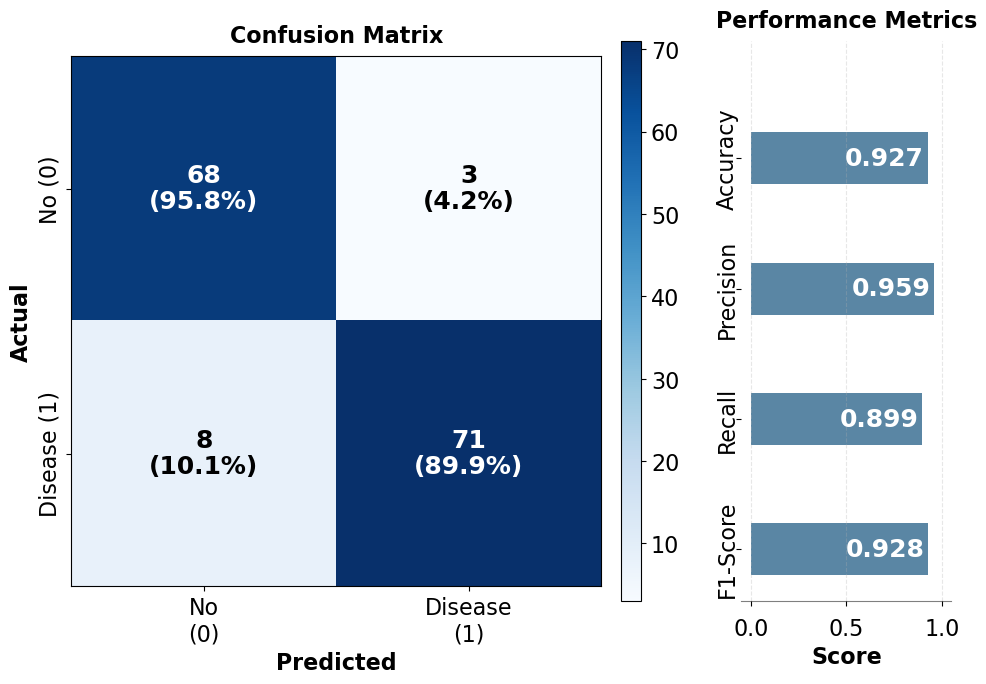

In [35]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [36]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.86666667 0.8907563  0.8907563  0.81512605 0.8487395 ]
Mean: 0.8624
Standard Deviation: 0.0285


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nawo/.

In [37]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 93.05 seconds
Meta Model Tuning & Training Time: 161.48 seconds
Total SEL-NNML Tuning & Training Time: 254.54 seconds


### **6.2 Multiple Model Evaluation**

The evaluation below compares all models (base models + SEL-NNML) for the selected sampler. To compare models across different samplers, change the `SELECTED_SAMPLER` variable in the cell above.

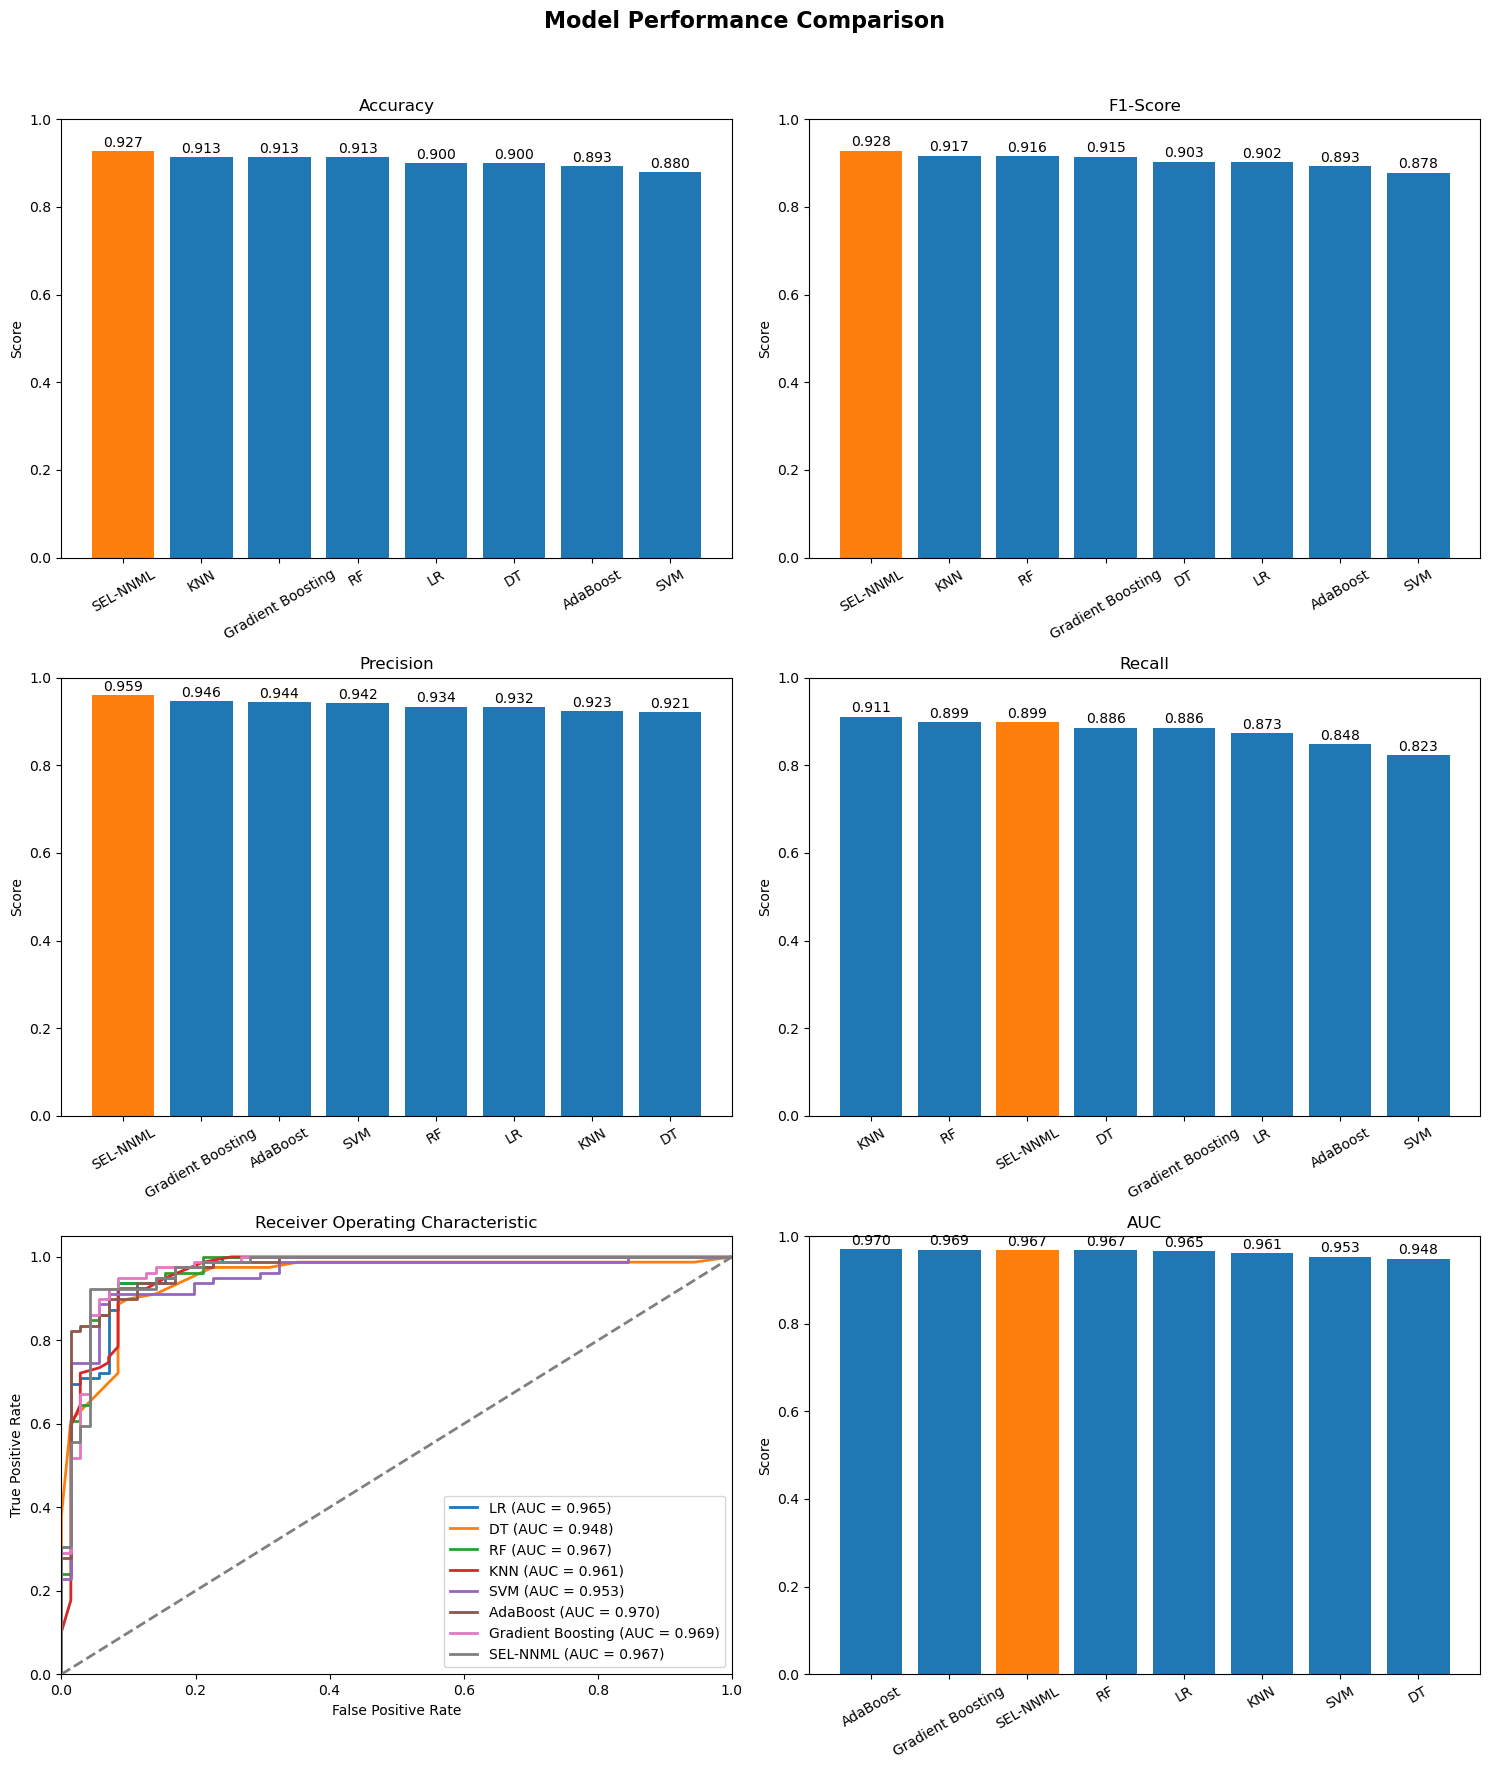

In [38]:
# Use the selected sampler's models for comparison
model_comparison_plot(selected_models, X_test, y_test)

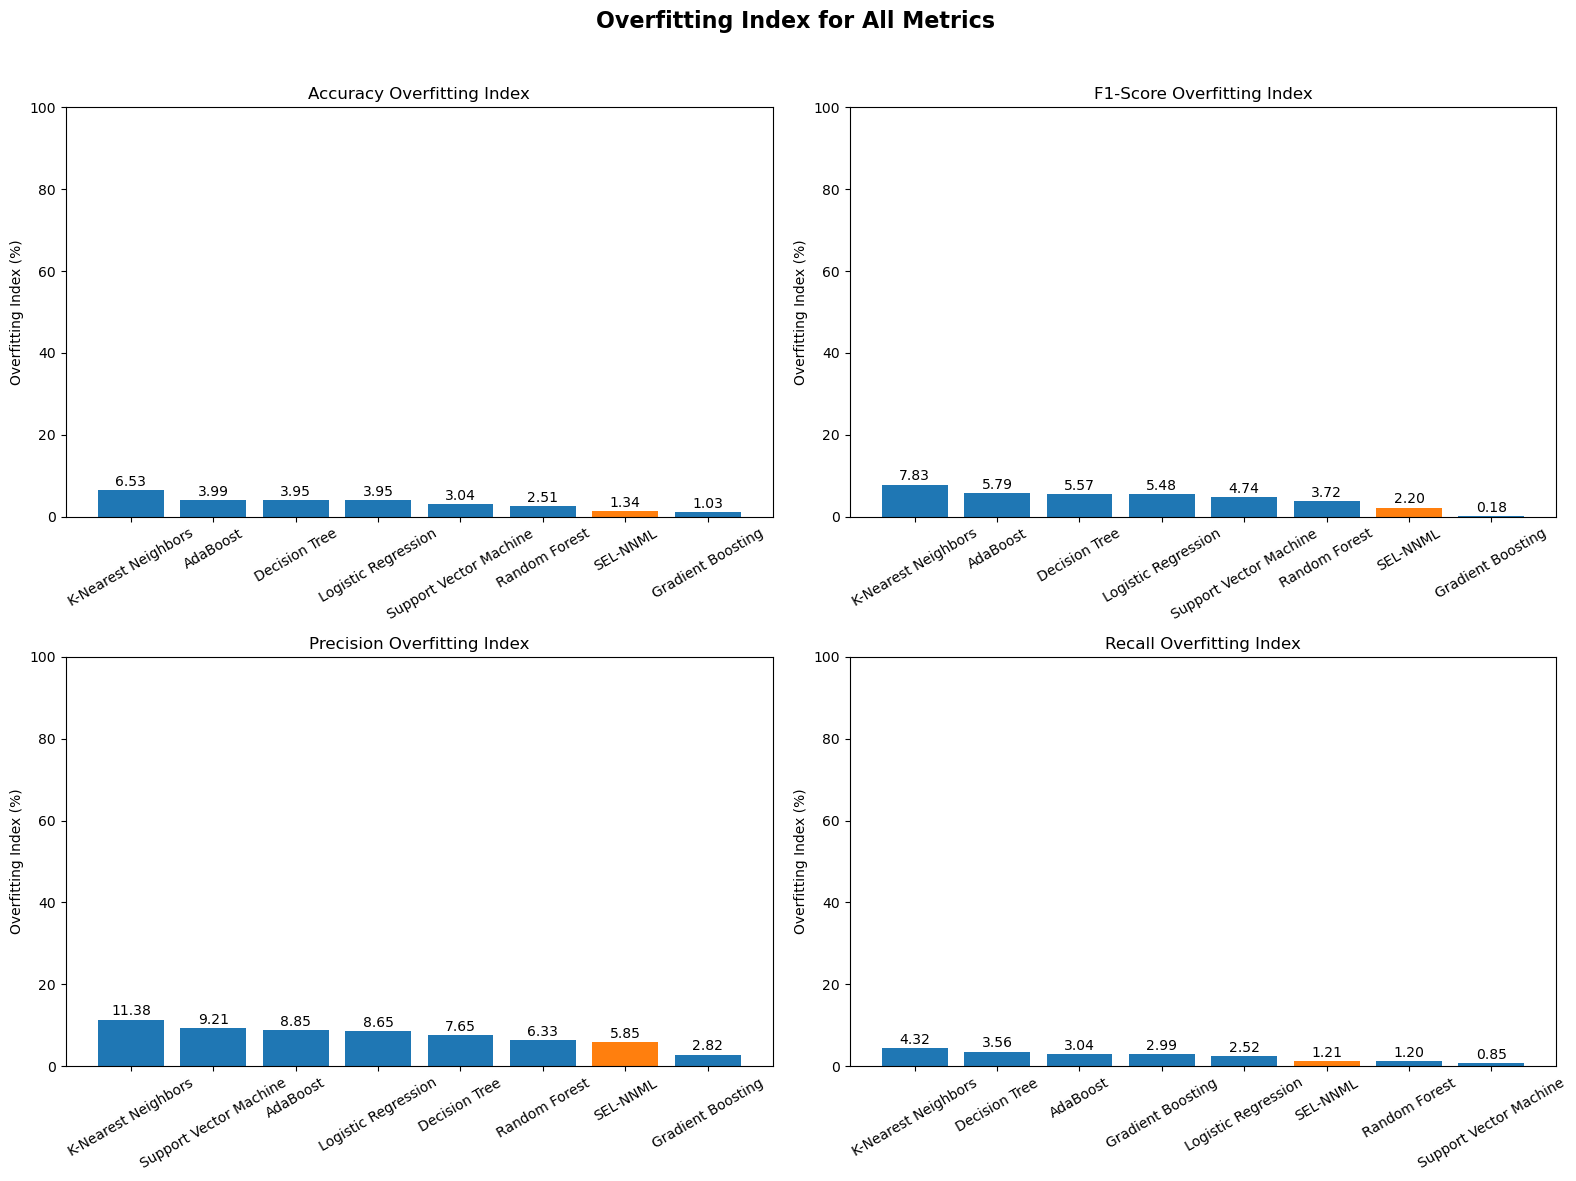

In [39]:
# Use the selected sampler's models for overfitting index comparison
overfitting_index_plot(selected_models, X_train, y_train, X_test, y_test)